In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tsfresh

# 获取上一级目录
path = os.path.dirname(os.getcwd())
path

'/home/adt/project/molding'

In [2]:
xtr_base_path = '/wang/X_train_baseline_107_20201010.csv'
xte_base_path = '/wang/X_test_baseline_107_20201010.csv'
x_set_path = '/赛题二-初赛/Train/data_set.csv'
xtr_mod_path = '/wang/X_new_train_baseline_tsfresh_116_20201010.csv'
xsub_mod_path = '/wang/X_new_sub_baseline_tsfresh_116_20201010.csv'
y_train_path = '/wang/Y_data_train_20201002.csv'

x_TRAIN = pd.read_csv(path + xtr_base_path, index_col=0)
x_TEST0 = pd.read_csv(path + xte_base_path, index_col=0)
x_TEST = x_TEST0[x_TRAIN.columns]
x_SET = pd.read_csv(path + x_set_path)
df_x_train = pd.read_csv(path + xtr_mod_path, index_col=0)
df_x_sub = pd.read_csv(path + xsub_mod_path, index_col=0)
df_y_train = pd.read_csv(path + y_train_path, index_col=0)

print(x_TRAIN.shape)
print(x_TEST.shape)
print(x_SET.shape)
print(df_x_train.shape)
print(df_x_sub.shape)
print(df_y_train.shape)




(16600, 107)
(3953, 107)
(295, 347)
(16600, 117)
(3953, 117)
(16600, 3)


In [10]:
# 先采用效果最好的45列特征 basemod2作为stacking训练数据
base_mod_col2 = ['EL_LAST_COOL_TIME', 'MouldTemp10_mean', 'ext_mold_temp_flt_2',
                 'EL_VPS_END_STR', 'EL_NZL_MEAN','EL_INJ_START_STR', 'MouldTemp1_mean',
                 'Sensor1_mean','EL_MO_TIME', 'EL_PLST_BP_1', 'EL_BARREL_MEAN_3',
                 'IJ_mean', 'EL_CLAMP_PRESS', 'MouldTemp3_mean', 'MouldTemp4_mean',
                 'EL_EF_TIME', 'EL_MC_TIME', 'EL_PLST_END_ERR', 'EL_BARREL_MEAN_2',
                 'MouldTemp2_mean', 'Sensor8_mean', 'EL_BARREL_MEAN_1', 'EL_PP_STG_POS_2',
                 'EL_PP_STG_POS_0', 'EL_IV_END_PRESS', 'EL_MIN_INJ_STR', 'MouldTemp14_mean',
                 'EL_IV_STG_TIME_3', 'EL_BARREL_MEAN_4', 'EL_IV_STG_TIME_4', 'Sensor2_mean',
                 'ext_mold_temp_flt_1', 'ext_mold_temp_flt_3', 'EL_EB_TIME', 'SP_mean',
                 'MouldTemp13_mean', 'EL_MOP', 'EL_MAX_INJ_PRESS', 'ext_mold_temp_flt_0',
                 'EL_PP_STG_POS_1', 'EL_CYC_TIME', 'EL_PLST_BP_0', 'EL_IV_END_STR',
                 'EL_EF_END_POS', 'EL_IV_STG_TIME_0']
len(base_mod_col2)

45

In [149]:
# 构建stacking的框架
from sklearn.model_selection import KFold
from scipy import sparse
import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def stacking_reg(clf, train_x, train_y, test_x, clf_name, kf,
                label_split=None):
    
    # 存放valid集预测的结果，来作为第二层的输入，输出
    train = np.zeros((len(train_x), 1))
    # 存放单折test
    test = np.zeros((len(test_x), 1))
    # 存放K折test
    test_pre = np.empty((folds, len(test_x), 1))
    cv_scores = []
    
    for i, (train_index, 
           test_index) in enumerate(kf.split(train_x, label_split)):
        
        tr_x, tr_y = train_x.values[train_index], train_y.values[train_index]
        te_x, te_y = train_x.values[test_index], train_y.values[test_index]
        print('train.shape:', tr_x.shape)
        print('test.shape:', te_x.shape)
        
        if clf_name in ['rf', 'ada', 'gb', 'et', 'lr', 'lsvc']:
            
            # 因为没有归一化，所以lr不适用，待新建立
            clf.fit(tr_x, tr_y)
            pre = clf.predict(te_x).reshape(-1, 1)
            train[test_index] = pre
            test_pre[i, :] = clf.predict(test_x).reshape(-1,1)
            cv_scores.append(mean_squared_error(te_y, pre))
            
        elif clf_name in ['ridge']:
            
            scaler = RobustScaler().fit(train_x)
            tr_x_scaler = scaler.transform(tr_x)
            te_x_scaler = scaler.transform(te_x)
            test_x_scaler = scaler.transform(test_x)
            
            alph2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
            ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alph2, cv=kf))
            ridge.fit(tr_x_scaler, tr_y)
            
            pre = ridge.predict(te_x_scaler).reshape(-1,1)
            train[test_index] = pre
            test_pre[i, :] = ridge.predict(test_x_scaler).reshape(-1,1)
            cv_scores.append(mean_squared_error(te_y, pre))
            
        elif clf_name in ['svr']:
            
            scaler = RobustScaler().fit(train_x)
            tr_x_scaler = scaler.transform(tr_x)
            te_x_scaler = scaler.transform(te_x)
            test_x_scaler = scaler.transform(test_x)
            
            svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
            svr.fit(tr_x_scaler, tr_y)
            
            pre = svr.predict(te_x_scaler).reshape(-1,1)
            train[test_index] = pre
            test_pre[i, :] = svr.predict(test_x_scaler).reshape(-1,1)
            cv_scores.append(mean_squared_error(te_y, pre))
   
        elif clf_name in ['xgb']:

            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-999)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-999)
            z = clf.DMatrix(test_x.values)

            params = {
                'booster': 'gbtree',
                'eval_metric': 'rmse',
                'gamma': 1,
                'min_child_weight': 1.5,
                'max_depth': 5,
                'lambda': 10,
                'subsample': 0.7,
                'colsample': 0.7,
                'colsample_bytree': 0.7,
                'colsample_bylevel': 0.7,
                'eta': 0.03,
                'tree_method': 'exact',
                'seed': 2020,
            }

            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'), (test_matrix, 'eval')]
            if test_matrix:
                model = clf.train(
                    params,
                    train_matrix,
                    num_boost_round = num_round,
                    evals = watchlist,
                    early_stopping_rounds = early_stopping_rounds
                )

                pre = model.predict(
                    test_matrix,
                    ntree_limit = model.best_ntree_limit
                ).reshape(-1,1)

                train[test_index] = pre
                test_pre[i,:] = model.predict(
                            z, ntree_limit=model.best_ntree_limit
                ).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))
                
            elif clf_name in ['lgb']:
                
                train_matrix = clf.Dataset(tr_x, label=tr_y)
                test_matrix = clf.Dataset(te_x, label=te_y)
                params = {
                    'boosting_type': 'gbdt',
                    'objective': 'regression_l2',
                    'metric': 'mse',
                    'min_child_weight': 1.5,
                    'num_leaves': 2**5,
                    'lambda_l2': 10,
                    'subsample': 0.7,
                    'colsample_bytree': 0.7,
                    'colsample_bylevel': 0.7,
                    'learning_rate': 0.03,
                    'tree_method': 'exact',
                    'seed': 2020
                }
                
                num_round = 10000
                early_stopping_rounds = 100
                
                if test_matrix:
                    model = clf.train(
                        params,
                        train_matrix,
                        num_round,
                        valid_sets = test_matrix,
                        early_stopping_rounds = early_stopping_rounds
                    )
                    
                    pre = model.predict(
                        te_x,
                        num_ireration=model.best_iteration
                    ).reshape(-1,1)
                    
                    train[test_index] = pre
                    test_pre[i,:] = model.predict(
                        test_x,
                        num_iterations=model.best_iteration
                    ).reshape(-1,1)
                    
                    cv_scores.append(mean_squared_error(te_y, pre))
                    
            else:
                raise IOError('请加入新的clf name')

        print('%s now score is:' % clf_name, cv_scores)
        
    test[:] = test_pre.mean(axis=0)
    print('%s score_list:'% clf_name, cv_scores)
    print('%s score_mean:'% clf_name, np.mean(cv_scores))
    
    return train.reshape(-1,1), test.reshape(-1,1)




In [148]:
# 构建stacking基学习器


def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
    random_forest = RandomForestRegressor(
        n_estimators=600,
        max_depth=20,
        random_state=2020,
        max_features='auto',
        n_jobs=-1,
        verbose=1
    )
    
    rf_train, rf_test = stacking_reg(random_forest,
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'rf',
                                    kf,
                                    label_split=label_split)
    return rf_train, rf_test, 'rf_reg'

def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    adaboost = AdaBoostRegressor(
        n_estimators=30,
        random_state=2020,
        learning_rate=0.01
    )
    
    ada_train, ada_test = stacking_reg(adaboost,
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'ada',
                                    kf,
                                    label_split=label_split)
    return ada_train, ada_test, 'ada_reg'

def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    gbboost = GradientBoostingRegressor(
        learning_rate=0.04,
        n_estimators=100,
        subsample=0.8,
        random_state=2020,
        max_depth=5,
        verbose=1
    )
    
    gbdt_train, gbdt_test = stacking_reg(gbboost,
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'gb',
                                    kf,
                                    label_split=label_split)
    return gbdt_train, gbdt_test, 'gb_reg'

def et_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    extratree = ExtraTreesRegressor(
        n_estimators=600,
        max_features='auto',
        random_state=2020,
        max_depth=35,
        n_jobs=-1,
        verbose=1
    )
    
    et_train, et_test = stacking_reg(extratree,
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'et',
                                    kf,
                                    label_split=label_split)
    return et_train, et_test, 'et_reg'

def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    lr_reg = LinearRegression(
        
    )
    
    lr_train, lr_test = stacking_reg(lr_reg,
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'lr',
                                    kf,
                                    label_split=label_split)
    return lr_train, lr_test, 'lr_reg'

def ridge_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    ridge_train, ridge_test = stacking_reg(Ridge(),
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'ridge',
                                    kf,
                                    label_split=label_split)
    return ridge_train, ridge_test, 'ridge_reg'

def svr_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    svr_train, svr_test = stacking_reg(SVR(),
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'svr',
                                    kf,
                                    label_split=label_split)
    return svr_train, svr_test, 'svr_reg'

def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    xgb_train, xgb_test = stacking_reg(xgb,
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'xgb',
                                    kf,
                                    label_split=label_split)
    return xgb_train, xgb_test, 'xgb_reg'

def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    
    lgb_train, lgb_test = stacking_reg(lgb,
                                    x_train,
                                    y_train,
                                    x_valid,
                                    'lgb',
                                    kf,
                                    label_split=label_split)
    return lgb_train, lgb_test, 'lgb_reg'



In [138]:
def stacking_pred(
    x_train, y_train,
    x_valid, kf,
    clf_list, label_split=None,
    clf_fin='lgb',
    if_concat_origin=True):
    
    for k, clf_list in enumerate(clf_list):
        
        clf_list = [clf_list]
        print('现在第一层的的clf_list', clf_list)
        column_list = []
        train_data_list = []
        test_data_list = []
        
        for clf in clf_list:
            train_data, test_data, clf_name = clf(
                x_train,
                y_train,
                x_valid,
                kf,
                label_split=label_split)
            train_data_list.append(train_data)
            test_data_list.append(test_data)
            column_list.append('clf_%s'%(clf_name))
            
    train = np.concatenate(train_data_list, axis=1)
    test = np.concatenate(test_data_list, axis=1)
    
    # 将base的特征加入基学习器预测的结果
    if if_concat_origin:
#         train = np.concatenate([x_train, train], axis=1)
#         test = np.concatenate([x_valid, test], axis=1)
        # 暂时改为合并原45列特征
        train = np.concatenate([df_x_train[base_mod_col3].values, train], axis=1)
        test = np.concatenate([df_x_sub[base_mod_col3].values, test], axis=1)
    
    print('base的特征shape是', x_train.shape)
    print('第二层训练的特征 train shape是', train.shape)
    print('第二层训练的特征test shape是', test.shape)
    print(clf_name)
    print(clf_name in ['lgb'])
    
    pre = np.zeros(len(x_valid))
    
    # 在第二层增加kf交替验证，取平均值
    for i, (train_index, val_index) in enumerate(kf.split(train)):
        print("fold {}".format(i))
        X_tr, X_val = train[train_index], train[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
        if clf_fin in ['rf', 'ada', 'gb', 'et', 'lr', 'lsvc', 'knn']:
            if clf_fin in ['rf']:
                clf = RandomForestRegressor(
                    n_estimators = 600,
                    max_depth=20,
                    random_state=2020,
                    verbose=1)
            elif clf_fin in ['ada']:
                clf = AdaBoostRegressor(
                    n_estimators=20,
                    random_state=2020,
                    learning_rate=0.01)
            elif clf_fin in ['gb']:
                clf = GradientBoostingRegressor(
                    n_estimators=100,
                    subsample=0.8,
                    max_depth=5,
                    random_state=2020,
                    learning_rate=0.04,
                    verbose=1)
            elif clf_fin in ['et']:
                clf = ExtraTreeRegressor(
                    n_estimators=600,
                    max_depth=35,
                    max_features='auto',
                    random_state=2020,
                    verbose=1)
            elif clf_fin in ['lr']:
                clf = LinearRegression(
                    )

            clf.fit(X_tr, y_tr)
            pre += clf.predict(test).reshape(-1,1)/folds
#     return pre

        elif clf_fin in ['xgb']:
            clf = xgb
            train_matrix = clf.DMatrix(X_tr, 
                                      label=y_tr, missing=-999)
            # 这里还用train用来进行训练时的eval评价
            test_matrix = clf.DMatrix(X_val,
                                     label=y_val, missing=-999)
            params = {
                'booster': 'gbtree',
                'eval_metric': 'rmse',
                'gamma': 1,
                'min_child_weight': 1.5,
                'max_depth': 5,
                'lambda': 10,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'colsample_bylevel': 0.7,
                'eta': 0.03,
                'tree_method': 'exact',
                'seed': 2020
            }

            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'), (test_matrix, 'eval')]

            model = clf.train(
                params,
                train_matrix,
                num_boost_round = num_round,
                evals = watchlist,
                early_stopping_rounds = early_stopping_rounds
            )

            pre += model.predict(
                test,
                ntree_limit = model.best_ntree_limit
            ).reshape(-1,1)/folds

#     return pre

        elif clf_fin in ['lgb']:
            clf = lgb
            train_matrix = clf.Dataset(X_tr, 
                                      label=y_tr)
            # 这里还用train用来进行训练时的eval评价
            test_matrix = clf.Dataset(X_val,
                                     label=y_val)
            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
    #             'metric': 'mse',
    #             'min_child_weight': 1.5,
                'num_leaves': 2**4,
    #             'lambda_l2': 10,
                'subsample': 0.9,
    #             'colsample_bytree': 0.7,
    #             'colsample_bylevel': 0.7,
                'learning_rate': 0.05,
    #             'tree_method': 'exact',
                'seed': 2020
            }

            num_round = 2000
            early_stopping_rounds = 50

            model = clf.train(
                params,
                train_matrix,
                num_round,
                valid_sets = test_matrix,
                verbose_eval=50,
                early_stopping_rounds = early_stopping_rounds
            )


            print('==============================================')
            
            pre += (model.predict(
                test,
                num_iteration=model.best_iteration
            ))/folds
            print(pre)
                
    return pre



In [91]:
folds = 5
seed = 1
kf = KFold(n_splits=folds, shuffle=True, random_state=0)
clf_list = [ridge_reg, rf_reg, ada_reg, et_reg, xgb_reg]


In [92]:
sub=pd.read_csv(path + '/赛题二-初赛/sub_file.csv')

for i in ['size1', 'size2', 'size3']:
    print(i)
    pred = stacking_pred(df_x_train[base_mod_col2],
                        df_y_train[i],
                        df_x_sub[base_mod_col2],
                        kf,
                        clf_list,
                        label_split=None,
                        clf_fin='lgb',
                        if_concat_origin=False)
    sub[i] = pred


size1
现在第一层的的clf_list [<function ridge_reg at 0x7f1246d3e050>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ridge now score is: [0.002589644124793132]
train.shape: (13280, 45)
test.shape: (3320, 45)
ridge now score is: [0.002589644124793132, 0.0007557835044253806]
train.shape: (13280, 45)
test.shape: (3320, 45)
ridge now score is: [0.002589644124793132, 0.0007557835044253806, 0.0006236104126275103]
train.shape: (13280, 45)
test.shape: (3320, 45)
ridge now score is: [0.002589644124793132, 0.0007557835044253806, 0.0006236104126275103, 0.0007028092895879753]
train.shape: (13280, 45)
test.shape: (3320, 45)
ridge now score is: [0.002589644124793132, 0.0007557835044253806, 0.0006236104126275103, 0.0007028092895879753, 0.0006162896568823248]
ridge score_list: [0.002589644124793132, 0.0007557835044253806, 0.0006236104126275103, 0.0007028092895879753, 0.0006162896568823248]
ridge score_mean: 0.0010576273976632645
现在第一层的的clf_list [<function rf_reg at 0x7f1246d3e440>]
train.shape: (13280, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154546276]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154546276, 0.00038675020942044094]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154546276, 0.00038675020942044094, 0.0003942808009206114]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154546276, 0.00038675020942044094, 0.0003942808009206114, 0.00047985263413556124]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154546276, 0.00038675020942044094, 0.0003942808009206114, 0.00047985263413556124, 0.00041824516178626383]
rf score_list: [0.00038626230154546276, 0.00038675020942044094, 0.0003942808009206114, 0.00047985263413556124, 0.00041824516178626383]
rf score_mean: 0.00041307822156166804
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081, 0.000812309322802465]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081, 0.000812309322802465, 0.0009327161577702398]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081, 0.000812309322802465, 0.00

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399095013]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399095013, 0.0003543954632890883]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399095013, 0.0003543954632890883, 0.00037395277194711163]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399095013, 0.0003543954632890883, 0.00037395277194711163, 0.0004628128116646258]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399095013, 0.0003543954632890883, 0.00037395277194711163, 0.0004628128116646258, 0.00039482933858400276]
et score_list: [0.00036738117399095013, 0.0003543954632890883, 0.00037395277194711163, 0.0004628128116646258, 0.00039482933858400276]
et score_mean: 0.0003906743118951558
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 45)
test.shape: (3320, 45)
[16:52:07] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:290.58804	eval-rmse:290.58896
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:281.87979	eval-rmse:281.88068
[2]	train-rmse:273.

[166]	train-rmse:1.86161	eval-rmse:1.86254
[167]	train-rmse:1.80587	eval-rmse:1.80679
[168]	train-rmse:1.75177	eval-rmse:1.75270
[169]	train-rmse:1.69930	eval-rmse:1.70023
[170]	train-rmse:1.64841	eval-rmse:1.64934
[171]	train-rmse:1.59905	eval-rmse:1.59998
[172]	train-rmse:1.55115	eval-rmse:1.55208
[173]	train-rmse:1.50469	eval-rmse:1.50562
[174]	train-rmse:1.45960	eval-rmse:1.46054
[175]	train-rmse:1.41589	eval-rmse:1.41682
[176]	train-rmse:1.37349	eval-rmse:1.37442
[177]	train-rmse:1.33237	eval-rmse:1.33330
[178]	train-rmse:1.29247	eval-rmse:1.29341
[179]	train-rmse:1.25377	eval-rmse:1.25470
[180]	train-rmse:1.21622	eval-rmse:1.21716
[181]	train-rmse:1.17980	eval-rmse:1.18074
[182]	train-rmse:1.14449	eval-rmse:1.14543
[183]	train-rmse:1.11024	eval-rmse:1.11118
[184]	train-rmse:1.07700	eval-rmse:1.07794
[185]	train-rmse:1.04477	eval-rmse:1.04571
[186]	train-rmse:1.01351	eval-rmse:1.01445
[187]	train-rmse:0.98318	eval-rmse:0.98411
[188]	train-rmse:0.95378	eval-rmse:0.95472
[189]	train

[357]	train-rmse:0.03491	eval-rmse:0.03490
[358]	train-rmse:0.03488	eval-rmse:0.03487
[359]	train-rmse:0.03486	eval-rmse:0.03484
[360]	train-rmse:0.03484	eval-rmse:0.03481
[361]	train-rmse:0.03482	eval-rmse:0.03479
[362]	train-rmse:0.03479	eval-rmse:0.03476
[363]	train-rmse:0.03477	eval-rmse:0.03474
[364]	train-rmse:0.03475	eval-rmse:0.03472
[365]	train-rmse:0.03474	eval-rmse:0.03470
[366]	train-rmse:0.03472	eval-rmse:0.03468
[367]	train-rmse:0.03471	eval-rmse:0.03466
[368]	train-rmse:0.03469	eval-rmse:0.03465
[369]	train-rmse:0.03468	eval-rmse:0.03463
[370]	train-rmse:0.03467	eval-rmse:0.03461
[371]	train-rmse:0.03465	eval-rmse:0.03460
[372]	train-rmse:0.03464	eval-rmse:0.03458
[373]	train-rmse:0.03463	eval-rmse:0.03457
[374]	train-rmse:0.03462	eval-rmse:0.03456
[375]	train-rmse:0.03461	eval-rmse:0.03454
[376]	train-rmse:0.03460	eval-rmse:0.03454
[377]	train-rmse:0.03459	eval-rmse:0.03453
[378]	train-rmse:0.03458	eval-rmse:0.03451
[379]	train-rmse:0.03458	eval-rmse:0.03451
[380]	train

[548]	train-rmse:0.03405	eval-rmse:0.03387
[549]	train-rmse:0.03405	eval-rmse:0.03387
[550]	train-rmse:0.03405	eval-rmse:0.03387
[551]	train-rmse:0.03405	eval-rmse:0.03387
[552]	train-rmse:0.03405	eval-rmse:0.03387
[553]	train-rmse:0.03405	eval-rmse:0.03387
[554]	train-rmse:0.03405	eval-rmse:0.03387
[555]	train-rmse:0.03405	eval-rmse:0.03387
[556]	train-rmse:0.03405	eval-rmse:0.03387
[557]	train-rmse:0.03405	eval-rmse:0.03387
[558]	train-rmse:0.03405	eval-rmse:0.03387
[559]	train-rmse:0.03405	eval-rmse:0.03387
[560]	train-rmse:0.03405	eval-rmse:0.03387
[561]	train-rmse:0.03405	eval-rmse:0.03387
[562]	train-rmse:0.03405	eval-rmse:0.03387
[563]	train-rmse:0.03405	eval-rmse:0.03387
[564]	train-rmse:0.03405	eval-rmse:0.03387
[565]	train-rmse:0.03405	eval-rmse:0.03387
[566]	train-rmse:0.03405	eval-rmse:0.03387
[567]	train-rmse:0.03405	eval-rmse:0.03387
[568]	train-rmse:0.03405	eval-rmse:0.03387
[569]	train-rmse:0.03405	eval-rmse:0.03387
[570]	train-rmse:0.03405	eval-rmse:0.03387
[571]	train

[0]	train-rmse:290.58810	eval-rmse:290.58881
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:281.87979	eval-rmse:281.88052
[2]	train-rmse:273.43250	eval-rmse:273.43323
[3]	train-rmse:265.23834	eval-rmse:265.23908
[4]	train-rmse:257.28986	eval-rmse:257.29059
[5]	train-rmse:249.57947	eval-rmse:249.58011
[6]	train-rmse:242.10010	eval-rmse:242.10080
[7]	train-rmse:234.84497	eval-rmse:234.84570
[8]	train-rmse:227.80719	eval-rmse:227.80794
[9]	train-rmse:220.98035	eval-rmse:220.98112
[10]	train-rmse:214.35806	eval-rmse:214.35883
[11]	train-rmse:207.93422	eval-rmse:207.93495
[12]	train-rmse:201.70299	eval-rmse:201.70372
[13]	train-rmse:195.65837	eval-rmse:195.65909
[14]	train-rmse:189.79486	eval-rmse:189.79561
[15]	train-rmse:184.10718	eval-rmse:184.10792
[16]	train-rmse:178.58993	eval-rmse:178.59065
[17]	train-rmse:173.23802	eval-rmse:173.23875
[18]	train-rmse:168.04642	eval-rmse:16

[183]	train-rmse:1.11022	eval-rmse:1.11096
[184]	train-rmse:1.07698	eval-rmse:1.07772
[185]	train-rmse:1.04475	eval-rmse:1.04548
[186]	train-rmse:1.01349	eval-rmse:1.01423
[187]	train-rmse:0.98315	eval-rmse:0.98389
[188]	train-rmse:0.95376	eval-rmse:0.95450
[189]	train-rmse:0.92522	eval-rmse:0.92596
[190]	train-rmse:0.89754	eval-rmse:0.89828
[191]	train-rmse:0.87069	eval-rmse:0.87143
[192]	train-rmse:0.84466	eval-rmse:0.84540
[193]	train-rmse:0.81939	eval-rmse:0.82013
[194]	train-rmse:0.79492	eval-rmse:0.79565
[195]	train-rmse:0.77115	eval-rmse:0.77188
[196]	train-rmse:0.74811	eval-rmse:0.74885
[197]	train-rmse:0.72574	eval-rmse:0.72648
[198]	train-rmse:0.70408	eval-rmse:0.70482
[199]	train-rmse:0.68307	eval-rmse:0.68380
[200]	train-rmse:0.66269	eval-rmse:0.66343
[201]	train-rmse:0.64289	eval-rmse:0.64363
[202]	train-rmse:0.62371	eval-rmse:0.62445
[203]	train-rmse:0.60507	eval-rmse:0.60581
[204]	train-rmse:0.58702	eval-rmse:0.58776
[205]	train-rmse:0.56952	eval-rmse:0.57026
[206]	train

[374]	train-rmse:0.03435	eval-rmse:0.03447
[375]	train-rmse:0.03435	eval-rmse:0.03447
[376]	train-rmse:0.03434	eval-rmse:0.03445
[377]	train-rmse:0.03433	eval-rmse:0.03445
[378]	train-rmse:0.03432	eval-rmse:0.03444
[379]	train-rmse:0.03431	eval-rmse:0.03443
[380]	train-rmse:0.03431	eval-rmse:0.03442
[381]	train-rmse:0.03430	eval-rmse:0.03441
[382]	train-rmse:0.03429	eval-rmse:0.03440
[383]	train-rmse:0.03429	eval-rmse:0.03440
[384]	train-rmse:0.03428	eval-rmse:0.03439
[385]	train-rmse:0.03428	eval-rmse:0.03438
[386]	train-rmse:0.03427	eval-rmse:0.03438
[387]	train-rmse:0.03427	eval-rmse:0.03437
[388]	train-rmse:0.03426	eval-rmse:0.03437
[389]	train-rmse:0.03426	eval-rmse:0.03436
[390]	train-rmse:0.03426	eval-rmse:0.03436
[391]	train-rmse:0.03425	eval-rmse:0.03435
[392]	train-rmse:0.03425	eval-rmse:0.03435
[393]	train-rmse:0.03424	eval-rmse:0.03435
[394]	train-rmse:0.03424	eval-rmse:0.03434
[395]	train-rmse:0.03424	eval-rmse:0.03434
[396]	train-rmse:0.03424	eval-rmse:0.03433
[397]	train

[565]	train-rmse:0.03403	eval-rmse:0.03409
[566]	train-rmse:0.03403	eval-rmse:0.03409
[567]	train-rmse:0.03403	eval-rmse:0.03409
[568]	train-rmse:0.03403	eval-rmse:0.03409
[569]	train-rmse:0.03403	eval-rmse:0.03409
[570]	train-rmse:0.03403	eval-rmse:0.03409
[571]	train-rmse:0.03403	eval-rmse:0.03409
[572]	train-rmse:0.03403	eval-rmse:0.03409
[573]	train-rmse:0.03403	eval-rmse:0.03409
[574]	train-rmse:0.03403	eval-rmse:0.03409
[575]	train-rmse:0.03403	eval-rmse:0.03409
[576]	train-rmse:0.03403	eval-rmse:0.03409
[577]	train-rmse:0.03403	eval-rmse:0.03409
[578]	train-rmse:0.03403	eval-rmse:0.03409
[579]	train-rmse:0.03403	eval-rmse:0.03409
[580]	train-rmse:0.03403	eval-rmse:0.03409
[581]	train-rmse:0.03403	eval-rmse:0.03409
[582]	train-rmse:0.03403	eval-rmse:0.03409
[583]	train-rmse:0.03403	eval-rmse:0.03409
[584]	train-rmse:0.03403	eval-rmse:0.03409
[585]	train-rmse:0.03403	eval-rmse:0.03409
[586]	train-rmse:0.03403	eval-rmse:0.03409
[587]	train-rmse:0.03403	eval-rmse:0.03409
[588]	train

[35]	train-rmse:100.18294	eval-rmse:100.18256
[36]	train-rmse:97.18067	eval-rmse:97.18032
[37]	train-rmse:94.26842	eval-rmse:94.26804
[38]	train-rmse:91.44347	eval-rmse:91.44307
[39]	train-rmse:88.70309	eval-rmse:88.70271
[40]	train-rmse:86.04485	eval-rmse:86.04445
[41]	train-rmse:83.46622	eval-rmse:83.46590
[42]	train-rmse:80.96499	eval-rmse:80.96460
[43]	train-rmse:78.53865	eval-rmse:78.53825
[44]	train-rmse:76.18499	eval-rmse:76.18460
[45]	train-rmse:73.90187	eval-rmse:73.90147
[46]	train-rmse:71.68722	eval-rmse:71.68684
[47]	train-rmse:69.53893	eval-rmse:69.53854
[48]	train-rmse:67.45498	eval-rmse:67.45459
[49]	train-rmse:65.43352	eval-rmse:65.43312
[50]	train-rmse:63.47260	eval-rmse:63.47220
[51]	train-rmse:61.57048	eval-rmse:61.57008
[52]	train-rmse:59.72536	eval-rmse:59.72496
[53]	train-rmse:57.93552	eval-rmse:57.93513
[54]	train-rmse:56.19932	eval-rmse:56.19893
[55]	train-rmse:54.51514	eval-rmse:54.51476
[56]	train-rmse:52.88145	eval-rmse:52.88106
[57]	train-rmse:51.29670	eval-

[224]	train-rmse:0.32127	eval-rmse:0.32079
[225]	train-rmse:0.31176	eval-rmse:0.31128
[226]	train-rmse:0.30255	eval-rmse:0.30207
[227]	train-rmse:0.29365	eval-rmse:0.29317
[228]	train-rmse:0.28499	eval-rmse:0.28450
[229]	train-rmse:0.27659	eval-rmse:0.27611
[230]	train-rmse:0.26844	eval-rmse:0.26797
[231]	train-rmse:0.26056	eval-rmse:0.26008
[232]	train-rmse:0.25293	eval-rmse:0.25244
[233]	train-rmse:0.24551	eval-rmse:0.24502
[234]	train-rmse:0.23830	eval-rmse:0.23781
[235]	train-rmse:0.23131	eval-rmse:0.23082
[236]	train-rmse:0.22455	eval-rmse:0.22406
[237]	train-rmse:0.21802	eval-rmse:0.21753
[238]	train-rmse:0.21162	eval-rmse:0.21113
[239]	train-rmse:0.20546	eval-rmse:0.20497
[240]	train-rmse:0.19952	eval-rmse:0.19903
[241]	train-rmse:0.19376	eval-rmse:0.19327
[242]	train-rmse:0.18816	eval-rmse:0.18766
[243]	train-rmse:0.18275	eval-rmse:0.18224
[244]	train-rmse:0.17747	eval-rmse:0.17695
[245]	train-rmse:0.17239	eval-rmse:0.17188
[246]	train-rmse:0.16743	eval-rmse:0.16691
[247]	train

[415]	train-rmse:0.03423	eval-rmse:0.03350
[416]	train-rmse:0.03423	eval-rmse:0.03350
[417]	train-rmse:0.03423	eval-rmse:0.03350
[418]	train-rmse:0.03423	eval-rmse:0.03350
[419]	train-rmse:0.03423	eval-rmse:0.03350
[420]	train-rmse:0.03423	eval-rmse:0.03350
[421]	train-rmse:0.03422	eval-rmse:0.03349
[422]	train-rmse:0.03422	eval-rmse:0.03349
[423]	train-rmse:0.03422	eval-rmse:0.03349
[424]	train-rmse:0.03422	eval-rmse:0.03349
[425]	train-rmse:0.03422	eval-rmse:0.03349
[426]	train-rmse:0.03422	eval-rmse:0.03349
[427]	train-rmse:0.03422	eval-rmse:0.03349
[428]	train-rmse:0.03422	eval-rmse:0.03349
[429]	train-rmse:0.03422	eval-rmse:0.03349
[430]	train-rmse:0.03422	eval-rmse:0.03349
[431]	train-rmse:0.03422	eval-rmse:0.03349
[432]	train-rmse:0.03422	eval-rmse:0.03349
[433]	train-rmse:0.03422	eval-rmse:0.03349
[434]	train-rmse:0.03422	eval-rmse:0.03349
[435]	train-rmse:0.03422	eval-rmse:0.03349
[436]	train-rmse:0.03422	eval-rmse:0.03349
[437]	train-rmse:0.03422	eval-rmse:0.03349
[438]	train

[24]	train-rmse:140.00595	eval-rmse:140.00597
[25]	train-rmse:135.81030	eval-rmse:135.81032
[26]	train-rmse:131.74037	eval-rmse:131.74040
[27]	train-rmse:127.79235	eval-rmse:127.79236
[28]	train-rmse:123.96275	eval-rmse:123.96274
[29]	train-rmse:120.24787	eval-rmse:120.24786
[30]	train-rmse:116.64423	eval-rmse:116.64426
[31]	train-rmse:113.14866	eval-rmse:113.14867
[32]	train-rmse:109.75784	eval-rmse:109.75784
[33]	train-rmse:106.46860	eval-rmse:106.46861
[34]	train-rmse:103.27799	eval-rmse:103.27799
[35]	train-rmse:100.18289	eval-rmse:100.18293
[36]	train-rmse:97.18068	eval-rmse:97.18070
[37]	train-rmse:94.26841	eval-rmse:94.26841
[38]	train-rmse:91.44344	eval-rmse:91.44344
[39]	train-rmse:88.70309	eval-rmse:88.70309
[40]	train-rmse:86.04483	eval-rmse:86.04484
[41]	train-rmse:83.46617	eval-rmse:83.46627
[42]	train-rmse:80.96496	eval-rmse:80.96496
[43]	train-rmse:78.53861	eval-rmse:78.53862
[44]	train-rmse:76.18495	eval-rmse:76.18497
[45]	train-rmse:73.90185	eval-rmse:73.90185
[46]	tra

[212]	train-rmse:0.46096	eval-rmse:0.46110
[213]	train-rmse:0.44725	eval-rmse:0.44740
[214]	train-rmse:0.43397	eval-rmse:0.43413
[215]	train-rmse:0.42109	eval-rmse:0.42125
[216]	train-rmse:0.40859	eval-rmse:0.40877
[217]	train-rmse:0.39648	eval-rmse:0.39666
[218]	train-rmse:0.38470	eval-rmse:0.38492
[219]	train-rmse:0.37329	eval-rmse:0.37351
[220]	train-rmse:0.36223	eval-rmse:0.36247
[221]	train-rmse:0.35152	eval-rmse:0.35176
[222]	train-rmse:0.34111	eval-rmse:0.34137
[223]	train-rmse:0.33102	eval-rmse:0.33130
[224]	train-rmse:0.32123	eval-rmse:0.32154
[225]	train-rmse:0.31172	eval-rmse:0.31205
[226]	train-rmse:0.30248	eval-rmse:0.30283
[227]	train-rmse:0.29358	eval-rmse:0.29394
[228]	train-rmse:0.28491	eval-rmse:0.28529
[229]	train-rmse:0.27654	eval-rmse:0.27692
[230]	train-rmse:0.26838	eval-rmse:0.26878
[231]	train-rmse:0.26050	eval-rmse:0.26091
[232]	train-rmse:0.25284	eval-rmse:0.25327
[233]	train-rmse:0.24544	eval-rmse:0.24588
[234]	train-rmse:0.23824	eval-rmse:0.23870
[235]	train

[403]	train-rmse:0.03384	eval-rmse:0.03589
[404]	train-rmse:0.03384	eval-rmse:0.03589
[405]	train-rmse:0.03384	eval-rmse:0.03588
[406]	train-rmse:0.03384	eval-rmse:0.03588
[407]	train-rmse:0.03384	eval-rmse:0.03588
[408]	train-rmse:0.03383	eval-rmse:0.03588
[409]	train-rmse:0.03383	eval-rmse:0.03588
[410]	train-rmse:0.03383	eval-rmse:0.03588
[411]	train-rmse:0.03383	eval-rmse:0.03587
[412]	train-rmse:0.03383	eval-rmse:0.03587
[413]	train-rmse:0.03383	eval-rmse:0.03587
[414]	train-rmse:0.03383	eval-rmse:0.03587
[415]	train-rmse:0.03383	eval-rmse:0.03587
[416]	train-rmse:0.03383	eval-rmse:0.03587
[417]	train-rmse:0.03383	eval-rmse:0.03587
[418]	train-rmse:0.03383	eval-rmse:0.03587
[419]	train-rmse:0.03383	eval-rmse:0.03587
[420]	train-rmse:0.03382	eval-rmse:0.03587
[421]	train-rmse:0.03382	eval-rmse:0.03587
[422]	train-rmse:0.03382	eval-rmse:0.03586
[423]	train-rmse:0.03382	eval-rmse:0.03586
[424]	train-rmse:0.03382	eval-rmse:0.03586
[425]	train-rmse:0.03382	eval-rmse:0.03586
[426]	train

test.shape: (3320, 45)
[16:52:25] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:290.58847	eval-rmse:290.58719
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:281.88019	eval-rmse:281.87888
[2]	train-rmse:273.43286	eval-rmse:273.43158
[3]	train-rmse:265.23868	eval-rmse:265.23743
[4]	train-rmse:257.29019	eval-rmse:257.28888
[5]	train-rmse:249.57987	eval-rmse:249.57846
[6]	train-rmse:242.10042	eval-rmse:242.09911
[7]	train-rmse:234.84528	eval-rmse:234.84399
[8]	train-rmse:227.80748	eval-rmse:227.80621
[9]	train-rmse:220.98062	eval-rmse:220.97939
[10]	train-rmse:214.35837	eval-rmse:214.35706


[175]	train-rmse:1.41591	eval-rmse:1.41460
[176]	train-rmse:1.37351	eval-rmse:1.37220
[177]	train-rmse:1.33239	eval-rmse:1.33108
[178]	train-rmse:1.29250	eval-rmse:1.29119
[179]	train-rmse:1.25379	eval-rmse:1.25248
[180]	train-rmse:1.21624	eval-rmse:1.21493
[181]	train-rmse:1.17983	eval-rmse:1.17851
[182]	train-rmse:1.14454	eval-rmse:1.14323
[183]	train-rmse:1.11030	eval-rmse:1.10898
[184]	train-rmse:1.07706	eval-rmse:1.07574
[185]	train-rmse:1.04482	eval-rmse:1.04350
[186]	train-rmse:1.01357	eval-rmse:1.01225
[187]	train-rmse:0.98323	eval-rmse:0.98191
[188]	train-rmse:0.95384	eval-rmse:0.95252
[189]	train-rmse:0.92530	eval-rmse:0.92398
[190]	train-rmse:0.89762	eval-rmse:0.89629
[191]	train-rmse:0.87080	eval-rmse:0.86947
[192]	train-rmse:0.84477	eval-rmse:0.84344
[193]	train-rmse:0.81950	eval-rmse:0.81817
[194]	train-rmse:0.79503	eval-rmse:0.79369
[195]	train-rmse:0.77126	eval-rmse:0.76992
[196]	train-rmse:0.74822	eval-rmse:0.74688
[197]	train-rmse:0.72586	eval-rmse:0.72452
[198]	train

[366]	train-rmse:0.03461	eval-rmse:0.03359
[367]	train-rmse:0.03459	eval-rmse:0.03358
[368]	train-rmse:0.03458	eval-rmse:0.03357
[369]	train-rmse:0.03456	eval-rmse:0.03356
[370]	train-rmse:0.03455	eval-rmse:0.03355
[371]	train-rmse:0.03454	eval-rmse:0.03354
[372]	train-rmse:0.03453	eval-rmse:0.03353
[373]	train-rmse:0.03451	eval-rmse:0.03352
[374]	train-rmse:0.03451	eval-rmse:0.03351
[375]	train-rmse:0.03450	eval-rmse:0.03351
[376]	train-rmse:0.03449	eval-rmse:0.03350
[377]	train-rmse:0.03448	eval-rmse:0.03350
[378]	train-rmse:0.03447	eval-rmse:0.03349
[379]	train-rmse:0.03446	eval-rmse:0.03349
[380]	train-rmse:0.03446	eval-rmse:0.03348
[381]	train-rmse:0.03445	eval-rmse:0.03348
[382]	train-rmse:0.03444	eval-rmse:0.03347
[383]	train-rmse:0.03419	eval-rmse:0.03325
[384]	train-rmse:0.03419	eval-rmse:0.03325
[385]	train-rmse:0.03418	eval-rmse:0.03325
[386]	train-rmse:0.03417	eval-rmse:0.03324
[387]	train-rmse:0.03417	eval-rmse:0.03324
[388]	train-rmse:0.03417	eval-rmse:0.03324
[389]	train

[557]	train-rmse:0.03387	eval-rmse:0.03302
[558]	train-rmse:0.03387	eval-rmse:0.03302
[559]	train-rmse:0.03387	eval-rmse:0.03302
[560]	train-rmse:0.03387	eval-rmse:0.03302
[561]	train-rmse:0.03387	eval-rmse:0.03302
[562]	train-rmse:0.03387	eval-rmse:0.03302
[563]	train-rmse:0.03387	eval-rmse:0.03302
[564]	train-rmse:0.03387	eval-rmse:0.03302
Stopping. Best iteration:
[464]	train-rmse:0.03387	eval-rmse:0.03302

xgb now score is: [0.0011468486413977706, 0.0011618743319759598, 0.0011061501206486768, 0.0012754539682233155, 0.001090052209361362]
xgb score_list: [0.0011468486413977706, 0.0011618743319759598, 0.0011061501206486768, 0.0012754539682233155, 0.001090052209361362]
xgb score_mean: 0.0011560758543214171
base的特征shape是 (16600, 45)
第二层训练的特征shape是 (16600, 1)
xgb_reg
False
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: colsample_byleve

[216]	valid_0's l2: 0.000791989
[217]	valid_0's l2: 0.000791943
[218]	valid_0's l2: 0.00079189
[219]	valid_0's l2: 0.000791848
[220]	valid_0's l2: 0.000791798
[221]	valid_0's l2: 0.000791755
[222]	valid_0's l2: 0.000791698
[223]	valid_0's l2: 0.000791655
[224]	valid_0's l2: 0.000791614
[225]	valid_0's l2: 0.000791571
[226]	valid_0's l2: 0.000791499
[227]	valid_0's l2: 0.000791449
[228]	valid_0's l2: 0.000791393
[229]	valid_0's l2: 0.000791355
[230]	valid_0's l2: 0.000791311
[231]	valid_0's l2: 0.000791213
[232]	valid_0's l2: 0.000791166
[233]	valid_0's l2: 0.000791061
[234]	valid_0's l2: 0.000790971
[235]	valid_0's l2: 0.000790913
[236]	valid_0's l2: 0.000790875
[237]	valid_0's l2: 0.00079079
[238]	valid_0's l2: 0.000790741
[239]	valid_0's l2: 0.00079069
[240]	valid_0's l2: 0.000790605
[241]	valid_0's l2: 0.000790555
[242]	valid_0's l2: 0.000790502
[243]	valid_0's l2: 0.000790403
[244]	valid_0's l2: 0.00079032
[245]	valid_0's l2: 0.000790267
[246]	valid_0's l2: 0.000790177
[247]	valid_

[492]	valid_0's l2: 0.000782251
[493]	valid_0's l2: 0.000782233
[494]	valid_0's l2: 0.000782216
[495]	valid_0's l2: 0.000782204
[496]	valid_0's l2: 0.000782181
[497]	valid_0's l2: 0.000782165
[498]	valid_0's l2: 0.000782149
[499]	valid_0's l2: 0.000782122
[500]	valid_0's l2: 0.000782106
[501]	valid_0's l2: 0.000782095
[502]	valid_0's l2: 0.000782079
[503]	valid_0's l2: 0.000782069
[504]	valid_0's l2: 0.000782054
[505]	valid_0's l2: 0.000782037
[506]	valid_0's l2: 0.00078202
[507]	valid_0's l2: 0.000782011
[508]	valid_0's l2: 0.000781986
[509]	valid_0's l2: 0.000781971
[510]	valid_0's l2: 0.000781954
[511]	valid_0's l2: 0.000781946
[512]	valid_0's l2: 0.000781928
[513]	valid_0's l2: 0.000781914
[514]	valid_0's l2: 0.0007819
[515]	valid_0's l2: 0.000781891
[516]	valid_0's l2: 0.000781875
[517]	valid_0's l2: 0.000781861
[518]	valid_0's l2: 0.000781845
[519]	valid_0's l2: 0.000781827
[520]	valid_0's l2: 0.00078182
[521]	valid_0's l2: 0.000781804
[522]	valid_0's l2: 0.000781785
[523]	valid_

[750]	valid_0's l2: 0.00077873
[751]	valid_0's l2: 0.000778715
[752]	valid_0's l2: 0.000778709
[753]	valid_0's l2: 0.000778701
[754]	valid_0's l2: 0.000778693
[755]	valid_0's l2: 0.000778687
[756]	valid_0's l2: 0.000778676
[757]	valid_0's l2: 0.000778663
[758]	valid_0's l2: 0.000778655
[759]	valid_0's l2: 0.000778648
[760]	valid_0's l2: 0.000778635
[761]	valid_0's l2: 0.000778627
[762]	valid_0's l2: 0.000778617
[763]	valid_0's l2: 0.000778605
[764]	valid_0's l2: 0.000778593
[765]	valid_0's l2: 0.000778584
[766]	valid_0's l2: 0.000778574
[767]	valid_0's l2: 0.000778566
[768]	valid_0's l2: 0.000778558
[769]	valid_0's l2: 0.000778548
[770]	valid_0's l2: 0.000778537
[771]	valid_0's l2: 0.000778525
[772]	valid_0's l2: 0.00077852
[773]	valid_0's l2: 0.000778507
[774]	valid_0's l2: 0.000778498
[775]	valid_0's l2: 0.000778489
[776]	valid_0's l2: 0.000778474
[777]	valid_0's l2: 0.000778462
[778]	valid_0's l2: 0.000778447
[779]	valid_0's l2: 0.00077844
[780]	valid_0's l2: 0.000778434
[781]	valid

[1012]	valid_0's l2: 0.000776514
[1013]	valid_0's l2: 0.000776507
[1014]	valid_0's l2: 0.000776499
[1015]	valid_0's l2: 0.000776494
[1016]	valid_0's l2: 0.000776489
[1017]	valid_0's l2: 0.000776485
[1018]	valid_0's l2: 0.000776481
[1019]	valid_0's l2: 0.000776478
[1020]	valid_0's l2: 0.000776472
[1021]	valid_0's l2: 0.000776466
[1022]	valid_0's l2: 0.000776461
[1023]	valid_0's l2: 0.000776455
[1024]	valid_0's l2: 0.00077645
[1025]	valid_0's l2: 0.000776445
[1026]	valid_0's l2: 0.000776439
[1027]	valid_0's l2: 0.000776435
[1028]	valid_0's l2: 0.00077643
[1029]	valid_0's l2: 0.000776423
[1030]	valid_0's l2: 0.000776419
[1031]	valid_0's l2: 0.000776413
[1032]	valid_0's l2: 0.000776407
[1033]	valid_0's l2: 0.000776399
[1034]	valid_0's l2: 0.000776394
[1035]	valid_0's l2: 0.00077639
[1036]	valid_0's l2: 0.000776384
[1037]	valid_0's l2: 0.00077638
[1038]	valid_0's l2: 0.000776374
[1039]	valid_0's l2: 0.000776369
[1040]	valid_0's l2: 0.000776365
[1041]	valid_0's l2: 0.000776359
[1042]	valid_0

[1279]	valid_0's l2: 0.000775321
[1280]	valid_0's l2: 0.000775317
[1281]	valid_0's l2: 0.000775313
[1282]	valid_0's l2: 0.000775311
[1283]	valid_0's l2: 0.000775308
[1284]	valid_0's l2: 0.000775305
[1285]	valid_0's l2: 0.000775301
[1286]	valid_0's l2: 0.000775297
[1287]	valid_0's l2: 0.000775295
[1288]	valid_0's l2: 0.000775292
[1289]	valid_0's l2: 0.000775289
[1290]	valid_0's l2: 0.000775286
[1291]	valid_0's l2: 0.000775282
[1292]	valid_0's l2: 0.000775278
[1293]	valid_0's l2: 0.000775275
[1294]	valid_0's l2: 0.000775271
[1295]	valid_0's l2: 0.000775269
[1296]	valid_0's l2: 0.000775265
[1297]	valid_0's l2: 0.000775261
[1298]	valid_0's l2: 0.000775258
[1299]	valid_0's l2: 0.000775255
[1300]	valid_0's l2: 0.000775251
[1301]	valid_0's l2: 0.000775248
[1302]	valid_0's l2: 0.000775244
[1303]	valid_0's l2: 0.000775242
[1304]	valid_0's l2: 0.000775239
[1305]	valid_0's l2: 0.000775236
[1306]	valid_0's l2: 0.000775233
[1307]	valid_0's l2: 0.00077523
[1308]	valid_0's l2: 0.000775227
[1309]	vali

[1529]	valid_0's l2: 0.000774711
[1530]	valid_0's l2: 0.000774708
[1531]	valid_0's l2: 0.000774707
[1532]	valid_0's l2: 0.000774706
[1533]	valid_0's l2: 0.000774703
[1534]	valid_0's l2: 0.000774701
[1535]	valid_0's l2: 0.0007747
[1536]	valid_0's l2: 0.000774698
[1537]	valid_0's l2: 0.000774696
[1538]	valid_0's l2: 0.000774694
[1539]	valid_0's l2: 0.000774693
[1540]	valid_0's l2: 0.00077469
[1541]	valid_0's l2: 0.000774688
[1542]	valid_0's l2: 0.000774687
[1543]	valid_0's l2: 0.000774685
[1544]	valid_0's l2: 0.000774684
[1545]	valid_0's l2: 0.000774682
[1546]	valid_0's l2: 0.00077468
[1547]	valid_0's l2: 0.000774678
[1548]	valid_0's l2: 0.000774676
[1549]	valid_0's l2: 0.000774674
[1550]	valid_0's l2: 0.000774672
[1551]	valid_0's l2: 0.00077467
[1552]	valid_0's l2: 0.000774669
[1553]	valid_0's l2: 0.000774666
[1554]	valid_0's l2: 0.000774665
[1555]	valid_0's l2: 0.000774663
[1556]	valid_0's l2: 0.000774662
[1557]	valid_0's l2: 0.00077466
[1558]	valid_0's l2: 0.000774659
[1559]	valid_0's

[1796]	valid_0's l2: 0.000774316
[1797]	valid_0's l2: 0.000774315
[1798]	valid_0's l2: 0.000774314
[1799]	valid_0's l2: 0.000774313
[1800]	valid_0's l2: 0.000774312
[1801]	valid_0's l2: 0.000774311
[1802]	valid_0's l2: 0.00077431
[1803]	valid_0's l2: 0.000774309
[1804]	valid_0's l2: 0.000774308
[1805]	valid_0's l2: 0.000774307
[1806]	valid_0's l2: 0.000774305
[1807]	valid_0's l2: 0.000774304
[1808]	valid_0's l2: 0.000774303
[1809]	valid_0's l2: 0.000774301
[1810]	valid_0's l2: 0.0007743
[1811]	valid_0's l2: 0.000774299
[1812]	valid_0's l2: 0.000774298
[1813]	valid_0's l2: 0.000774297
[1814]	valid_0's l2: 0.000774296
[1815]	valid_0's l2: 0.000774295
[1816]	valid_0's l2: 0.000774293
[1817]	valid_0's l2: 0.000774292
[1818]	valid_0's l2: 0.000774291
[1819]	valid_0's l2: 0.00077429
[1820]	valid_0's l2: 0.000774289
[1821]	valid_0's l2: 0.000774287
[1822]	valid_0's l2: 0.000774286
[1823]	valid_0's l2: 0.000774285
[1824]	valid_0's l2: 0.000774284
[1825]	valid_0's l2: 0.000774283
[1826]	valid_0

[2057]	valid_0's l2: 0.000774076
[2058]	valid_0's l2: 0.000774075
[2059]	valid_0's l2: 0.000774075
[2060]	valid_0's l2: 0.000774074
[2061]	valid_0's l2: 0.000774073
[2062]	valid_0's l2: 0.000774072
[2063]	valid_0's l2: 0.000774072
[2064]	valid_0's l2: 0.000774071
[2065]	valid_0's l2: 0.000774071
[2066]	valid_0's l2: 0.00077407
[2067]	valid_0's l2: 0.00077407
[2068]	valid_0's l2: 0.000774069
[2069]	valid_0's l2: 0.000774068
[2070]	valid_0's l2: 0.000774068
[2071]	valid_0's l2: 0.000774067
[2072]	valid_0's l2: 0.000774066
[2073]	valid_0's l2: 0.000774065
[2074]	valid_0's l2: 0.000774065
[2075]	valid_0's l2: 0.000774064
[2076]	valid_0's l2: 0.000774063
[2077]	valid_0's l2: 0.000774062
[2078]	valid_0's l2: 0.000774061
[2079]	valid_0's l2: 0.000774061
[2080]	valid_0's l2: 0.00077406
[2081]	valid_0's l2: 0.000774059
[2082]	valid_0's l2: 0.000774059
[2083]	valid_0's l2: 0.000774058
[2084]	valid_0's l2: 0.000774057
[2085]	valid_0's l2: 0.000774057
[2086]	valid_0's l2: 0.000774056
[2087]	valid_

[2319]	valid_0's l2: 0.000773919
[2320]	valid_0's l2: 0.000773919
[2321]	valid_0's l2: 0.000773919
[2322]	valid_0's l2: 0.000773918
[2323]	valid_0's l2: 0.000773917
[2324]	valid_0's l2: 0.000773917
[2325]	valid_0's l2: 0.000773917
[2326]	valid_0's l2: 0.000773916
[2327]	valid_0's l2: 0.000773916
[2328]	valid_0's l2: 0.000773915
[2329]	valid_0's l2: 0.000773915
[2330]	valid_0's l2: 0.000773914
[2331]	valid_0's l2: 0.000773913
[2332]	valid_0's l2: 0.000773913
[2333]	valid_0's l2: 0.000773913
[2334]	valid_0's l2: 0.000773912
[2335]	valid_0's l2: 0.000773912
[2336]	valid_0's l2: 0.000773911
[2337]	valid_0's l2: 0.00077391
[2338]	valid_0's l2: 0.00077391
[2339]	valid_0's l2: 0.000773909
[2340]	valid_0's l2: 0.000773909
[2341]	valid_0's l2: 0.000773908
[2342]	valid_0's l2: 0.000773908
[2343]	valid_0's l2: 0.000773908
[2344]	valid_0's l2: 0.000773907
[2345]	valid_0's l2: 0.000773907
[2346]	valid_0's l2: 0.000773906
[2347]	valid_0's l2: 0.000773906
[2348]	valid_0's l2: 0.000773905
[2349]	valid

[2593]	valid_0's l2: 0.000773814
[2594]	valid_0's l2: 0.000773813
[2595]	valid_0's l2: 0.000773813
[2596]	valid_0's l2: 0.000773813
[2597]	valid_0's l2: 0.000773812
[2598]	valid_0's l2: 0.000773812
[2599]	valid_0's l2: 0.000773812
[2600]	valid_0's l2: 0.000773811
[2601]	valid_0's l2: 0.000773811
[2602]	valid_0's l2: 0.000773811
[2603]	valid_0's l2: 0.00077381
[2604]	valid_0's l2: 0.00077381
[2605]	valid_0's l2: 0.00077381
[2606]	valid_0's l2: 0.000773809
[2607]	valid_0's l2: 0.000773809
[2608]	valid_0's l2: 0.000773809
[2609]	valid_0's l2: 0.000773808
[2610]	valid_0's l2: 0.000773808
[2611]	valid_0's l2: 0.000773808
[2612]	valid_0's l2: 0.000773807
[2613]	valid_0's l2: 0.000773807
[2614]	valid_0's l2: 0.000773807
[2615]	valid_0's l2: 0.000773806
[2616]	valid_0's l2: 0.000773806
[2617]	valid_0's l2: 0.000773806
[2618]	valid_0's l2: 0.000773805
[2619]	valid_0's l2: 0.000773805
[2620]	valid_0's l2: 0.000773805
[2621]	valid_0's l2: 0.000773804
[2622]	valid_0's l2: 0.000773804
[2623]	valid_

[2848]	valid_0's l2: 0.000773743
[2849]	valid_0's l2: 0.000773743
[2850]	valid_0's l2: 0.000773743
[2851]	valid_0's l2: 0.000773742
[2852]	valid_0's l2: 0.000773742
[2853]	valid_0's l2: 0.000773742
[2854]	valid_0's l2: 0.000773742
[2855]	valid_0's l2: 0.000773742
[2856]	valid_0's l2: 0.000773741
[2857]	valid_0's l2: 0.000773741
[2858]	valid_0's l2: 0.000773741
[2859]	valid_0's l2: 0.000773741
[2860]	valid_0's l2: 0.000773741
[2861]	valid_0's l2: 0.00077374
[2862]	valid_0's l2: 0.00077374
[2863]	valid_0's l2: 0.00077374
[2864]	valid_0's l2: 0.00077374
[2865]	valid_0's l2: 0.00077374
[2866]	valid_0's l2: 0.000773739
[2867]	valid_0's l2: 0.000773739
[2868]	valid_0's l2: 0.000773739
[2869]	valid_0's l2: 0.000773739
[2870]	valid_0's l2: 0.000773739
[2871]	valid_0's l2: 0.000773738
[2872]	valid_0's l2: 0.000773738
[2873]	valid_0's l2: 0.000773738
[2874]	valid_0's l2: 0.000773738
[2875]	valid_0's l2: 0.000773737
[2876]	valid_0's l2: 0.000773737
[2877]	valid_0's l2: 0.000773737
[2878]	valid_0'

[3130]	valid_0's l2: 0.000773688
[3131]	valid_0's l2: 0.000773688
[3132]	valid_0's l2: 0.000773688
[3133]	valid_0's l2: 0.000773688
[3134]	valid_0's l2: 0.000773687
[3135]	valid_0's l2: 0.000773687
[3136]	valid_0's l2: 0.000773687
[3137]	valid_0's l2: 0.000773687
[3138]	valid_0's l2: 0.000773687
[3139]	valid_0's l2: 0.000773686
[3140]	valid_0's l2: 0.000773686
[3141]	valid_0's l2: 0.000773686
[3142]	valid_0's l2: 0.000773686
[3143]	valid_0's l2: 0.000773686
[3144]	valid_0's l2: 0.000773686
[3145]	valid_0's l2: 0.000773686
[3146]	valid_0's l2: 0.000773685
[3147]	valid_0's l2: 0.000773685
[3148]	valid_0's l2: 0.000773685
[3149]	valid_0's l2: 0.000773685
[3150]	valid_0's l2: 0.000773685
[3151]	valid_0's l2: 0.000773685
[3152]	valid_0's l2: 0.000773684
[3153]	valid_0's l2: 0.000773684
[3154]	valid_0's l2: 0.000773684
[3155]	valid_0's l2: 0.000773684
[3156]	valid_0's l2: 0.000773684
[3157]	valid_0's l2: 0.000773684
[3158]	valid_0's l2: 0.000773684
[3159]	valid_0's l2: 0.000773684
[3160]	val

[3402]	valid_0's l2: 0.000773652
[3403]	valid_0's l2: 0.000773652
[3404]	valid_0's l2: 0.000773652
[3405]	valid_0's l2: 0.000773652
[3406]	valid_0's l2: 0.000773652
[3407]	valid_0's l2: 0.000773652
[3408]	valid_0's l2: 0.000773652
[3409]	valid_0's l2: 0.000773652
[3410]	valid_0's l2: 0.000773652
[3411]	valid_0's l2: 0.000773652
[3412]	valid_0's l2: 0.000773651
[3413]	valid_0's l2: 0.000773651
[3414]	valid_0's l2: 0.000773651
[3415]	valid_0's l2: 0.000773651
[3416]	valid_0's l2: 0.000773651
[3417]	valid_0's l2: 0.000773651
[3418]	valid_0's l2: 0.000773651
[3419]	valid_0's l2: 0.000773651
[3420]	valid_0's l2: 0.000773651
[3421]	valid_0's l2: 0.00077365
[3422]	valid_0's l2: 0.00077365
[3423]	valid_0's l2: 0.00077365
[3424]	valid_0's l2: 0.00077365
[3425]	valid_0's l2: 0.00077365
[3426]	valid_0's l2: 0.00077365
[3427]	valid_0's l2: 0.00077365
[3428]	valid_0's l2: 0.00077365
[3429]	valid_0's l2: 0.00077365
[3430]	valid_0's l2: 0.000773649
[3431]	valid_0's l2: 0.000773649
[3432]	valid_0's l2

[3685]	valid_0's l2: 0.000773623
[3686]	valid_0's l2: 0.000773623
[3687]	valid_0's l2: 0.000773623
[3688]	valid_0's l2: 0.000773623
[3689]	valid_0's l2: 0.000773622
[3690]	valid_0's l2: 0.000773622
[3691]	valid_0's l2: 0.000773622
[3692]	valid_0's l2: 0.000773622
[3693]	valid_0's l2: 0.000773622
[3694]	valid_0's l2: 0.000773622
[3695]	valid_0's l2: 0.000773622
[3696]	valid_0's l2: 0.000773622
[3697]	valid_0's l2: 0.000773622
[3698]	valid_0's l2: 0.000773622
[3699]	valid_0's l2: 0.000773622
[3700]	valid_0's l2: 0.000773621
[3701]	valid_0's l2: 0.000773621
[3702]	valid_0's l2: 0.000773621
[3703]	valid_0's l2: 0.000773621
[3704]	valid_0's l2: 0.000773621
[3705]	valid_0's l2: 0.000773621
[3706]	valid_0's l2: 0.000773621
[3707]	valid_0's l2: 0.000773621
[3708]	valid_0's l2: 0.000773621
[3709]	valid_0's l2: 0.000773621
[3710]	valid_0's l2: 0.000773621
[3711]	valid_0's l2: 0.000773621
[3712]	valid_0's l2: 0.00077362
[3713]	valid_0's l2: 0.00077362
[3714]	valid_0's l2: 0.00077362
[3715]	valid_

[3968]	valid_0's l2: 0.0007736
[3969]	valid_0's l2: 0.0007736
[3970]	valid_0's l2: 0.0007736
[3971]	valid_0's l2: 0.0007736
[3972]	valid_0's l2: 0.0007736
[3973]	valid_0's l2: 0.0007736
[3974]	valid_0's l2: 0.0007736
[3975]	valid_0's l2: 0.0007736
[3976]	valid_0's l2: 0.0007736
[3977]	valid_0's l2: 0.0007736
[3978]	valid_0's l2: 0.0007736
[3979]	valid_0's l2: 0.000773599
[3980]	valid_0's l2: 0.000773599
[3981]	valid_0's l2: 0.000773599
[3982]	valid_0's l2: 0.000773599
[3983]	valid_0's l2: 0.000773599
[3984]	valid_0's l2: 0.000773599
[3985]	valid_0's l2: 0.000773599
[3986]	valid_0's l2: 0.000773599
[3987]	valid_0's l2: 0.000773599
[3988]	valid_0's l2: 0.000773599
[3989]	valid_0's l2: 0.000773599
[3990]	valid_0's l2: 0.000773599
[3991]	valid_0's l2: 0.000773599
[3992]	valid_0's l2: 0.000773599
[3993]	valid_0's l2: 0.000773599
[3994]	valid_0's l2: 0.000773598
[3995]	valid_0's l2: 0.000773598
[3996]	valid_0's l2: 0.000773598
[3997]	valid_0's l2: 0.000773598
[3998]	valid_0's l2: 0.000773598

[4249]	valid_0's l2: 0.000773583
[4250]	valid_0's l2: 0.000773583
[4251]	valid_0's l2: 0.000773583
[4252]	valid_0's l2: 0.000773583
[4253]	valid_0's l2: 0.000773583
[4254]	valid_0's l2: 0.000773583
[4255]	valid_0's l2: 0.000773582
[4256]	valid_0's l2: 0.000773582
[4257]	valid_0's l2: 0.000773582
[4258]	valid_0's l2: 0.000773582
[4259]	valid_0's l2: 0.000773582
[4260]	valid_0's l2: 0.000773582
[4261]	valid_0's l2: 0.000773582
[4262]	valid_0's l2: 0.000773582
[4263]	valid_0's l2: 0.000773582
[4264]	valid_0's l2: 0.000773582
[4265]	valid_0's l2: 0.000773582
[4266]	valid_0's l2: 0.000773582
[4267]	valid_0's l2: 0.000773582
[4268]	valid_0's l2: 0.000773582
[4269]	valid_0's l2: 0.000773582
[4270]	valid_0's l2: 0.000773582
[4271]	valid_0's l2: 0.000773582
[4272]	valid_0's l2: 0.000773582
[4273]	valid_0's l2: 0.000773581
[4274]	valid_0's l2: 0.000773581
[4275]	valid_0's l2: 0.000773581
[4276]	valid_0's l2: 0.000773581
[4277]	valid_0's l2: 0.000773581
[4278]	valid_0's l2: 0.000773581
[4279]	val

[4528]	valid_0's l2: 0.000773569
[4529]	valid_0's l2: 0.000773569
[4530]	valid_0's l2: 0.000773569
[4531]	valid_0's l2: 0.000773569
[4532]	valid_0's l2: 0.000773569
[4533]	valid_0's l2: 0.000773569
[4534]	valid_0's l2: 0.000773569
[4535]	valid_0's l2: 0.000773569
[4536]	valid_0's l2: 0.000773569
[4537]	valid_0's l2: 0.000773569
[4538]	valid_0's l2: 0.000773569
[4539]	valid_0's l2: 0.000773569
[4540]	valid_0's l2: 0.000773569
[4541]	valid_0's l2: 0.000773569
[4542]	valid_0's l2: 0.000773569
[4543]	valid_0's l2: 0.000773569
[4544]	valid_0's l2: 0.000773569
[4545]	valid_0's l2: 0.000773569
[4546]	valid_0's l2: 0.000773569
[4547]	valid_0's l2: 0.000773569
[4548]	valid_0's l2: 0.000773568
[4549]	valid_0's l2: 0.000773568
[4550]	valid_0's l2: 0.000773568
[4551]	valid_0's l2: 0.000773568
[4552]	valid_0's l2: 0.000773568
[4553]	valid_0's l2: 0.000773568
[4554]	valid_0's l2: 0.000773568
[4555]	valid_0's l2: 0.000773568
[4556]	valid_0's l2: 0.000773568
[4557]	valid_0's l2: 0.000773568
[4558]	val

[4806]	valid_0's l2: 0.000773559
[4807]	valid_0's l2: 0.000773558
[4808]	valid_0's l2: 0.000773558
[4809]	valid_0's l2: 0.000773558
[4810]	valid_0's l2: 0.000773558
[4811]	valid_0's l2: 0.000773558
[4812]	valid_0's l2: 0.000773558
[4813]	valid_0's l2: 0.000773558
[4814]	valid_0's l2: 0.000773558
[4815]	valid_0's l2: 0.000773558
[4816]	valid_0's l2: 0.000773558
[4817]	valid_0's l2: 0.000773558
[4818]	valid_0's l2: 0.000773558
[4819]	valid_0's l2: 0.000773558
[4820]	valid_0's l2: 0.000773558
[4821]	valid_0's l2: 0.000773558
[4822]	valid_0's l2: 0.000773558
[4823]	valid_0's l2: 0.000773558
[4824]	valid_0's l2: 0.000773558
[4825]	valid_0's l2: 0.000773558
[4826]	valid_0's l2: 0.000773558
[4827]	valid_0's l2: 0.000773558
[4828]	valid_0's l2: 0.000773558
[4829]	valid_0's l2: 0.000773558
[4830]	valid_0's l2: 0.000773558
[4831]	valid_0's l2: 0.000773558
[4832]	valid_0's l2: 0.000773558
[4833]	valid_0's l2: 0.000773558
[4834]	valid_0's l2: 0.000773558
[4835]	valid_0's l2: 0.000773557
[4836]	val

[5096]	valid_0's l2: 0.000773549
[5097]	valid_0's l2: 0.000773549
[5098]	valid_0's l2: 0.000773549
[5099]	valid_0's l2: 0.000773549
[5100]	valid_0's l2: 0.000773549
[5101]	valid_0's l2: 0.000773549
[5102]	valid_0's l2: 0.000773549
[5103]	valid_0's l2: 0.000773549
[5104]	valid_0's l2: 0.000773549
[5105]	valid_0's l2: 0.000773549
[5106]	valid_0's l2: 0.000773549
[5107]	valid_0's l2: 0.000773549
[5108]	valid_0's l2: 0.000773549
[5109]	valid_0's l2: 0.000773549
[5110]	valid_0's l2: 0.000773549
[5111]	valid_0's l2: 0.000773549
[5112]	valid_0's l2: 0.000773549
[5113]	valid_0's l2: 0.000773549
[5114]	valid_0's l2: 0.000773549
[5115]	valid_0's l2: 0.000773549
[5116]	valid_0's l2: 0.000773549
[5117]	valid_0's l2: 0.000773549
[5118]	valid_0's l2: 0.000773549
[5119]	valid_0's l2: 0.000773549
[5120]	valid_0's l2: 0.000773549
[5121]	valid_0's l2: 0.000773549
[5122]	valid_0's l2: 0.000773549
[5123]	valid_0's l2: 0.000773549
[5124]	valid_0's l2: 0.000773549
[5125]	valid_0's l2: 0.000773548
[5126]	val

[5367]	valid_0's l2: 0.000773542
[5368]	valid_0's l2: 0.000773542
[5369]	valid_0's l2: 0.000773542
[5370]	valid_0's l2: 0.000773542
[5371]	valid_0's l2: 0.000773542
[5372]	valid_0's l2: 0.000773542
[5373]	valid_0's l2: 0.000773542
[5374]	valid_0's l2: 0.000773542
[5375]	valid_0's l2: 0.000773542
[5376]	valid_0's l2: 0.000773542
[5377]	valid_0's l2: 0.000773542
[5378]	valid_0's l2: 0.000773542
[5379]	valid_0's l2: 0.000773542
[5380]	valid_0's l2: 0.000773542
[5381]	valid_0's l2: 0.000773542
[5382]	valid_0's l2: 0.000773542
[5383]	valid_0's l2: 0.000773542
[5384]	valid_0's l2: 0.000773542
[5385]	valid_0's l2: 0.000773542
[5386]	valid_0's l2: 0.000773542
[5387]	valid_0's l2: 0.000773542
[5388]	valid_0's l2: 0.000773542
[5389]	valid_0's l2: 0.000773542
[5390]	valid_0's l2: 0.000773542
[5391]	valid_0's l2: 0.000773542
[5392]	valid_0's l2: 0.000773542
[5393]	valid_0's l2: 0.000773541
[5394]	valid_0's l2: 0.000773541
[5395]	valid_0's l2: 0.000773541
[5396]	valid_0's l2: 0.000773541
[5397]	val

[5664]	valid_0's l2: 0.000773535
[5665]	valid_0's l2: 0.000773535
[5666]	valid_0's l2: 0.000773535
[5667]	valid_0's l2: 0.000773535
[5668]	valid_0's l2: 0.000773535
[5669]	valid_0's l2: 0.000773535
[5670]	valid_0's l2: 0.000773535
[5671]	valid_0's l2: 0.000773535
[5672]	valid_0's l2: 0.000773535
[5673]	valid_0's l2: 0.000773535
[5674]	valid_0's l2: 0.000773535
[5675]	valid_0's l2: 0.000773535
[5676]	valid_0's l2: 0.000773535
[5677]	valid_0's l2: 0.000773535
[5678]	valid_0's l2: 0.000773535
[5679]	valid_0's l2: 0.000773535
[5680]	valid_0's l2: 0.000773535
[5681]	valid_0's l2: 0.000773535
[5682]	valid_0's l2: 0.000773535
[5683]	valid_0's l2: 0.000773535
[5684]	valid_0's l2: 0.000773535
[5685]	valid_0's l2: 0.000773535
[5686]	valid_0's l2: 0.000773535
[5687]	valid_0's l2: 0.000773535
[5688]	valid_0's l2: 0.000773535
[5689]	valid_0's l2: 0.000773535
[5690]	valid_0's l2: 0.000773535
[5691]	valid_0's l2: 0.000773535
[5692]	valid_0's l2: 0.000773535
[5693]	valid_0's l2: 0.000773535
[5694]	val

[5948]	valid_0's l2: 0.00077353
[5949]	valid_0's l2: 0.00077353
[5950]	valid_0's l2: 0.000773529
[5951]	valid_0's l2: 0.000773529
[5952]	valid_0's l2: 0.000773529
[5953]	valid_0's l2: 0.000773529
[5954]	valid_0's l2: 0.000773529
[5955]	valid_0's l2: 0.000773529
[5956]	valid_0's l2: 0.000773529
[5957]	valid_0's l2: 0.000773529
[5958]	valid_0's l2: 0.000773529
[5959]	valid_0's l2: 0.000773529
[5960]	valid_0's l2: 0.000773529
[5961]	valid_0's l2: 0.000773529
[5962]	valid_0's l2: 0.000773529
[5963]	valid_0's l2: 0.000773529
[5964]	valid_0's l2: 0.000773529
[5965]	valid_0's l2: 0.000773529
[5966]	valid_0's l2: 0.000773529
[5967]	valid_0's l2: 0.000773529
[5968]	valid_0's l2: 0.000773529
[5969]	valid_0's l2: 0.000773529
[5970]	valid_0's l2: 0.000773529
[5971]	valid_0's l2: 0.000773529
[5972]	valid_0's l2: 0.000773529
[5973]	valid_0's l2: 0.000773529
[5974]	valid_0's l2: 0.000773529
[5975]	valid_0's l2: 0.000773529
[5976]	valid_0's l2: 0.000773529
[5977]	valid_0's l2: 0.000773529
[5978]	valid

[6202]	valid_0's l2: 0.000773525
[6203]	valid_0's l2: 0.000773525
[6204]	valid_0's l2: 0.000773525
[6205]	valid_0's l2: 0.000773525
[6206]	valid_0's l2: 0.000773525
[6207]	valid_0's l2: 0.000773525
[6208]	valid_0's l2: 0.000773525
[6209]	valid_0's l2: 0.000773525
[6210]	valid_0's l2: 0.000773525
[6211]	valid_0's l2: 0.000773525
[6212]	valid_0's l2: 0.000773525
[6213]	valid_0's l2: 0.000773525
[6214]	valid_0's l2: 0.000773525
[6215]	valid_0's l2: 0.000773525
[6216]	valid_0's l2: 0.000773525
[6217]	valid_0's l2: 0.000773525
[6218]	valid_0's l2: 0.000773525
[6219]	valid_0's l2: 0.000773525
[6220]	valid_0's l2: 0.000773525
[6221]	valid_0's l2: 0.000773525
[6222]	valid_0's l2: 0.000773525
[6223]	valid_0's l2: 0.000773525
[6224]	valid_0's l2: 0.000773525
[6225]	valid_0's l2: 0.000773525
[6226]	valid_0's l2: 0.000773525
[6227]	valid_0's l2: 0.000773525
[6228]	valid_0's l2: 0.000773525
[6229]	valid_0's l2: 0.000773525
[6230]	valid_0's l2: 0.000773525
[6231]	valid_0's l2: 0.000773525
[6232]	val

[6461]	valid_0's l2: 0.000773521
[6462]	valid_0's l2: 0.000773521
[6463]	valid_0's l2: 0.000773521
[6464]	valid_0's l2: 0.000773521
[6465]	valid_0's l2: 0.000773521
[6466]	valid_0's l2: 0.000773521
[6467]	valid_0's l2: 0.000773521
[6468]	valid_0's l2: 0.000773521
[6469]	valid_0's l2: 0.000773521
[6470]	valid_0's l2: 0.000773521
[6471]	valid_0's l2: 0.000773521
[6472]	valid_0's l2: 0.000773521
[6473]	valid_0's l2: 0.000773521
[6474]	valid_0's l2: 0.000773521
[6475]	valid_0's l2: 0.000773521
[6476]	valid_0's l2: 0.000773521
[6477]	valid_0's l2: 0.000773521
[6478]	valid_0's l2: 0.000773521
[6479]	valid_0's l2: 0.000773521
[6480]	valid_0's l2: 0.000773521
[6481]	valid_0's l2: 0.000773521
[6482]	valid_0's l2: 0.000773521
[6483]	valid_0's l2: 0.000773521
[6484]	valid_0's l2: 0.000773521
[6485]	valid_0's l2: 0.000773521
[6486]	valid_0's l2: 0.000773521
[6487]	valid_0's l2: 0.00077352
[6488]	valid_0's l2: 0.00077352
[6489]	valid_0's l2: 0.00077352
[6490]	valid_0's l2: 0.00077352
[6491]	valid_0

[6714]	valid_0's l2: 0.000773517
[6715]	valid_0's l2: 0.000773517
[6716]	valid_0's l2: 0.000773517
[6717]	valid_0's l2: 0.000773517
[6718]	valid_0's l2: 0.000773517
[6719]	valid_0's l2: 0.000773517
[6720]	valid_0's l2: 0.000773517
[6721]	valid_0's l2: 0.000773517
[6722]	valid_0's l2: 0.000773517
[6723]	valid_0's l2: 0.000773517
[6724]	valid_0's l2: 0.000773517
[6725]	valid_0's l2: 0.000773517
[6726]	valid_0's l2: 0.000773517
[6727]	valid_0's l2: 0.000773517
[6728]	valid_0's l2: 0.000773517
[6729]	valid_0's l2: 0.000773517
[6730]	valid_0's l2: 0.000773517
[6731]	valid_0's l2: 0.000773517
[6732]	valid_0's l2: 0.000773517
[6733]	valid_0's l2: 0.000773517
[6734]	valid_0's l2: 0.000773517
[6735]	valid_0's l2: 0.000773517
[6736]	valid_0's l2: 0.000773517
[6737]	valid_0's l2: 0.000773517
[6738]	valid_0's l2: 0.000773517
[6739]	valid_0's l2: 0.000773517
[6740]	valid_0's l2: 0.000773517
[6741]	valid_0's l2: 0.000773517
[6742]	valid_0's l2: 0.000773517
[6743]	valid_0's l2: 0.000773517
[6744]	val

[6968]	valid_0's l2: 0.000773514
[6969]	valid_0's l2: 0.000773514
[6970]	valid_0's l2: 0.000773514
[6971]	valid_0's l2: 0.000773514
[6972]	valid_0's l2: 0.000773514
[6973]	valid_0's l2: 0.000773514
[6974]	valid_0's l2: 0.000773514
[6975]	valid_0's l2: 0.000773514
[6976]	valid_0's l2: 0.000773514
[6977]	valid_0's l2: 0.000773514
[6978]	valid_0's l2: 0.000773514
[6979]	valid_0's l2: 0.000773514
[6980]	valid_0's l2: 0.000773514
[6981]	valid_0's l2: 0.000773514
[6982]	valid_0's l2: 0.000773514
[6983]	valid_0's l2: 0.000773514
[6984]	valid_0's l2: 0.000773514
[6985]	valid_0's l2: 0.000773514
[6986]	valid_0's l2: 0.000773514
[6987]	valid_0's l2: 0.000773514
[6988]	valid_0's l2: 0.000773514
[6989]	valid_0's l2: 0.000773514
[6990]	valid_0's l2: 0.000773514
[6991]	valid_0's l2: 0.000773514
[6992]	valid_0's l2: 0.000773514
[6993]	valid_0's l2: 0.000773514
[6994]	valid_0's l2: 0.000773514
[6995]	valid_0's l2: 0.000773514
[6996]	valid_0's l2: 0.000773514
[6997]	valid_0's l2: 0.000773514
[6998]	val

[7243]	valid_0's l2: 0.000773511
[7244]	valid_0's l2: 0.000773511
[7245]	valid_0's l2: 0.000773511
[7246]	valid_0's l2: 0.000773511
[7247]	valid_0's l2: 0.000773511
[7248]	valid_0's l2: 0.000773511
[7249]	valid_0's l2: 0.000773511
[7250]	valid_0's l2: 0.000773511
[7251]	valid_0's l2: 0.000773511
[7252]	valid_0's l2: 0.000773511
[7253]	valid_0's l2: 0.000773511
[7254]	valid_0's l2: 0.000773511
[7255]	valid_0's l2: 0.000773511
[7256]	valid_0's l2: 0.000773511
[7257]	valid_0's l2: 0.000773511
[7258]	valid_0's l2: 0.000773511
[7259]	valid_0's l2: 0.000773511
[7260]	valid_0's l2: 0.000773511
[7261]	valid_0's l2: 0.000773511
[7262]	valid_0's l2: 0.000773511
[7263]	valid_0's l2: 0.000773511
[7264]	valid_0's l2: 0.00077351
[7265]	valid_0's l2: 0.00077351
[7266]	valid_0's l2: 0.00077351
[7267]	valid_0's l2: 0.00077351
[7268]	valid_0's l2: 0.00077351
[7269]	valid_0's l2: 0.00077351
[7270]	valid_0's l2: 0.00077351
[7271]	valid_0's l2: 0.00077351
[7272]	valid_0's l2: 0.00077351
[7273]	valid_0's l2

[7508]	valid_0's l2: 0.000773508
[7509]	valid_0's l2: 0.000773508
[7510]	valid_0's l2: 0.000773508
[7511]	valid_0's l2: 0.000773508
[7512]	valid_0's l2: 0.000773508
[7513]	valid_0's l2: 0.000773508
[7514]	valid_0's l2: 0.000773508
[7515]	valid_0's l2: 0.000773508
[7516]	valid_0's l2: 0.000773508
[7517]	valid_0's l2: 0.000773508
[7518]	valid_0's l2: 0.000773508
[7519]	valid_0's l2: 0.000773508
[7520]	valid_0's l2: 0.000773508
[7521]	valid_0's l2: 0.000773508
[7522]	valid_0's l2: 0.000773508
[7523]	valid_0's l2: 0.000773508
[7524]	valid_0's l2: 0.000773508
[7525]	valid_0's l2: 0.000773508
[7526]	valid_0's l2: 0.000773508
[7527]	valid_0's l2: 0.000773508
[7528]	valid_0's l2: 0.000773508
[7529]	valid_0's l2: 0.000773508
[7530]	valid_0's l2: 0.000773508
[7531]	valid_0's l2: 0.000773508
[7532]	valid_0's l2: 0.000773508
[7533]	valid_0's l2: 0.000773508
[7534]	valid_0's l2: 0.000773508
[7535]	valid_0's l2: 0.000773508
[7536]	valid_0's l2: 0.000773508
[7537]	valid_0's l2: 0.000773508
[7538]	val

[7780]	valid_0's l2: 0.000773505
[7781]	valid_0's l2: 0.000773505
[7782]	valid_0's l2: 0.000773505
[7783]	valid_0's l2: 0.000773505
[7784]	valid_0's l2: 0.000773505
[7785]	valid_0's l2: 0.000773505
[7786]	valid_0's l2: 0.000773505
[7787]	valid_0's l2: 0.000773505
[7788]	valid_0's l2: 0.000773505
[7789]	valid_0's l2: 0.000773505
[7790]	valid_0's l2: 0.000773505
[7791]	valid_0's l2: 0.000773505
[7792]	valid_0's l2: 0.000773505
[7793]	valid_0's l2: 0.000773505
[7794]	valid_0's l2: 0.000773505
[7795]	valid_0's l2: 0.000773505
[7796]	valid_0's l2: 0.000773505
[7797]	valid_0's l2: 0.000773505
[7798]	valid_0's l2: 0.000773505
[7799]	valid_0's l2: 0.000773505
[7800]	valid_0's l2: 0.000773505
[7801]	valid_0's l2: 0.000773505
[7802]	valid_0's l2: 0.000773505
[7803]	valid_0's l2: 0.000773505
[7804]	valid_0's l2: 0.000773505
[7805]	valid_0's l2: 0.000773505
[7806]	valid_0's l2: 0.000773505
[7807]	valid_0's l2: 0.000773505
[7808]	valid_0's l2: 0.000773505
[7809]	valid_0's l2: 0.000773505
[7810]	val

[8054]	valid_0's l2: 0.000773503
[8055]	valid_0's l2: 0.000773503
[8056]	valid_0's l2: 0.000773503
[8057]	valid_0's l2: 0.000773503
[8058]	valid_0's l2: 0.000773503
[8059]	valid_0's l2: 0.000773503
[8060]	valid_0's l2: 0.000773503
[8061]	valid_0's l2: 0.000773503
[8062]	valid_0's l2: 0.000773503
[8063]	valid_0's l2: 0.000773503
[8064]	valid_0's l2: 0.000773503
[8065]	valid_0's l2: 0.000773503
[8066]	valid_0's l2: 0.000773503
[8067]	valid_0's l2: 0.000773503
[8068]	valid_0's l2: 0.000773503
[8069]	valid_0's l2: 0.000773503
[8070]	valid_0's l2: 0.000773503
[8071]	valid_0's l2: 0.000773503
[8072]	valid_0's l2: 0.000773503
[8073]	valid_0's l2: 0.000773503
[8074]	valid_0's l2: 0.000773503
[8075]	valid_0's l2: 0.000773503
[8076]	valid_0's l2: 0.000773503
[8077]	valid_0's l2: 0.000773503
[8078]	valid_0's l2: 0.000773503
[8079]	valid_0's l2: 0.000773503
[8080]	valid_0's l2: 0.000773503
[8081]	valid_0's l2: 0.000773503
[8082]	valid_0's l2: 0.000773503
[8083]	valid_0's l2: 0.000773503
[8084]	val

[8334]	valid_0's l2: 0.000773501
[8335]	valid_0's l2: 0.000773501
[8336]	valid_0's l2: 0.000773501
[8337]	valid_0's l2: 0.000773501
[8338]	valid_0's l2: 0.000773501
[8339]	valid_0's l2: 0.000773501
[8340]	valid_0's l2: 0.000773501
[8341]	valid_0's l2: 0.000773501
[8342]	valid_0's l2: 0.000773501
[8343]	valid_0's l2: 0.000773501
[8344]	valid_0's l2: 0.000773501
[8345]	valid_0's l2: 0.000773501
[8346]	valid_0's l2: 0.000773501
[8347]	valid_0's l2: 0.000773501
[8348]	valid_0's l2: 0.000773501
[8349]	valid_0's l2: 0.000773501
[8350]	valid_0's l2: 0.000773501
[8351]	valid_0's l2: 0.000773501
[8352]	valid_0's l2: 0.000773501
[8353]	valid_0's l2: 0.000773501
[8354]	valid_0's l2: 0.000773501
[8355]	valid_0's l2: 0.000773501
[8356]	valid_0's l2: 0.000773501
[8357]	valid_0's l2: 0.000773501
[8358]	valid_0's l2: 0.000773501
[8359]	valid_0's l2: 0.000773501
[8360]	valid_0's l2: 0.000773501
[8361]	valid_0's l2: 0.000773501
[8362]	valid_0's l2: 0.000773501
[8363]	valid_0's l2: 0.000773501
[8364]	val

[8610]	valid_0's l2: 0.000773499
[8611]	valid_0's l2: 0.000773499
[8612]	valid_0's l2: 0.000773499
[8613]	valid_0's l2: 0.000773499
[8614]	valid_0's l2: 0.000773499
[8615]	valid_0's l2: 0.000773499
[8616]	valid_0's l2: 0.000773499
[8617]	valid_0's l2: 0.000773499
[8618]	valid_0's l2: 0.000773499
[8619]	valid_0's l2: 0.000773499
[8620]	valid_0's l2: 0.000773499
[8621]	valid_0's l2: 0.000773499
[8622]	valid_0's l2: 0.000773499
[8623]	valid_0's l2: 0.000773499
[8624]	valid_0's l2: 0.000773499
[8625]	valid_0's l2: 0.000773499
[8626]	valid_0's l2: 0.000773499
[8627]	valid_0's l2: 0.000773499
[8628]	valid_0's l2: 0.000773499
[8629]	valid_0's l2: 0.000773499
[8630]	valid_0's l2: 0.000773499
[8631]	valid_0's l2: 0.000773499
[8632]	valid_0's l2: 0.000773499
[8633]	valid_0's l2: 0.000773499
[8634]	valid_0's l2: 0.000773499
[8635]	valid_0's l2: 0.000773499
[8636]	valid_0's l2: 0.000773499
[8637]	valid_0's l2: 0.000773499
[8638]	valid_0's l2: 0.000773499
[8639]	valid_0's l2: 0.000773499
[8640]	val

[8878]	valid_0's l2: 0.000773497
[8879]	valid_0's l2: 0.000773497
[8880]	valid_0's l2: 0.000773497
[8881]	valid_0's l2: 0.000773497
[8882]	valid_0's l2: 0.000773497
[8883]	valid_0's l2: 0.000773497
[8884]	valid_0's l2: 0.000773497
[8885]	valid_0's l2: 0.000773497
[8886]	valid_0's l2: 0.000773497
[8887]	valid_0's l2: 0.000773497
[8888]	valid_0's l2: 0.000773497
[8889]	valid_0's l2: 0.000773497
[8890]	valid_0's l2: 0.000773497
[8891]	valid_0's l2: 0.000773497
[8892]	valid_0's l2: 0.000773497
[8893]	valid_0's l2: 0.000773497
[8894]	valid_0's l2: 0.000773497
[8895]	valid_0's l2: 0.000773497
[8896]	valid_0's l2: 0.000773497
[8897]	valid_0's l2: 0.000773497
[8898]	valid_0's l2: 0.000773497
[8899]	valid_0's l2: 0.000773497
[8900]	valid_0's l2: 0.000773497
[8901]	valid_0's l2: 0.000773497
[8902]	valid_0's l2: 0.000773497
[8903]	valid_0's l2: 0.000773497
[8904]	valid_0's l2: 0.000773497
[8905]	valid_0's l2: 0.000773497
[8906]	valid_0's l2: 0.000773497
[8907]	valid_0's l2: 0.000773497
[8908]	val

[9132]	valid_0's l2: 0.000773496
[9133]	valid_0's l2: 0.000773496
[9134]	valid_0's l2: 0.000773496
[9135]	valid_0's l2: 0.000773496
[9136]	valid_0's l2: 0.000773496
[9137]	valid_0's l2: 0.000773496
[9138]	valid_0's l2: 0.000773496
[9139]	valid_0's l2: 0.000773496
[9140]	valid_0's l2: 0.000773495
[9141]	valid_0's l2: 0.000773495
[9142]	valid_0's l2: 0.000773495
[9143]	valid_0's l2: 0.000773495
[9144]	valid_0's l2: 0.000773495
[9145]	valid_0's l2: 0.000773495
[9146]	valid_0's l2: 0.000773495
[9147]	valid_0's l2: 0.000773495
[9148]	valid_0's l2: 0.000773495
[9149]	valid_0's l2: 0.000773495
[9150]	valid_0's l2: 0.000773495
[9151]	valid_0's l2: 0.000773495
[9152]	valid_0's l2: 0.000773495
[9153]	valid_0's l2: 0.000773495
[9154]	valid_0's l2: 0.000773495
[9155]	valid_0's l2: 0.000773495
[9156]	valid_0's l2: 0.000773495
[9157]	valid_0's l2: 0.000773495
[9158]	valid_0's l2: 0.000773495
[9159]	valid_0's l2: 0.000773495
[9160]	valid_0's l2: 0.000773495
[9161]	valid_0's l2: 0.000773495
[9162]	val

[9415]	valid_0's l2: 0.000773494
[9416]	valid_0's l2: 0.000773494
[9417]	valid_0's l2: 0.000773494
[9418]	valid_0's l2: 0.000773494
[9419]	valid_0's l2: 0.000773494
[9420]	valid_0's l2: 0.000773494
[9421]	valid_0's l2: 0.000773494
[9422]	valid_0's l2: 0.000773494
[9423]	valid_0's l2: 0.000773494
[9424]	valid_0's l2: 0.000773494
[9425]	valid_0's l2: 0.000773494
[9426]	valid_0's l2: 0.000773494
[9427]	valid_0's l2: 0.000773494
[9428]	valid_0's l2: 0.000773494
[9429]	valid_0's l2: 0.000773494
[9430]	valid_0's l2: 0.000773494
[9431]	valid_0's l2: 0.000773494
[9432]	valid_0's l2: 0.000773494
[9433]	valid_0's l2: 0.000773494
[9434]	valid_0's l2: 0.000773494
[9435]	valid_0's l2: 0.000773494
[9436]	valid_0's l2: 0.000773494
[9437]	valid_0's l2: 0.000773494
[9438]	valid_0's l2: 0.000773494
[9439]	valid_0's l2: 0.000773494
[9440]	valid_0's l2: 0.000773494
[9441]	valid_0's l2: 0.000773494
[9442]	valid_0's l2: 0.000773494
[9443]	valid_0's l2: 0.000773494
[9444]	valid_0's l2: 0.000773494
[9445]	val

[9703]	valid_0's l2: 0.000773493
[9704]	valid_0's l2: 0.000773493
[9705]	valid_0's l2: 0.000773493
[9706]	valid_0's l2: 0.000773493
[9707]	valid_0's l2: 0.000773493
[9708]	valid_0's l2: 0.000773493
[9709]	valid_0's l2: 0.000773493
[9710]	valid_0's l2: 0.000773493
[9711]	valid_0's l2: 0.000773493
[9712]	valid_0's l2: 0.000773493
[9713]	valid_0's l2: 0.000773493
[9714]	valid_0's l2: 0.000773493
[9715]	valid_0's l2: 0.000773493
[9716]	valid_0's l2: 0.000773493
[9717]	valid_0's l2: 0.000773493
[9718]	valid_0's l2: 0.000773493
[9719]	valid_0's l2: 0.000773493
[9720]	valid_0's l2: 0.000773493
[9721]	valid_0's l2: 0.000773493
[9722]	valid_0's l2: 0.000773493
[9723]	valid_0's l2: 0.000773493
[9724]	valid_0's l2: 0.000773493
[9725]	valid_0's l2: 0.000773493
[9726]	valid_0's l2: 0.000773493
[9727]	valid_0's l2: 0.000773493
[9728]	valid_0's l2: 0.000773493
[9729]	valid_0's l2: 0.000773492
[9730]	valid_0's l2: 0.000773492
[9731]	valid_0's l2: 0.000773492
[9732]	valid_0's l2: 0.000773492
[9733]	val

[9978]	valid_0's l2: 0.000773491
[9979]	valid_0's l2: 0.000773491
[9980]	valid_0's l2: 0.000773491
[9981]	valid_0's l2: 0.000773491
[9982]	valid_0's l2: 0.000773491
[9983]	valid_0's l2: 0.000773491
[9984]	valid_0's l2: 0.000773491
[9985]	valid_0's l2: 0.000773491
[9986]	valid_0's l2: 0.000773491
[9987]	valid_0's l2: 0.000773491
[9988]	valid_0's l2: 0.000773491
[9989]	valid_0's l2: 0.000773491
[9990]	valid_0's l2: 0.000773491
[9991]	valid_0's l2: 0.000773491
[9992]	valid_0's l2: 0.000773491
[9993]	valid_0's l2: 0.000773491
[9994]	valid_0's l2: 0.000773491
[9995]	valid_0's l2: 0.000773491
[9996]	valid_0's l2: 0.000773491
[9997]	valid_0's l2: 0.000773491
[9998]	valid_0's l2: 0.000773491
[9999]	valid_0's l2: 0.000773491
[10000]	valid_0's l2: 0.000773491
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l2: 0.000773491
size2
现在第一层的的clf_list [<function ridge_reg at 0x7f1246d3e050>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ridge now score is: [0.0007158124154187531]
tra

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103498]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103498, 0.00038773227022612225]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103498, 0.00038773227022612225, 0.0004185374623221932]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   29.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103498, 0.00038773227022612225, 0.0004185374623221932, 0.00038466175595256753]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   29.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103498, 0.00038773227022612225, 0.0004185374623221932, 0.00038466175595256753, 0.00042161265172234485]
rf score_list: [0.0003939181354103498, 0.00038773227022612225, 0.0004185374623221932, 0.00038466175595256753, 0.00042161265172234485]
rf score_mean: 0.00040129245512671554
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675, 0.0007343894001074555]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675, 0.0007343894001074555, 0.0007269358818984805]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675, 0.0007343894001074555, 0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965927]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965927, 0.00038047302758508205]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965927, 0.00038047302758508205, 0.0004102418962518146]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965927, 0.00038047302758508205, 0.0004102418962518146, 0.00037789563154108955]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


et now score is: [0.00038051041520965927, 0.00038047302758508205, 0.0004102418962518146, 0.00037789563154108955, 0.00040970226926754133]
et score_list: [0.00038051041520965927, 0.00038047302758508205, 0.0004102418962518146, 0.00037789563154108955, 0.00040970226926754133]
et score_mean: 0.0003917646479710374
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 45)
test.shape: (3320, 45)
[16:56:43] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52686	eval-rmse:193.52643
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72725	eval-rmse:187.72687
[2]	train-rmse:18

[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[25]	train-rmse:90.44734	eval-rmse:90.44694
[26]	train-rmse:87.73686	eval-rmse:87.73646
[27]	train-rmse:85.10755	eval-rmse:85.10716
[28]	train-rmse:82.55706	eval-rmse:82.55668
[29]	train-rmse:80.08301	eval-rmse:80.08263
[30]	train-rmse:77.68308	eval-rmse:77.68269
[31]	train-rmse:75.35509	eval-rmse:75.35471
[32]	train-rmse:73.09687	eval-rmse:73.09648
[33]	train-rmse:70.90631	eval-rmse:70.90592
[34]	train-rmse:68.78141	eval-rmse:68.78104
[35]	train-rmse:66.72013	eval-rmse:66.71976
[36]	train-rmse:64.72073	eval-rmse:64.72032
[37]	train-rmse:62.78124	eval-rmse:62.78083
[38]	train-rmse:60.89984	eval-rmse:60.89945
[39]	train-rmse:59.07481	eval-rmse:59.07442
[40]	train-rmse:57.30444	eval-rmse:57.30407
[41]	train-rmse:55.58718	eval-rmse:55.58680
[42]	train-rmse:53.92136	eval-rmse:53.92096
[43]	train-rmse:52.30544	eval-rmse:52.30505
[44]	train-rmse:50.73795	eval-rmse:50.73756
[45]	train-rmse:49.21743	eval-rmse:49.21704
[46]	train-rmse:47.74250	eval-rmse:47.74210
[47]	train-rmse:46.31177	eval-rm

[214]	train-rmse:0.29018	eval-rmse:0.29031
[215]	train-rmse:0.28159	eval-rmse:0.28173
[216]	train-rmse:0.27328	eval-rmse:0.27342
[217]	train-rmse:0.26520	eval-rmse:0.26536
[218]	train-rmse:0.25737	eval-rmse:0.25753
[219]	train-rmse:0.24977	eval-rmse:0.24993
[220]	train-rmse:0.24241	eval-rmse:0.24257
[221]	train-rmse:0.23528	eval-rmse:0.23544
[222]	train-rmse:0.22835	eval-rmse:0.22852
[223]	train-rmse:0.22163	eval-rmse:0.22181
[224]	train-rmse:0.21513	eval-rmse:0.21530
[225]	train-rmse:0.20883	eval-rmse:0.20900
[226]	train-rmse:0.20271	eval-rmse:0.20288
[227]	train-rmse:0.19677	eval-rmse:0.19694
[228]	train-rmse:0.19101	eval-rmse:0.19119
[229]	train-rmse:0.18544	eval-rmse:0.18562
[230]	train-rmse:0.18005	eval-rmse:0.18023
[231]	train-rmse:0.17481	eval-rmse:0.17500
[232]	train-rmse:0.16973	eval-rmse:0.16992
[233]	train-rmse:0.16481	eval-rmse:0.16501
[234]	train-rmse:0.16006	eval-rmse:0.16026
[235]	train-rmse:0.15543	eval-rmse:0.15563
[236]	train-rmse:0.15097	eval-rmse:0.15117
[237]	train

[405]	train-rmse:0.03021	eval-rmse:0.03081
[406]	train-rmse:0.03021	eval-rmse:0.03081
[407]	train-rmse:0.03021	eval-rmse:0.03081
[408]	train-rmse:0.03021	eval-rmse:0.03081
[409]	train-rmse:0.03021	eval-rmse:0.03081
[410]	train-rmse:0.03020	eval-rmse:0.03080
[411]	train-rmse:0.03020	eval-rmse:0.03080
[412]	train-rmse:0.03020	eval-rmse:0.03080
[413]	train-rmse:0.03020	eval-rmse:0.03080
[414]	train-rmse:0.03020	eval-rmse:0.03080
[415]	train-rmse:0.03020	eval-rmse:0.03080
[416]	train-rmse:0.03020	eval-rmse:0.03080
[417]	train-rmse:0.03020	eval-rmse:0.03080
[418]	train-rmse:0.03020	eval-rmse:0.03080
[419]	train-rmse:0.03020	eval-rmse:0.03080
[420]	train-rmse:0.03020	eval-rmse:0.03080
[421]	train-rmse:0.03020	eval-rmse:0.03080
[422]	train-rmse:0.03020	eval-rmse:0.03080
[423]	train-rmse:0.03020	eval-rmse:0.03080
[424]	train-rmse:0.03020	eval-rmse:0.03080
[425]	train-rmse:0.03020	eval-rmse:0.03080
[426]	train-rmse:0.03020	eval-rmse:0.03080
[427]	train-rmse:0.03020	eval-rmse:0.03080
[428]	train

xgb now score is: [0.0009482925987141932]
train.shape: (13280, 45)
test.shape: (3320, 45)
[16:56:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52679	eval-rmse:193.52664
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72720	eval-rmse:187.72710
[2]	train-rmse:182.10141	eval-rmse:182.10135
[3]	train-rmse:176.64430	eval-rmse:176.64418
[4]	train-rmse:171.35069	eval-rmse:171.35057
[5]	train-rmse:166.21571	eval-rmse:166.21558
[6]	train-rmse:161.23457	eval-rmse:161.23445
[7]	train-rmse:156.40273	eval-rmse:156.40262
[8]	train-rmse:151.71573	eval-rmse:151.71562
[9]	train-rmse:147.16921

[175]	train-rmse:0.94398	eval-rmse:0.94381
[176]	train-rmse:0.91575	eval-rmse:0.91558
[177]	train-rmse:0.88838	eval-rmse:0.88821
[178]	train-rmse:0.86184	eval-rmse:0.86167
[179]	train-rmse:0.83610	eval-rmse:0.83592
[180]	train-rmse:0.81111	eval-rmse:0.81093
[181]	train-rmse:0.78689	eval-rmse:0.78670
[182]	train-rmse:0.76337	eval-rmse:0.76319
[183]	train-rmse:0.74058	eval-rmse:0.74039
[184]	train-rmse:0.71846	eval-rmse:0.71827
[185]	train-rmse:0.69699	eval-rmse:0.69680
[186]	train-rmse:0.67619	eval-rmse:0.67600
[187]	train-rmse:0.65601	eval-rmse:0.65582
[188]	train-rmse:0.63643	eval-rmse:0.63623
[189]	train-rmse:0.61743	eval-rmse:0.61722
[190]	train-rmse:0.59900	eval-rmse:0.59879
[191]	train-rmse:0.58113	eval-rmse:0.58092
[192]	train-rmse:0.56380	eval-rmse:0.56359
[193]	train-rmse:0.54699	eval-rmse:0.54677
[194]	train-rmse:0.53067	eval-rmse:0.53045
[195]	train-rmse:0.51484	eval-rmse:0.51462
[196]	train-rmse:0.49949	eval-rmse:0.49927
[197]	train-rmse:0.48460	eval-rmse:0.48438
[198]	train

[366]	train-rmse:0.03023	eval-rmse:0.02978
[367]	train-rmse:0.03023	eval-rmse:0.02977
[368]	train-rmse:0.03022	eval-rmse:0.02976
[369]	train-rmse:0.03021	eval-rmse:0.02976
[370]	train-rmse:0.03020	eval-rmse:0.02975
[371]	train-rmse:0.03020	eval-rmse:0.02975
[372]	train-rmse:0.03019	eval-rmse:0.02974
[373]	train-rmse:0.03019	eval-rmse:0.02974
[374]	train-rmse:0.03018	eval-rmse:0.02973
[375]	train-rmse:0.03018	eval-rmse:0.02973
[376]	train-rmse:0.03017	eval-rmse:0.02972
[377]	train-rmse:0.03017	eval-rmse:0.02972
[378]	train-rmse:0.03017	eval-rmse:0.02972
[379]	train-rmse:0.03016	eval-rmse:0.02971
[380]	train-rmse:0.03016	eval-rmse:0.02971
[381]	train-rmse:0.03015	eval-rmse:0.02971
[382]	train-rmse:0.03015	eval-rmse:0.02970
[383]	train-rmse:0.03015	eval-rmse:0.02970
[384]	train-rmse:0.03015	eval-rmse:0.02970
[385]	train-rmse:0.03014	eval-rmse:0.02970
[386]	train-rmse:0.03014	eval-rmse:0.02969
[387]	train-rmse:0.03014	eval-rmse:0.02969
[388]	train-rmse:0.03013	eval-rmse:0.02969
[389]	train

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72693	eval-rmse:187.72821
[2]	train-rmse:182.10117	eval-rmse:182.10245
[3]	train-rmse:176.64407	eval-rmse:176.64529
[4]	train-rmse:171.35046	eval-rmse:171.35169
[5]	train-rmse:166.21549	eval-rmse:166.21672
[6]	train-rmse:161.23436	eval-rmse:161.23558
[7]	train-rmse:156.40251	eval-rmse:156.40378
[8]	train-rmse:151.71549	eval-rmse:151.71677
[9]	train-rmse:147.16899	eval-rmse:147.17024
[10]	train-rmse:142.75870	eval-rmse:142.75987
[11]	train-rmse:138.48048	eval-rmse:138.48172
[12]	train-rmse:134.33058	eval-rmse:134.33182
[13]	train-rmse:130.30496	eval-rmse:130.30620
[14]	train-rmse:126.39998	eval-rmse:126.40124
[15]	train-rmse:122.61210	eval-rmse:122.61332
[16]	train-rmse:118.93771	eval-rmse:118.93895
[17]	train-rmse:115.37342	eval-rmse:115.37467
[18]	train-rmse:111.91592	eval-rmse:111.91717
[19]	train-rmse:108.56206	eval-rmse:1

[186]	train-rmse:0.67622	eval-rmse:0.67727
[187]	train-rmse:0.65603	eval-rmse:0.65707
[188]	train-rmse:0.63645	eval-rmse:0.63747
[189]	train-rmse:0.61746	eval-rmse:0.61848
[190]	train-rmse:0.59903	eval-rmse:0.60003
[191]	train-rmse:0.58117	eval-rmse:0.58217
[192]	train-rmse:0.56383	eval-rmse:0.56481
[193]	train-rmse:0.54702	eval-rmse:0.54801
[194]	train-rmse:0.53071	eval-rmse:0.53168
[195]	train-rmse:0.51488	eval-rmse:0.51583
[196]	train-rmse:0.49954	eval-rmse:0.50050
[197]	train-rmse:0.48464	eval-rmse:0.48558
[198]	train-rmse:0.47019	eval-rmse:0.47113
[199]	train-rmse:0.45619	eval-rmse:0.45712
[200]	train-rmse:0.44261	eval-rmse:0.44352
[201]	train-rmse:0.42943	eval-rmse:0.43034
[202]	train-rmse:0.41666	eval-rmse:0.41757
[203]	train-rmse:0.40427	eval-rmse:0.40518
[204]	train-rmse:0.39224	eval-rmse:0.39314
[205]	train-rmse:0.38058	eval-rmse:0.38148
[206]	train-rmse:0.36927	eval-rmse:0.37015
[207]	train-rmse:0.35831	eval-rmse:0.35917
[208]	train-rmse:0.34766	eval-rmse:0.34852
[209]	train

[377]	train-rmse:0.03035	eval-rmse:0.03012
[378]	train-rmse:0.03035	eval-rmse:0.03012
[379]	train-rmse:0.03034	eval-rmse:0.03011
[380]	train-rmse:0.03034	eval-rmse:0.03011
[381]	train-rmse:0.03034	eval-rmse:0.03010
[382]	train-rmse:0.03033	eval-rmse:0.03010
[383]	train-rmse:0.03033	eval-rmse:0.03010
[384]	train-rmse:0.03033	eval-rmse:0.03009
[385]	train-rmse:0.03033	eval-rmse:0.03009
[386]	train-rmse:0.03032	eval-rmse:0.03009
[387]	train-rmse:0.03032	eval-rmse:0.03008
[388]	train-rmse:0.03032	eval-rmse:0.03008
[389]	train-rmse:0.03032	eval-rmse:0.03007
[390]	train-rmse:0.03031	eval-rmse:0.03007
[391]	train-rmse:0.03031	eval-rmse:0.03007
[392]	train-rmse:0.03031	eval-rmse:0.03007
[393]	train-rmse:0.03031	eval-rmse:0.03006
[394]	train-rmse:0.03031	eval-rmse:0.03006
[395]	train-rmse:0.03030	eval-rmse:0.03006
[396]	train-rmse:0.03030	eval-rmse:0.03005
[397]	train-rmse:0.03030	eval-rmse:0.03005
[398]	train-rmse:0.03030	eval-rmse:0.03005
[399]	train-rmse:0.03030	eval-rmse:0.03005
[400]	train

[568]	train-rmse:0.03018	eval-rmse:0.02991
[569]	train-rmse:0.03018	eval-rmse:0.02991
[570]	train-rmse:0.03018	eval-rmse:0.02991
[571]	train-rmse:0.03018	eval-rmse:0.02991
[572]	train-rmse:0.03018	eval-rmse:0.02991
[573]	train-rmse:0.03018	eval-rmse:0.02991
[574]	train-rmse:0.03018	eval-rmse:0.02991
[575]	train-rmse:0.03018	eval-rmse:0.02991
[576]	train-rmse:0.03018	eval-rmse:0.02991
[577]	train-rmse:0.03018	eval-rmse:0.02991
[578]	train-rmse:0.03018	eval-rmse:0.02991
[579]	train-rmse:0.03018	eval-rmse:0.02991
[580]	train-rmse:0.03018	eval-rmse:0.02991
[581]	train-rmse:0.03018	eval-rmse:0.02991
[582]	train-rmse:0.03018	eval-rmse:0.02991
[583]	train-rmse:0.03018	eval-rmse:0.02991
[584]	train-rmse:0.03018	eval-rmse:0.02991
[585]	train-rmse:0.03018	eval-rmse:0.02991
[586]	train-rmse:0.03018	eval-rmse:0.02991
[587]	train-rmse:0.03018	eval-rmse:0.02991
[588]	train-rmse:0.03018	eval-rmse:0.02991
[589]	train-rmse:0.03018	eval-rmse:0.02991
[590]	train-rmse:0.03018	eval-rmse:0.02991
[591]	train

[17]	train-rmse:115.37354	eval-rmse:115.37367
[18]	train-rmse:111.91606	eval-rmse:111.91616
[19]	train-rmse:108.56221	eval-rmse:108.56231
[20]	train-rmse:105.30881	eval-rmse:105.30892
[21]	train-rmse:102.15295	eval-rmse:102.15305
[22]	train-rmse:99.09170	eval-rmse:99.09178
[23]	train-rmse:96.12215	eval-rmse:96.12223
[24]	train-rmse:93.24157	eval-rmse:93.24166
[25]	train-rmse:90.44731	eval-rmse:90.44741
[26]	train-rmse:87.73683	eval-rmse:87.73692
[27]	train-rmse:85.10751	eval-rmse:85.10762
[28]	train-rmse:82.55703	eval-rmse:82.55714
[29]	train-rmse:80.08299	eval-rmse:80.08308
[30]	train-rmse:77.68306	eval-rmse:77.68315
[31]	train-rmse:75.35506	eval-rmse:75.35516
[32]	train-rmse:73.09686	eval-rmse:73.09695
[33]	train-rmse:70.90627	eval-rmse:70.90636
[34]	train-rmse:68.78140	eval-rmse:68.78149
[35]	train-rmse:66.72014	eval-rmse:66.72023
[36]	train-rmse:64.72071	eval-rmse:64.72079
[37]	train-rmse:62.78120	eval-rmse:62.78130
[38]	train-rmse:60.89981	eval-rmse:60.89992
[39]	train-rmse:59.074

[206]	train-rmse:0.36927	eval-rmse:0.36920
[207]	train-rmse:0.35831	eval-rmse:0.35823
[208]	train-rmse:0.34767	eval-rmse:0.34759
[209]	train-rmse:0.33735	eval-rmse:0.33727
[210]	train-rmse:0.32735	eval-rmse:0.32727
[211]	train-rmse:0.31764	eval-rmse:0.31756
[212]	train-rmse:0.30823	eval-rmse:0.30814
[213]	train-rmse:0.29909	eval-rmse:0.29901
[214]	train-rmse:0.29025	eval-rmse:0.29016
[215]	train-rmse:0.28167	eval-rmse:0.28158
[216]	train-rmse:0.27335	eval-rmse:0.27326
[217]	train-rmse:0.26528	eval-rmse:0.26519
[218]	train-rmse:0.25744	eval-rmse:0.25737
[219]	train-rmse:0.24985	eval-rmse:0.24977
[220]	train-rmse:0.24249	eval-rmse:0.24241
[221]	train-rmse:0.23536	eval-rmse:0.23528
[222]	train-rmse:0.22845	eval-rmse:0.22836
[223]	train-rmse:0.22173	eval-rmse:0.22166
[224]	train-rmse:0.21523	eval-rmse:0.21515
[225]	train-rmse:0.20892	eval-rmse:0.20884
[226]	train-rmse:0.20279	eval-rmse:0.20271
[227]	train-rmse:0.19685	eval-rmse:0.19677
[228]	train-rmse:0.19109	eval-rmse:0.19101
[229]	train

[397]	train-rmse:0.03028	eval-rmse:0.03018
[398]	train-rmse:0.03027	eval-rmse:0.03017
[399]	train-rmse:0.03027	eval-rmse:0.03017
[400]	train-rmse:0.03027	eval-rmse:0.03017
[401]	train-rmse:0.03027	eval-rmse:0.03017
[402]	train-rmse:0.03027	eval-rmse:0.03017
[403]	train-rmse:0.03027	eval-rmse:0.03017
[404]	train-rmse:0.03027	eval-rmse:0.03017
[405]	train-rmse:0.03027	eval-rmse:0.03017
[406]	train-rmse:0.03027	eval-rmse:0.03017
[407]	train-rmse:0.03027	eval-rmse:0.03017
[408]	train-rmse:0.03027	eval-rmse:0.03017
[409]	train-rmse:0.03027	eval-rmse:0.03017
[410]	train-rmse:0.03027	eval-rmse:0.03017
[411]	train-rmse:0.03027	eval-rmse:0.03017
[412]	train-rmse:0.03027	eval-rmse:0.03017
[413]	train-rmse:0.03026	eval-rmse:0.03016
[414]	train-rmse:0.03026	eval-rmse:0.03016
[415]	train-rmse:0.03026	eval-rmse:0.03016
[416]	train-rmse:0.03026	eval-rmse:0.03016
[417]	train-rmse:0.03026	eval-rmse:0.03016
[418]	train-rmse:0.03026	eval-rmse:0.03016
[419]	train-rmse:0.03026	eval-rmse:0.03016
[420]	train

[19]	train-rmse:108.56229	eval-rmse:108.56144
[20]	train-rmse:105.30888	eval-rmse:105.30804
[21]	train-rmse:102.15303	eval-rmse:102.15218
[22]	train-rmse:99.09174	eval-rmse:99.09091
[23]	train-rmse:96.12218	eval-rmse:96.12135
[24]	train-rmse:93.24160	eval-rmse:93.24076
[25]	train-rmse:90.44735	eval-rmse:90.44651
[26]	train-rmse:87.73687	eval-rmse:87.73601
[27]	train-rmse:85.10755	eval-rmse:85.10671
[28]	train-rmse:82.55708	eval-rmse:82.55624
[29]	train-rmse:80.08302	eval-rmse:80.08218
[30]	train-rmse:77.68308	eval-rmse:77.68225
[31]	train-rmse:75.35510	eval-rmse:75.35426
[32]	train-rmse:73.09688	eval-rmse:73.09603
[33]	train-rmse:70.90631	eval-rmse:70.90546
[34]	train-rmse:68.78142	eval-rmse:68.78059
[35]	train-rmse:66.72015	eval-rmse:66.71931
[36]	train-rmse:64.72072	eval-rmse:64.71986
[37]	train-rmse:62.78122	eval-rmse:62.78035
[38]	train-rmse:60.89983	eval-rmse:60.89898
[39]	train-rmse:59.07479	eval-rmse:59.07395
[40]	train-rmse:57.30443	eval-rmse:57.30360
[41]	train-rmse:55.58717	e

[208]	train-rmse:0.34763	eval-rmse:0.34706
[209]	train-rmse:0.33732	eval-rmse:0.33676
[210]	train-rmse:0.32731	eval-rmse:0.32676
[211]	train-rmse:0.31761	eval-rmse:0.31706
[212]	train-rmse:0.30819	eval-rmse:0.30766
[213]	train-rmse:0.29906	eval-rmse:0.29853
[214]	train-rmse:0.29021	eval-rmse:0.28969
[215]	train-rmse:0.28163	eval-rmse:0.28111
[216]	train-rmse:0.27331	eval-rmse:0.27281
[217]	train-rmse:0.26524	eval-rmse:0.26474
[218]	train-rmse:0.25742	eval-rmse:0.25691
[219]	train-rmse:0.24982	eval-rmse:0.24933
[220]	train-rmse:0.24245	eval-rmse:0.24196
[221]	train-rmse:0.23531	eval-rmse:0.23483
[222]	train-rmse:0.22838	eval-rmse:0.22790
[223]	train-rmse:0.22167	eval-rmse:0.22120
[224]	train-rmse:0.21518	eval-rmse:0.21470
[225]	train-rmse:0.20884	eval-rmse:0.20837
[226]	train-rmse:0.20272	eval-rmse:0.20226
[227]	train-rmse:0.19678	eval-rmse:0.19633
[228]	train-rmse:0.19103	eval-rmse:0.19057
[229]	train-rmse:0.18544	eval-rmse:0.18500
[230]	train-rmse:0.18003	eval-rmse:0.17959
[231]	train

[399]	train-rmse:0.03017	eval-rmse:0.03066
[400]	train-rmse:0.03017	eval-rmse:0.03066
[401]	train-rmse:0.03017	eval-rmse:0.03066
[402]	train-rmse:0.03017	eval-rmse:0.03066
[403]	train-rmse:0.03017	eval-rmse:0.03066
[404]	train-rmse:0.03017	eval-rmse:0.03066
[405]	train-rmse:0.03016	eval-rmse:0.03066
[406]	train-rmse:0.03016	eval-rmse:0.03066
[407]	train-rmse:0.03016	eval-rmse:0.03066
[408]	train-rmse:0.03016	eval-rmse:0.03066
[409]	train-rmse:0.03016	eval-rmse:0.03066
[410]	train-rmse:0.03016	eval-rmse:0.03066
[411]	train-rmse:0.03016	eval-rmse:0.03066
[412]	train-rmse:0.03016	eval-rmse:0.03066
[413]	train-rmse:0.03016	eval-rmse:0.03066
[414]	train-rmse:0.03016	eval-rmse:0.03066
[415]	train-rmse:0.03016	eval-rmse:0.03066
[416]	train-rmse:0.03016	eval-rmse:0.03066
[417]	train-rmse:0.03016	eval-rmse:0.03066
[418]	train-rmse:0.03016	eval-rmse:0.03066
[419]	train-rmse:0.03016	eval-rmse:0.03066
[420]	train-rmse:0.03016	eval-rmse:0.03066
[421]	train-rmse:0.03016	eval-rmse:0.03066
[422]	train

[45]	valid_0's l2: 0.000798112
[46]	valid_0's l2: 0.000789835
[47]	valid_0's l2: 0.000782052
[48]	valid_0's l2: 0.000774702
[49]	valid_0's l2: 0.000767778
[50]	valid_0's l2: 0.000761249
[51]	valid_0's l2: 0.000755085
[52]	valid_0's l2: 0.000749291
[53]	valid_0's l2: 0.000743821
[54]	valid_0's l2: 0.000738662
[55]	valid_0's l2: 0.000733813
[56]	valid_0's l2: 0.00072922
[57]	valid_0's l2: 0.000724902
[58]	valid_0's l2: 0.000720836
[59]	valid_0's l2: 0.000717008
[60]	valid_0's l2: 0.0007134
[61]	valid_0's l2: 0.000709995
[62]	valid_0's l2: 0.000706766
[63]	valid_0's l2: 0.000703716
[64]	valid_0's l2: 0.000700842
[65]	valid_0's l2: 0.000698141
[66]	valid_0's l2: 0.00069558
[67]	valid_0's l2: 0.000693175
[68]	valid_0's l2: 0.000690894
[69]	valid_0's l2: 0.000688755
[70]	valid_0's l2: 0.000686702
[71]	valid_0's l2: 0.000684761
[72]	valid_0's l2: 0.000682926
[73]	valid_0's l2: 0.000681213
[74]	valid_0's l2: 0.000679578
[75]	valid_0's l2: 0.000678052
[76]	valid_0's l2: 0.000676614
[77]	valid_0

[304]	valid_0's l2: 0.000646944
[305]	valid_0's l2: 0.000646938
[306]	valid_0's l2: 0.000646927
[307]	valid_0's l2: 0.00064692
[308]	valid_0's l2: 0.00064691
[309]	valid_0's l2: 0.000646905
[310]	valid_0's l2: 0.000646896
[311]	valid_0's l2: 0.00064689
[312]	valid_0's l2: 0.000646879
[313]	valid_0's l2: 0.00064687
[314]	valid_0's l2: 0.000646859
[315]	valid_0's l2: 0.000646854
[316]	valid_0's l2: 0.000646846
[317]	valid_0's l2: 0.000646835
[318]	valid_0's l2: 0.000646826
[319]	valid_0's l2: 0.000646821
[320]	valid_0's l2: 0.000646812
[321]	valid_0's l2: 0.000646803
[322]	valid_0's l2: 0.000646798
[323]	valid_0's l2: 0.000646794
[324]	valid_0's l2: 0.000646784
[325]	valid_0's l2: 0.000646776
[326]	valid_0's l2: 0.000646769
[327]	valid_0's l2: 0.00064676
[328]	valid_0's l2: 0.000646752
[329]	valid_0's l2: 0.000646743
[330]	valid_0's l2: 0.000646739
[331]	valid_0's l2: 0.00064673
[332]	valid_0's l2: 0.000646722
[333]	valid_0's l2: 0.000646714
[334]	valid_0's l2: 0.000646704
[335]	valid_0'

[561]	valid_0's l2: 0.000645824
[562]	valid_0's l2: 0.000645819
[563]	valid_0's l2: 0.000645817
[564]	valid_0's l2: 0.000645815
[565]	valid_0's l2: 0.000645809
[566]	valid_0's l2: 0.000645806
[567]	valid_0's l2: 0.000645804
[568]	valid_0's l2: 0.0006458
[569]	valid_0's l2: 0.000645798
[570]	valid_0's l2: 0.000645793
[571]	valid_0's l2: 0.000645789
[572]	valid_0's l2: 0.000645786
[573]	valid_0's l2: 0.000645785
[574]	valid_0's l2: 0.000645782
[575]	valid_0's l2: 0.000645779
[576]	valid_0's l2: 0.000645777
[577]	valid_0's l2: 0.000645774
[578]	valid_0's l2: 0.000645773
[579]	valid_0's l2: 0.000645768
[580]	valid_0's l2: 0.000645766
[581]	valid_0's l2: 0.000645764
[582]	valid_0's l2: 0.000645761
[583]	valid_0's l2: 0.000645758
[584]	valid_0's l2: 0.000645755
[585]	valid_0's l2: 0.000645753
[586]	valid_0's l2: 0.000645751
[587]	valid_0's l2: 0.000645748
[588]	valid_0's l2: 0.000645745
[589]	valid_0's l2: 0.000645742
[590]	valid_0's l2: 0.00064574
[591]	valid_0's l2: 0.000645737
[592]	valid

[825]	valid_0's l2: 0.000645313
[826]	valid_0's l2: 0.000645312
[827]	valid_0's l2: 0.000645311
[828]	valid_0's l2: 0.000645309
[829]	valid_0's l2: 0.000645306
[830]	valid_0's l2: 0.000645303
[831]	valid_0's l2: 0.000645302
[832]	valid_0's l2: 0.000645301
[833]	valid_0's l2: 0.000645299
[834]	valid_0's l2: 0.000645297
[835]	valid_0's l2: 0.000645296
[836]	valid_0's l2: 0.000645295
[837]	valid_0's l2: 0.000645293
[838]	valid_0's l2: 0.00064529
[839]	valid_0's l2: 0.000645287
[840]	valid_0's l2: 0.000645286
[841]	valid_0's l2: 0.000645284
[842]	valid_0's l2: 0.000645283
[843]	valid_0's l2: 0.000645281
[844]	valid_0's l2: 0.000645278
[845]	valid_0's l2: 0.000645276
[846]	valid_0's l2: 0.000645275
[847]	valid_0's l2: 0.000645274
[848]	valid_0's l2: 0.000645274
[849]	valid_0's l2: 0.000645273
[850]	valid_0's l2: 0.000645271
[851]	valid_0's l2: 0.000645268
[852]	valid_0's l2: 0.000645266
[853]	valid_0's l2: 0.000645264
[854]	valid_0's l2: 0.000645263
[855]	valid_0's l2: 0.000645263
[856]	val

[1088]	valid_0's l2: 0.000645009
[1089]	valid_0's l2: 0.000645008
[1090]	valid_0's l2: 0.000645008
[1091]	valid_0's l2: 0.000645007
[1092]	valid_0's l2: 0.000645007
[1093]	valid_0's l2: 0.000645006
[1094]	valid_0's l2: 0.000645006
[1095]	valid_0's l2: 0.000645005
[1096]	valid_0's l2: 0.000645005
[1097]	valid_0's l2: 0.000645004
[1098]	valid_0's l2: 0.000645003
[1099]	valid_0's l2: 0.000645003
[1100]	valid_0's l2: 0.000645002
[1101]	valid_0's l2: 0.000645002
[1102]	valid_0's l2: 0.000645002
[1103]	valid_0's l2: 0.000645001
[1104]	valid_0's l2: 0.000645
[1105]	valid_0's l2: 0.000644999
[1106]	valid_0's l2: 0.000644999
[1107]	valid_0's l2: 0.000644998
[1108]	valid_0's l2: 0.000644997
[1109]	valid_0's l2: 0.000644996
[1110]	valid_0's l2: 0.000644996
[1111]	valid_0's l2: 0.000644995
[1112]	valid_0's l2: 0.000644994
[1113]	valid_0's l2: 0.000644994
[1114]	valid_0's l2: 0.000644993
[1115]	valid_0's l2: 0.000644993
[1116]	valid_0's l2: 0.000644992
[1117]	valid_0's l2: 0.000644991
[1118]	valid_

[1341]	valid_0's l2: 0.000644884
[1342]	valid_0's l2: 0.000644883
[1343]	valid_0's l2: 0.000644883
[1344]	valid_0's l2: 0.000644883
[1345]	valid_0's l2: 0.000644882
[1346]	valid_0's l2: 0.000644882
[1347]	valid_0's l2: 0.000644881
[1348]	valid_0's l2: 0.000644881
[1349]	valid_0's l2: 0.000644881
[1350]	valid_0's l2: 0.00064488
[1351]	valid_0's l2: 0.000644879
[1352]	valid_0's l2: 0.000644879
[1353]	valid_0's l2: 0.000644879
[1354]	valid_0's l2: 0.000644878
[1355]	valid_0's l2: 0.000644878
[1356]	valid_0's l2: 0.000644877
[1357]	valid_0's l2: 0.000644876
[1358]	valid_0's l2: 0.000644876
[1359]	valid_0's l2: 0.000644876
[1360]	valid_0's l2: 0.000644875
[1361]	valid_0's l2: 0.000644875
[1362]	valid_0's l2: 0.000644875
[1363]	valid_0's l2: 0.000644874
[1364]	valid_0's l2: 0.000644874
[1365]	valid_0's l2: 0.000644873
[1366]	valid_0's l2: 0.000644873
[1367]	valid_0's l2: 0.000644873
[1368]	valid_0's l2: 0.000644872
[1369]	valid_0's l2: 0.000644872
[1370]	valid_0's l2: 0.000644872
[1371]	vali

[1596]	valid_0's l2: 0.000644801
[1597]	valid_0's l2: 0.0006448
[1598]	valid_0's l2: 0.0006448
[1599]	valid_0's l2: 0.0006448
[1600]	valid_0's l2: 0.0006448
[1601]	valid_0's l2: 0.000644799
[1602]	valid_0's l2: 0.000644799
[1603]	valid_0's l2: 0.000644799
[1604]	valid_0's l2: 0.000644798
[1605]	valid_0's l2: 0.000644798
[1606]	valid_0's l2: 0.000644798
[1607]	valid_0's l2: 0.000644797
[1608]	valid_0's l2: 0.000644797
[1609]	valid_0's l2: 0.000644797
[1610]	valid_0's l2: 0.000644797
[1611]	valid_0's l2: 0.000644797
[1612]	valid_0's l2: 0.000644797
[1613]	valid_0's l2: 0.000644796
[1614]	valid_0's l2: 0.000644796
[1615]	valid_0's l2: 0.000644796
[1616]	valid_0's l2: 0.000644796
[1617]	valid_0's l2: 0.000644796
[1618]	valid_0's l2: 0.000644796
[1619]	valid_0's l2: 0.000644795
[1620]	valid_0's l2: 0.000644795
[1621]	valid_0's l2: 0.000644795
[1622]	valid_0's l2: 0.000644795
[1623]	valid_0's l2: 0.000644794
[1624]	valid_0's l2: 0.000644794
[1625]	valid_0's l2: 0.000644793
[1626]	valid_0's l

[1846]	valid_0's l2: 0.000644749
[1847]	valid_0's l2: 0.000644749
[1848]	valid_0's l2: 0.000644749
[1849]	valid_0's l2: 0.000644749
[1850]	valid_0's l2: 0.000644749
[1851]	valid_0's l2: 0.000644748
[1852]	valid_0's l2: 0.000644748
[1853]	valid_0's l2: 0.000644748
[1854]	valid_0's l2: 0.000644748
[1855]	valid_0's l2: 0.000644748
[1856]	valid_0's l2: 0.000644748
[1857]	valid_0's l2: 0.000644747
[1858]	valid_0's l2: 0.000644747
[1859]	valid_0's l2: 0.000644747
[1860]	valid_0's l2: 0.000644747
[1861]	valid_0's l2: 0.000644747
[1862]	valid_0's l2: 0.000644747
[1863]	valid_0's l2: 0.000644746
[1864]	valid_0's l2: 0.000644746
[1865]	valid_0's l2: 0.000644746
[1866]	valid_0's l2: 0.000644746
[1867]	valid_0's l2: 0.000644746
[1868]	valid_0's l2: 0.000644746
[1869]	valid_0's l2: 0.000644746
[1870]	valid_0's l2: 0.000644746
[1871]	valid_0's l2: 0.000644745
[1872]	valid_0's l2: 0.000644745
[1873]	valid_0's l2: 0.000644745
[1874]	valid_0's l2: 0.000644745
[1875]	valid_0's l2: 0.000644745
[1876]	val

[2101]	valid_0's l2: 0.000644719
[2102]	valid_0's l2: 0.000644719
[2103]	valid_0's l2: 0.000644719
[2104]	valid_0's l2: 0.000644719
[2105]	valid_0's l2: 0.000644719
[2106]	valid_0's l2: 0.000644719
[2107]	valid_0's l2: 0.000644719
[2108]	valid_0's l2: 0.000644719
[2109]	valid_0's l2: 0.000644719
[2110]	valid_0's l2: 0.000644718
[2111]	valid_0's l2: 0.000644718
[2112]	valid_0's l2: 0.000644718
[2113]	valid_0's l2: 0.000644718
[2114]	valid_0's l2: 0.000644718
[2115]	valid_0's l2: 0.000644718
[2116]	valid_0's l2: 0.000644718
[2117]	valid_0's l2: 0.000644718
[2118]	valid_0's l2: 0.000644718
[2119]	valid_0's l2: 0.000644718
[2120]	valid_0's l2: 0.000644718
[2121]	valid_0's l2: 0.000644717
[2122]	valid_0's l2: 0.000644717
[2123]	valid_0's l2: 0.000644717
[2124]	valid_0's l2: 0.000644717
[2125]	valid_0's l2: 0.000644717
[2126]	valid_0's l2: 0.000644717
[2127]	valid_0's l2: 0.000644717
[2128]	valid_0's l2: 0.000644717
[2129]	valid_0's l2: 0.000644717
[2130]	valid_0's l2: 0.000644717
[2131]	val

[2353]	valid_0's l2: 0.000644699
[2354]	valid_0's l2: 0.000644699
[2355]	valid_0's l2: 0.000644699
[2356]	valid_0's l2: 0.000644699
[2357]	valid_0's l2: 0.000644699
[2358]	valid_0's l2: 0.000644699
[2359]	valid_0's l2: 0.000644699
[2360]	valid_0's l2: 0.000644699
[2361]	valid_0's l2: 0.000644699
[2362]	valid_0's l2: 0.000644699
[2363]	valid_0's l2: 0.000644699
[2364]	valid_0's l2: 0.000644699
[2365]	valid_0's l2: 0.000644699
[2366]	valid_0's l2: 0.000644699
[2367]	valid_0's l2: 0.000644698
[2368]	valid_0's l2: 0.000644698
[2369]	valid_0's l2: 0.000644698
[2370]	valid_0's l2: 0.000644698
[2371]	valid_0's l2: 0.000644698
[2372]	valid_0's l2: 0.000644698
[2373]	valid_0's l2: 0.000644698
[2374]	valid_0's l2: 0.000644698
[2375]	valid_0's l2: 0.000644698
[2376]	valid_0's l2: 0.000644698
[2377]	valid_0's l2: 0.000644698
[2378]	valid_0's l2: 0.000644698
[2379]	valid_0's l2: 0.000644698
[2380]	valid_0's l2: 0.000644698
[2381]	valid_0's l2: 0.000644697
[2382]	valid_0's l2: 0.000644697
[2383]	val

[2617]	valid_0's l2: 0.000644684
[2618]	valid_0's l2: 0.000644684
[2619]	valid_0's l2: 0.000644684
[2620]	valid_0's l2: 0.000644684
[2621]	valid_0's l2: 0.000644684
[2622]	valid_0's l2: 0.000644684
[2623]	valid_0's l2: 0.000644684
[2624]	valid_0's l2: 0.000644684
[2625]	valid_0's l2: 0.000644684
[2626]	valid_0's l2: 0.000644684
[2627]	valid_0's l2: 0.000644684
[2628]	valid_0's l2: 0.000644684
[2629]	valid_0's l2: 0.000644684
[2630]	valid_0's l2: 0.000644684
[2631]	valid_0's l2: 0.000644684
[2632]	valid_0's l2: 0.000644684
[2633]	valid_0's l2: 0.000644684
[2634]	valid_0's l2: 0.000644684
[2635]	valid_0's l2: 0.000644684
[2636]	valid_0's l2: 0.000644684
[2637]	valid_0's l2: 0.000644683
[2638]	valid_0's l2: 0.000644683
[2639]	valid_0's l2: 0.000644683
[2640]	valid_0's l2: 0.000644683
[2641]	valid_0's l2: 0.000644683
[2642]	valid_0's l2: 0.000644683
[2643]	valid_0's l2: 0.000644683
[2644]	valid_0's l2: 0.000644683
[2645]	valid_0's l2: 0.000644683
[2646]	valid_0's l2: 0.000644683
[2647]	val

[2869]	valid_0's l2: 0.000644674
[2870]	valid_0's l2: 0.000644674
[2871]	valid_0's l2: 0.000644674
[2872]	valid_0's l2: 0.000644674
[2873]	valid_0's l2: 0.000644674
[2874]	valid_0's l2: 0.000644674
[2875]	valid_0's l2: 0.000644674
[2876]	valid_0's l2: 0.000644674
[2877]	valid_0's l2: 0.000644674
[2878]	valid_0's l2: 0.000644674
[2879]	valid_0's l2: 0.000644674
[2880]	valid_0's l2: 0.000644674
[2881]	valid_0's l2: 0.000644674
[2882]	valid_0's l2: 0.000644674
[2883]	valid_0's l2: 0.000644674
[2884]	valid_0's l2: 0.000644674
[2885]	valid_0's l2: 0.000644674
[2886]	valid_0's l2: 0.000644674
[2887]	valid_0's l2: 0.000644674
[2888]	valid_0's l2: 0.000644674
[2889]	valid_0's l2: 0.000644674
[2890]	valid_0's l2: 0.000644674
[2891]	valid_0's l2: 0.000644674
[2892]	valid_0's l2: 0.000644674
[2893]	valid_0's l2: 0.000644674
[2894]	valid_0's l2: 0.000644674
[2895]	valid_0's l2: 0.000644674
[2896]	valid_0's l2: 0.000644674
[2897]	valid_0's l2: 0.000644673
[2898]	valid_0's l2: 0.000644673
[2899]	val

[3132]	valid_0's l2: 0.000644667
[3133]	valid_0's l2: 0.000644667
[3134]	valid_0's l2: 0.000644667
[3135]	valid_0's l2: 0.000644667
[3136]	valid_0's l2: 0.000644666
[3137]	valid_0's l2: 0.000644666
[3138]	valid_0's l2: 0.000644666
[3139]	valid_0's l2: 0.000644666
[3140]	valid_0's l2: 0.000644666
[3141]	valid_0's l2: 0.000644666
[3142]	valid_0's l2: 0.000644666
[3143]	valid_0's l2: 0.000644666
[3144]	valid_0's l2: 0.000644666
[3145]	valid_0's l2: 0.000644666
[3146]	valid_0's l2: 0.000644666
[3147]	valid_0's l2: 0.000644666
[3148]	valid_0's l2: 0.000644666
[3149]	valid_0's l2: 0.000644666
[3150]	valid_0's l2: 0.000644666
[3151]	valid_0's l2: 0.000644666
[3152]	valid_0's l2: 0.000644666
[3153]	valid_0's l2: 0.000644666
[3154]	valid_0's l2: 0.000644666
[3155]	valid_0's l2: 0.000644666
[3156]	valid_0's l2: 0.000644666
[3157]	valid_0's l2: 0.000644666
[3158]	valid_0's l2: 0.000644666
[3159]	valid_0's l2: 0.000644666
[3160]	valid_0's l2: 0.000644666
[3161]	valid_0's l2: 0.000644666
[3162]	val

[3384]	valid_0's l2: 0.000644661
[3385]	valid_0's l2: 0.000644661
[3386]	valid_0's l2: 0.000644661
[3387]	valid_0's l2: 0.000644661
[3388]	valid_0's l2: 0.000644661
[3389]	valid_0's l2: 0.000644661
[3390]	valid_0's l2: 0.000644661
[3391]	valid_0's l2: 0.000644661
[3392]	valid_0's l2: 0.000644661
[3393]	valid_0's l2: 0.000644661
[3394]	valid_0's l2: 0.000644661
[3395]	valid_0's l2: 0.00064466
[3396]	valid_0's l2: 0.00064466
[3397]	valid_0's l2: 0.00064466
[3398]	valid_0's l2: 0.00064466
[3399]	valid_0's l2: 0.00064466
[3400]	valid_0's l2: 0.00064466
[3401]	valid_0's l2: 0.00064466
[3402]	valid_0's l2: 0.00064466
[3403]	valid_0's l2: 0.00064466
[3404]	valid_0's l2: 0.00064466
[3405]	valid_0's l2: 0.00064466
[3406]	valid_0's l2: 0.00064466
[3407]	valid_0's l2: 0.00064466
[3408]	valid_0's l2: 0.00064466
[3409]	valid_0's l2: 0.00064466
[3410]	valid_0's l2: 0.00064466
[3411]	valid_0's l2: 0.00064466
[3412]	valid_0's l2: 0.00064466
[3413]	valid_0's l2: 0.00064466
[3414]	valid_0's l2: 0.000644

[3635]	valid_0's l2: 0.000644656
[3636]	valid_0's l2: 0.000644656
[3637]	valid_0's l2: 0.000644656
[3638]	valid_0's l2: 0.000644656
[3639]	valid_0's l2: 0.000644656
[3640]	valid_0's l2: 0.000644656
[3641]	valid_0's l2: 0.000644656
[3642]	valid_0's l2: 0.000644656
[3643]	valid_0's l2: 0.000644656
[3644]	valid_0's l2: 0.000644656
[3645]	valid_0's l2: 0.000644656
[3646]	valid_0's l2: 0.000644656
[3647]	valid_0's l2: 0.000644656
[3648]	valid_0's l2: 0.000644656
[3649]	valid_0's l2: 0.000644656
[3650]	valid_0's l2: 0.000644656
[3651]	valid_0's l2: 0.000644656
[3652]	valid_0's l2: 0.000644656
[3653]	valid_0's l2: 0.000644656
[3654]	valid_0's l2: 0.000644656
[3655]	valid_0's l2: 0.000644656
[3656]	valid_0's l2: 0.000644656
[3657]	valid_0's l2: 0.000644656
[3658]	valid_0's l2: 0.000644656
[3659]	valid_0's l2: 0.000644656
[3660]	valid_0's l2: 0.000644656
[3661]	valid_0's l2: 0.000644656
[3662]	valid_0's l2: 0.000644656
[3663]	valid_0's l2: 0.000644656
[3664]	valid_0's l2: 0.000644656
[3665]	val

[3902]	valid_0's l2: 0.000644652
[3903]	valid_0's l2: 0.000644652
[3904]	valid_0's l2: 0.000644652
[3905]	valid_0's l2: 0.000644652
[3906]	valid_0's l2: 0.000644652
[3907]	valid_0's l2: 0.000644652
[3908]	valid_0's l2: 0.000644652
[3909]	valid_0's l2: 0.000644652
[3910]	valid_0's l2: 0.000644652
[3911]	valid_0's l2: 0.000644652
[3912]	valid_0's l2: 0.000644652
[3913]	valid_0's l2: 0.000644652
[3914]	valid_0's l2: 0.000644652
[3915]	valid_0's l2: 0.000644652
[3916]	valid_0's l2: 0.000644652
[3917]	valid_0's l2: 0.000644652
[3918]	valid_0's l2: 0.000644652
[3919]	valid_0's l2: 0.000644652
[3920]	valid_0's l2: 0.000644652
[3921]	valid_0's l2: 0.000644652
[3922]	valid_0's l2: 0.000644652
[3923]	valid_0's l2: 0.000644652
[3924]	valid_0's l2: 0.000644652
[3925]	valid_0's l2: 0.000644652
[3926]	valid_0's l2: 0.000644652
[3927]	valid_0's l2: 0.000644652
[3928]	valid_0's l2: 0.000644652
[3929]	valid_0's l2: 0.000644652
[3930]	valid_0's l2: 0.000644652
[3931]	valid_0's l2: 0.000644652
[3932]	val

[4167]	valid_0's l2: 0.000644649
[4168]	valid_0's l2: 0.000644649
[4169]	valid_0's l2: 0.000644649
[4170]	valid_0's l2: 0.000644649
[4171]	valid_0's l2: 0.000644649
[4172]	valid_0's l2: 0.000644649
[4173]	valid_0's l2: 0.000644649
[4174]	valid_0's l2: 0.000644649
[4175]	valid_0's l2: 0.000644649
[4176]	valid_0's l2: 0.000644649
[4177]	valid_0's l2: 0.000644649
[4178]	valid_0's l2: 0.000644649
[4179]	valid_0's l2: 0.000644649
[4180]	valid_0's l2: 0.000644649
[4181]	valid_0's l2: 0.000644649
[4182]	valid_0's l2: 0.000644649
[4183]	valid_0's l2: 0.000644649
[4184]	valid_0's l2: 0.000644649
[4185]	valid_0's l2: 0.000644648
[4186]	valid_0's l2: 0.000644648
[4187]	valid_0's l2: 0.000644648
[4188]	valid_0's l2: 0.000644648
[4189]	valid_0's l2: 0.000644648
[4190]	valid_0's l2: 0.000644648
[4191]	valid_0's l2: 0.000644648
[4192]	valid_0's l2: 0.000644648
[4193]	valid_0's l2: 0.000644648
[4194]	valid_0's l2: 0.000644648
[4195]	valid_0's l2: 0.000644648
[4196]	valid_0's l2: 0.000644648
[4197]	val

[4427]	valid_0's l2: 0.000644646
[4428]	valid_0's l2: 0.000644646
[4429]	valid_0's l2: 0.000644646
[4430]	valid_0's l2: 0.000644646
[4431]	valid_0's l2: 0.000644646
[4432]	valid_0's l2: 0.000644646
[4433]	valid_0's l2: 0.000644646
[4434]	valid_0's l2: 0.000644646
[4435]	valid_0's l2: 0.000644646
[4436]	valid_0's l2: 0.000644646
[4437]	valid_0's l2: 0.000644646
[4438]	valid_0's l2: 0.000644646
[4439]	valid_0's l2: 0.000644646
[4440]	valid_0's l2: 0.000644646
[4441]	valid_0's l2: 0.000644646
[4442]	valid_0's l2: 0.000644646
[4443]	valid_0's l2: 0.000644646
[4444]	valid_0's l2: 0.000644646
[4445]	valid_0's l2: 0.000644646
[4446]	valid_0's l2: 0.000644646
[4447]	valid_0's l2: 0.000644646
[4448]	valid_0's l2: 0.000644646
[4449]	valid_0's l2: 0.000644646
[4450]	valid_0's l2: 0.000644646
[4451]	valid_0's l2: 0.000644646
[4452]	valid_0's l2: 0.000644646
[4453]	valid_0's l2: 0.000644646
[4454]	valid_0's l2: 0.000644646
[4455]	valid_0's l2: 0.000644646
[4456]	valid_0's l2: 0.000644646
[4457]	val

[4686]	valid_0's l2: 0.000644643
[4687]	valid_0's l2: 0.000644643
[4688]	valid_0's l2: 0.000644643
[4689]	valid_0's l2: 0.000644643
[4690]	valid_0's l2: 0.000644643
[4691]	valid_0's l2: 0.000644643
[4692]	valid_0's l2: 0.000644643
[4693]	valid_0's l2: 0.000644643
[4694]	valid_0's l2: 0.000644643
[4695]	valid_0's l2: 0.000644643
[4696]	valid_0's l2: 0.000644643
[4697]	valid_0's l2: 0.000644643
[4698]	valid_0's l2: 0.000644643
[4699]	valid_0's l2: 0.000644643
[4700]	valid_0's l2: 0.000644643
[4701]	valid_0's l2: 0.000644643
[4702]	valid_0's l2: 0.000644643
[4703]	valid_0's l2: 0.000644643
[4704]	valid_0's l2: 0.000644643
[4705]	valid_0's l2: 0.000644643
[4706]	valid_0's l2: 0.000644643
[4707]	valid_0's l2: 0.000644643
[4708]	valid_0's l2: 0.000644643
[4709]	valid_0's l2: 0.000644643
[4710]	valid_0's l2: 0.000644643
[4711]	valid_0's l2: 0.000644643
[4712]	valid_0's l2: 0.000644643
[4713]	valid_0's l2: 0.000644643
[4714]	valid_0's l2: 0.000644643
[4715]	valid_0's l2: 0.000644643
[4716]	val

[4940]	valid_0's l2: 0.000644641
[4941]	valid_0's l2: 0.000644641
[4942]	valid_0's l2: 0.000644641
[4943]	valid_0's l2: 0.000644641
[4944]	valid_0's l2: 0.000644641
[4945]	valid_0's l2: 0.000644641
[4946]	valid_0's l2: 0.000644641
[4947]	valid_0's l2: 0.000644641
[4948]	valid_0's l2: 0.000644641
[4949]	valid_0's l2: 0.000644641
[4950]	valid_0's l2: 0.000644641
[4951]	valid_0's l2: 0.000644641
[4952]	valid_0's l2: 0.000644641
[4953]	valid_0's l2: 0.000644641
[4954]	valid_0's l2: 0.000644641
[4955]	valid_0's l2: 0.000644641
[4956]	valid_0's l2: 0.000644641
[4957]	valid_0's l2: 0.000644641
[4958]	valid_0's l2: 0.000644641
[4959]	valid_0's l2: 0.000644641
[4960]	valid_0's l2: 0.000644641
[4961]	valid_0's l2: 0.000644641
[4962]	valid_0's l2: 0.000644641
[4963]	valid_0's l2: 0.000644641
[4964]	valid_0's l2: 0.000644641
[4965]	valid_0's l2: 0.000644641
[4966]	valid_0's l2: 0.000644641
[4967]	valid_0's l2: 0.000644641
[4968]	valid_0's l2: 0.000644641
[4969]	valid_0's l2: 0.000644641
[4970]	val

[5195]	valid_0's l2: 0.000644639
[5196]	valid_0's l2: 0.000644639
[5197]	valid_0's l2: 0.000644639
[5198]	valid_0's l2: 0.000644639
[5199]	valid_0's l2: 0.000644639
[5200]	valid_0's l2: 0.000644639
[5201]	valid_0's l2: 0.000644639
[5202]	valid_0's l2: 0.000644639
[5203]	valid_0's l2: 0.000644639
[5204]	valid_0's l2: 0.000644639
[5205]	valid_0's l2: 0.000644639
[5206]	valid_0's l2: 0.000644639
[5207]	valid_0's l2: 0.000644639
[5208]	valid_0's l2: 0.000644639
[5209]	valid_0's l2: 0.000644639
[5210]	valid_0's l2: 0.000644639
[5211]	valid_0's l2: 0.000644639
[5212]	valid_0's l2: 0.000644639
[5213]	valid_0's l2: 0.000644639
[5214]	valid_0's l2: 0.000644639
[5215]	valid_0's l2: 0.000644639
[5216]	valid_0's l2: 0.000644639
[5217]	valid_0's l2: 0.000644639
[5218]	valid_0's l2: 0.000644639
[5219]	valid_0's l2: 0.000644639
[5220]	valid_0's l2: 0.000644639
[5221]	valid_0's l2: 0.000644639
[5222]	valid_0's l2: 0.000644639
[5223]	valid_0's l2: 0.000644639
[5224]	valid_0's l2: 0.000644639
[5225]	val

[5444]	valid_0's l2: 0.000644638
[5445]	valid_0's l2: 0.000644638
[5446]	valid_0's l2: 0.000644638
[5447]	valid_0's l2: 0.000644638
[5448]	valid_0's l2: 0.000644638
[5449]	valid_0's l2: 0.000644638
[5450]	valid_0's l2: 0.000644638
[5451]	valid_0's l2: 0.000644638
[5452]	valid_0's l2: 0.000644638
[5453]	valid_0's l2: 0.000644638
[5454]	valid_0's l2: 0.000644638
[5455]	valid_0's l2: 0.000644638
[5456]	valid_0's l2: 0.000644638
[5457]	valid_0's l2: 0.000644638
[5458]	valid_0's l2: 0.000644638
[5459]	valid_0's l2: 0.000644638
[5460]	valid_0's l2: 0.000644638
[5461]	valid_0's l2: 0.000644638
[5462]	valid_0's l2: 0.000644638
[5463]	valid_0's l2: 0.000644638
[5464]	valid_0's l2: 0.000644638
[5465]	valid_0's l2: 0.000644637
[5466]	valid_0's l2: 0.000644637
[5467]	valid_0's l2: 0.000644637
[5468]	valid_0's l2: 0.000644637
[5469]	valid_0's l2: 0.000644637
[5470]	valid_0's l2: 0.000644637
[5471]	valid_0's l2: 0.000644637
[5472]	valid_0's l2: 0.000644637
[5473]	valid_0's l2: 0.000644637
[5474]	val

[5693]	valid_0's l2: 0.000644636
[5694]	valid_0's l2: 0.000644636
[5695]	valid_0's l2: 0.000644636
[5696]	valid_0's l2: 0.000644636
[5697]	valid_0's l2: 0.000644636
[5698]	valid_0's l2: 0.000644636
[5699]	valid_0's l2: 0.000644636
[5700]	valid_0's l2: 0.000644636
[5701]	valid_0's l2: 0.000644636
[5702]	valid_0's l2: 0.000644636
[5703]	valid_0's l2: 0.000644636
[5704]	valid_0's l2: 0.000644636
[5705]	valid_0's l2: 0.000644636
[5706]	valid_0's l2: 0.000644636
[5707]	valid_0's l2: 0.000644636
[5708]	valid_0's l2: 0.000644636
[5709]	valid_0's l2: 0.000644636
[5710]	valid_0's l2: 0.000644636
[5711]	valid_0's l2: 0.000644636
[5712]	valid_0's l2: 0.000644636
[5713]	valid_0's l2: 0.000644636
[5714]	valid_0's l2: 0.000644636
[5715]	valid_0's l2: 0.000644636
[5716]	valid_0's l2: 0.000644636
[5717]	valid_0's l2: 0.000644636
[5718]	valid_0's l2: 0.000644636
[5719]	valid_0's l2: 0.000644636
[5720]	valid_0's l2: 0.000644636
[5721]	valid_0's l2: 0.000644636
[5722]	valid_0's l2: 0.000644636
[5723]	val

[5956]	valid_0's l2: 0.000644635
[5957]	valid_0's l2: 0.000644635
[5958]	valid_0's l2: 0.000644635
[5959]	valid_0's l2: 0.000644635
[5960]	valid_0's l2: 0.000644635
[5961]	valid_0's l2: 0.000644635
[5962]	valid_0's l2: 0.000644635
[5963]	valid_0's l2: 0.000644635
[5964]	valid_0's l2: 0.000644635
[5965]	valid_0's l2: 0.000644635
[5966]	valid_0's l2: 0.000644635
[5967]	valid_0's l2: 0.000644635
[5968]	valid_0's l2: 0.000644635
[5969]	valid_0's l2: 0.000644635
[5970]	valid_0's l2: 0.000644635
[5971]	valid_0's l2: 0.000644635
[5972]	valid_0's l2: 0.000644635
[5973]	valid_0's l2: 0.000644635
[5974]	valid_0's l2: 0.000644635
[5975]	valid_0's l2: 0.000644635
[5976]	valid_0's l2: 0.000644635
[5977]	valid_0's l2: 0.000644635
[5978]	valid_0's l2: 0.000644635
[5979]	valid_0's l2: 0.000644634
[5980]	valid_0's l2: 0.000644634
[5981]	valid_0's l2: 0.000644634
[5982]	valid_0's l2: 0.000644634
[5983]	valid_0's l2: 0.000644634
[5984]	valid_0's l2: 0.000644634
[5985]	valid_0's l2: 0.000644634
[5986]	val

[6207]	valid_0's l2: 0.000644633
[6208]	valid_0's l2: 0.000644633
[6209]	valid_0's l2: 0.000644633
[6210]	valid_0's l2: 0.000644633
[6211]	valid_0's l2: 0.000644633
[6212]	valid_0's l2: 0.000644633
[6213]	valid_0's l2: 0.000644633
[6214]	valid_0's l2: 0.000644633
[6215]	valid_0's l2: 0.000644633
[6216]	valid_0's l2: 0.000644633
[6217]	valid_0's l2: 0.000644633
[6218]	valid_0's l2: 0.000644633
[6219]	valid_0's l2: 0.000644633
[6220]	valid_0's l2: 0.000644633
[6221]	valid_0's l2: 0.000644633
[6222]	valid_0's l2: 0.000644633
[6223]	valid_0's l2: 0.000644633
[6224]	valid_0's l2: 0.000644633
[6225]	valid_0's l2: 0.000644633
[6226]	valid_0's l2: 0.000644633
[6227]	valid_0's l2: 0.000644633
[6228]	valid_0's l2: 0.000644633
[6229]	valid_0's l2: 0.000644633
[6230]	valid_0's l2: 0.000644633
[6231]	valid_0's l2: 0.000644633
[6232]	valid_0's l2: 0.000644633
[6233]	valid_0's l2: 0.000644633
[6234]	valid_0's l2: 0.000644633
[6235]	valid_0's l2: 0.000644633
[6236]	valid_0's l2: 0.000644633
[6237]	val

[6464]	valid_0's l2: 0.000644632
[6465]	valid_0's l2: 0.000644632
[6466]	valid_0's l2: 0.000644632
[6467]	valid_0's l2: 0.000644632
[6468]	valid_0's l2: 0.000644632
[6469]	valid_0's l2: 0.000644632
[6470]	valid_0's l2: 0.000644632
[6471]	valid_0's l2: 0.000644632
[6472]	valid_0's l2: 0.000644632
[6473]	valid_0's l2: 0.000644632
[6474]	valid_0's l2: 0.000644632
[6475]	valid_0's l2: 0.000644632
[6476]	valid_0's l2: 0.000644632
[6477]	valid_0's l2: 0.000644632
[6478]	valid_0's l2: 0.000644632
[6479]	valid_0's l2: 0.000644632
[6480]	valid_0's l2: 0.000644632
[6481]	valid_0's l2: 0.000644632
[6482]	valid_0's l2: 0.000644632
[6483]	valid_0's l2: 0.000644632
[6484]	valid_0's l2: 0.000644632
[6485]	valid_0's l2: 0.000644632
[6486]	valid_0's l2: 0.000644632
[6487]	valid_0's l2: 0.000644632
[6488]	valid_0's l2: 0.000644632
[6489]	valid_0's l2: 0.000644632
[6490]	valid_0's l2: 0.000644632
[6491]	valid_0's l2: 0.000644632
[6492]	valid_0's l2: 0.000644632
[6493]	valid_0's l2: 0.000644632
[6494]	val

[6732]	valid_0's l2: 0.000644631
[6733]	valid_0's l2: 0.000644631
[6734]	valid_0's l2: 0.000644631
[6735]	valid_0's l2: 0.000644631
[6736]	valid_0's l2: 0.000644631
[6737]	valid_0's l2: 0.000644631
[6738]	valid_0's l2: 0.000644631
[6739]	valid_0's l2: 0.000644631
[6740]	valid_0's l2: 0.000644631
[6741]	valid_0's l2: 0.000644631
[6742]	valid_0's l2: 0.000644631
[6743]	valid_0's l2: 0.000644631
[6744]	valid_0's l2: 0.000644631
[6745]	valid_0's l2: 0.000644631
[6746]	valid_0's l2: 0.000644631
[6747]	valid_0's l2: 0.000644631
[6748]	valid_0's l2: 0.000644631
[6749]	valid_0's l2: 0.000644631
[6750]	valid_0's l2: 0.000644631
[6751]	valid_0's l2: 0.000644631
[6752]	valid_0's l2: 0.000644631
[6753]	valid_0's l2: 0.000644631
[6754]	valid_0's l2: 0.000644631
[6755]	valid_0's l2: 0.000644631
[6756]	valid_0's l2: 0.000644631
[6757]	valid_0's l2: 0.000644631
[6758]	valid_0's l2: 0.000644631
[6759]	valid_0's l2: 0.000644631
[6760]	valid_0's l2: 0.000644631
[6761]	valid_0's l2: 0.000644631
[6762]	val

[6990]	valid_0's l2: 0.00064463
[6991]	valid_0's l2: 0.00064463
[6992]	valid_0's l2: 0.00064463
[6993]	valid_0's l2: 0.00064463
[6994]	valid_0's l2: 0.00064463
[6995]	valid_0's l2: 0.00064463
[6996]	valid_0's l2: 0.00064463
[6997]	valid_0's l2: 0.00064463
[6998]	valid_0's l2: 0.00064463
[6999]	valid_0's l2: 0.00064463
[7000]	valid_0's l2: 0.00064463
[7001]	valid_0's l2: 0.00064463
[7002]	valid_0's l2: 0.00064463
[7003]	valid_0's l2: 0.00064463
[7004]	valid_0's l2: 0.00064463
[7005]	valid_0's l2: 0.00064463
[7006]	valid_0's l2: 0.00064463
[7007]	valid_0's l2: 0.00064463
[7008]	valid_0's l2: 0.00064463
[7009]	valid_0's l2: 0.00064463
[7010]	valid_0's l2: 0.00064463
[7011]	valid_0's l2: 0.00064463
[7012]	valid_0's l2: 0.00064463
[7013]	valid_0's l2: 0.00064463
[7014]	valid_0's l2: 0.00064463
[7015]	valid_0's l2: 0.00064463
[7016]	valid_0's l2: 0.00064463
[7017]	valid_0's l2: 0.00064463
[7018]	valid_0's l2: 0.00064463
[7019]	valid_0's l2: 0.00064463
[7020]	valid_0's l2: 0.00064463
[7021]	v

[7249]	valid_0's l2: 0.000644629
[7250]	valid_0's l2: 0.000644629
[7251]	valid_0's l2: 0.000644629
[7252]	valid_0's l2: 0.000644629
[7253]	valid_0's l2: 0.000644629
[7254]	valid_0's l2: 0.000644629
[7255]	valid_0's l2: 0.000644629
[7256]	valid_0's l2: 0.000644629
[7257]	valid_0's l2: 0.000644629
[7258]	valid_0's l2: 0.000644629
[7259]	valid_0's l2: 0.000644629
[7260]	valid_0's l2: 0.000644629
[7261]	valid_0's l2: 0.000644629
[7262]	valid_0's l2: 0.000644629
[7263]	valid_0's l2: 0.000644629
[7264]	valid_0's l2: 0.000644629
[7265]	valid_0's l2: 0.000644629
[7266]	valid_0's l2: 0.000644629
[7267]	valid_0's l2: 0.000644629
[7268]	valid_0's l2: 0.000644629
[7269]	valid_0's l2: 0.000644629
[7270]	valid_0's l2: 0.000644629
[7271]	valid_0's l2: 0.000644629
[7272]	valid_0's l2: 0.000644629
[7273]	valid_0's l2: 0.000644629
[7274]	valid_0's l2: 0.000644629
[7275]	valid_0's l2: 0.000644629
[7276]	valid_0's l2: 0.000644629
[7277]	valid_0's l2: 0.000644629
[7278]	valid_0's l2: 0.000644629
[7279]	val

[7509]	valid_0's l2: 0.000644628
[7510]	valid_0's l2: 0.000644628
[7511]	valid_0's l2: 0.000644628
[7512]	valid_0's l2: 0.000644628
[7513]	valid_0's l2: 0.000644628
[7514]	valid_0's l2: 0.000644628
[7515]	valid_0's l2: 0.000644628
[7516]	valid_0's l2: 0.000644628
[7517]	valid_0's l2: 0.000644628
[7518]	valid_0's l2: 0.000644628
[7519]	valid_0's l2: 0.000644628
[7520]	valid_0's l2: 0.000644628
[7521]	valid_0's l2: 0.000644628
[7522]	valid_0's l2: 0.000644628
[7523]	valid_0's l2: 0.000644628
[7524]	valid_0's l2: 0.000644628
[7525]	valid_0's l2: 0.000644628
[7526]	valid_0's l2: 0.000644628
[7527]	valid_0's l2: 0.000644628
[7528]	valid_0's l2: 0.000644628
[7529]	valid_0's l2: 0.000644628
[7530]	valid_0's l2: 0.000644628
[7531]	valid_0's l2: 0.000644628
[7532]	valid_0's l2: 0.000644628
[7533]	valid_0's l2: 0.000644628
[7534]	valid_0's l2: 0.000644628
[7535]	valid_0's l2: 0.000644628
[7536]	valid_0's l2: 0.000644628
[7537]	valid_0's l2: 0.000644628
[7538]	valid_0's l2: 0.000644628
[7539]	val

[7774]	valid_0's l2: 0.000644628
[7775]	valid_0's l2: 0.000644628
[7776]	valid_0's l2: 0.000644628
[7777]	valid_0's l2: 0.000644628
[7778]	valid_0's l2: 0.000644628
[7779]	valid_0's l2: 0.000644628
[7780]	valid_0's l2: 0.000644628
[7781]	valid_0's l2: 0.000644628
[7782]	valid_0's l2: 0.000644628
[7783]	valid_0's l2: 0.000644628
[7784]	valid_0's l2: 0.000644628
[7785]	valid_0's l2: 0.000644628
[7786]	valid_0's l2: 0.000644628
[7787]	valid_0's l2: 0.000644628
[7788]	valid_0's l2: 0.000644628
[7789]	valid_0's l2: 0.000644628
[7790]	valid_0's l2: 0.000644628
[7791]	valid_0's l2: 0.000644628
[7792]	valid_0's l2: 0.000644628
[7793]	valid_0's l2: 0.000644628
[7794]	valid_0's l2: 0.000644628
[7795]	valid_0's l2: 0.000644628
[7796]	valid_0's l2: 0.000644628
[7797]	valid_0's l2: 0.000644628
[7798]	valid_0's l2: 0.000644628
[7799]	valid_0's l2: 0.000644628
[7800]	valid_0's l2: 0.000644628
[7801]	valid_0's l2: 0.000644628
[7802]	valid_0's l2: 0.000644628
[7803]	valid_0's l2: 0.000644628
[7804]	val

[8036]	valid_0's l2: 0.000644627
[8037]	valid_0's l2: 0.000644627
[8038]	valid_0's l2: 0.000644627
[8039]	valid_0's l2: 0.000644627
[8040]	valid_0's l2: 0.000644627
[8041]	valid_0's l2: 0.000644627
[8042]	valid_0's l2: 0.000644627
[8043]	valid_0's l2: 0.000644627
[8044]	valid_0's l2: 0.000644627
[8045]	valid_0's l2: 0.000644627
[8046]	valid_0's l2: 0.000644627
[8047]	valid_0's l2: 0.000644627
[8048]	valid_0's l2: 0.000644627
[8049]	valid_0's l2: 0.000644627
[8050]	valid_0's l2: 0.000644627
[8051]	valid_0's l2: 0.000644627
[8052]	valid_0's l2: 0.000644627
[8053]	valid_0's l2: 0.000644627
[8054]	valid_0's l2: 0.000644627
[8055]	valid_0's l2: 0.000644627
[8056]	valid_0's l2: 0.000644627
[8057]	valid_0's l2: 0.000644627
[8058]	valid_0's l2: 0.000644627
[8059]	valid_0's l2: 0.000644627
[8060]	valid_0's l2: 0.000644627
[8061]	valid_0's l2: 0.000644627
[8062]	valid_0's l2: 0.000644627
[8063]	valid_0's l2: 0.000644627
[8064]	valid_0's l2: 0.000644627
[8065]	valid_0's l2: 0.000644627
[8066]	val

[8288]	valid_0's l2: 0.000644626
[8289]	valid_0's l2: 0.000644626
[8290]	valid_0's l2: 0.000644626
[8291]	valid_0's l2: 0.000644626
[8292]	valid_0's l2: 0.000644626
[8293]	valid_0's l2: 0.000644626
[8294]	valid_0's l2: 0.000644626
[8295]	valid_0's l2: 0.000644626
[8296]	valid_0's l2: 0.000644626
[8297]	valid_0's l2: 0.000644626
[8298]	valid_0's l2: 0.000644626
[8299]	valid_0's l2: 0.000644626
[8300]	valid_0's l2: 0.000644626
[8301]	valid_0's l2: 0.000644626
[8302]	valid_0's l2: 0.000644626
[8303]	valid_0's l2: 0.000644626
[8304]	valid_0's l2: 0.000644626
[8305]	valid_0's l2: 0.000644626
[8306]	valid_0's l2: 0.000644626
[8307]	valid_0's l2: 0.000644626
[8308]	valid_0's l2: 0.000644626
[8309]	valid_0's l2: 0.000644626
[8310]	valid_0's l2: 0.000644626
[8311]	valid_0's l2: 0.000644626
[8312]	valid_0's l2: 0.000644626
[8313]	valid_0's l2: 0.000644626
[8314]	valid_0's l2: 0.000644626
[8315]	valid_0's l2: 0.000644626
[8316]	valid_0's l2: 0.000644626
[8317]	valid_0's l2: 0.000644626
[8318]	val

[8538]	valid_0's l2: 0.000644626
[8539]	valid_0's l2: 0.000644626
[8540]	valid_0's l2: 0.000644626
[8541]	valid_0's l2: 0.000644626
[8542]	valid_0's l2: 0.000644626
[8543]	valid_0's l2: 0.000644626
[8544]	valid_0's l2: 0.000644626
[8545]	valid_0's l2: 0.000644626
[8546]	valid_0's l2: 0.000644626
[8547]	valid_0's l2: 0.000644626
[8548]	valid_0's l2: 0.000644626
[8549]	valid_0's l2: 0.000644626
[8550]	valid_0's l2: 0.000644626
[8551]	valid_0's l2: 0.000644626
[8552]	valid_0's l2: 0.000644626
[8553]	valid_0's l2: 0.000644626
[8554]	valid_0's l2: 0.000644626
[8555]	valid_0's l2: 0.000644626
[8556]	valid_0's l2: 0.000644626
[8557]	valid_0's l2: 0.000644626
[8558]	valid_0's l2: 0.000644626
[8559]	valid_0's l2: 0.000644626
[8560]	valid_0's l2: 0.000644626
[8561]	valid_0's l2: 0.000644626
[8562]	valid_0's l2: 0.000644626
[8563]	valid_0's l2: 0.000644626
[8564]	valid_0's l2: 0.000644626
[8565]	valid_0's l2: 0.000644626
[8566]	valid_0's l2: 0.000644626
[8567]	valid_0's l2: 0.000644626
[8568]	val

[8804]	valid_0's l2: 0.000644625
[8805]	valid_0's l2: 0.000644625
[8806]	valid_0's l2: 0.000644625
[8807]	valid_0's l2: 0.000644625
[8808]	valid_0's l2: 0.000644625
[8809]	valid_0's l2: 0.000644625
[8810]	valid_0's l2: 0.000644625
[8811]	valid_0's l2: 0.000644625
[8812]	valid_0's l2: 0.000644625
[8813]	valid_0's l2: 0.000644625
[8814]	valid_0's l2: 0.000644625
[8815]	valid_0's l2: 0.000644625
[8816]	valid_0's l2: 0.000644625
[8817]	valid_0's l2: 0.000644625
[8818]	valid_0's l2: 0.000644625
[8819]	valid_0's l2: 0.000644625
[8820]	valid_0's l2: 0.000644625
[8821]	valid_0's l2: 0.000644625
[8822]	valid_0's l2: 0.000644625
[8823]	valid_0's l2: 0.000644625
[8824]	valid_0's l2: 0.000644625
[8825]	valid_0's l2: 0.000644625
[8826]	valid_0's l2: 0.000644625
[8827]	valid_0's l2: 0.000644625
[8828]	valid_0's l2: 0.000644625
[8829]	valid_0's l2: 0.000644625
[8830]	valid_0's l2: 0.000644625
[8831]	valid_0's l2: 0.000644625
[8832]	valid_0's l2: 0.000644625
[8833]	valid_0's l2: 0.000644625
[8834]	val

[9063]	valid_0's l2: 0.000644625
[9064]	valid_0's l2: 0.000644625
[9065]	valid_0's l2: 0.000644625
[9066]	valid_0's l2: 0.000644625
[9067]	valid_0's l2: 0.000644625
[9068]	valid_0's l2: 0.000644625
[9069]	valid_0's l2: 0.000644625
[9070]	valid_0's l2: 0.000644625
[9071]	valid_0's l2: 0.000644625
[9072]	valid_0's l2: 0.000644625
[9073]	valid_0's l2: 0.000644625
[9074]	valid_0's l2: 0.000644625
[9075]	valid_0's l2: 0.000644625
[9076]	valid_0's l2: 0.000644625
[9077]	valid_0's l2: 0.000644625
[9078]	valid_0's l2: 0.000644625
[9079]	valid_0's l2: 0.000644625
[9080]	valid_0's l2: 0.000644625
[9081]	valid_0's l2: 0.000644625
[9082]	valid_0's l2: 0.000644625
[9083]	valid_0's l2: 0.000644625
[9084]	valid_0's l2: 0.000644625
[9085]	valid_0's l2: 0.000644625
[9086]	valid_0's l2: 0.000644625
[9087]	valid_0's l2: 0.000644625
[9088]	valid_0's l2: 0.000644625
[9089]	valid_0's l2: 0.000644625
[9090]	valid_0's l2: 0.000644625
[9091]	valid_0's l2: 0.000644625
[9092]	valid_0's l2: 0.000644625
[9093]	val

[9324]	valid_0's l2: 0.000644625
[9325]	valid_0's l2: 0.000644625
[9326]	valid_0's l2: 0.000644625
[9327]	valid_0's l2: 0.000644625
[9328]	valid_0's l2: 0.000644625
[9329]	valid_0's l2: 0.000644625
[9330]	valid_0's l2: 0.000644625
[9331]	valid_0's l2: 0.000644625
[9332]	valid_0's l2: 0.000644625
[9333]	valid_0's l2: 0.000644625
[9334]	valid_0's l2: 0.000644625
[9335]	valid_0's l2: 0.000644625
[9336]	valid_0's l2: 0.000644625
[9337]	valid_0's l2: 0.000644625
[9338]	valid_0's l2: 0.000644625
[9339]	valid_0's l2: 0.000644625
[9340]	valid_0's l2: 0.000644625
[9341]	valid_0's l2: 0.000644625
[9342]	valid_0's l2: 0.000644625
[9343]	valid_0's l2: 0.000644625
[9344]	valid_0's l2: 0.000644625
[9345]	valid_0's l2: 0.000644625
[9346]	valid_0's l2: 0.000644625
[9347]	valid_0's l2: 0.000644625
[9348]	valid_0's l2: 0.000644625
[9349]	valid_0's l2: 0.000644625
[9350]	valid_0's l2: 0.000644625
[9351]	valid_0's l2: 0.000644625
[9352]	valid_0's l2: 0.000644625
[9353]	valid_0's l2: 0.000644625
[9354]	val

[9591]	valid_0's l2: 0.000644624
[9592]	valid_0's l2: 0.000644624
[9593]	valid_0's l2: 0.000644624
[9594]	valid_0's l2: 0.000644624
[9595]	valid_0's l2: 0.000644624
[9596]	valid_0's l2: 0.000644624
[9597]	valid_0's l2: 0.000644624
[9598]	valid_0's l2: 0.000644624
[9599]	valid_0's l2: 0.000644624
[9600]	valid_0's l2: 0.000644624
[9601]	valid_0's l2: 0.000644624
[9602]	valid_0's l2: 0.000644624
[9603]	valid_0's l2: 0.000644624
[9604]	valid_0's l2: 0.000644624
[9605]	valid_0's l2: 0.000644624
[9606]	valid_0's l2: 0.000644624
[9607]	valid_0's l2: 0.000644624
[9608]	valid_0's l2: 0.000644624
[9609]	valid_0's l2: 0.000644624
[9610]	valid_0's l2: 0.000644624
[9611]	valid_0's l2: 0.000644624
[9612]	valid_0's l2: 0.000644624
[9613]	valid_0's l2: 0.000644624
[9614]	valid_0's l2: 0.000644624
[9615]	valid_0's l2: 0.000644624
[9616]	valid_0's l2: 0.000644624
[9617]	valid_0's l2: 0.000644624
[9618]	valid_0's l2: 0.000644624
[9619]	valid_0's l2: 0.000644624
[9620]	valid_0's l2: 0.000644624
[9621]	val

[9851]	valid_0's l2: 0.000644624
[9852]	valid_0's l2: 0.000644624
[9853]	valid_0's l2: 0.000644624
[9854]	valid_0's l2: 0.000644624
[9855]	valid_0's l2: 0.000644624
[9856]	valid_0's l2: 0.000644624
[9857]	valid_0's l2: 0.000644624
[9858]	valid_0's l2: 0.000644624
[9859]	valid_0's l2: 0.000644624
[9860]	valid_0's l2: 0.000644624
[9861]	valid_0's l2: 0.000644624
[9862]	valid_0's l2: 0.000644624
[9863]	valid_0's l2: 0.000644624
[9864]	valid_0's l2: 0.000644624
[9865]	valid_0's l2: 0.000644624
[9866]	valid_0's l2: 0.000644624
[9867]	valid_0's l2: 0.000644624
[9868]	valid_0's l2: 0.000644624
[9869]	valid_0's l2: 0.000644624
[9870]	valid_0's l2: 0.000644624
[9871]	valid_0's l2: 0.000644624
[9872]	valid_0's l2: 0.000644624
[9873]	valid_0's l2: 0.000644624
[9874]	valid_0's l2: 0.000644624
[9875]	valid_0's l2: 0.000644624
[9876]	valid_0's l2: 0.000644624
[9877]	valid_0's l2: 0.000644624
[9878]	valid_0's l2: 0.000644624
[9879]	valid_0's l2: 0.000644624
[9880]	valid_0's l2: 0.000644624
[9881]	val

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451371]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   31.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451371, 0.00031759496609732023]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451371, 0.00031759496609732023, 0.00032024587903702696]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451371, 0.00031759496609732023, 0.00032024587903702696, 0.0003011478034991555]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451371, 0.00031759496609732023, 0.00032024587903702696, 0.0003011478034991555, 0.0003107615309173014]
rf score_list: [0.0002943376684451371, 0.00031759496609732023, 0.00032024587903702696, 0.0003011478034991555, 0.0003107615309173014]
rf score_mean: 0.00030881756959918826
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664, 0.0005690303878188355]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664, 0.0005690303878188355, 0.0006027885750972613]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664, 0.0005690303878188355, 0.000

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002832738337149044]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002832738337149044, 0.00029599656942708397]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002832738337149044, 0.00029599656942708397, 0.00030853787868224345]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002832738337149044, 0.00029599656942708397, 0.00030853787868224345, 0.0002997011759351838]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


et now score is: [0.0002832738337149044, 0.00029599656942708397, 0.00030853787868224345, 0.0002997011759351838, 0.0002992552031062511]
et score_list: [0.0002832738337149044, 0.00029599656942708397, 0.00030853787868224345, 0.0002997011759351838, 0.0002992552031062511]
et score_mean: 0.00029735293217313336
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 45)
test.shape: (3320, 45)
[17:01:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.53853	eval-rmse:193.53929
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.73863	eval-rmse:187.73938
[2]	train-rmse:182.1

[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[22]	train-rmse:99.09772	eval-rmse:99.09847
[23]	train-rmse:96.12795	eval-rmse:96.12873
[24]	train-rmse:93.24721	eval-rmse:93.24796
[25]	train-rmse:90.45280	eval-rmse:90.45355
[26]	train-rmse:87.74215	eval-rmse:87.74290
[27]	train-rmse:85.11268	eval-rmse:85.11343
[28]	train-rmse:82.56203	eval-rmse:82.56280
[29]	train-rmse:80.08785	eval-rmse:80.08860
[30]	train-rmse:77.68777	eval-rmse:77.68851
[31]	train-rmse:75.35962	eval-rmse:75.36037
[32]	train-rmse:73.10126	eval-rmse:73.10201
[33]	train-rmse:70.91054	eval-rmse:70.91130
[34]	train-rmse:68.78552	eval-rmse:68.78628
[35]	train-rmse:66.72414	eval-rmse:66.72488
[36]	train-rmse:64.72457	eval-rmse:64.72532
[37]	train-rmse:62.78491	eval-rmse:62.78569
[38]	train-rmse:60.90345	eval-rmse:60.90420
[39]	train-rmse:59.07831	eval-rmse:59.07906
[40]	train-rmse:57.30785	eval-rmse:57.30860
[41]	train-rmse:55.59045	eval-rmse:55.59121
[42]	train-rmse:53.92453	eval-rmse:53.92528
[43]	train-rmse:52.30854	eval-rmse:52.30929
[44]	train-rmse:50.74096	eval-rm

[211]	train-rmse:0.31709	eval-rmse:0.31786
[212]	train-rmse:0.30769	eval-rmse:0.30845
[213]	train-rmse:0.29856	eval-rmse:0.29932
[214]	train-rmse:0.28973	eval-rmse:0.29050
[215]	train-rmse:0.28117	eval-rmse:0.28194
[216]	train-rmse:0.27286	eval-rmse:0.27362
[217]	train-rmse:0.26480	eval-rmse:0.26555
[218]	train-rmse:0.25697	eval-rmse:0.25771
[219]	train-rmse:0.24939	eval-rmse:0.25013
[220]	train-rmse:0.24203	eval-rmse:0.24278
[221]	train-rmse:0.23491	eval-rmse:0.23567
[222]	train-rmse:0.22798	eval-rmse:0.22873
[223]	train-rmse:0.22128	eval-rmse:0.22201
[224]	train-rmse:0.21479	eval-rmse:0.21552
[225]	train-rmse:0.20849	eval-rmse:0.20921
[226]	train-rmse:0.20238	eval-rmse:0.20310
[227]	train-rmse:0.19648	eval-rmse:0.19720
[228]	train-rmse:0.19072	eval-rmse:0.19145
[229]	train-rmse:0.18518	eval-rmse:0.18590
[230]	train-rmse:0.17977	eval-rmse:0.18049
[231]	train-rmse:0.17456	eval-rmse:0.17528
[232]	train-rmse:0.16949	eval-rmse:0.17021
[233]	train-rmse:0.16459	eval-rmse:0.16532
[234]	train

[402]	train-rmse:0.03022	eval-rmse:0.03039
[403]	train-rmse:0.03022	eval-rmse:0.03039
[404]	train-rmse:0.03022	eval-rmse:0.03039
[405]	train-rmse:0.03022	eval-rmse:0.03039
[406]	train-rmse:0.03022	eval-rmse:0.03038
[407]	train-rmse:0.03021	eval-rmse:0.03038
[408]	train-rmse:0.03021	eval-rmse:0.03038
[409]	train-rmse:0.03021	eval-rmse:0.03038
[410]	train-rmse:0.03021	eval-rmse:0.03038
[411]	train-rmse:0.03021	eval-rmse:0.03038
[412]	train-rmse:0.03021	eval-rmse:0.03038
[413]	train-rmse:0.03021	eval-rmse:0.03038
[414]	train-rmse:0.03021	eval-rmse:0.03038
[415]	train-rmse:0.03021	eval-rmse:0.03038
[416]	train-rmse:0.03021	eval-rmse:0.03037
[417]	train-rmse:0.03021	eval-rmse:0.03037
[418]	train-rmse:0.03021	eval-rmse:0.03037
[419]	train-rmse:0.03021	eval-rmse:0.03037
[420]	train-rmse:0.03021	eval-rmse:0.03037
[421]	train-rmse:0.03021	eval-rmse:0.03037
[422]	train-rmse:0.03021	eval-rmse:0.03037
[423]	train-rmse:0.03021	eval-rmse:0.03037
[424]	train-rmse:0.03021	eval-rmse:0.03037
[425]	train

[593]	train-rmse:0.03010	eval-rmse:0.03024
[594]	train-rmse:0.03010	eval-rmse:0.03024
[595]	train-rmse:0.03010	eval-rmse:0.03024
[596]	train-rmse:0.03010	eval-rmse:0.03024
[597]	train-rmse:0.03010	eval-rmse:0.03024
[598]	train-rmse:0.03010	eval-rmse:0.03024
[599]	train-rmse:0.03010	eval-rmse:0.03024
[600]	train-rmse:0.03010	eval-rmse:0.03024
[601]	train-rmse:0.03010	eval-rmse:0.03023
[602]	train-rmse:0.03010	eval-rmse:0.03023
[603]	train-rmse:0.03010	eval-rmse:0.03023
[604]	train-rmse:0.03010	eval-rmse:0.03023
[605]	train-rmse:0.03010	eval-rmse:0.03023
[606]	train-rmse:0.03010	eval-rmse:0.03023
[607]	train-rmse:0.03010	eval-rmse:0.03023
[608]	train-rmse:0.03010	eval-rmse:0.03023
[609]	train-rmse:0.03010	eval-rmse:0.03024
[610]	train-rmse:0.03010	eval-rmse:0.03024
[611]	train-rmse:0.03010	eval-rmse:0.03024
[612]	train-rmse:0.03010	eval-rmse:0.03024
[613]	train-rmse:0.03010	eval-rmse:0.03024
[614]	train-rmse:0.03010	eval-rmse:0.03024
[615]	train-rmse:0.03010	eval-rmse:0.03024
[616]	train

[91]	train-rmse:12.14259	eval-rmse:12.14336
[92]	train-rmse:11.77870	eval-rmse:11.77948
[93]	train-rmse:11.42573	eval-rmse:11.42651
[94]	train-rmse:11.08331	eval-rmse:11.08408
[95]	train-rmse:10.75117	eval-rmse:10.75195
[96]	train-rmse:10.42899	eval-rmse:10.42976
[97]	train-rmse:10.11646	eval-rmse:10.11723
[98]	train-rmse:9.81330	eval-rmse:9.81407
[99]	train-rmse:9.51922	eval-rmse:9.51999
[100]	train-rmse:9.23396	eval-rmse:9.23473
[101]	train-rmse:8.95723	eval-rmse:8.95800
[102]	train-rmse:8.68880	eval-rmse:8.68957
[103]	train-rmse:8.42842	eval-rmse:8.42919
[104]	train-rmse:8.17583	eval-rmse:8.17660
[105]	train-rmse:7.93082	eval-rmse:7.93160
[106]	train-rmse:7.69317	eval-rmse:7.69394
[107]	train-rmse:7.46264	eval-rmse:7.46342
[108]	train-rmse:7.23901	eval-rmse:7.23979
[109]	train-rmse:7.02208	eval-rmse:7.02285
[110]	train-rmse:6.81165	eval-rmse:6.81242
[111]	train-rmse:6.60750	eval-rmse:6.60828
[112]	train-rmse:6.40951	eval-rmse:6.41028
[113]	train-rmse:6.21743	eval-rmse:6.21821
[114]	

[282]	train-rmse:0.04740	eval-rmse:0.04814
[283]	train-rmse:0.04657	eval-rmse:0.04732
[284]	train-rmse:0.04578	eval-rmse:0.04652
[285]	train-rmse:0.04501	eval-rmse:0.04575
[286]	train-rmse:0.04428	eval-rmse:0.04502
[287]	train-rmse:0.04358	eval-rmse:0.04433
[288]	train-rmse:0.04285	eval-rmse:0.04359
[289]	train-rmse:0.04221	eval-rmse:0.04296
[290]	train-rmse:0.04160	eval-rmse:0.04234
[291]	train-rmse:0.04102	eval-rmse:0.04176
[292]	train-rmse:0.04047	eval-rmse:0.04120
[293]	train-rmse:0.03986	eval-rmse:0.04059
[294]	train-rmse:0.03918	eval-rmse:0.03989
[295]	train-rmse:0.03869	eval-rmse:0.03940
[296]	train-rmse:0.03823	eval-rmse:0.03894
[297]	train-rmse:0.03779	eval-rmse:0.03850
[298]	train-rmse:0.03738	eval-rmse:0.03808
[299]	train-rmse:0.03698	eval-rmse:0.03768
[300]	train-rmse:0.03660	eval-rmse:0.03731
[301]	train-rmse:0.03624	eval-rmse:0.03694
[302]	train-rmse:0.03590	eval-rmse:0.03659
[303]	train-rmse:0.03557	eval-rmse:0.03626
[304]	train-rmse:0.03526	eval-rmse:0.03595
[305]	train

[473]	train-rmse:0.02990	eval-rmse:0.03036
[474]	train-rmse:0.02990	eval-rmse:0.03036
[475]	train-rmse:0.02990	eval-rmse:0.03036
[476]	train-rmse:0.02990	eval-rmse:0.03036
[477]	train-rmse:0.02990	eval-rmse:0.03036
[478]	train-rmse:0.02990	eval-rmse:0.03036
[479]	train-rmse:0.02990	eval-rmse:0.03036
[480]	train-rmse:0.02990	eval-rmse:0.03036
[481]	train-rmse:0.02990	eval-rmse:0.03036
[482]	train-rmse:0.02990	eval-rmse:0.03036
[483]	train-rmse:0.02990	eval-rmse:0.03036
[484]	train-rmse:0.02990	eval-rmse:0.03036
[485]	train-rmse:0.02990	eval-rmse:0.03036
[486]	train-rmse:0.02990	eval-rmse:0.03036
[487]	train-rmse:0.02990	eval-rmse:0.03036
[488]	train-rmse:0.02990	eval-rmse:0.03036
[489]	train-rmse:0.02990	eval-rmse:0.03036
[490]	train-rmse:0.02990	eval-rmse:0.03036
[491]	train-rmse:0.02990	eval-rmse:0.03036
[492]	train-rmse:0.02990	eval-rmse:0.03036
[493]	train-rmse:0.02990	eval-rmse:0.03036
[494]	train-rmse:0.02990	eval-rmse:0.03036
[495]	train-rmse:0.02990	eval-rmse:0.03036
[496]	train

[664]	train-rmse:0.02973	eval-rmse:0.03019
[665]	train-rmse:0.02973	eval-rmse:0.03019
[666]	train-rmse:0.02973	eval-rmse:0.03019
[667]	train-rmse:0.02973	eval-rmse:0.03019
[668]	train-rmse:0.02973	eval-rmse:0.03019
[669]	train-rmse:0.02973	eval-rmse:0.03019
[670]	train-rmse:0.02973	eval-rmse:0.03019
[671]	train-rmse:0.02973	eval-rmse:0.03019
[672]	train-rmse:0.02973	eval-rmse:0.03019
[673]	train-rmse:0.02973	eval-rmse:0.03019
[674]	train-rmse:0.02973	eval-rmse:0.03019
[675]	train-rmse:0.02973	eval-rmse:0.03019
[676]	train-rmse:0.02973	eval-rmse:0.03019
[677]	train-rmse:0.02973	eval-rmse:0.03019
[678]	train-rmse:0.02973	eval-rmse:0.03019
[679]	train-rmse:0.02973	eval-rmse:0.03019
[680]	train-rmse:0.02973	eval-rmse:0.03019
[681]	train-rmse:0.02973	eval-rmse:0.03019
[682]	train-rmse:0.02973	eval-rmse:0.03019
[683]	train-rmse:0.02973	eval-rmse:0.03019
[684]	train-rmse:0.02973	eval-rmse:0.03019
[685]	train-rmse:0.02973	eval-rmse:0.03019
[686]	train-rmse:0.02973	eval-rmse:0.03019
[687]	train

[134]	train-rmse:3.28199	eval-rmse:3.28178
[135]	train-rmse:3.18366	eval-rmse:3.18344
[136]	train-rmse:3.08826	eval-rmse:3.08805
[137]	train-rmse:2.99572	eval-rmse:2.99551
[138]	train-rmse:2.90596	eval-rmse:2.90575
[139]	train-rmse:2.81889	eval-rmse:2.81867
[140]	train-rmse:2.73442	eval-rmse:2.73420
[141]	train-rmse:2.65251	eval-rmse:2.65229
[142]	train-rmse:2.57304	eval-rmse:2.57282
[143]	train-rmse:2.49595	eval-rmse:2.49573
[144]	train-rmse:2.42116	eval-rmse:2.42094
[145]	train-rmse:2.34863	eval-rmse:2.34841
[146]	train-rmse:2.27827	eval-rmse:2.27806
[147]	train-rmse:2.21001	eval-rmse:2.20980
[148]	train-rmse:2.14380	eval-rmse:2.14358
[149]	train-rmse:2.07956	eval-rmse:2.07933
[150]	train-rmse:2.01725	eval-rmse:2.01703
[151]	train-rmse:1.95682	eval-rmse:1.95660
[152]	train-rmse:1.89820	eval-rmse:1.89798
[153]	train-rmse:1.84134	eval-rmse:1.84112
[154]	train-rmse:1.78618	eval-rmse:1.78596
[155]	train-rmse:1.73266	eval-rmse:1.73244
[156]	train-rmse:1.68075	eval-rmse:1.68052
[157]	train

[325]	train-rmse:0.03187	eval-rmse:0.03141
[326]	train-rmse:0.03178	eval-rmse:0.03132
[327]	train-rmse:0.03169	eval-rmse:0.03123
[328]	train-rmse:0.03161	eval-rmse:0.03115
[329]	train-rmse:0.03153	eval-rmse:0.03107
[330]	train-rmse:0.03146	eval-rmse:0.03100
[331]	train-rmse:0.03139	eval-rmse:0.03093
[332]	train-rmse:0.03133	eval-rmse:0.03087
[333]	train-rmse:0.03127	eval-rmse:0.03081
[334]	train-rmse:0.03122	eval-rmse:0.03075
[335]	train-rmse:0.03116	eval-rmse:0.03070
[336]	train-rmse:0.03111	eval-rmse:0.03065
[337]	train-rmse:0.03107	eval-rmse:0.03060
[338]	train-rmse:0.03102	eval-rmse:0.03056
[339]	train-rmse:0.03098	eval-rmse:0.03052
[340]	train-rmse:0.03094	eval-rmse:0.03048
[341]	train-rmse:0.03090	eval-rmse:0.03044
[342]	train-rmse:0.03087	eval-rmse:0.03040
[343]	train-rmse:0.03084	eval-rmse:0.03037
[344]	train-rmse:0.03081	eval-rmse:0.03034
[345]	train-rmse:0.03078	eval-rmse:0.03032
[346]	train-rmse:0.03076	eval-rmse:0.03029
[347]	train-rmse:0.03073	eval-rmse:0.03026
[348]	train

[516]	train-rmse:0.03014	eval-rmse:0.02967
[517]	train-rmse:0.03014	eval-rmse:0.02967
[518]	train-rmse:0.03014	eval-rmse:0.02967
[519]	train-rmse:0.03014	eval-rmse:0.02967
[520]	train-rmse:0.03014	eval-rmse:0.02967
[521]	train-rmse:0.03014	eval-rmse:0.02967
[522]	train-rmse:0.03014	eval-rmse:0.02967
[523]	train-rmse:0.03014	eval-rmse:0.02967
[524]	train-rmse:0.03014	eval-rmse:0.02967
[525]	train-rmse:0.03014	eval-rmse:0.02967
[526]	train-rmse:0.03014	eval-rmse:0.02967
[527]	train-rmse:0.03014	eval-rmse:0.02967
[528]	train-rmse:0.03014	eval-rmse:0.02967
[529]	train-rmse:0.03014	eval-rmse:0.02967
[530]	train-rmse:0.03014	eval-rmse:0.02967
[531]	train-rmse:0.03014	eval-rmse:0.02967
[532]	train-rmse:0.03014	eval-rmse:0.02967
[533]	train-rmse:0.03014	eval-rmse:0.02967
[534]	train-rmse:0.03014	eval-rmse:0.02967
[535]	train-rmse:0.03014	eval-rmse:0.02967
[536]	train-rmse:0.03014	eval-rmse:0.02967
[537]	train-rmse:0.03014	eval-rmse:0.02967
[538]	train-rmse:0.03014	eval-rmse:0.02967
[539]	train

[142]	train-rmse:2.57303	eval-rmse:2.57279
[143]	train-rmse:2.49594	eval-rmse:2.49569
[144]	train-rmse:2.42115	eval-rmse:2.42090
[145]	train-rmse:2.34862	eval-rmse:2.34837
[146]	train-rmse:2.27826	eval-rmse:2.27802
[147]	train-rmse:2.21001	eval-rmse:2.20976
[148]	train-rmse:2.14379	eval-rmse:2.14355
[149]	train-rmse:2.07956	eval-rmse:2.07932
[150]	train-rmse:2.01725	eval-rmse:2.01701
[151]	train-rmse:1.95682	eval-rmse:1.95658
[152]	train-rmse:1.89821	eval-rmse:1.89796
[153]	train-rmse:1.84135	eval-rmse:1.84110
[154]	train-rmse:1.78618	eval-rmse:1.78594
[155]	train-rmse:1.73268	eval-rmse:1.73244
[156]	train-rmse:1.68077	eval-rmse:1.68052
[157]	train-rmse:1.63042	eval-rmse:1.63018
[158]	train-rmse:1.58156	eval-rmse:1.58132
[159]	train-rmse:1.53419	eval-rmse:1.53395
[160]	train-rmse:1.48825	eval-rmse:1.48801
[161]	train-rmse:1.44369	eval-rmse:1.44345
[162]	train-rmse:1.40046	eval-rmse:1.40022
[163]	train-rmse:1.35851	eval-rmse:1.35827
[164]	train-rmse:1.31783	eval-rmse:1.31759
[165]	train

[333]	train-rmse:0.03102	eval-rmse:0.03146
[334]	train-rmse:0.03097	eval-rmse:0.03141
[335]	train-rmse:0.03092	eval-rmse:0.03136
[336]	train-rmse:0.03087	eval-rmse:0.03131
[337]	train-rmse:0.03082	eval-rmse:0.03127
[338]	train-rmse:0.03078	eval-rmse:0.03123
[339]	train-rmse:0.03074	eval-rmse:0.03119
[340]	train-rmse:0.03070	eval-rmse:0.03115
[341]	train-rmse:0.03066	eval-rmse:0.03112
[342]	train-rmse:0.03063	eval-rmse:0.03108
[343]	train-rmse:0.03060	eval-rmse:0.03105
[344]	train-rmse:0.03056	eval-rmse:0.03102
[345]	train-rmse:0.03054	eval-rmse:0.03099
[346]	train-rmse:0.03051	eval-rmse:0.03097
[347]	train-rmse:0.03048	eval-rmse:0.03094
[348]	train-rmse:0.03046	eval-rmse:0.03092
[349]	train-rmse:0.03043	eval-rmse:0.03089
[350]	train-rmse:0.03041	eval-rmse:0.03088
[351]	train-rmse:0.03039	eval-rmse:0.03086
[352]	train-rmse:0.03037	eval-rmse:0.03084
[353]	train-rmse:0.03036	eval-rmse:0.03082
[354]	train-rmse:0.03034	eval-rmse:0.03081
[355]	train-rmse:0.03032	eval-rmse:0.03079
[356]	train

[524]	train-rmse:0.03007	eval-rmse:0.03056
[525]	train-rmse:0.03007	eval-rmse:0.03056
[526]	train-rmse:0.03007	eval-rmse:0.03056
[527]	train-rmse:0.03007	eval-rmse:0.03056
[528]	train-rmse:0.03007	eval-rmse:0.03056
[529]	train-rmse:0.03007	eval-rmse:0.03056
[530]	train-rmse:0.03007	eval-rmse:0.03056
[531]	train-rmse:0.03007	eval-rmse:0.03056
[532]	train-rmse:0.03007	eval-rmse:0.03056
Stopping. Best iteration:
[432]	train-rmse:0.03007	eval-rmse:0.03056

xgb now score is: [0.000914104668473973, 0.0009110458139159804, 0.0008802637400857603, 0.0009339416148634221]
train.shape: (13280, 45)
test.shape: (3320, 45)
[17:01:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.53888	eval-rmse:193.53783
Mul

[163]	train-rmse:1.35853	eval-rmse:1.35744
[164]	train-rmse:1.31785	eval-rmse:1.31676
[165]	train-rmse:1.27839	eval-rmse:1.27730
[166]	train-rmse:1.24012	eval-rmse:1.23903
[167]	train-rmse:1.20299	eval-rmse:1.20190
[168]	train-rmse:1.16697	eval-rmse:1.16588
[169]	train-rmse:1.13203	eval-rmse:1.13094
[170]	train-rmse:1.09814	eval-rmse:1.09705
[171]	train-rmse:1.06527	eval-rmse:1.06418
[172]	train-rmse:1.03339	eval-rmse:1.03229
[173]	train-rmse:1.00244	eval-rmse:1.00135
[174]	train-rmse:0.97242	eval-rmse:0.97132
[175]	train-rmse:0.94331	eval-rmse:0.94221
[176]	train-rmse:0.91507	eval-rmse:0.91397
[177]	train-rmse:0.88769	eval-rmse:0.88659
[178]	train-rmse:0.86113	eval-rmse:0.86003
[179]	train-rmse:0.83536	eval-rmse:0.83426
[180]	train-rmse:0.81038	eval-rmse:0.80928
[181]	train-rmse:0.78614	eval-rmse:0.78504
[182]	train-rmse:0.76263	eval-rmse:0.76153
[183]	train-rmse:0.73983	eval-rmse:0.73873
[184]	train-rmse:0.71770	eval-rmse:0.71660
[185]	train-rmse:0.69625	eval-rmse:0.69514
[186]	train

[354]	train-rmse:0.03051	eval-rmse:0.02997
[355]	train-rmse:0.03049	eval-rmse:0.02996
[356]	train-rmse:0.03047	eval-rmse:0.02995
[357]	train-rmse:0.03046	eval-rmse:0.02994
[358]	train-rmse:0.03045	eval-rmse:0.02993
[359]	train-rmse:0.03044	eval-rmse:0.02992
[360]	train-rmse:0.03042	eval-rmse:0.02991
[361]	train-rmse:0.03041	eval-rmse:0.02990
[362]	train-rmse:0.03040	eval-rmse:0.02989
[363]	train-rmse:0.03039	eval-rmse:0.02989
[364]	train-rmse:0.03038	eval-rmse:0.02988
[365]	train-rmse:0.03037	eval-rmse:0.02987
[366]	train-rmse:0.03036	eval-rmse:0.02987
[367]	train-rmse:0.03036	eval-rmse:0.02986
[368]	train-rmse:0.03035	eval-rmse:0.02986
[369]	train-rmse:0.03034	eval-rmse:0.02985
[370]	train-rmse:0.03034	eval-rmse:0.02985
[371]	train-rmse:0.03033	eval-rmse:0.02985
[372]	train-rmse:0.03032	eval-rmse:0.02984
[373]	train-rmse:0.03032	eval-rmse:0.02984
[374]	train-rmse:0.03031	eval-rmse:0.02984
[375]	train-rmse:0.03031	eval-rmse:0.02984
[376]	train-rmse:0.03030	eval-rmse:0.02983
[377]	train

[35]	valid_0's l2: 0.000678613
[36]	valid_0's l2: 0.000673678
[37]	valid_0's l2: 0.000668973
[38]	valid_0's l2: 0.000664566
[39]	valid_0's l2: 0.00066048
[40]	valid_0's l2: 0.000656544
[41]	valid_0's l2: 0.000653001
[42]	valid_0's l2: 0.000649537
[43]	valid_0's l2: 0.000646213
[44]	valid_0's l2: 0.00064304
[45]	valid_0's l2: 0.00064008
[46]	valid_0's l2: 0.000637239
[47]	valid_0's l2: 0.000634701
[48]	valid_0's l2: 0.000632241
[49]	valid_0's l2: 0.000629833
[50]	valid_0's l2: 0.000627551
[51]	valid_0's l2: 0.000625219
[52]	valid_0's l2: 0.000623285
[53]	valid_0's l2: 0.000621343
[54]	valid_0's l2: 0.000619576
[55]	valid_0's l2: 0.00061794
[56]	valid_0's l2: 0.000616094
[57]	valid_0's l2: 0.000614637
[58]	valid_0's l2: 0.000613193
[59]	valid_0's l2: 0.000611583
[60]	valid_0's l2: 0.000610067
[61]	valid_0's l2: 0.000608886
[62]	valid_0's l2: 0.000607502
[63]	valid_0's l2: 0.000606369
[64]	valid_0's l2: 0.000605295
[65]	valid_0's l2: 0.000604084
[66]	valid_0's l2: 0.000602924
[67]	valid_0

[304]	valid_0's l2: 0.000571804
[305]	valid_0's l2: 0.000571784
[306]	valid_0's l2: 0.000571758
[307]	valid_0's l2: 0.000571733
[308]	valid_0's l2: 0.000571713
[309]	valid_0's l2: 0.000571689
[310]	valid_0's l2: 0.000571663
[311]	valid_0's l2: 0.000571642
[312]	valid_0's l2: 0.000571624
[313]	valid_0's l2: 0.000571601
[314]	valid_0's l2: 0.000571571
[315]	valid_0's l2: 0.000571548
[316]	valid_0's l2: 0.000571523
[317]	valid_0's l2: 0.0005715
[318]	valid_0's l2: 0.000571476
[319]	valid_0's l2: 0.00057146
[320]	valid_0's l2: 0.000571434
[321]	valid_0's l2: 0.000571406
[322]	valid_0's l2: 0.000571379
[323]	valid_0's l2: 0.000571349
[324]	valid_0's l2: 0.000571325
[325]	valid_0's l2: 0.000571295
[326]	valid_0's l2: 0.00057127
[327]	valid_0's l2: 0.000571249
[328]	valid_0's l2: 0.000571224
[329]	valid_0's l2: 0.000571204
[330]	valid_0's l2: 0.000571179
[331]	valid_0's l2: 0.000571155
[332]	valid_0's l2: 0.00057113
[333]	valid_0's l2: 0.000571107
[334]	valid_0's l2: 0.000571084
[335]	valid_0

[562]	valid_0's l2: 0.000567565
[563]	valid_0's l2: 0.000567554
[564]	valid_0's l2: 0.000567544
[565]	valid_0's l2: 0.000567533
[566]	valid_0's l2: 0.000567522
[567]	valid_0's l2: 0.000567512
[568]	valid_0's l2: 0.000567503
[569]	valid_0's l2: 0.000567489
[570]	valid_0's l2: 0.000567478
[571]	valid_0's l2: 0.000567468
[572]	valid_0's l2: 0.000567457
[573]	valid_0's l2: 0.000567445
[574]	valid_0's l2: 0.000567434
[575]	valid_0's l2: 0.000567423
[576]	valid_0's l2: 0.000567412
[577]	valid_0's l2: 0.000567402
[578]	valid_0's l2: 0.000567391
[579]	valid_0's l2: 0.00056738
[580]	valid_0's l2: 0.00056737
[581]	valid_0's l2: 0.00056736
[582]	valid_0's l2: 0.000567351
[583]	valid_0's l2: 0.000567341
[584]	valid_0's l2: 0.000567331
[585]	valid_0's l2: 0.00056732
[586]	valid_0's l2: 0.000567311
[587]	valid_0's l2: 0.000567299
[588]	valid_0's l2: 0.000567289
[589]	valid_0's l2: 0.000567279
[590]	valid_0's l2: 0.000567269
[591]	valid_0's l2: 0.000567259
[592]	valid_0's l2: 0.000567249
[593]	valid_

[822]	valid_0's l2: 0.000565255
[823]	valid_0's l2: 0.000565248
[824]	valid_0's l2: 0.00056524
[825]	valid_0's l2: 0.000565233
[826]	valid_0's l2: 0.000565226
[827]	valid_0's l2: 0.000565217
[828]	valid_0's l2: 0.000565211
[829]	valid_0's l2: 0.000565205
[830]	valid_0's l2: 0.000565198
[831]	valid_0's l2: 0.00056519
[832]	valid_0's l2: 0.000565182
[833]	valid_0's l2: 0.000565174
[834]	valid_0's l2: 0.000565166
[835]	valid_0's l2: 0.000565159
[836]	valid_0's l2: 0.000565151
[837]	valid_0's l2: 0.000565143
[838]	valid_0's l2: 0.000565137
[839]	valid_0's l2: 0.000565129
[840]	valid_0's l2: 0.000565121
[841]	valid_0's l2: 0.000565115
[842]	valid_0's l2: 0.000565107
[843]	valid_0's l2: 0.0005651
[844]	valid_0's l2: 0.000565094
[845]	valid_0's l2: 0.000565085
[846]	valid_0's l2: 0.000565078
[847]	valid_0's l2: 0.000565072
[848]	valid_0's l2: 0.000565064
[849]	valid_0's l2: 0.000565056
[850]	valid_0's l2: 0.00056505
[851]	valid_0's l2: 0.000565043
[852]	valid_0's l2: 0.000565036
[853]	valid_0

[1079]	valid_0's l2: 0.000563624
[1080]	valid_0's l2: 0.000563619
[1081]	valid_0's l2: 0.000563614
[1082]	valid_0's l2: 0.000563608
[1083]	valid_0's l2: 0.000563603
[1084]	valid_0's l2: 0.000563597
[1085]	valid_0's l2: 0.000563592
[1086]	valid_0's l2: 0.000563587
[1087]	valid_0's l2: 0.000563582
[1088]	valid_0's l2: 0.000563576
[1089]	valid_0's l2: 0.00056357
[1090]	valid_0's l2: 0.000563565
[1091]	valid_0's l2: 0.00056356
[1092]	valid_0's l2: 0.000563554
[1093]	valid_0's l2: 0.000563549
[1094]	valid_0's l2: 0.000563544
[1095]	valid_0's l2: 0.000563538
[1096]	valid_0's l2: 0.000563533
[1097]	valid_0's l2: 0.000563528
[1098]	valid_0's l2: 0.000563523
[1099]	valid_0's l2: 0.000563517
[1100]	valid_0's l2: 0.000563512
[1101]	valid_0's l2: 0.000563506
[1102]	valid_0's l2: 0.000563501
[1103]	valid_0's l2: 0.000563496
[1104]	valid_0's l2: 0.000563491
[1105]	valid_0's l2: 0.000563486
[1106]	valid_0's l2: 0.00056348
[1107]	valid_0's l2: 0.000563475
[1108]	valid_0's l2: 0.000563471
[1109]	valid_

[1332]	valid_0's l2: 0.00056244
[1333]	valid_0's l2: 0.000562436
[1334]	valid_0's l2: 0.000562432
[1335]	valid_0's l2: 0.000562427
[1336]	valid_0's l2: 0.000562423
[1337]	valid_0's l2: 0.000562419
[1338]	valid_0's l2: 0.000562415
[1339]	valid_0's l2: 0.000562411
[1340]	valid_0's l2: 0.000562408
[1341]	valid_0's l2: 0.000562404
[1342]	valid_0's l2: 0.0005624
[1343]	valid_0's l2: 0.000562396
[1344]	valid_0's l2: 0.000562392
[1345]	valid_0's l2: 0.000562388
[1346]	valid_0's l2: 0.000562384
[1347]	valid_0's l2: 0.00056238
[1348]	valid_0's l2: 0.000562376
[1349]	valid_0's l2: 0.000562372
[1350]	valid_0's l2: 0.000562368
[1351]	valid_0's l2: 0.000562365
[1352]	valid_0's l2: 0.000562362
[1353]	valid_0's l2: 0.000562357
[1354]	valid_0's l2: 0.000562353
[1355]	valid_0's l2: 0.000562349
[1356]	valid_0's l2: 0.000562345
[1357]	valid_0's l2: 0.000562341
[1358]	valid_0's l2: 0.000562338
[1359]	valid_0's l2: 0.000562333
[1360]	valid_0's l2: 0.00056233
[1361]	valid_0's l2: 0.000562326
[1362]	valid_0'

[1590]	valid_0's l2: 0.000561557
[1591]	valid_0's l2: 0.000561554
[1592]	valid_0's l2: 0.000561552
[1593]	valid_0's l2: 0.000561549
[1594]	valid_0's l2: 0.000561546
[1595]	valid_0's l2: 0.000561543
[1596]	valid_0's l2: 0.00056154
[1597]	valid_0's l2: 0.000561537
[1598]	valid_0's l2: 0.000561534
[1599]	valid_0's l2: 0.000561531
[1600]	valid_0's l2: 0.000561528
[1601]	valid_0's l2: 0.000561525
[1602]	valid_0's l2: 0.000561522
[1603]	valid_0's l2: 0.000561519
[1604]	valid_0's l2: 0.000561516
[1605]	valid_0's l2: 0.000561514
[1606]	valid_0's l2: 0.000561511
[1607]	valid_0's l2: 0.000561508
[1608]	valid_0's l2: 0.000561505
[1609]	valid_0's l2: 0.000561502
[1610]	valid_0's l2: 0.000561499
[1611]	valid_0's l2: 0.000561496
[1612]	valid_0's l2: 0.000561493
[1613]	valid_0's l2: 0.00056149
[1614]	valid_0's l2: 0.000561487
[1615]	valid_0's l2: 0.000561484
[1616]	valid_0's l2: 0.000561481
[1617]	valid_0's l2: 0.000561478
[1618]	valid_0's l2: 0.000561476
[1619]	valid_0's l2: 0.000561473
[1620]	valid

[1866]	valid_0's l2: 0.000560864
[1867]	valid_0's l2: 0.000560863
[1868]	valid_0's l2: 0.00056086
[1869]	valid_0's l2: 0.000560858
[1870]	valid_0's l2: 0.000560856
[1871]	valid_0's l2: 0.000560854
[1872]	valid_0's l2: 0.000560852
[1873]	valid_0's l2: 0.00056085
[1874]	valid_0's l2: 0.000560848
[1875]	valid_0's l2: 0.000560846
[1876]	valid_0's l2: 0.000560844
[1877]	valid_0's l2: 0.000560841
[1878]	valid_0's l2: 0.000560839
[1879]	valid_0's l2: 0.000560837
[1880]	valid_0's l2: 0.000560835
[1881]	valid_0's l2: 0.000560833
[1882]	valid_0's l2: 0.000560831
[1883]	valid_0's l2: 0.000560829
[1884]	valid_0's l2: 0.000560827
[1885]	valid_0's l2: 0.000560824
[1886]	valid_0's l2: 0.000560822
[1887]	valid_0's l2: 0.000560821
[1888]	valid_0's l2: 0.000560818
[1889]	valid_0's l2: 0.000560816
[1890]	valid_0's l2: 0.000560814
[1891]	valid_0's l2: 0.000560812
[1892]	valid_0's l2: 0.00056081
[1893]	valid_0's l2: 0.000560808
[1894]	valid_0's l2: 0.000560806
[1895]	valid_0's l2: 0.000560804
[1896]	valid_

[2116]	valid_0's l2: 0.000560388
[2117]	valid_0's l2: 0.000560386
[2118]	valid_0's l2: 0.000560384
[2119]	valid_0's l2: 0.000560383
[2120]	valid_0's l2: 0.000560381
[2121]	valid_0's l2: 0.000560379
[2122]	valid_0's l2: 0.000560378
[2123]	valid_0's l2: 0.000560376
[2124]	valid_0's l2: 0.000560374
[2125]	valid_0's l2: 0.000560373
[2126]	valid_0's l2: 0.000560371
[2127]	valid_0's l2: 0.000560369
[2128]	valid_0's l2: 0.000560368
[2129]	valid_0's l2: 0.000560366
[2130]	valid_0's l2: 0.000560365
[2131]	valid_0's l2: 0.000560363
[2132]	valid_0's l2: 0.000560361
[2133]	valid_0's l2: 0.000560359
[2134]	valid_0's l2: 0.000560358
[2135]	valid_0's l2: 0.000560356
[2136]	valid_0's l2: 0.000560354
[2137]	valid_0's l2: 0.000560353
[2138]	valid_0's l2: 0.000560351
[2139]	valid_0's l2: 0.00056035
[2140]	valid_0's l2: 0.000560348
[2141]	valid_0's l2: 0.000560346
[2142]	valid_0's l2: 0.000560345
[2143]	valid_0's l2: 0.000560343
[2144]	valid_0's l2: 0.000560341
[2145]	valid_0's l2: 0.00056034
[2146]	valid

[2393]	valid_0's l2: 0.000559973
[2394]	valid_0's l2: 0.000559971
[2395]	valid_0's l2: 0.00055997
[2396]	valid_0's l2: 0.000559969
[2397]	valid_0's l2: 0.000559968
[2398]	valid_0's l2: 0.000559966
[2399]	valid_0's l2: 0.000559965
[2400]	valid_0's l2: 0.000559964
[2401]	valid_0's l2: 0.000559962
[2402]	valid_0's l2: 0.000559961
[2403]	valid_0's l2: 0.00055996
[2404]	valid_0's l2: 0.000559958
[2405]	valid_0's l2: 0.000559957
[2406]	valid_0's l2: 0.000559956
[2407]	valid_0's l2: 0.000559955
[2408]	valid_0's l2: 0.000559953
[2409]	valid_0's l2: 0.000559952
[2410]	valid_0's l2: 0.000559951
[2411]	valid_0's l2: 0.000559949
[2412]	valid_0's l2: 0.000559948
[2413]	valid_0's l2: 0.000559947
[2414]	valid_0's l2: 0.000559945
[2415]	valid_0's l2: 0.000559944
[2416]	valid_0's l2: 0.000559943
[2417]	valid_0's l2: 0.000559941
[2418]	valid_0's l2: 0.00055994
[2419]	valid_0's l2: 0.000559939
[2420]	valid_0's l2: 0.000559938
[2421]	valid_0's l2: 0.000559936
[2422]	valid_0's l2: 0.000559935
[2423]	valid_

[2664]	valid_0's l2: 0.000559651
[2665]	valid_0's l2: 0.00055965
[2666]	valid_0's l2: 0.000559649
[2667]	valid_0's l2: 0.000559648
[2668]	valid_0's l2: 0.000559647
[2669]	valid_0's l2: 0.000559646
[2670]	valid_0's l2: 0.000559645
[2671]	valid_0's l2: 0.000559644
[2672]	valid_0's l2: 0.000559643
[2673]	valid_0's l2: 0.000559642
[2674]	valid_0's l2: 0.000559641
[2675]	valid_0's l2: 0.00055964
[2676]	valid_0's l2: 0.000559639
[2677]	valid_0's l2: 0.000559638
[2678]	valid_0's l2: 0.000559637
[2679]	valid_0's l2: 0.000559635
[2680]	valid_0's l2: 0.000559634
[2681]	valid_0's l2: 0.000559633
[2682]	valid_0's l2: 0.000559632
[2683]	valid_0's l2: 0.000559631
[2684]	valid_0's l2: 0.00055963
[2685]	valid_0's l2: 0.000559629
[2686]	valid_0's l2: 0.000559628
[2687]	valid_0's l2: 0.000559627
[2688]	valid_0's l2: 0.000559626
[2689]	valid_0's l2: 0.000559625
[2690]	valid_0's l2: 0.000559624
[2691]	valid_0's l2: 0.000559623
[2692]	valid_0's l2: 0.000559622
[2693]	valid_0's l2: 0.000559621
[2694]	valid_

[2933]	valid_0's l2: 0.000559394
[2934]	valid_0's l2: 0.000559394
[2935]	valid_0's l2: 0.000559393
[2936]	valid_0's l2: 0.000559392
[2937]	valid_0's l2: 0.000559391
[2938]	valid_0's l2: 0.00055939
[2939]	valid_0's l2: 0.000559389
[2940]	valid_0's l2: 0.000559389
[2941]	valid_0's l2: 0.000559388
[2942]	valid_0's l2: 0.000559387
[2943]	valid_0's l2: 0.000559386
[2944]	valid_0's l2: 0.000559385
[2945]	valid_0's l2: 0.000559384
[2946]	valid_0's l2: 0.000559384
[2947]	valid_0's l2: 0.000559383
[2948]	valid_0's l2: 0.000559382
[2949]	valid_0's l2: 0.000559381
[2950]	valid_0's l2: 0.00055938
[2951]	valid_0's l2: 0.000559379
[2952]	valid_0's l2: 0.000559379
[2953]	valid_0's l2: 0.000559378
[2954]	valid_0's l2: 0.000559377
[2955]	valid_0's l2: 0.000559376
[2956]	valid_0's l2: 0.000559375
[2957]	valid_0's l2: 0.000559374
[2958]	valid_0's l2: 0.000559374
[2959]	valid_0's l2: 0.000559373
[2960]	valid_0's l2: 0.000559372
[2961]	valid_0's l2: 0.000559371
[2962]	valid_0's l2: 0.00055937
[2963]	valid_

[3204]	valid_0's l2: 0.000559187
[3205]	valid_0's l2: 0.000559187
[3206]	valid_0's l2: 0.000559186
[3207]	valid_0's l2: 0.000559185
[3208]	valid_0's l2: 0.000559185
[3209]	valid_0's l2: 0.000559184
[3210]	valid_0's l2: 0.000559183
[3211]	valid_0's l2: 0.000559183
[3212]	valid_0's l2: 0.000559182
[3213]	valid_0's l2: 0.000559181
[3214]	valid_0's l2: 0.000559181
[3215]	valid_0's l2: 0.00055918
[3216]	valid_0's l2: 0.000559179
[3217]	valid_0's l2: 0.000559178
[3218]	valid_0's l2: 0.000559178
[3219]	valid_0's l2: 0.000559177
[3220]	valid_0's l2: 0.000559176
[3221]	valid_0's l2: 0.000559176
[3222]	valid_0's l2: 0.000559175
[3223]	valid_0's l2: 0.000559175
[3224]	valid_0's l2: 0.000559174
[3225]	valid_0's l2: 0.000559173
[3226]	valid_0's l2: 0.000559173
[3227]	valid_0's l2: 0.000559172
[3228]	valid_0's l2: 0.000559171
[3229]	valid_0's l2: 0.00055917
[3230]	valid_0's l2: 0.00055917
[3231]	valid_0's l2: 0.000559169
[3232]	valid_0's l2: 0.000559168
[3233]	valid_0's l2: 0.000559168
[3234]	valid_

[3464]	valid_0's l2: 0.000559027
[3465]	valid_0's l2: 0.000559026
[3466]	valid_0's l2: 0.000559026
[3467]	valid_0's l2: 0.000559025
[3468]	valid_0's l2: 0.000559025
[3469]	valid_0's l2: 0.000559024
[3470]	valid_0's l2: 0.000559024
[3471]	valid_0's l2: 0.000559023
[3472]	valid_0's l2: 0.000559022
[3473]	valid_0's l2: 0.000559022
[3474]	valid_0's l2: 0.000559021
[3475]	valid_0's l2: 0.000559021
[3476]	valid_0's l2: 0.00055902
[3477]	valid_0's l2: 0.00055902
[3478]	valid_0's l2: 0.000559019
[3479]	valid_0's l2: 0.000559019
[3480]	valid_0's l2: 0.000559018
[3481]	valid_0's l2: 0.000559017
[3482]	valid_0's l2: 0.000559017
[3483]	valid_0's l2: 0.000559016
[3484]	valid_0's l2: 0.000559016
[3485]	valid_0's l2: 0.000559015
[3486]	valid_0's l2: 0.000559015
[3487]	valid_0's l2: 0.000559014
[3488]	valid_0's l2: 0.000559014
[3489]	valid_0's l2: 0.000559013
[3490]	valid_0's l2: 0.000559012
[3491]	valid_0's l2: 0.000559012
[3492]	valid_0's l2: 0.000559011
[3493]	valid_0's l2: 0.000559011
[3494]	valid

[3736]	valid_0's l2: 0.00055889
[3737]	valid_0's l2: 0.00055889
[3738]	valid_0's l2: 0.00055889
[3739]	valid_0's l2: 0.000558889
[3740]	valid_0's l2: 0.000558889
[3741]	valid_0's l2: 0.000558888
[3742]	valid_0's l2: 0.000558888
[3743]	valid_0's l2: 0.000558887
[3744]	valid_0's l2: 0.000558887
[3745]	valid_0's l2: 0.000558887
[3746]	valid_0's l2: 0.000558886
[3747]	valid_0's l2: 0.000558886
[3748]	valid_0's l2: 0.000558885
[3749]	valid_0's l2: 0.000558885
[3750]	valid_0's l2: 0.000558884
[3751]	valid_0's l2: 0.000558884
[3752]	valid_0's l2: 0.000558883
[3753]	valid_0's l2: 0.000558883
[3754]	valid_0's l2: 0.000558882
[3755]	valid_0's l2: 0.000558882
[3756]	valid_0's l2: 0.000558882
[3757]	valid_0's l2: 0.000558881
[3758]	valid_0's l2: 0.000558881
[3759]	valid_0's l2: 0.00055888
[3760]	valid_0's l2: 0.00055888
[3761]	valid_0's l2: 0.000558879
[3762]	valid_0's l2: 0.000558879
[3763]	valid_0's l2: 0.000558878
[3764]	valid_0's l2: 0.000558878
[3765]	valid_0's l2: 0.000558878
[3766]	valid_0'

[4006]	valid_0's l2: 0.00055878
[4007]	valid_0's l2: 0.000558779
[4008]	valid_0's l2: 0.000558779
[4009]	valid_0's l2: 0.000558779
[4010]	valid_0's l2: 0.000558778
[4011]	valid_0's l2: 0.000558778
[4012]	valid_0's l2: 0.000558778
[4013]	valid_0's l2: 0.000558777
[4014]	valid_0's l2: 0.000558777
[4015]	valid_0's l2: 0.000558776
[4016]	valid_0's l2: 0.000558776
[4017]	valid_0's l2: 0.000558776
[4018]	valid_0's l2: 0.000558775
[4019]	valid_0's l2: 0.000558775
[4020]	valid_0's l2: 0.000558775
[4021]	valid_0's l2: 0.000558774
[4022]	valid_0's l2: 0.000558774
[4023]	valid_0's l2: 0.000558774
[4024]	valid_0's l2: 0.000558773
[4025]	valid_0's l2: 0.000558773
[4026]	valid_0's l2: 0.000558772
[4027]	valid_0's l2: 0.000558772
[4028]	valid_0's l2: 0.000558772
[4029]	valid_0's l2: 0.000558771
[4030]	valid_0's l2: 0.000558771
[4031]	valid_0's l2: 0.000558771
[4032]	valid_0's l2: 0.00055877
[4033]	valid_0's l2: 0.00055877
[4034]	valid_0's l2: 0.00055877
[4035]	valid_0's l2: 0.000558769
[4036]	valid_0

[4261]	valid_0's l2: 0.000558692
[4262]	valid_0's l2: 0.000558692
[4263]	valid_0's l2: 0.000558692
[4264]	valid_0's l2: 0.000558691
[4265]	valid_0's l2: 0.000558691
[4266]	valid_0's l2: 0.000558691
[4267]	valid_0's l2: 0.000558691
[4268]	valid_0's l2: 0.00055869
[4269]	valid_0's l2: 0.00055869
[4270]	valid_0's l2: 0.00055869
[4271]	valid_0's l2: 0.000558689
[4272]	valid_0's l2: 0.000558689
[4273]	valid_0's l2: 0.000558689
[4274]	valid_0's l2: 0.000558688
[4275]	valid_0's l2: 0.000558688
[4276]	valid_0's l2: 0.000558688
[4277]	valid_0's l2: 0.000558687
[4278]	valid_0's l2: 0.000558687
[4279]	valid_0's l2: 0.000558687
[4280]	valid_0's l2: 0.000558686
[4281]	valid_0's l2: 0.000558686
[4282]	valid_0's l2: 0.000558686
[4283]	valid_0's l2: 0.000558686
[4284]	valid_0's l2: 0.000558685
[4285]	valid_0's l2: 0.000558685
[4286]	valid_0's l2: 0.000558685
[4287]	valid_0's l2: 0.000558684
[4288]	valid_0's l2: 0.000558684
[4289]	valid_0's l2: 0.000558684
[4290]	valid_0's l2: 0.000558683
[4291]	valid_

[4531]	valid_0's l2: 0.000558615
[4532]	valid_0's l2: 0.000558615
[4533]	valid_0's l2: 0.000558614
[4534]	valid_0's l2: 0.000558614
[4535]	valid_0's l2: 0.000558614
[4536]	valid_0's l2: 0.000558613
[4537]	valid_0's l2: 0.000558613
[4538]	valid_0's l2: 0.000558613
[4539]	valid_0's l2: 0.000558613
[4540]	valid_0's l2: 0.000558612
[4541]	valid_0's l2: 0.000558612
[4542]	valid_0's l2: 0.000558612
[4543]	valid_0's l2: 0.000558612
[4544]	valid_0's l2: 0.000558611
[4545]	valid_0's l2: 0.000558611
[4546]	valid_0's l2: 0.000558611
[4547]	valid_0's l2: 0.000558611
[4548]	valid_0's l2: 0.00055861
[4549]	valid_0's l2: 0.00055861
[4550]	valid_0's l2: 0.00055861
[4551]	valid_0's l2: 0.00055861
[4552]	valid_0's l2: 0.000558609
[4553]	valid_0's l2: 0.000558609
[4554]	valid_0's l2: 0.000558609
[4555]	valid_0's l2: 0.000558609
[4556]	valid_0's l2: 0.000558608
[4557]	valid_0's l2: 0.000558608
[4558]	valid_0's l2: 0.000558608
[4559]	valid_0's l2: 0.000558608
[4560]	valid_0's l2: 0.000558607
[4561]	valid_0

[4796]	valid_0's l2: 0.000558551
[4797]	valid_0's l2: 0.000558551
[4798]	valid_0's l2: 0.000558551
[4799]	valid_0's l2: 0.000558551
[4800]	valid_0's l2: 0.000558551
[4801]	valid_0's l2: 0.00055855
[4802]	valid_0's l2: 0.00055855
[4803]	valid_0's l2: 0.00055855
[4804]	valid_0's l2: 0.00055855
[4805]	valid_0's l2: 0.00055855
[4806]	valid_0's l2: 0.000558549
[4807]	valid_0's l2: 0.000558549
[4808]	valid_0's l2: 0.000558549
[4809]	valid_0's l2: 0.000558549
[4810]	valid_0's l2: 0.000558548
[4811]	valid_0's l2: 0.000558548
[4812]	valid_0's l2: 0.000558548
[4813]	valid_0's l2: 0.000558548
[4814]	valid_0's l2: 0.000558548
[4815]	valid_0's l2: 0.000558547
[4816]	valid_0's l2: 0.000558547
[4817]	valid_0's l2: 0.000558547
[4818]	valid_0's l2: 0.000558547
[4819]	valid_0's l2: 0.000558547
[4820]	valid_0's l2: 0.000558546
[4821]	valid_0's l2: 0.000558546
[4822]	valid_0's l2: 0.000558546
[4823]	valid_0's l2: 0.000558546
[4824]	valid_0's l2: 0.000558545
[4825]	valid_0's l2: 0.000558545
[4826]	valid_0'

[5045]	valid_0's l2: 0.000558501
[5046]	valid_0's l2: 0.000558501
[5047]	valid_0's l2: 0.000558501
[5048]	valid_0's l2: 0.000558501
[5049]	valid_0's l2: 0.000558501
[5050]	valid_0's l2: 0.000558501
[5051]	valid_0's l2: 0.0005585
[5052]	valid_0's l2: 0.0005585
[5053]	valid_0's l2: 0.0005585
[5054]	valid_0's l2: 0.0005585
[5055]	valid_0's l2: 0.0005585
[5056]	valid_0's l2: 0.000558499
[5057]	valid_0's l2: 0.000558499
[5058]	valid_0's l2: 0.000558499
[5059]	valid_0's l2: 0.000558499
[5060]	valid_0's l2: 0.000558499
[5061]	valid_0's l2: 0.000558499
[5062]	valid_0's l2: 0.000558498
[5063]	valid_0's l2: 0.000558498
[5064]	valid_0's l2: 0.000558498
[5065]	valid_0's l2: 0.000558498
[5066]	valid_0's l2: 0.000558498
[5067]	valid_0's l2: 0.000558497
[5068]	valid_0's l2: 0.000558497
[5069]	valid_0's l2: 0.000558497
[5070]	valid_0's l2: 0.000558497
[5071]	valid_0's l2: 0.000558497
[5072]	valid_0's l2: 0.000558497
[5073]	valid_0's l2: 0.000558496
[5074]	valid_0's l2: 0.000558496
[5075]	valid_0's l2:

[5304]	valid_0's l2: 0.000558457
[5305]	valid_0's l2: 0.000558457
[5306]	valid_0's l2: 0.000558457
[5307]	valid_0's l2: 0.000558457
[5308]	valid_0's l2: 0.000558457
[5309]	valid_0's l2: 0.000558456
[5310]	valid_0's l2: 0.000558456
[5311]	valid_0's l2: 0.000558456
[5312]	valid_0's l2: 0.000558456
[5313]	valid_0's l2: 0.000558456
[5314]	valid_0's l2: 0.000558456
[5315]	valid_0's l2: 0.000558455
[5316]	valid_0's l2: 0.000558455
[5317]	valid_0's l2: 0.000558455
[5318]	valid_0's l2: 0.000558455
[5319]	valid_0's l2: 0.000558455
[5320]	valid_0's l2: 0.000558455
[5321]	valid_0's l2: 0.000558454
[5322]	valid_0's l2: 0.000558454
[5323]	valid_0's l2: 0.000558454
[5324]	valid_0's l2: 0.000558454
[5325]	valid_0's l2: 0.000558454
[5326]	valid_0's l2: 0.000558454
[5327]	valid_0's l2: 0.000558453
[5328]	valid_0's l2: 0.000558453
[5329]	valid_0's l2: 0.000558453
[5330]	valid_0's l2: 0.000558453
[5331]	valid_0's l2: 0.000558453
[5332]	valid_0's l2: 0.000558453
[5333]	valid_0's l2: 0.000558453
[5334]	val

[5567]	valid_0's l2: 0.000558419
[5568]	valid_0's l2: 0.000558419
[5569]	valid_0's l2: 0.000558418
[5570]	valid_0's l2: 0.000558418
[5571]	valid_0's l2: 0.000558418
[5572]	valid_0's l2: 0.000558418
[5573]	valid_0's l2: 0.000558418
[5574]	valid_0's l2: 0.000558418
[5575]	valid_0's l2: 0.000558418
[5576]	valid_0's l2: 0.000558417
[5577]	valid_0's l2: 0.000558417
[5578]	valid_0's l2: 0.000558417
[5579]	valid_0's l2: 0.000558417
[5580]	valid_0's l2: 0.000558417
[5581]	valid_0's l2: 0.000558417
[5582]	valid_0's l2: 0.000558417
[5583]	valid_0's l2: 0.000558417
[5584]	valid_0's l2: 0.000558416
[5585]	valid_0's l2: 0.000558416
[5586]	valid_0's l2: 0.000558416
[5587]	valid_0's l2: 0.000558416
[5588]	valid_0's l2: 0.000558416
[5589]	valid_0's l2: 0.000558416
[5590]	valid_0's l2: 0.000558416
[5591]	valid_0's l2: 0.000558415
[5592]	valid_0's l2: 0.000558415
[5593]	valid_0's l2: 0.000558415
[5594]	valid_0's l2: 0.000558415
[5595]	valid_0's l2: 0.000558415
[5596]	valid_0's l2: 0.000558415
[5597]	val

[5822]	valid_0's l2: 0.000558387
[5823]	valid_0's l2: 0.000558387
[5824]	valid_0's l2: 0.000558386
[5825]	valid_0's l2: 0.000558386
[5826]	valid_0's l2: 0.000558386
[5827]	valid_0's l2: 0.000558386
[5828]	valid_0's l2: 0.000558386
[5829]	valid_0's l2: 0.000558386
[5830]	valid_0's l2: 0.000558386
[5831]	valid_0's l2: 0.000558386
[5832]	valid_0's l2: 0.000558386
[5833]	valid_0's l2: 0.000558385
[5834]	valid_0's l2: 0.000558385
[5835]	valid_0's l2: 0.000558385
[5836]	valid_0's l2: 0.000558385
[5837]	valid_0's l2: 0.000558385
[5838]	valid_0's l2: 0.000558385
[5839]	valid_0's l2: 0.000558385
[5840]	valid_0's l2: 0.000558385
[5841]	valid_0's l2: 0.000558384
[5842]	valid_0's l2: 0.000558384
[5843]	valid_0's l2: 0.000558384
[5844]	valid_0's l2: 0.000558384
[5845]	valid_0's l2: 0.000558384
[5846]	valid_0's l2: 0.000558384
[5847]	valid_0's l2: 0.000558384
[5848]	valid_0's l2: 0.000558384
[5849]	valid_0's l2: 0.000558384
[5850]	valid_0's l2: 0.000558383
[5851]	valid_0's l2: 0.000558383
[5852]	val

[6082]	valid_0's l2: 0.000558359
[6083]	valid_0's l2: 0.000558359
[6084]	valid_0's l2: 0.000558358
[6085]	valid_0's l2: 0.000558358
[6086]	valid_0's l2: 0.000558358
[6087]	valid_0's l2: 0.000558358
[6088]	valid_0's l2: 0.000558358
[6089]	valid_0's l2: 0.000558358
[6090]	valid_0's l2: 0.000558358
[6091]	valid_0's l2: 0.000558358
[6092]	valid_0's l2: 0.000558358
[6093]	valid_0's l2: 0.000558358
[6094]	valid_0's l2: 0.000558357
[6095]	valid_0's l2: 0.000558357
[6096]	valid_0's l2: 0.000558357
[6097]	valid_0's l2: 0.000558357
[6098]	valid_0's l2: 0.000558357
[6099]	valid_0's l2: 0.000558357
[6100]	valid_0's l2: 0.000558357
[6101]	valid_0's l2: 0.000558357
[6102]	valid_0's l2: 0.000558357
[6103]	valid_0's l2: 0.000558357
[6104]	valid_0's l2: 0.000558356
[6105]	valid_0's l2: 0.000558356
[6106]	valid_0's l2: 0.000558356
[6107]	valid_0's l2: 0.000558356
[6108]	valid_0's l2: 0.000558356
[6109]	valid_0's l2: 0.000558356
[6110]	valid_0's l2: 0.000558356
[6111]	valid_0's l2: 0.000558356
[6112]	val

[6356]	valid_0's l2: 0.000558333
[6357]	valid_0's l2: 0.000558333
[6358]	valid_0's l2: 0.000558333
[6359]	valid_0's l2: 0.000558333
[6360]	valid_0's l2: 0.000558333
[6361]	valid_0's l2: 0.000558333
[6362]	valid_0's l2: 0.000558333
[6363]	valid_0's l2: 0.000558333
[6364]	valid_0's l2: 0.000558333
[6365]	valid_0's l2: 0.000558333
[6366]	valid_0's l2: 0.000558332
[6367]	valid_0's l2: 0.000558332
[6368]	valid_0's l2: 0.000558332
[6369]	valid_0's l2: 0.000558332
[6370]	valid_0's l2: 0.000558332
[6371]	valid_0's l2: 0.000558332
[6372]	valid_0's l2: 0.000558332
[6373]	valid_0's l2: 0.000558332
[6374]	valid_0's l2: 0.000558332
[6375]	valid_0's l2: 0.000558332
[6376]	valid_0's l2: 0.000558332
[6377]	valid_0's l2: 0.000558332
[6378]	valid_0's l2: 0.000558331
[6379]	valid_0's l2: 0.000558331
[6380]	valid_0's l2: 0.000558331
[6381]	valid_0's l2: 0.000558331
[6382]	valid_0's l2: 0.000558331
[6383]	valid_0's l2: 0.000558331
[6384]	valid_0's l2: 0.000558331
[6385]	valid_0's l2: 0.000558331
[6386]	val

[6616]	valid_0's l2: 0.000558313
[6617]	valid_0's l2: 0.000558312
[6618]	valid_0's l2: 0.000558312
[6619]	valid_0's l2: 0.000558312
[6620]	valid_0's l2: 0.000558312
[6621]	valid_0's l2: 0.000558312
[6622]	valid_0's l2: 0.000558312
[6623]	valid_0's l2: 0.000558312
[6624]	valid_0's l2: 0.000558312
[6625]	valid_0's l2: 0.000558312
[6626]	valid_0's l2: 0.000558312
[6627]	valid_0's l2: 0.000558312
[6628]	valid_0's l2: 0.000558312
[6629]	valid_0's l2: 0.000558312
[6630]	valid_0's l2: 0.000558311
[6631]	valid_0's l2: 0.000558311
[6632]	valid_0's l2: 0.000558311
[6633]	valid_0's l2: 0.000558311
[6634]	valid_0's l2: 0.000558311
[6635]	valid_0's l2: 0.000558311
[6636]	valid_0's l2: 0.000558311
[6637]	valid_0's l2: 0.000558311
[6638]	valid_0's l2: 0.000558311
[6639]	valid_0's l2: 0.000558311
[6640]	valid_0's l2: 0.000558311
[6641]	valid_0's l2: 0.000558311
[6642]	valid_0's l2: 0.000558311
[6643]	valid_0's l2: 0.000558311
[6644]	valid_0's l2: 0.00055831
[6645]	valid_0's l2: 0.00055831
[6646]	valid

[6870]	valid_0's l2: 0.000558295
[6871]	valid_0's l2: 0.000558294
[6872]	valid_0's l2: 0.000558294
[6873]	valid_0's l2: 0.000558294
[6874]	valid_0's l2: 0.000558294
[6875]	valid_0's l2: 0.000558294
[6876]	valid_0's l2: 0.000558294
[6877]	valid_0's l2: 0.000558294
[6878]	valid_0's l2: 0.000558294
[6879]	valid_0's l2: 0.000558294
[6880]	valid_0's l2: 0.000558294
[6881]	valid_0's l2: 0.000558294
[6882]	valid_0's l2: 0.000558294
[6883]	valid_0's l2: 0.000558294
[6884]	valid_0's l2: 0.000558294
[6885]	valid_0's l2: 0.000558294
[6886]	valid_0's l2: 0.000558294
[6887]	valid_0's l2: 0.000558293
[6888]	valid_0's l2: 0.000558293
[6889]	valid_0's l2: 0.000558293
[6890]	valid_0's l2: 0.000558293
[6891]	valid_0's l2: 0.000558293
[6892]	valid_0's l2: 0.000558293
[6893]	valid_0's l2: 0.000558293
[6894]	valid_0's l2: 0.000558293
[6895]	valid_0's l2: 0.000558293
[6896]	valid_0's l2: 0.000558293
[6897]	valid_0's l2: 0.000558293
[6898]	valid_0's l2: 0.000558293
[6899]	valid_0's l2: 0.000558293
[6900]	val

[7120]	valid_0's l2: 0.000558279
[7121]	valid_0's l2: 0.000558279
[7122]	valid_0's l2: 0.000558279
[7123]	valid_0's l2: 0.000558279
[7124]	valid_0's l2: 0.000558279
[7125]	valid_0's l2: 0.000558279
[7126]	valid_0's l2: 0.000558279
[7127]	valid_0's l2: 0.000558279
[7128]	valid_0's l2: 0.000558279
[7129]	valid_0's l2: 0.000558278
[7130]	valid_0's l2: 0.000558278
[7131]	valid_0's l2: 0.000558278
[7132]	valid_0's l2: 0.000558278
[7133]	valid_0's l2: 0.000558278
[7134]	valid_0's l2: 0.000558278
[7135]	valid_0's l2: 0.000558278
[7136]	valid_0's l2: 0.000558278
[7137]	valid_0's l2: 0.000558278
[7138]	valid_0's l2: 0.000558278
[7139]	valid_0's l2: 0.000558278
[7140]	valid_0's l2: 0.000558278
[7141]	valid_0's l2: 0.000558278
[7142]	valid_0's l2: 0.000558278
[7143]	valid_0's l2: 0.000558278
[7144]	valid_0's l2: 0.000558278
[7145]	valid_0's l2: 0.000558278
[7146]	valid_0's l2: 0.000558277
[7147]	valid_0's l2: 0.000558277
[7148]	valid_0's l2: 0.000558277
[7149]	valid_0's l2: 0.000558277
[7150]	val

[7382]	valid_0's l2: 0.000558264
[7383]	valid_0's l2: 0.000558264
[7384]	valid_0's l2: 0.000558264
[7385]	valid_0's l2: 0.000558264
[7386]	valid_0's l2: 0.000558264
[7387]	valid_0's l2: 0.000558264
[7388]	valid_0's l2: 0.000558264
[7389]	valid_0's l2: 0.000558264
[7390]	valid_0's l2: 0.000558264
[7391]	valid_0's l2: 0.000558264
[7392]	valid_0's l2: 0.000558264
[7393]	valid_0's l2: 0.000558264
[7394]	valid_0's l2: 0.000558264
[7395]	valid_0's l2: 0.000558264
[7396]	valid_0's l2: 0.000558264
[7397]	valid_0's l2: 0.000558263
[7398]	valid_0's l2: 0.000558263
[7399]	valid_0's l2: 0.000558263
[7400]	valid_0's l2: 0.000558263
[7401]	valid_0's l2: 0.000558263
[7402]	valid_0's l2: 0.000558263
[7403]	valid_0's l2: 0.000558263
[7404]	valid_0's l2: 0.000558263
[7405]	valid_0's l2: 0.000558263
[7406]	valid_0's l2: 0.000558263
[7407]	valid_0's l2: 0.000558263
[7408]	valid_0's l2: 0.000558263
[7409]	valid_0's l2: 0.000558263
[7410]	valid_0's l2: 0.000558263
[7411]	valid_0's l2: 0.000558263
[7412]	val

[7631]	valid_0's l2: 0.000558252
[7632]	valid_0's l2: 0.000558252
[7633]	valid_0's l2: 0.000558251
[7634]	valid_0's l2: 0.000558251
[7635]	valid_0's l2: 0.000558251
[7636]	valid_0's l2: 0.000558251
[7637]	valid_0's l2: 0.000558251
[7638]	valid_0's l2: 0.000558251
[7639]	valid_0's l2: 0.000558251
[7640]	valid_0's l2: 0.000558251
[7641]	valid_0's l2: 0.000558251
[7642]	valid_0's l2: 0.000558251
[7643]	valid_0's l2: 0.000558251
[7644]	valid_0's l2: 0.000558251
[7645]	valid_0's l2: 0.000558251
[7646]	valid_0's l2: 0.000558251
[7647]	valid_0's l2: 0.000558251
[7648]	valid_0's l2: 0.000558251
[7649]	valid_0's l2: 0.000558251
[7650]	valid_0's l2: 0.000558251
[7651]	valid_0's l2: 0.000558251
[7652]	valid_0's l2: 0.000558251
[7653]	valid_0's l2: 0.000558251
[7654]	valid_0's l2: 0.00055825
[7655]	valid_0's l2: 0.00055825
[7656]	valid_0's l2: 0.00055825
[7657]	valid_0's l2: 0.00055825
[7658]	valid_0's l2: 0.00055825
[7659]	valid_0's l2: 0.00055825
[7660]	valid_0's l2: 0.00055825
[7661]	valid_0's 

[7900]	valid_0's l2: 0.000558239
[7901]	valid_0's l2: 0.000558239
[7902]	valid_0's l2: 0.000558239
[7903]	valid_0's l2: 0.000558239
[7904]	valid_0's l2: 0.000558239
[7905]	valid_0's l2: 0.000558239
[7906]	valid_0's l2: 0.000558239
[7907]	valid_0's l2: 0.000558239
[7908]	valid_0's l2: 0.000558239
[7909]	valid_0's l2: 0.000558239
[7910]	valid_0's l2: 0.000558239
[7911]	valid_0's l2: 0.000558239
[7912]	valid_0's l2: 0.000558239
[7913]	valid_0's l2: 0.000558239
[7914]	valid_0's l2: 0.000558239
[7915]	valid_0's l2: 0.000558239
[7916]	valid_0's l2: 0.000558239
[7917]	valid_0's l2: 0.000558239
[7918]	valid_0's l2: 0.000558239
[7919]	valid_0's l2: 0.000558239
[7920]	valid_0's l2: 0.000558239
[7921]	valid_0's l2: 0.000558239
[7922]	valid_0's l2: 0.000558238
[7923]	valid_0's l2: 0.000558238
[7924]	valid_0's l2: 0.000558238
[7925]	valid_0's l2: 0.000558238
[7926]	valid_0's l2: 0.000558238
[7927]	valid_0's l2: 0.000558238
[7928]	valid_0's l2: 0.000558238
[7929]	valid_0's l2: 0.000558238
[7930]	val

[8160]	valid_0's l2: 0.000558229
[8161]	valid_0's l2: 0.000558229
[8162]	valid_0's l2: 0.000558229
[8163]	valid_0's l2: 0.000558229
[8164]	valid_0's l2: 0.000558229
[8165]	valid_0's l2: 0.000558229
[8166]	valid_0's l2: 0.000558229
[8167]	valid_0's l2: 0.000558229
[8168]	valid_0's l2: 0.000558228
[8169]	valid_0's l2: 0.000558228
[8170]	valid_0's l2: 0.000558228
[8171]	valid_0's l2: 0.000558228
[8172]	valid_0's l2: 0.000558228
[8173]	valid_0's l2: 0.000558228
[8174]	valid_0's l2: 0.000558228
[8175]	valid_0's l2: 0.000558228
[8176]	valid_0's l2: 0.000558228
[8177]	valid_0's l2: 0.000558228
[8178]	valid_0's l2: 0.000558228
[8179]	valid_0's l2: 0.000558228
[8180]	valid_0's l2: 0.000558228
[8181]	valid_0's l2: 0.000558228
[8182]	valid_0's l2: 0.000558228
[8183]	valid_0's l2: 0.000558228
[8184]	valid_0's l2: 0.000558228
[8185]	valid_0's l2: 0.000558228
[8186]	valid_0's l2: 0.000558228
[8187]	valid_0's l2: 0.000558228
[8188]	valid_0's l2: 0.000558228
[8189]	valid_0's l2: 0.000558228
[8190]	val

[8428]	valid_0's l2: 0.000558219
[8429]	valid_0's l2: 0.000558219
[8430]	valid_0's l2: 0.000558219
[8431]	valid_0's l2: 0.000558219
[8432]	valid_0's l2: 0.000558219
[8433]	valid_0's l2: 0.000558219
[8434]	valid_0's l2: 0.000558219
[8435]	valid_0's l2: 0.000558219
[8436]	valid_0's l2: 0.000558219
[8437]	valid_0's l2: 0.000558219
[8438]	valid_0's l2: 0.000558219
[8439]	valid_0's l2: 0.000558218
[8440]	valid_0's l2: 0.000558218
[8441]	valid_0's l2: 0.000558218
[8442]	valid_0's l2: 0.000558218
[8443]	valid_0's l2: 0.000558218
[8444]	valid_0's l2: 0.000558218
[8445]	valid_0's l2: 0.000558218
[8446]	valid_0's l2: 0.000558218
[8447]	valid_0's l2: 0.000558218
[8448]	valid_0's l2: 0.000558218
[8449]	valid_0's l2: 0.000558218
[8450]	valid_0's l2: 0.000558218
[8451]	valid_0's l2: 0.000558218
[8452]	valid_0's l2: 0.000558218
[8453]	valid_0's l2: 0.000558218
[8454]	valid_0's l2: 0.000558218
[8455]	valid_0's l2: 0.000558218
[8456]	valid_0's l2: 0.000558218
[8457]	valid_0's l2: 0.000558218
[8458]	val

[8694]	valid_0's l2: 0.00055821
[8695]	valid_0's l2: 0.00055821
[8696]	valid_0's l2: 0.00055821
[8697]	valid_0's l2: 0.00055821
[8698]	valid_0's l2: 0.00055821
[8699]	valid_0's l2: 0.00055821
[8700]	valid_0's l2: 0.00055821
[8701]	valid_0's l2: 0.00055821
[8702]	valid_0's l2: 0.00055821
[8703]	valid_0's l2: 0.00055821
[8704]	valid_0's l2: 0.00055821
[8705]	valid_0's l2: 0.00055821
[8706]	valid_0's l2: 0.00055821
[8707]	valid_0's l2: 0.00055821
[8708]	valid_0's l2: 0.000558209
[8709]	valid_0's l2: 0.000558209
[8710]	valid_0's l2: 0.000558209
[8711]	valid_0's l2: 0.000558209
[8712]	valid_0's l2: 0.000558209
[8713]	valid_0's l2: 0.000558209
[8714]	valid_0's l2: 0.000558209
[8715]	valid_0's l2: 0.000558209
[8716]	valid_0's l2: 0.000558209
[8717]	valid_0's l2: 0.000558209
[8718]	valid_0's l2: 0.000558209
[8719]	valid_0's l2: 0.000558209
[8720]	valid_0's l2: 0.000558209
[8721]	valid_0's l2: 0.000558209
[8722]	valid_0's l2: 0.000558209
[8723]	valid_0's l2: 0.000558209
[8724]	valid_0's l2: 0.0

[8961]	valid_0's l2: 0.000558202
[8962]	valid_0's l2: 0.000558202
[8963]	valid_0's l2: 0.000558202
[8964]	valid_0's l2: 0.000558202
[8965]	valid_0's l2: 0.000558202
[8966]	valid_0's l2: 0.000558202
[8967]	valid_0's l2: 0.000558202
[8968]	valid_0's l2: 0.000558202
[8969]	valid_0's l2: 0.000558202
[8970]	valid_0's l2: 0.000558202
[8971]	valid_0's l2: 0.000558201
[8972]	valid_0's l2: 0.000558201
[8973]	valid_0's l2: 0.000558201
[8974]	valid_0's l2: 0.000558201
[8975]	valid_0's l2: 0.000558201
[8976]	valid_0's l2: 0.000558201
[8977]	valid_0's l2: 0.000558201
[8978]	valid_0's l2: 0.000558201
[8979]	valid_0's l2: 0.000558201
[8980]	valid_0's l2: 0.000558201
[8981]	valid_0's l2: 0.000558201
[8982]	valid_0's l2: 0.000558201
[8983]	valid_0's l2: 0.000558201
[8984]	valid_0's l2: 0.000558201
[8985]	valid_0's l2: 0.000558201
[8986]	valid_0's l2: 0.000558201
[8987]	valid_0's l2: 0.000558201
[8988]	valid_0's l2: 0.000558201
[8989]	valid_0's l2: 0.000558201
[8990]	valid_0's l2: 0.000558201
[8991]	val

[9215]	valid_0's l2: 0.000558195
[9216]	valid_0's l2: 0.000558195
[9217]	valid_0's l2: 0.000558195
[9218]	valid_0's l2: 0.000558195
[9219]	valid_0's l2: 0.000558195
[9220]	valid_0's l2: 0.000558195
[9221]	valid_0's l2: 0.000558195
[9222]	valid_0's l2: 0.000558194
[9223]	valid_0's l2: 0.000558194
[9224]	valid_0's l2: 0.000558194
[9225]	valid_0's l2: 0.000558194
[9226]	valid_0's l2: 0.000558194
[9227]	valid_0's l2: 0.000558194
[9228]	valid_0's l2: 0.000558194
[9229]	valid_0's l2: 0.000558194
[9230]	valid_0's l2: 0.000558194
[9231]	valid_0's l2: 0.000558194
[9232]	valid_0's l2: 0.000558194
[9233]	valid_0's l2: 0.000558194
[9234]	valid_0's l2: 0.000558194
[9235]	valid_0's l2: 0.000558194
[9236]	valid_0's l2: 0.000558194
[9237]	valid_0's l2: 0.000558194
[9238]	valid_0's l2: 0.000558194
[9239]	valid_0's l2: 0.000558194
[9240]	valid_0's l2: 0.000558194
[9241]	valid_0's l2: 0.000558194
[9242]	valid_0's l2: 0.000558194
[9243]	valid_0's l2: 0.000558194
[9244]	valid_0's l2: 0.000558194
[9245]	val

[9467]	valid_0's l2: 0.000558188
[9468]	valid_0's l2: 0.000558188
[9469]	valid_0's l2: 0.000558188
[9470]	valid_0's l2: 0.000558188
[9471]	valid_0's l2: 0.000558188
[9472]	valid_0's l2: 0.000558188
[9473]	valid_0's l2: 0.000558188
[9474]	valid_0's l2: 0.000558188
[9475]	valid_0's l2: 0.000558188
[9476]	valid_0's l2: 0.000558188
[9477]	valid_0's l2: 0.000558188
[9478]	valid_0's l2: 0.000558188
[9479]	valid_0's l2: 0.000558188
[9480]	valid_0's l2: 0.000558188
[9481]	valid_0's l2: 0.000558188
[9482]	valid_0's l2: 0.000558188
[9483]	valid_0's l2: 0.000558188
[9484]	valid_0's l2: 0.000558188
[9485]	valid_0's l2: 0.000558188
[9486]	valid_0's l2: 0.000558188
[9487]	valid_0's l2: 0.000558188
[9488]	valid_0's l2: 0.000558188
[9489]	valid_0's l2: 0.000558188
[9490]	valid_0's l2: 0.000558188
[9491]	valid_0's l2: 0.000558188
[9492]	valid_0's l2: 0.000558188
[9493]	valid_0's l2: 0.000558188
[9494]	valid_0's l2: 0.000558188
[9495]	valid_0's l2: 0.000558188
[9496]	valid_0's l2: 0.000558188
[9497]	val

[9739]	valid_0's l2: 0.000558182
[9740]	valid_0's l2: 0.000558182
[9741]	valid_0's l2: 0.000558182
[9742]	valid_0's l2: 0.000558182
[9743]	valid_0's l2: 0.000558182
[9744]	valid_0's l2: 0.000558182
[9745]	valid_0's l2: 0.000558182
[9746]	valid_0's l2: 0.000558182
[9747]	valid_0's l2: 0.000558182
[9748]	valid_0's l2: 0.000558182
[9749]	valid_0's l2: 0.000558182
[9750]	valid_0's l2: 0.000558182
[9751]	valid_0's l2: 0.000558182
[9752]	valid_0's l2: 0.000558182
[9753]	valid_0's l2: 0.000558181
[9754]	valid_0's l2: 0.000558181
[9755]	valid_0's l2: 0.000558181
[9756]	valid_0's l2: 0.000558181
[9757]	valid_0's l2: 0.000558181
[9758]	valid_0's l2: 0.000558181
[9759]	valid_0's l2: 0.000558181
[9760]	valid_0's l2: 0.000558181
[9761]	valid_0's l2: 0.000558181
[9762]	valid_0's l2: 0.000558181
[9763]	valid_0's l2: 0.000558181
[9764]	valid_0's l2: 0.000558181
[9765]	valid_0's l2: 0.000558181
[9766]	valid_0's l2: 0.000558181
[9767]	valid_0's l2: 0.000558181
[9768]	valid_0's l2: 0.000558181
[9769]	val

In [93]:
sub

Id       size1       size2       size3
0      56689  300.051859  199.956469  200.015280
1      56691  300.073443  199.952364  200.015241
2      56697  300.074042  199.952364  200.015241
3      56698  300.064974  199.954317  200.015241
4      56701  300.070907  199.952364  200.015241
...      ...         ...         ...         ...
3948  175911  299.975950  200.091500  199.986711
3949  175961  299.975950  200.091500  199.986711
3950  176111  299.975950  200.091500  199.986711
3951  176131  299.975950  200.103799  199.986711
3952  176241  300.022533  200.091500  200.015105

[3953 rows x 4 columns]

In [94]:
sub.to_csv('mold_stacking_20201015.csv')

In [95]:
sub_concat=pd.read_csv(path + '/赛题二-初赛/sub_file.csv')
clf_list1 = [ rf_reg, ada_reg, et_reg, xgb_reg, lgb_reg]
for i in ['size1', 'size2', 'size3']:
    print(i)
    pred = stacking_pred(df_x_train[base_mod_col2],
                        df_y_train[i],
                        df_x_sub[base_mod_col2],
                        kf,
                        clf_list1,
                        label_split=None,
                        clf_fin='lgb',
                        if_concat_origin=True)
    sub_concat[i] = pred

size1
现在第一层的的clf_list [<function rf_reg at 0x7f1246d3e440>]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   33.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154542536]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154542536, 0.0003867502094204329]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   33.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154542536, 0.0003867502094204329, 0.00039428080092058864]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154542536, 0.0003867502094204329, 0.00039428080092058864, 0.00047985263413554606]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00038626230154542536, 0.0003867502094204329, 0.00039428080092058864, 0.00047985263413554606, 0.00041824516178625305]
rf score_list: [0.00038626230154542536, 0.0003867502094204329, 0.00039428080092058864, 0.00047985263413554606, 0.00041824516178625305]
rf score_mean: 0.0004130782215616492
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081, 0.000812309322802465]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081, 0.000812309322802465, 0.0009327161577702398]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007841335436558105, 0.0008032778209165081, 0.000812309322802465, 0.000

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399097583]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399097583, 0.00035439546328907363]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399097583, 0.00035439546328907363, 0.00037395277194711066]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00036738117399097583, 0.00035439546328907363, 0.00037395277194711066, 0.00046281281166466186]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


et now score is: [0.00036738117399097583, 0.00035439546328907363, 0.00037395277194711066, 0.00046281281166466186, 0.0003948293385840274]
et score_list: [0.00036738117399097583, 0.00035439546328907363, 0.00037395277194711066, 0.00046281281166466186, 0.0003948293385840274]
et score_mean: 0.0003906743118951699
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 45)
test.shape: (3320, 45)
[17:21:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:290.58804	eval-rmse:290.58896
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:281.87979	eval-rmse:281.88068
[2]	train-rmse:27

[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[26]	train-rmse:131.74031	eval-rmse:131.74121
[27]	train-rmse:127.79227	eval-rmse:127.79321
[28]	train-rmse:123.96266	eval-rmse:123.96358
[29]	train-rmse:120.24777	eval-rmse:120.24869
[30]	train-rmse:116.64416	eval-rmse:116.64510
[31]	train-rmse:113.14860	eval-rmse:113.14951
[32]	train-rmse:109.75778	eval-rmse:109.75869
[33]	train-rmse:106.46854	eval-rmse:106.46947
[34]	train-rmse:103.27793	eval-rmse:103.27885
[35]	train-rmse:100.18284	eval-rmse:100.18378
[36]	train-rmse:97.18062	eval-rmse:97.18153
[37]	train-rmse:94.26836	eval-rmse:94.26929
[38]	train-rmse:91.44340	eval-rmse:91.44432
[39]	train-rmse:88.70304	eval-rmse:88.70396
[40]	train-rmse:86.04476	eval-rmse:86.04569
[41]	train-rmse:83.46616	eval-rmse:83.46712
[42]	train-rmse:80.96491	eval-rmse:80.96584
[43]	train-rmse:78.53857	eval-rmse:78.53949
[44]	train-rmse:76.18491	eval-rmse:76.18584
[45]	train-rmse:73.90179	eval-rmse:73.90270
[46]	train-rmse:71.68713	eval-rmse:71.68805
[47]	train-rmse:69.53886	eval-rmse:69.53976
[48]	train-r

[214]	train-rmse:0.43396	eval-rmse:0.43493
[215]	train-rmse:0.42109	eval-rmse:0.42205
[216]	train-rmse:0.40857	eval-rmse:0.40952
[217]	train-rmse:0.39646	eval-rmse:0.39740
[218]	train-rmse:0.38471	eval-rmse:0.38566
[219]	train-rmse:0.37329	eval-rmse:0.37424
[220]	train-rmse:0.36221	eval-rmse:0.36315
[221]	train-rmse:0.35149	eval-rmse:0.35242
[222]	train-rmse:0.34105	eval-rmse:0.34198
[223]	train-rmse:0.33097	eval-rmse:0.33189
[224]	train-rmse:0.32117	eval-rmse:0.32208
[225]	train-rmse:0.31168	eval-rmse:0.31257
[226]	train-rmse:0.30244	eval-rmse:0.30332
[227]	train-rmse:0.29355	eval-rmse:0.29442
[228]	train-rmse:0.28489	eval-rmse:0.28575
[229]	train-rmse:0.27652	eval-rmse:0.27737
[230]	train-rmse:0.26837	eval-rmse:0.26921
[231]	train-rmse:0.26045	eval-rmse:0.26129
[232]	train-rmse:0.25280	eval-rmse:0.25364
[233]	train-rmse:0.24537	eval-rmse:0.24620
[234]	train-rmse:0.23817	eval-rmse:0.23899
[235]	train-rmse:0.23121	eval-rmse:0.23203
[236]	train-rmse:0.22444	eval-rmse:0.22524
[237]	train

[405]	train-rmse:0.03431	eval-rmse:0.03420
[406]	train-rmse:0.03431	eval-rmse:0.03420
[407]	train-rmse:0.03431	eval-rmse:0.03419
[408]	train-rmse:0.03431	eval-rmse:0.03419
[409]	train-rmse:0.03431	eval-rmse:0.03419
[410]	train-rmse:0.03431	eval-rmse:0.03419
[411]	train-rmse:0.03431	eval-rmse:0.03419
[412]	train-rmse:0.03431	eval-rmse:0.03419
[413]	train-rmse:0.03431	eval-rmse:0.03418
[414]	train-rmse:0.03430	eval-rmse:0.03418
[415]	train-rmse:0.03430	eval-rmse:0.03418
[416]	train-rmse:0.03430	eval-rmse:0.03418
[417]	train-rmse:0.03430	eval-rmse:0.03418
[418]	train-rmse:0.03430	eval-rmse:0.03418
[419]	train-rmse:0.03430	eval-rmse:0.03417
[420]	train-rmse:0.03430	eval-rmse:0.03417
[421]	train-rmse:0.03430	eval-rmse:0.03417
[422]	train-rmse:0.03430	eval-rmse:0.03417
[423]	train-rmse:0.03430	eval-rmse:0.03417
[424]	train-rmse:0.03430	eval-rmse:0.03417
[425]	train-rmse:0.03430	eval-rmse:0.03417
[426]	train-rmse:0.03429	eval-rmse:0.03417
[427]	train-rmse:0.03429	eval-rmse:0.03416
[428]	train

[596]	train-rmse:0.03405	eval-rmse:0.03387
[597]	train-rmse:0.03405	eval-rmse:0.03387
[598]	train-rmse:0.03405	eval-rmse:0.03387
[599]	train-rmse:0.03405	eval-rmse:0.03387
[600]	train-rmse:0.03405	eval-rmse:0.03387
[601]	train-rmse:0.03405	eval-rmse:0.03387
[602]	train-rmse:0.03405	eval-rmse:0.03387
[603]	train-rmse:0.03405	eval-rmse:0.03387
[604]	train-rmse:0.03405	eval-rmse:0.03387
[605]	train-rmse:0.03405	eval-rmse:0.03387
[606]	train-rmse:0.03405	eval-rmse:0.03387
[607]	train-rmse:0.03405	eval-rmse:0.03387
[608]	train-rmse:0.03405	eval-rmse:0.03387
[609]	train-rmse:0.03405	eval-rmse:0.03387
[610]	train-rmse:0.03405	eval-rmse:0.03387
[611]	train-rmse:0.03405	eval-rmse:0.03387
[612]	train-rmse:0.03405	eval-rmse:0.03387
[613]	train-rmse:0.03405	eval-rmse:0.03387
[614]	train-rmse:0.03405	eval-rmse:0.03387
[615]	train-rmse:0.03405	eval-rmse:0.03387
[616]	train-rmse:0.03405	eval-rmse:0.03387
[617]	train-rmse:0.03405	eval-rmse:0.03387
[618]	train-rmse:0.03405	eval-rmse:0.03387
[619]	train

[38]	train-rmse:91.44338	eval-rmse:91.44410
[39]	train-rmse:88.70303	eval-rmse:88.70375
[40]	train-rmse:86.04475	eval-rmse:86.04549
[41]	train-rmse:83.46612	eval-rmse:83.46693
[42]	train-rmse:80.96490	eval-rmse:80.96561
[43]	train-rmse:78.53854	eval-rmse:78.53928
[44]	train-rmse:76.18488	eval-rmse:76.18562
[45]	train-rmse:73.90177	eval-rmse:73.90250
[46]	train-rmse:71.68711	eval-rmse:71.68786
[47]	train-rmse:69.53880	eval-rmse:69.53955
[48]	train-rmse:67.45488	eval-rmse:67.45561
[49]	train-rmse:65.43342	eval-rmse:65.43416
[50]	train-rmse:63.47252	eval-rmse:63.47324
[51]	train-rmse:61.57040	eval-rmse:61.57113
[52]	train-rmse:59.72525	eval-rmse:59.72601
[53]	train-rmse:57.93543	eval-rmse:57.93617
[54]	train-rmse:56.19923	eval-rmse:56.19997
[55]	train-rmse:54.51508	eval-rmse:54.51581
[56]	train-rmse:52.88137	eval-rmse:52.88211
[57]	train-rmse:51.29662	eval-rmse:51.29736
[58]	train-rmse:49.75937	eval-rmse:49.76011
[59]	train-rmse:48.26821	eval-rmse:48.26894
[60]	train-rmse:46.82171	eval-rm

[227]	train-rmse:0.29356	eval-rmse:0.29423
[228]	train-rmse:0.28490	eval-rmse:0.28555
[229]	train-rmse:0.27651	eval-rmse:0.27715
[230]	train-rmse:0.26834	eval-rmse:0.26897
[231]	train-rmse:0.26042	eval-rmse:0.26104
[232]	train-rmse:0.25278	eval-rmse:0.25340
[233]	train-rmse:0.24536	eval-rmse:0.24598
[234]	train-rmse:0.23816	eval-rmse:0.23877
[235]	train-rmse:0.23120	eval-rmse:0.23181
[236]	train-rmse:0.22444	eval-rmse:0.22504
[237]	train-rmse:0.21788	eval-rmse:0.21849
[238]	train-rmse:0.21149	eval-rmse:0.21208
[239]	train-rmse:0.20536	eval-rmse:0.20595
[240]	train-rmse:0.19938	eval-rmse:0.19998
[241]	train-rmse:0.19363	eval-rmse:0.19422
[242]	train-rmse:0.18802	eval-rmse:0.18862
[243]	train-rmse:0.18260	eval-rmse:0.18318
[244]	train-rmse:0.17733	eval-rmse:0.17792
[245]	train-rmse:0.17226	eval-rmse:0.17285
[246]	train-rmse:0.16730	eval-rmse:0.16788
[247]	train-rmse:0.16248	eval-rmse:0.16306
[248]	train-rmse:0.15785	eval-rmse:0.15842
[249]	train-rmse:0.15336	eval-rmse:0.15393
[250]	train

[418]	train-rmse:0.03421	eval-rmse:0.03429
[419]	train-rmse:0.03421	eval-rmse:0.03429
[420]	train-rmse:0.03420	eval-rmse:0.03429
[421]	train-rmse:0.03420	eval-rmse:0.03429
[422]	train-rmse:0.03420	eval-rmse:0.03429
[423]	train-rmse:0.03420	eval-rmse:0.03429
[424]	train-rmse:0.03420	eval-rmse:0.03429
[425]	train-rmse:0.03420	eval-rmse:0.03429
[426]	train-rmse:0.03420	eval-rmse:0.03428
[427]	train-rmse:0.03420	eval-rmse:0.03428
[428]	train-rmse:0.03420	eval-rmse:0.03428
[429]	train-rmse:0.03420	eval-rmse:0.03428
[430]	train-rmse:0.03420	eval-rmse:0.03428
[431]	train-rmse:0.03420	eval-rmse:0.03428
[432]	train-rmse:0.03420	eval-rmse:0.03428
[433]	train-rmse:0.03420	eval-rmse:0.03428
[434]	train-rmse:0.03420	eval-rmse:0.03428
[435]	train-rmse:0.03420	eval-rmse:0.03428
[436]	train-rmse:0.03420	eval-rmse:0.03428
[437]	train-rmse:0.03420	eval-rmse:0.03428
[438]	train-rmse:0.03420	eval-rmse:0.03428
[439]	train-rmse:0.03420	eval-rmse:0.03428
[440]	train-rmse:0.03420	eval-rmse:0.03428
[441]	train

[609]	train-rmse:0.03403	eval-rmse:0.03409
[610]	train-rmse:0.03403	eval-rmse:0.03409
[611]	train-rmse:0.03403	eval-rmse:0.03409
[612]	train-rmse:0.03403	eval-rmse:0.03409
[613]	train-rmse:0.03403	eval-rmse:0.03409
[614]	train-rmse:0.03403	eval-rmse:0.03409
[615]	train-rmse:0.03403	eval-rmse:0.03409
[616]	train-rmse:0.03403	eval-rmse:0.03409
[617]	train-rmse:0.03403	eval-rmse:0.03409
[618]	train-rmse:0.03403	eval-rmse:0.03409
[619]	train-rmse:0.03403	eval-rmse:0.03409
[620]	train-rmse:0.03403	eval-rmse:0.03409
[621]	train-rmse:0.03403	eval-rmse:0.03409
[622]	train-rmse:0.03403	eval-rmse:0.03409
[623]	train-rmse:0.03403	eval-rmse:0.03409
[624]	train-rmse:0.03403	eval-rmse:0.03409
[625]	train-rmse:0.03403	eval-rmse:0.03409
[626]	train-rmse:0.03403	eval-rmse:0.03409
[627]	train-rmse:0.03403	eval-rmse:0.03409
[628]	train-rmse:0.03403	eval-rmse:0.03409
[629]	train-rmse:0.03403	eval-rmse:0.03409
[630]	train-rmse:0.03403	eval-rmse:0.03409
[631]	train-rmse:0.03403	eval-rmse:0.03409
[632]	train

[78]	train-rmse:27.07692	eval-rmse:27.07653
[79]	train-rmse:26.26549	eval-rmse:26.26510
[80]	train-rmse:25.47838	eval-rmse:25.47799
[81]	train-rmse:24.71487	eval-rmse:24.71447
[82]	train-rmse:23.97420	eval-rmse:23.97381
[83]	train-rmse:23.25573	eval-rmse:23.25534
[84]	train-rmse:22.55883	eval-rmse:22.55844
[85]	train-rmse:21.88281	eval-rmse:21.88241
[86]	train-rmse:21.22702	eval-rmse:21.22662
[87]	train-rmse:20.59091	eval-rmse:20.59051
[88]	train-rmse:19.97385	eval-rmse:19.97345
[89]	train-rmse:19.37528	eval-rmse:19.37488
[90]	train-rmse:18.79465	eval-rmse:18.79425
[91]	train-rmse:18.23141	eval-rmse:18.23103
[92]	train-rmse:17.68506	eval-rmse:17.68467
[93]	train-rmse:17.15510	eval-rmse:17.15470
[94]	train-rmse:16.64100	eval-rmse:16.64060
[95]	train-rmse:16.14231	eval-rmse:16.14192
[96]	train-rmse:15.65859	eval-rmse:15.65819
[97]	train-rmse:15.18935	eval-rmse:15.18895
[98]	train-rmse:14.73414	eval-rmse:14.73375
[99]	train-rmse:14.29262	eval-rmse:14.29222
[100]	train-rmse:13.86431	eval-r

[268]	train-rmse:0.09083	eval-rmse:0.09023
[269]	train-rmse:0.08853	eval-rmse:0.08792
[270]	train-rmse:0.08629	eval-rmse:0.08568
[271]	train-rmse:0.08412	eval-rmse:0.08350
[272]	train-rmse:0.08205	eval-rmse:0.08142
[273]	train-rmse:0.08004	eval-rmse:0.07941
[274]	train-rmse:0.07809	eval-rmse:0.07746
[275]	train-rmse:0.07620	eval-rmse:0.07555
[276]	train-rmse:0.07441	eval-rmse:0.07376
[277]	train-rmse:0.07267	eval-rmse:0.07201
[278]	train-rmse:0.07099	eval-rmse:0.07032
[279]	train-rmse:0.06938	eval-rmse:0.06870
[280]	train-rmse:0.06783	eval-rmse:0.06715
[281]	train-rmse:0.06634	eval-rmse:0.06566
[282]	train-rmse:0.06492	eval-rmse:0.06423
[283]	train-rmse:0.06354	eval-rmse:0.06284
[284]	train-rmse:0.06222	eval-rmse:0.06152
[285]	train-rmse:0.06090	eval-rmse:0.06018
[286]	train-rmse:0.05968	eval-rmse:0.05896
[287]	train-rmse:0.05850	eval-rmse:0.05777
[288]	train-rmse:0.05734	eval-rmse:0.05661
[289]	train-rmse:0.05625	eval-rmse:0.05552
[290]	train-rmse:0.05523	eval-rmse:0.05449
[291]	train

[459]	train-rmse:0.03422	eval-rmse:0.03349
[460]	train-rmse:0.03422	eval-rmse:0.03349
[461]	train-rmse:0.03422	eval-rmse:0.03349
[462]	train-rmse:0.03422	eval-rmse:0.03349
[463]	train-rmse:0.03422	eval-rmse:0.03349
[464]	train-rmse:0.03397	eval-rmse:0.03326
[465]	train-rmse:0.03397	eval-rmse:0.03326
[466]	train-rmse:0.03397	eval-rmse:0.03326
[467]	train-rmse:0.03397	eval-rmse:0.03326
[468]	train-rmse:0.03397	eval-rmse:0.03326
[469]	train-rmse:0.03397	eval-rmse:0.03326
[470]	train-rmse:0.03397	eval-rmse:0.03326
[471]	train-rmse:0.03397	eval-rmse:0.03326
[472]	train-rmse:0.03397	eval-rmse:0.03326
[473]	train-rmse:0.03397	eval-rmse:0.03326
[474]	train-rmse:0.03397	eval-rmse:0.03326
[475]	train-rmse:0.03397	eval-rmse:0.03326
[476]	train-rmse:0.03397	eval-rmse:0.03326
[477]	train-rmse:0.03397	eval-rmse:0.03326
[478]	train-rmse:0.03397	eval-rmse:0.03326
[479]	train-rmse:0.03397	eval-rmse:0.03326
[480]	train-rmse:0.03397	eval-rmse:0.03326
[481]	train-rmse:0.03397	eval-rmse:0.03326
[482]	train

[66]	train-rmse:39.00902	eval-rmse:39.00899
[67]	train-rmse:37.83998	eval-rmse:37.83999
[68]	train-rmse:36.70602	eval-rmse:36.70602
[69]	train-rmse:35.60601	eval-rmse:35.60602
[70]	train-rmse:34.53899	eval-rmse:34.53900
[71]	train-rmse:33.50396	eval-rmse:33.50397
[72]	train-rmse:32.49993	eval-rmse:32.49994
[73]	train-rmse:31.52602	eval-rmse:31.52600
[74]	train-rmse:30.58123	eval-rmse:30.58124
[75]	train-rmse:29.66479	eval-rmse:29.66480
[76]	train-rmse:28.77578	eval-rmse:28.77579
[77]	train-rmse:27.91345	eval-rmse:27.91346
[78]	train-rmse:27.07694	eval-rmse:27.07694
[79]	train-rmse:26.26550	eval-rmse:26.26551
[80]	train-rmse:25.47840	eval-rmse:25.47840
[81]	train-rmse:24.71487	eval-rmse:24.71488
[82]	train-rmse:23.97422	eval-rmse:23.97423
[83]	train-rmse:23.25574	eval-rmse:23.25575
[84]	train-rmse:22.55885	eval-rmse:22.55885
[85]	train-rmse:21.88278	eval-rmse:21.88280
[86]	train-rmse:21.22700	eval-rmse:21.22701
[87]	train-rmse:20.59086	eval-rmse:20.59087
[88]	train-rmse:19.97379	eval-rm

[256]	train-rmse:0.12558	eval-rmse:0.12638
[257]	train-rmse:0.12208	eval-rmse:0.12291
[258]	train-rmse:0.11875	eval-rmse:0.11960
[259]	train-rmse:0.11552	eval-rmse:0.11638
[260]	train-rmse:0.11234	eval-rmse:0.11322
[261]	train-rmse:0.10927	eval-rmse:0.11017
[262]	train-rmse:0.10635	eval-rmse:0.10727
[263]	train-rmse:0.10353	eval-rmse:0.10446
[264]	train-rmse:0.10078	eval-rmse:0.10173
[265]	train-rmse:0.09805	eval-rmse:0.09903
[266]	train-rmse:0.09549	eval-rmse:0.09649
[267]	train-rmse:0.09302	eval-rmse:0.09404
[268]	train-rmse:0.09056	eval-rmse:0.09159
[269]	train-rmse:0.08825	eval-rmse:0.08930
[270]	train-rmse:0.08601	eval-rmse:0.08708
[271]	train-rmse:0.08386	eval-rmse:0.08495
[272]	train-rmse:0.08178	eval-rmse:0.08289
[273]	train-rmse:0.07977	eval-rmse:0.08089
[274]	train-rmse:0.07776	eval-rmse:0.07891
[275]	train-rmse:0.07590	eval-rmse:0.07707
[276]	train-rmse:0.07408	eval-rmse:0.07527
[277]	train-rmse:0.07233	eval-rmse:0.07354
[278]	train-rmse:0.07064	eval-rmse:0.07188
[279]	train

[447]	train-rmse:0.03382	eval-rmse:0.03585
[448]	train-rmse:0.03382	eval-rmse:0.03585
[449]	train-rmse:0.03382	eval-rmse:0.03585
[450]	train-rmse:0.03382	eval-rmse:0.03585
[451]	train-rmse:0.03382	eval-rmse:0.03585
[452]	train-rmse:0.03382	eval-rmse:0.03585
[453]	train-rmse:0.03382	eval-rmse:0.03585
[454]	train-rmse:0.03382	eval-rmse:0.03585
[455]	train-rmse:0.03382	eval-rmse:0.03585
[456]	train-rmse:0.03382	eval-rmse:0.03585
[457]	train-rmse:0.03382	eval-rmse:0.03585
[458]	train-rmse:0.03382	eval-rmse:0.03585
[459]	train-rmse:0.03382	eval-rmse:0.03585
[460]	train-rmse:0.03382	eval-rmse:0.03585
[461]	train-rmse:0.03382	eval-rmse:0.03585
[462]	train-rmse:0.03382	eval-rmse:0.03585
[463]	train-rmse:0.03382	eval-rmse:0.03585
[464]	train-rmse:0.03365	eval-rmse:0.03571
[465]	train-rmse:0.03365	eval-rmse:0.03571
[466]	train-rmse:0.03365	eval-rmse:0.03571
[467]	train-rmse:0.03365	eval-rmse:0.03571
[468]	train-rmse:0.03365	eval-rmse:0.03571
[469]	train-rmse:0.03365	eval-rmse:0.03571
[470]	train

[29]	train-rmse:120.24792	eval-rmse:120.24664
[30]	train-rmse:116.64428	eval-rmse:116.64304
[31]	train-rmse:113.14871	eval-rmse:113.14745
[32]	train-rmse:109.75790	eval-rmse:109.75661
[33]	train-rmse:106.46864	eval-rmse:106.46738
[34]	train-rmse:103.27806	eval-rmse:103.27678
[35]	train-rmse:100.18301	eval-rmse:100.18170
[36]	train-rmse:97.18071	eval-rmse:97.17946
[37]	train-rmse:94.26846	eval-rmse:94.26720
[38]	train-rmse:91.44349	eval-rmse:91.44222
[39]	train-rmse:88.70312	eval-rmse:88.70186
[40]	train-rmse:86.04485	eval-rmse:86.04359
[41]	train-rmse:83.46633	eval-rmse:83.46503
[42]	train-rmse:80.96499	eval-rmse:80.96371
[43]	train-rmse:78.53863	eval-rmse:78.53738
[44]	train-rmse:76.18497	eval-rmse:76.18370
[45]	train-rmse:73.90185	eval-rmse:73.90058
[46]	train-rmse:71.68720	eval-rmse:71.68591
[47]	train-rmse:69.53889	eval-rmse:69.53762
[48]	train-rmse:67.45493	eval-rmse:67.45366
[49]	train-rmse:65.43347	eval-rmse:65.43221
[50]	train-rmse:63.47258	eval-rmse:63.47131
[51]	train-rmse:61

[218]	train-rmse:0.38474	eval-rmse:0.38336
[219]	train-rmse:0.37333	eval-rmse:0.37194
[220]	train-rmse:0.36227	eval-rmse:0.36089
[221]	train-rmse:0.35156	eval-rmse:0.35018
[222]	train-rmse:0.34115	eval-rmse:0.33978
[223]	train-rmse:0.33105	eval-rmse:0.32968
[224]	train-rmse:0.32127	eval-rmse:0.31990
[225]	train-rmse:0.31176	eval-rmse:0.31039
[226]	train-rmse:0.30255	eval-rmse:0.30118
[227]	train-rmse:0.29365	eval-rmse:0.29228
[228]	train-rmse:0.28499	eval-rmse:0.28362
[229]	train-rmse:0.27660	eval-rmse:0.27524
[230]	train-rmse:0.26847	eval-rmse:0.26710
[231]	train-rmse:0.26059	eval-rmse:0.25922
[232]	train-rmse:0.25295	eval-rmse:0.25158
[233]	train-rmse:0.24556	eval-rmse:0.24419
[234]	train-rmse:0.23835	eval-rmse:0.23699
[235]	train-rmse:0.23140	eval-rmse:0.23002
[236]	train-rmse:0.22462	eval-rmse:0.22325
[237]	train-rmse:0.21809	eval-rmse:0.21671
[238]	train-rmse:0.21169	eval-rmse:0.21032
[239]	train-rmse:0.20552	eval-rmse:0.20414
[240]	train-rmse:0.19955	eval-rmse:0.19817
[241]	train

[409]	train-rmse:0.03412	eval-rmse:0.03322
[410]	train-rmse:0.03412	eval-rmse:0.03322
[411]	train-rmse:0.03412	eval-rmse:0.03322
[412]	train-rmse:0.03412	eval-rmse:0.03322
[413]	train-rmse:0.03412	eval-rmse:0.03322
[414]	train-rmse:0.03412	eval-rmse:0.03322
[415]	train-rmse:0.03412	eval-rmse:0.03322
[416]	train-rmse:0.03411	eval-rmse:0.03322
[417]	train-rmse:0.03411	eval-rmse:0.03322
[418]	train-rmse:0.03411	eval-rmse:0.03323
[419]	train-rmse:0.03411	eval-rmse:0.03323
[420]	train-rmse:0.03411	eval-rmse:0.03323
[421]	train-rmse:0.03411	eval-rmse:0.03323
[422]	train-rmse:0.03411	eval-rmse:0.03323
[423]	train-rmse:0.03411	eval-rmse:0.03323
[424]	train-rmse:0.03411	eval-rmse:0.03323
[425]	train-rmse:0.03411	eval-rmse:0.03323
[426]	train-rmse:0.03411	eval-rmse:0.03323
[427]	train-rmse:0.03411	eval-rmse:0.03323
[428]	train-rmse:0.03411	eval-rmse:0.03323
[429]	train-rmse:0.03411	eval-rmse:0.03323
[430]	train-rmse:0.03411	eval-rmse:0.03323
[431]	train-rmse:0.03411	eval-rmse:0.03323
[432]	train

[LightGBM] [Info] Start training from score 300.065520
[1]	valid_0's l2: 0.00166503
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.00159912
[3]	valid_0's l2: 0.00154088
[4]	valid_0's l2: 0.00148646
[5]	valid_0's l2: 0.00143566
[6]	valid_0's l2: 0.00138588
[7]	valid_0's l2: 0.00133793
[8]	valid_0's l2: 0.00129288
[9]	valid_0's l2: 0.00124836
[10]	valid_0's l2: 0.00120901
[11]	valid_0's l2: 0.00116817
[12]	valid_0's l2: 0.00112968
[13]	valid_0's l2: 0.00109669
[14]	valid_0's l2: 0.00106452
[15]	valid_0's l2: 0.00103111
[16]	valid_0's l2: 0.00100197
[17]	valid_0's l2: 0.000971821
[18]	valid_0's l2: 0.000942713
[19]	valid_0's l2: 0.000915827
[20]	valid_0's l2: 0.00089082
[21]	valid_0's l2: 0.000867156
[22]	valid_0's l2: 0.000844885
[23]	valid_0's l2: 0.000823803
[24]	valid_0's l2: 0.000802569
[25]	valid_0's l2: 0.000782859
[26]	valid_0's l2: 0.000765415
[27]	valid_0's l2: 0.000747156
[28]	valid_0's l2: 0.000731947
[29]	valid_0's l2: 0.000716477
[30]	valid

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



[47]	valid_0's l2: 0.000540342
[48]	valid_0's l2: 0.000534237
[49]	valid_0's l2: 0.000528343
[50]	valid_0's l2: 0.000522378
[51]	valid_0's l2: 0.000517382
[52]	valid_0's l2: 0.000512744
[53]	valid_0's l2: 0.000508205
[54]	valid_0's l2: 0.000503754
[55]	valid_0's l2: 0.000499273
[56]	valid_0's l2: 0.000494791
[57]	valid_0's l2: 0.000490475
[58]	valid_0's l2: 0.000486535
[59]	valid_0's l2: 0.000483037
[60]	valid_0's l2: 0.000479056
[61]	valid_0's l2: 0.000475714
[62]	valid_0's l2: 0.000472844
[63]	valid_0's l2: 0.000469451
[64]	valid_0's l2: 0.000466333
[65]	valid_0's l2: 0.00046332
[66]	valid_0's l2: 0.000460477
[67]	valid_0's l2: 0.000457846
[68]	valid_0's l2: 0.000455473
[69]	valid_0's l2: 0.000453135
[70]	valid_0's l2: 0.000450495
[71]	valid_0's l2: 0.000448282
[72]	valid_0's l2: 0.000446172
[73]	valid_0's l2: 0.000443734
[74]	valid_0's l2: 0.000441366
[75]	valid_0's l2: 0.000439065
[76]	valid_0's l2: 0.000437028
[77]	valid_0's l2: 0.000435312
[78]	valid_0's l2: 0.000433423
[79]	val

[306]	valid_0's l2: 0.000317777
[307]	valid_0's l2: 0.000317584
[308]	valid_0's l2: 0.000317283
[309]	valid_0's l2: 0.000317005
[310]	valid_0's l2: 0.000316766
[311]	valid_0's l2: 0.000316534
[312]	valid_0's l2: 0.000316254
[313]	valid_0's l2: 0.00031606
[314]	valid_0's l2: 0.000315842
[315]	valid_0's l2: 0.00031564
[316]	valid_0's l2: 0.000315368
[317]	valid_0's l2: 0.000315096
[318]	valid_0's l2: 0.000314896
[319]	valid_0's l2: 0.000314659
[320]	valid_0's l2: 0.000314366
[321]	valid_0's l2: 0.00031406
[322]	valid_0's l2: 0.00031381
[323]	valid_0's l2: 0.000313548
[324]	valid_0's l2: 0.000313349
[325]	valid_0's l2: 0.000313072
[326]	valid_0's l2: 0.000312877
[327]	valid_0's l2: 0.000312646
[328]	valid_0's l2: 0.000312302
[329]	valid_0's l2: 0.000312062
[330]	valid_0's l2: 0.000311828
[331]	valid_0's l2: 0.000311575
[332]	valid_0's l2: 0.000311277
[333]	valid_0's l2: 0.000311067
[334]	valid_0's l2: 0.000310857
[335]	valid_0's l2: 0.000310599
[336]	valid_0's l2: 0.000310353
[337]	valid_

[578]	valid_0's l2: 0.000258494
[579]	valid_0's l2: 0.0002583
[580]	valid_0's l2: 0.000258054
[581]	valid_0's l2: 0.000257895
[582]	valid_0's l2: 0.000257738
[583]	valid_0's l2: 0.000257579
[584]	valid_0's l2: 0.000257333
[585]	valid_0's l2: 0.00025712
[586]	valid_0's l2: 0.00025691
[587]	valid_0's l2: 0.000256712
[588]	valid_0's l2: 0.000256566
[589]	valid_0's l2: 0.000256409
[590]	valid_0's l2: 0.000256203
[591]	valid_0's l2: 0.000255957
[592]	valid_0's l2: 0.0002557
[593]	valid_0's l2: 0.000255523
[594]	valid_0's l2: 0.000255259
[595]	valid_0's l2: 0.000255084
[596]	valid_0's l2: 0.000254814
[597]	valid_0's l2: 0.000254643
[598]	valid_0's l2: 0.00025447
[599]	valid_0's l2: 0.000254325
[600]	valid_0's l2: 0.000254084
[601]	valid_0's l2: 0.000253916
[602]	valid_0's l2: 0.000253649
[603]	valid_0's l2: 0.000253515
[604]	valid_0's l2: 0.000253398
[605]	valid_0's l2: 0.00025318
[606]	valid_0's l2: 0.000253038
[607]	valid_0's l2: 0.000252811
[608]	valid_0's l2: 0.000252677
[609]	valid_0's 

[846]	valid_0's l2: 0.000213816
[847]	valid_0's l2: 0.000213695
[848]	valid_0's l2: 0.000213495
[849]	valid_0's l2: 0.00021339
[850]	valid_0's l2: 0.000213245
[851]	valid_0's l2: 0.000213098
[852]	valid_0's l2: 0.000212929
[853]	valid_0's l2: 0.000212716
[854]	valid_0's l2: 0.000212574
[855]	valid_0's l2: 0.000212509
[856]	valid_0's l2: 0.000212342
[857]	valid_0's l2: 0.000212238
[858]	valid_0's l2: 0.000212039
[859]	valid_0's l2: 0.000211919
[860]	valid_0's l2: 0.000211675
[861]	valid_0's l2: 0.00021148
[862]	valid_0's l2: 0.000211281
[863]	valid_0's l2: 0.000211175
[864]	valid_0's l2: 0.000210993
[865]	valid_0's l2: 0.000210861
[866]	valid_0's l2: 0.000210751
[867]	valid_0's l2: 0.000210582
[868]	valid_0's l2: 0.000210395
[869]	valid_0's l2: 0.000210299
[870]	valid_0's l2: 0.000210175
[871]	valid_0's l2: 0.000210054
[872]	valid_0's l2: 0.000209947
[873]	valid_0's l2: 0.000209847
[874]	valid_0's l2: 0.000209758
[875]	valid_0's l2: 0.00020965
[876]	valid_0's l2: 0.000209553
[877]	valid

[1101]	valid_0's l2: 0.000180328
[1102]	valid_0's l2: 0.000180171
[1103]	valid_0's l2: 0.000180036
[1104]	valid_0's l2: 0.00017989
[1105]	valid_0's l2: 0.000179799
[1106]	valid_0's l2: 0.000179621
[1107]	valid_0's l2: 0.000179465
[1108]	valid_0's l2: 0.000179353
[1109]	valid_0's l2: 0.000179266
[1110]	valid_0's l2: 0.000179117
[1111]	valid_0's l2: 0.000179018
[1112]	valid_0's l2: 0.000178851
[1113]	valid_0's l2: 0.000178715
[1114]	valid_0's l2: 0.000178649
[1115]	valid_0's l2: 0.00017855
[1116]	valid_0's l2: 0.000178403
[1117]	valid_0's l2: 0.000178244
[1118]	valid_0's l2: 0.000178171
[1119]	valid_0's l2: 0.000178014
[1120]	valid_0's l2: 0.000177925
[1121]	valid_0's l2: 0.000177771
[1122]	valid_0's l2: 0.000177646
[1123]	valid_0's l2: 0.000177504
[1124]	valid_0's l2: 0.000177413
[1125]	valid_0's l2: 0.000177253
[1126]	valid_0's l2: 0.000177087
[1127]	valid_0's l2: 0.00017699
[1128]	valid_0's l2: 0.000176909
[1129]	valid_0's l2: 0.000176778
[1130]	valid_0's l2: 0.000176658
[1131]	valid_

[1357]	valid_0's l2: 0.000152988
[1358]	valid_0's l2: 0.000152908
[1359]	valid_0's l2: 0.000152772
[1360]	valid_0's l2: 0.000152652
[1361]	valid_0's l2: 0.000152585
[1362]	valid_0's l2: 0.00015244
[1363]	valid_0's l2: 0.000152373
[1364]	valid_0's l2: 0.000152258
[1365]	valid_0's l2: 0.000152184
[1366]	valid_0's l2: 0.000152116
[1367]	valid_0's l2: 0.000152044
[1368]	valid_0's l2: 0.000151908
[1369]	valid_0's l2: 0.000151761
[1370]	valid_0's l2: 0.000151652
[1371]	valid_0's l2: 0.000151568
[1372]	valid_0's l2: 0.000151512
[1373]	valid_0's l2: 0.000151439
[1374]	valid_0's l2: 0.000151356
[1375]	valid_0's l2: 0.000151259
[1376]	valid_0's l2: 0.000151189
[1377]	valid_0's l2: 0.000151085
[1378]	valid_0's l2: 0.000151038
[1379]	valid_0's l2: 0.000150956
[1380]	valid_0's l2: 0.000150823
[1381]	valid_0's l2: 0.000150756
[1382]	valid_0's l2: 0.000150615
[1383]	valid_0's l2: 0.000150559
[1384]	valid_0's l2: 0.0001505
[1385]	valid_0's l2: 0.000150412
[1386]	valid_0's l2: 0.000150366
[1387]	valid_

[1612]	valid_0's l2: 0.000130369
[1613]	valid_0's l2: 0.000130256
[1614]	valid_0's l2: 0.000130194
[1615]	valid_0's l2: 0.000130125
[1616]	valid_0's l2: 0.000130068
[1617]	valid_0's l2: 0.000129957
[1618]	valid_0's l2: 0.000129911
[1619]	valid_0's l2: 0.000129827
[1620]	valid_0's l2: 0.000129767
[1621]	valid_0's l2: 0.000129689
[1622]	valid_0's l2: 0.000129604
[1623]	valid_0's l2: 0.000129523
[1624]	valid_0's l2: 0.000129401
[1625]	valid_0's l2: 0.000129323
[1626]	valid_0's l2: 0.000129252
[1627]	valid_0's l2: 0.000129198
[1628]	valid_0's l2: 0.000129149
[1629]	valid_0's l2: 0.000129092
[1630]	valid_0's l2: 0.000129038
[1631]	valid_0's l2: 0.000129002
[1632]	valid_0's l2: 0.000128956
[1633]	valid_0's l2: 0.000128882
[1634]	valid_0's l2: 0.000128813
[1635]	valid_0's l2: 0.000128761
[1636]	valid_0's l2: 0.000128698
[1637]	valid_0's l2: 0.000128651
[1638]	valid_0's l2: 0.000128546
[1639]	valid_0's l2: 0.000128479
[1640]	valid_0's l2: 0.000128371
[1641]	valid_0's l2: 0.000128271
[1642]	val

[1883]	valid_0's l2: 0.000111209
[1884]	valid_0's l2: 0.000111114
[1885]	valid_0's l2: 0.000111026
[1886]	valid_0's l2: 0.000110975
[1887]	valid_0's l2: 0.00011089
[1888]	valid_0's l2: 0.000110825
[1889]	valid_0's l2: 0.000110727
[1890]	valid_0's l2: 0.000110687
[1891]	valid_0's l2: 0.000110609
[1892]	valid_0's l2: 0.000110548
[1893]	valid_0's l2: 0.000110499
[1894]	valid_0's l2: 0.000110447
[1895]	valid_0's l2: 0.000110372
[1896]	valid_0's l2: 0.000110327
[1897]	valid_0's l2: 0.000110246
[1898]	valid_0's l2: 0.0001102
[1899]	valid_0's l2: 0.000110158
[1900]	valid_0's l2: 0.000110121
[1901]	valid_0's l2: 0.000110078
[1902]	valid_0's l2: 0.000110046
[1903]	valid_0's l2: 0.000110009
[1904]	valid_0's l2: 0.000109974
[1905]	valid_0's l2: 0.000109927
[1906]	valid_0's l2: 0.000109891
[1907]	valid_0's l2: 0.000109862
[1908]	valid_0's l2: 0.000109824
[1909]	valid_0's l2: 0.000109787
[1910]	valid_0's l2: 0.000109757
[1911]	valid_0's l2: 0.000109721
[1912]	valid_0's l2: 0.000109683
[1913]	valid_

[2138]	valid_0's l2: 9.67513e-05
[2139]	valid_0's l2: 9.66907e-05
[2140]	valid_0's l2: 9.66504e-05
[2141]	valid_0's l2: 9.66181e-05
[2142]	valid_0's l2: 9.65413e-05
[2143]	valid_0's l2: 9.65063e-05
[2144]	valid_0's l2: 9.64228e-05
[2145]	valid_0's l2: 9.63638e-05
[2146]	valid_0's l2: 9.62859e-05
[2147]	valid_0's l2: 9.62552e-05
[2148]	valid_0's l2: 9.61791e-05
[2149]	valid_0's l2: 9.61137e-05
[2150]	valid_0's l2: 9.60598e-05
[2151]	valid_0's l2: 9.60303e-05
[2152]	valid_0's l2: 9.59804e-05
[2153]	valid_0's l2: 9.58991e-05
[2154]	valid_0's l2: 9.58577e-05
[2155]	valid_0's l2: 9.57626e-05
[2156]	valid_0's l2: 9.56861e-05
[2157]	valid_0's l2: 9.56316e-05
[2158]	valid_0's l2: 9.55591e-05
[2159]	valid_0's l2: 9.54968e-05
[2160]	valid_0's l2: 9.54393e-05
[2161]	valid_0's l2: 9.53572e-05
[2162]	valid_0's l2: 9.53161e-05
[2163]	valid_0's l2: 9.52695e-05
[2164]	valid_0's l2: 9.52183e-05
[2165]	valid_0's l2: 9.51331e-05
[2166]	valid_0's l2: 9.5047e-05
[2167]	valid_0's l2: 9.50026e-05
[2168]	vali

[2402]	valid_0's l2: 8.27809e-05
[2403]	valid_0's l2: 8.27589e-05
[2404]	valid_0's l2: 8.26943e-05
[2405]	valid_0's l2: 8.26534e-05
[2406]	valid_0's l2: 8.26267e-05
[2407]	valid_0's l2: 8.25947e-05
[2408]	valid_0's l2: 8.25339e-05
[2409]	valid_0's l2: 8.24731e-05
[2410]	valid_0's l2: 8.24256e-05
[2411]	valid_0's l2: 8.23543e-05
[2412]	valid_0's l2: 8.23253e-05
[2413]	valid_0's l2: 8.22917e-05
[2414]	valid_0's l2: 8.22627e-05
[2415]	valid_0's l2: 8.22202e-05
[2416]	valid_0's l2: 8.21365e-05
[2417]	valid_0's l2: 8.20927e-05
[2418]	valid_0's l2: 8.20147e-05
[2419]	valid_0's l2: 8.19822e-05
[2420]	valid_0's l2: 8.19298e-05
[2421]	valid_0's l2: 8.18685e-05
[2422]	valid_0's l2: 8.18177e-05
[2423]	valid_0's l2: 8.17772e-05
[2424]	valid_0's l2: 8.17494e-05
[2425]	valid_0's l2: 8.17243e-05
[2426]	valid_0's l2: 8.16838e-05
[2427]	valid_0's l2: 8.1648e-05
[2428]	valid_0's l2: 8.15733e-05
[2429]	valid_0's l2: 8.15108e-05
[2430]	valid_0's l2: 8.1473e-05
[2431]	valid_0's l2: 8.14334e-05
[2432]	valid

[2664]	valid_0's l2: 7.13409e-05
[2665]	valid_0's l2: 7.13136e-05
[2666]	valid_0's l2: 7.12965e-05
[2667]	valid_0's l2: 7.12744e-05
[2668]	valid_0's l2: 7.12516e-05
[2669]	valid_0's l2: 7.12135e-05
[2670]	valid_0's l2: 7.11663e-05
[2671]	valid_0's l2: 7.10894e-05
[2672]	valid_0's l2: 7.10647e-05
[2673]	valid_0's l2: 7.1046e-05
[2674]	valid_0's l2: 7.1008e-05
[2675]	valid_0's l2: 7.09579e-05
[2676]	valid_0's l2: 7.0907e-05
[2677]	valid_0's l2: 7.08571e-05
[2678]	valid_0's l2: 7.07819e-05
[2679]	valid_0's l2: 7.07576e-05
[2680]	valid_0's l2: 7.07374e-05
[2681]	valid_0's l2: 7.0714e-05
[2682]	valid_0's l2: 7.06823e-05
[2683]	valid_0's l2: 7.06233e-05
[2684]	valid_0's l2: 7.05842e-05
[2685]	valid_0's l2: 7.05616e-05
[2686]	valid_0's l2: 7.05325e-05
[2687]	valid_0's l2: 7.05083e-05
[2688]	valid_0's l2: 7.04744e-05
[2689]	valid_0's l2: 7.04054e-05
[2690]	valid_0's l2: 7.03537e-05
[2691]	valid_0's l2: 7.03311e-05
[2692]	valid_0's l2: 7.0308e-05
[2693]	valid_0's l2: 7.026e-05
[2694]	valid_0's 

[2919]	valid_0's l2: 6.2001e-05
[2920]	valid_0's l2: 6.19552e-05
[2921]	valid_0's l2: 6.19031e-05
[2922]	valid_0's l2: 6.18679e-05
[2923]	valid_0's l2: 6.18252e-05
[2924]	valid_0's l2: 6.17647e-05
[2925]	valid_0's l2: 6.17248e-05
[2926]	valid_0's l2: 6.16772e-05
[2927]	valid_0's l2: 6.16409e-05
[2928]	valid_0's l2: 6.15868e-05
[2929]	valid_0's l2: 6.1549e-05
[2930]	valid_0's l2: 6.15039e-05
[2931]	valid_0's l2: 6.14687e-05
[2932]	valid_0's l2: 6.1428e-05
[2933]	valid_0's l2: 6.13974e-05
[2934]	valid_0's l2: 6.13521e-05
[2935]	valid_0's l2: 6.13049e-05
[2936]	valid_0's l2: 6.12655e-05
[2937]	valid_0's l2: 6.12125e-05
[2938]	valid_0's l2: 6.11706e-05
[2939]	valid_0's l2: 6.11306e-05
[2940]	valid_0's l2: 6.11128e-05
[2941]	valid_0's l2: 6.1071e-05
[2942]	valid_0's l2: 6.10204e-05
[2943]	valid_0's l2: 6.09656e-05
[2944]	valid_0's l2: 6.09296e-05
[2945]	valid_0's l2: 6.08859e-05
[2946]	valid_0's l2: 6.08502e-05
[2947]	valid_0's l2: 6.08084e-05
[2948]	valid_0's l2: 6.07646e-05
[2949]	valid_0

[3182]	valid_0's l2: 5.32428e-05
[3183]	valid_0's l2: 5.32151e-05
[3184]	valid_0's l2: 5.32003e-05
[3185]	valid_0's l2: 5.31792e-05
[3186]	valid_0's l2: 5.31512e-05
[3187]	valid_0's l2: 5.31199e-05
[3188]	valid_0's l2: 5.30801e-05
[3189]	valid_0's l2: 5.30451e-05
[3190]	valid_0's l2: 5.3004e-05
[3191]	valid_0's l2: 5.29763e-05
[3192]	valid_0's l2: 5.2952e-05
[3193]	valid_0's l2: 5.2917e-05
[3194]	valid_0's l2: 5.28959e-05
[3195]	valid_0's l2: 5.28588e-05
[3196]	valid_0's l2: 5.28378e-05
[3197]	valid_0's l2: 5.28227e-05
[3198]	valid_0's l2: 5.28049e-05
[3199]	valid_0's l2: 5.27902e-05
[3200]	valid_0's l2: 5.27729e-05
[3201]	valid_0's l2: 5.27309e-05
[3202]	valid_0's l2: 5.27153e-05
[3203]	valid_0's l2: 5.26927e-05
[3204]	valid_0's l2: 5.2677e-05
[3205]	valid_0's l2: 5.2655e-05
[3206]	valid_0's l2: 5.26268e-05
[3207]	valid_0's l2: 5.26097e-05
[3208]	valid_0's l2: 5.25687e-05
[3209]	valid_0's l2: 5.25424e-05
[3210]	valid_0's l2: 5.25171e-05
[3211]	valid_0's l2: 5.24767e-05
[3212]	valid_0'

[3453]	valid_0's l2: 4.54455e-05
[3454]	valid_0's l2: 4.54201e-05
[3455]	valid_0's l2: 4.53869e-05
[3456]	valid_0's l2: 4.53488e-05
[3457]	valid_0's l2: 4.53169e-05
[3458]	valid_0's l2: 4.52726e-05
[3459]	valid_0's l2: 4.52411e-05
[3460]	valid_0's l2: 4.51979e-05
[3461]	valid_0's l2: 4.51749e-05
[3462]	valid_0's l2: 4.51596e-05
[3463]	valid_0's l2: 4.51421e-05
[3464]	valid_0's l2: 4.5128e-05
[3465]	valid_0's l2: 4.51073e-05
[3466]	valid_0's l2: 4.50865e-05
[3467]	valid_0's l2: 4.50746e-05
[3468]	valid_0's l2: 4.5054e-05
[3469]	valid_0's l2: 4.50418e-05
[3470]	valid_0's l2: 4.50005e-05
[3471]	valid_0's l2: 4.49744e-05
[3472]	valid_0's l2: 4.4945e-05
[3473]	valid_0's l2: 4.49061e-05
[3474]	valid_0's l2: 4.48788e-05
[3475]	valid_0's l2: 4.48482e-05
[3476]	valid_0's l2: 4.48302e-05
[3477]	valid_0's l2: 4.48094e-05
[3478]	valid_0's l2: 4.47779e-05
[3479]	valid_0's l2: 4.47453e-05
[3480]	valid_0's l2: 4.47129e-05
[3481]	valid_0's l2: 4.46994e-05
[3482]	valid_0's l2: 4.46839e-05
[3483]	valid_

[3717]	valid_0's l2: 3.91145e-05
[3718]	valid_0's l2: 3.90886e-05
[3719]	valid_0's l2: 3.90768e-05
[3720]	valid_0's l2: 3.90506e-05
[3721]	valid_0's l2: 3.90289e-05
[3722]	valid_0's l2: 3.90038e-05
[3723]	valid_0's l2: 3.89699e-05
[3724]	valid_0's l2: 3.89565e-05
[3725]	valid_0's l2: 3.8925e-05
[3726]	valid_0's l2: 3.8897e-05
[3727]	valid_0's l2: 3.88704e-05
[3728]	valid_0's l2: 3.8845e-05
[3729]	valid_0's l2: 3.88343e-05
[3730]	valid_0's l2: 3.88097e-05
[3731]	valid_0's l2: 3.87977e-05
[3732]	valid_0's l2: 3.87675e-05
[3733]	valid_0's l2: 3.87422e-05
[3734]	valid_0's l2: 3.87188e-05
[3735]	valid_0's l2: 3.87035e-05
[3736]	valid_0's l2: 3.86702e-05
[3737]	valid_0's l2: 3.8653e-05
[3738]	valid_0's l2: 3.86187e-05
[3739]	valid_0's l2: 3.8603e-05
[3740]	valid_0's l2: 3.85841e-05
[3741]	valid_0's l2: 3.85538e-05
[3742]	valid_0's l2: 3.85429e-05
[3743]	valid_0's l2: 3.85335e-05
[3744]	valid_0's l2: 3.85094e-05
[3745]	valid_0's l2: 3.84799e-05
[3746]	valid_0's l2: 3.84606e-05
[3747]	valid_0'

[3978]	valid_0's l2: 3.39751e-05
[3979]	valid_0's l2: 3.3964e-05
[3980]	valid_0's l2: 3.39431e-05
[3981]	valid_0's l2: 3.39279e-05
[3982]	valid_0's l2: 3.39175e-05
[3983]	valid_0's l2: 3.39057e-05
[3984]	valid_0's l2: 3.38939e-05
[3985]	valid_0's l2: 3.38718e-05
[3986]	valid_0's l2: 3.38607e-05
[3987]	valid_0's l2: 3.38395e-05
[3988]	valid_0's l2: 3.38146e-05
[3989]	valid_0's l2: 3.37997e-05
[3990]	valid_0's l2: 3.37847e-05
[3991]	valid_0's l2: 3.3776e-05
[3992]	valid_0's l2: 3.37547e-05
[3993]	valid_0's l2: 3.37343e-05
[3994]	valid_0's l2: 3.37243e-05
[3995]	valid_0's l2: 3.37057e-05
[3996]	valid_0's l2: 3.36835e-05
[3997]	valid_0's l2: 3.36745e-05
[3998]	valid_0's l2: 3.36631e-05
[3999]	valid_0's l2: 3.36469e-05
[4000]	valid_0's l2: 3.36243e-05
[4001]	valid_0's l2: 3.36149e-05
[4002]	valid_0's l2: 3.35946e-05
[4003]	valid_0's l2: 3.35829e-05
[4004]	valid_0's l2: 3.35603e-05
[4005]	valid_0's l2: 3.3549e-05
[4006]	valid_0's l2: 3.35201e-05
[4007]	valid_0's l2: 3.35081e-05
[4008]	valid_

[4234]	valid_0's l2: 2.98046e-05
[4235]	valid_0's l2: 2.97969e-05
[4236]	valid_0's l2: 2.97861e-05
[4237]	valid_0's l2: 2.9767e-05
[4238]	valid_0's l2: 2.97591e-05
[4239]	valid_0's l2: 2.97407e-05
[4240]	valid_0's l2: 2.97292e-05
[4241]	valid_0's l2: 2.97145e-05
[4242]	valid_0's l2: 2.9704e-05
[4243]	valid_0's l2: 2.96954e-05
[4244]	valid_0's l2: 2.96825e-05
[4245]	valid_0's l2: 2.96755e-05
[4246]	valid_0's l2: 2.96542e-05
[4247]	valid_0's l2: 2.96307e-05
[4248]	valid_0's l2: 2.96134e-05
[4249]	valid_0's l2: 2.96019e-05
[4250]	valid_0's l2: 2.95865e-05
[4251]	valid_0's l2: 2.95671e-05
[4252]	valid_0's l2: 2.95486e-05
[4253]	valid_0's l2: 2.95292e-05
[4254]	valid_0's l2: 2.95127e-05
[4255]	valid_0's l2: 2.94897e-05
[4256]	valid_0's l2: 2.94814e-05
[4257]	valid_0's l2: 2.94601e-05
[4258]	valid_0's l2: 2.94464e-05
[4259]	valid_0's l2: 2.94278e-05
[4260]	valid_0's l2: 2.94074e-05
[4261]	valid_0's l2: 2.93893e-05
[4262]	valid_0's l2: 2.93795e-05
[4263]	valid_0's l2: 2.93618e-05
[4264]	valid

[4487]	valid_0's l2: 2.60511e-05
[4488]	valid_0's l2: 2.60329e-05
[4489]	valid_0's l2: 2.60206e-05
[4490]	valid_0's l2: 2.60104e-05
[4491]	valid_0's l2: 2.59889e-05
[4492]	valid_0's l2: 2.59682e-05
[4493]	valid_0's l2: 2.59608e-05
[4494]	valid_0's l2: 2.59329e-05
[4495]	valid_0's l2: 2.59191e-05
[4496]	valid_0's l2: 2.59009e-05
[4497]	valid_0's l2: 2.58826e-05
[4498]	valid_0's l2: 2.58623e-05
[4499]	valid_0's l2: 2.58445e-05
[4500]	valid_0's l2: 2.58354e-05
[4501]	valid_0's l2: 2.58239e-05
[4502]	valid_0's l2: 2.58092e-05
[4503]	valid_0's l2: 2.57948e-05
[4504]	valid_0's l2: 2.57797e-05
[4505]	valid_0's l2: 2.57654e-05
[4506]	valid_0's l2: 2.57563e-05
[4507]	valid_0's l2: 2.57383e-05
[4508]	valid_0's l2: 2.57302e-05
[4509]	valid_0's l2: 2.57217e-05
[4510]	valid_0's l2: 2.5706e-05
[4511]	valid_0's l2: 2.56932e-05
[4512]	valid_0's l2: 2.56841e-05
[4513]	valid_0's l2: 2.56748e-05
[4514]	valid_0's l2: 2.56658e-05
[4515]	valid_0's l2: 2.56475e-05
[4516]	valid_0's l2: 2.56321e-05
[4517]	vali

[4751]	valid_0's l2: 2.24489e-05
[4752]	valid_0's l2: 2.24334e-05
[4753]	valid_0's l2: 2.24254e-05
[4754]	valid_0's l2: 2.24071e-05
[4755]	valid_0's l2: 2.23953e-05
[4756]	valid_0's l2: 2.23788e-05
[4757]	valid_0's l2: 2.23616e-05
[4758]	valid_0's l2: 2.23541e-05
[4759]	valid_0's l2: 2.23434e-05
[4760]	valid_0's l2: 2.23305e-05
[4761]	valid_0's l2: 2.23186e-05
[4762]	valid_0's l2: 2.23135e-05
[4763]	valid_0's l2: 2.23067e-05
[4764]	valid_0's l2: 2.22869e-05
[4765]	valid_0's l2: 2.22769e-05
[4766]	valid_0's l2: 2.22662e-05
[4767]	valid_0's l2: 2.22588e-05
[4768]	valid_0's l2: 2.2252e-05
[4769]	valid_0's l2: 2.22463e-05
[4770]	valid_0's l2: 2.2241e-05
[4771]	valid_0's l2: 2.22261e-05
[4772]	valid_0's l2: 2.22198e-05
[4773]	valid_0's l2: 2.22138e-05
[4774]	valid_0's l2: 2.22075e-05
[4775]	valid_0's l2: 2.21901e-05
[4776]	valid_0's l2: 2.21838e-05
[4777]	valid_0's l2: 2.21781e-05
[4778]	valid_0's l2: 2.21661e-05
[4779]	valid_0's l2: 2.21587e-05
[4780]	valid_0's l2: 2.21531e-05
[4781]	valid

[5276]	valid_0's l2: 1.7112e-05
[5277]	valid_0's l2: 1.70988e-05
[5278]	valid_0's l2: 1.70902e-05
[5279]	valid_0's l2: 1.70796e-05
[5280]	valid_0's l2: 1.7074e-05
[5281]	valid_0's l2: 1.70629e-05
[5282]	valid_0's l2: 1.70583e-05
[5283]	valid_0's l2: 1.70487e-05
[5284]	valid_0's l2: 1.70426e-05
[5285]	valid_0's l2: 1.7032e-05
[5286]	valid_0's l2: 1.70208e-05
[5287]	valid_0's l2: 1.70095e-05
[5288]	valid_0's l2: 1.69954e-05
[5289]	valid_0's l2: 1.69836e-05
[5290]	valid_0's l2: 1.69733e-05
[5291]	valid_0's l2: 1.69613e-05
[5292]	valid_0's l2: 1.69476e-05
[5293]	valid_0's l2: 1.69324e-05
[5294]	valid_0's l2: 1.69182e-05
[5295]	valid_0's l2: 1.69063e-05
[5296]	valid_0's l2: 1.68949e-05
[5297]	valid_0's l2: 1.68883e-05
[5298]	valid_0's l2: 1.68796e-05
[5299]	valid_0's l2: 1.68671e-05
[5300]	valid_0's l2: 1.6862e-05
[5301]	valid_0's l2: 1.68493e-05
[5302]	valid_0's l2: 1.68389e-05
[5303]	valid_0's l2: 1.68338e-05
[5304]	valid_0's l2: 1.68228e-05
[5305]	valid_0's l2: 1.68114e-05
[5306]	valid_0

[5547]	valid_0's l2: 1.47641e-05
[5548]	valid_0's l2: 1.47532e-05
[5549]	valid_0's l2: 1.47367e-05
[5550]	valid_0's l2: 1.47292e-05
[5551]	valid_0's l2: 1.47207e-05
[5552]	valid_0's l2: 1.47105e-05
[5553]	valid_0's l2: 1.47052e-05
[5554]	valid_0's l2: 1.46968e-05
[5555]	valid_0's l2: 1.46898e-05
[5556]	valid_0's l2: 1.46763e-05
[5557]	valid_0's l2: 1.46673e-05
[5558]	valid_0's l2: 1.46583e-05
[5559]	valid_0's l2: 1.46483e-05
[5560]	valid_0's l2: 1.46439e-05
[5561]	valid_0's l2: 1.46344e-05
[5562]	valid_0's l2: 1.46265e-05
[5563]	valid_0's l2: 1.46176e-05
[5564]	valid_0's l2: 1.46062e-05
[5565]	valid_0's l2: 1.4602e-05
[5566]	valid_0's l2: 1.45927e-05
[5567]	valid_0's l2: 1.45888e-05
[5568]	valid_0's l2: 1.45835e-05
[5569]	valid_0's l2: 1.45755e-05
[5570]	valid_0's l2: 1.4561e-05
[5571]	valid_0's l2: 1.45521e-05
[5572]	valid_0's l2: 1.45425e-05
[5573]	valid_0's l2: 1.45331e-05
[5574]	valid_0's l2: 1.45226e-05
[5575]	valid_0's l2: 1.45181e-05
[5576]	valid_0's l2: 1.45125e-05
[5577]	valid

[5800]	valid_0's l2: 1.28804e-05
[5801]	valid_0's l2: 1.28693e-05
[5802]	valid_0's l2: 1.28629e-05
[5803]	valid_0's l2: 1.28575e-05
[5804]	valid_0's l2: 1.28487e-05
[5805]	valid_0's l2: 1.28384e-05
[5806]	valid_0's l2: 1.28287e-05
[5807]	valid_0's l2: 1.28172e-05
[5808]	valid_0's l2: 1.28079e-05
[5809]	valid_0's l2: 1.28033e-05
[5810]	valid_0's l2: 1.27948e-05
[5811]	valid_0's l2: 1.27888e-05
[5812]	valid_0's l2: 1.27807e-05
[5813]	valid_0's l2: 1.27749e-05
[5814]	valid_0's l2: 1.27684e-05
[5815]	valid_0's l2: 1.27637e-05
[5816]	valid_0's l2: 1.27581e-05
[5817]	valid_0's l2: 1.27492e-05
[5818]	valid_0's l2: 1.27405e-05
[5819]	valid_0's l2: 1.27346e-05
[5820]	valid_0's l2: 1.27292e-05
[5821]	valid_0's l2: 1.27187e-05
[5822]	valid_0's l2: 1.27123e-05
[5823]	valid_0's l2: 1.27064e-05
[5824]	valid_0's l2: 1.26977e-05
[5825]	valid_0's l2: 1.26883e-05
[5826]	valid_0's l2: 1.26827e-05
[5827]	valid_0's l2: 1.26747e-05
[5828]	valid_0's l2: 1.26659e-05
[5829]	valid_0's l2: 1.26617e-05
[5830]	val

[6060]	valid_0's l2: 1.12574e-05
[6061]	valid_0's l2: 1.12533e-05
[6062]	valid_0's l2: 1.12478e-05
[6063]	valid_0's l2: 1.12399e-05
[6064]	valid_0's l2: 1.12324e-05
[6065]	valid_0's l2: 1.12249e-05
[6066]	valid_0's l2: 1.12207e-05
[6067]	valid_0's l2: 1.12118e-05
[6068]	valid_0's l2: 1.12048e-05
[6069]	valid_0's l2: 1.11978e-05
[6070]	valid_0's l2: 1.11932e-05
[6071]	valid_0's l2: 1.11851e-05
[6072]	valid_0's l2: 1.11769e-05
[6073]	valid_0's l2: 1.11685e-05
[6074]	valid_0's l2: 1.11642e-05
[6075]	valid_0's l2: 1.11583e-05
[6076]	valid_0's l2: 1.11499e-05
[6077]	valid_0's l2: 1.11432e-05
[6078]	valid_0's l2: 1.11357e-05
[6079]	valid_0's l2: 1.11314e-05
[6080]	valid_0's l2: 1.11249e-05
[6081]	valid_0's l2: 1.11181e-05
[6082]	valid_0's l2: 1.11113e-05
[6083]	valid_0's l2: 1.11073e-05
[6084]	valid_0's l2: 1.11032e-05
[6085]	valid_0's l2: 1.10967e-05
[6086]	valid_0's l2: 1.10917e-05
[6087]	valid_0's l2: 1.10852e-05
[6088]	valid_0's l2: 1.1077e-05
[6089]	valid_0's l2: 1.10729e-05
[6090]	vali

[6309]	valid_0's l2: 9.94091e-06
[6310]	valid_0's l2: 9.93707e-06
[6311]	valid_0's l2: 9.93483e-06
[6312]	valid_0's l2: 9.93183e-06
[6313]	valid_0's l2: 9.92571e-06
[6314]	valid_0's l2: 9.92322e-06
[6315]	valid_0's l2: 9.9201e-06
[6316]	valid_0's l2: 9.91467e-06
[6317]	valid_0's l2: 9.90816e-06
[6318]	valid_0's l2: 9.90398e-06
[6319]	valid_0's l2: 9.8957e-06
[6320]	valid_0's l2: 9.89238e-06
[6321]	valid_0's l2: 9.88916e-06
[6322]	valid_0's l2: 9.88198e-06
[6323]	valid_0's l2: 9.87693e-06
[6324]	valid_0's l2: 9.87067e-06
[6325]	valid_0's l2: 9.865e-06
[6326]	valid_0's l2: 9.85793e-06
[6327]	valid_0's l2: 9.85335e-06
[6328]	valid_0's l2: 9.84549e-06
[6329]	valid_0's l2: 9.83827e-06
[6330]	valid_0's l2: 9.83414e-06
[6331]	valid_0's l2: 9.83036e-06
[6332]	valid_0's l2: 9.82465e-06
[6333]	valid_0's l2: 9.81996e-06
[6334]	valid_0's l2: 9.81388e-06
[6335]	valid_0's l2: 9.80921e-06
[6336]	valid_0's l2: 9.80472e-06
[6337]	valid_0's l2: 9.80019e-06
[6338]	valid_0's l2: 9.79763e-06
[6339]	valid_0

[6567]	valid_0's l2: 8.69243e-06
[6568]	valid_0's l2: 8.69048e-06
[6569]	valid_0's l2: 8.68257e-06
[6570]	valid_0's l2: 8.67944e-06
[6571]	valid_0's l2: 8.67319e-06
[6572]	valid_0's l2: 8.67027e-06
[6573]	valid_0's l2: 8.6676e-06
[6574]	valid_0's l2: 8.66024e-06
[6575]	valid_0's l2: 8.65762e-06
[6576]	valid_0's l2: 8.6528e-06
[6577]	valid_0's l2: 8.64832e-06
[6578]	valid_0's l2: 8.64579e-06
[6579]	valid_0's l2: 8.6395e-06
[6580]	valid_0's l2: 8.63694e-06
[6581]	valid_0's l2: 8.63443e-06
[6582]	valid_0's l2: 8.62946e-06
[6583]	valid_0's l2: 8.6249e-06
[6584]	valid_0's l2: 8.61989e-06
[6585]	valid_0's l2: 8.61667e-06
[6586]	valid_0's l2: 8.61054e-06
[6587]	valid_0's l2: 8.60568e-06
[6588]	valid_0's l2: 8.60041e-06
[6589]	valid_0's l2: 8.59524e-06
[6590]	valid_0's l2: 8.58944e-06
[6591]	valid_0's l2: 8.58609e-06
[6592]	valid_0's l2: 8.58222e-06
[6593]	valid_0's l2: 8.57656e-06
[6594]	valid_0's l2: 8.57305e-06
[6595]	valid_0's l2: 8.57087e-06
[6596]	valid_0's l2: 8.56781e-06
[6597]	valid_0

[6847]	valid_0's l2: 7.61897e-06
[6848]	valid_0's l2: 7.61647e-06
[6849]	valid_0's l2: 7.61336e-06
[6850]	valid_0's l2: 7.607e-06
[6851]	valid_0's l2: 7.60433e-06
[6852]	valid_0's l2: 7.60181e-06
[6853]	valid_0's l2: 7.59889e-06
[6854]	valid_0's l2: 7.59352e-06
[6855]	valid_0's l2: 7.58936e-06
[6856]	valid_0's l2: 7.58624e-06
[6857]	valid_0's l2: 7.58291e-06
[6858]	valid_0's l2: 7.57795e-06
[6859]	valid_0's l2: 7.57611e-06
[6860]	valid_0's l2: 7.5702e-06
[6861]	valid_0's l2: 7.56531e-06
[6862]	valid_0's l2: 7.55898e-06
[6863]	valid_0's l2: 7.55309e-06
[6864]	valid_0's l2: 7.55132e-06
[6865]	valid_0's l2: 7.54831e-06
[6866]	valid_0's l2: 7.54419e-06
[6867]	valid_0's l2: 7.53907e-06
[6868]	valid_0's l2: 7.53628e-06
[6869]	valid_0's l2: 7.53191e-06
[6870]	valid_0's l2: 7.52943e-06
[6871]	valid_0's l2: 7.52531e-06
[6872]	valid_0's l2: 7.52249e-06
[6873]	valid_0's l2: 7.51837e-06
[6874]	valid_0's l2: 7.51393e-06
[6875]	valid_0's l2: 7.50908e-06
[6876]	valid_0's l2: 7.50641e-06
[6877]	valid_

[7105]	valid_0's l2: 6.67291e-06
[7106]	valid_0's l2: 6.66846e-06
[7107]	valid_0's l2: 6.66397e-06
[7108]	valid_0's l2: 6.6624e-06
[7109]	valid_0's l2: 6.6604e-06
[7110]	valid_0's l2: 6.65554e-06
[7111]	valid_0's l2: 6.65366e-06
[7112]	valid_0's l2: 6.65081e-06
[7113]	valid_0's l2: 6.64828e-06
[7114]	valid_0's l2: 6.64535e-06
[7115]	valid_0's l2: 6.6424e-06
[7116]	valid_0's l2: 6.63867e-06
[7117]	valid_0's l2: 6.6369e-06
[7118]	valid_0's l2: 6.63188e-06
[7119]	valid_0's l2: 6.62726e-06
[7120]	valid_0's l2: 6.6242e-06
[7121]	valid_0's l2: 6.62051e-06
[7122]	valid_0's l2: 6.61547e-06
[7123]	valid_0's l2: 6.61159e-06
[7124]	valid_0's l2: 6.60628e-06
[7125]	valid_0's l2: 6.6023e-06
[7126]	valid_0's l2: 6.59836e-06
[7127]	valid_0's l2: 6.59539e-06
[7128]	valid_0's l2: 6.59299e-06
[7129]	valid_0's l2: 6.5916e-06
[7130]	valid_0's l2: 6.58989e-06
[7131]	valid_0's l2: 6.58616e-06
[7132]	valid_0's l2: 6.58438e-06
[7133]	valid_0's l2: 6.58295e-06
[7134]	valid_0's l2: 6.5812e-06
[7135]	valid_0's l

[7360]	valid_0's l2: 5.91585e-06
[7361]	valid_0's l2: 5.91213e-06
[7362]	valid_0's l2: 5.90894e-06
[7363]	valid_0's l2: 5.90688e-06
[7364]	valid_0's l2: 5.90249e-06
[7365]	valid_0's l2: 5.89882e-06
[7366]	valid_0's l2: 5.89609e-06
[7367]	valid_0's l2: 5.89504e-06
[7368]	valid_0's l2: 5.89341e-06
[7369]	valid_0's l2: 5.89154e-06
[7370]	valid_0's l2: 5.8892e-06
[7371]	valid_0's l2: 5.88773e-06
[7372]	valid_0's l2: 5.88301e-06
[7373]	valid_0's l2: 5.87978e-06
[7374]	valid_0's l2: 5.8748e-06
[7375]	valid_0's l2: 5.87058e-06
[7376]	valid_0's l2: 5.86661e-06
[7377]	valid_0's l2: 5.86282e-06
[7378]	valid_0's l2: 5.85919e-06
[7379]	valid_0's l2: 5.85574e-06
[7380]	valid_0's l2: 5.8514e-06
[7381]	valid_0's l2: 5.84876e-06
[7382]	valid_0's l2: 5.84508e-06
[7383]	valid_0's l2: 5.84141e-06
[7384]	valid_0's l2: 5.8396e-06
[7385]	valid_0's l2: 5.83748e-06
[7386]	valid_0's l2: 5.83558e-06
[7387]	valid_0's l2: 5.83161e-06
[7388]	valid_0's l2: 5.82812e-06
[7389]	valid_0's l2: 5.82512e-06
[7390]	valid_0

[7622]	valid_0's l2: 5.22113e-06
[7623]	valid_0's l2: 5.21925e-06
[7624]	valid_0's l2: 5.218e-06
[7625]	valid_0's l2: 5.21569e-06
[7626]	valid_0's l2: 5.21325e-06
[7627]	valid_0's l2: 5.21155e-06
[7628]	valid_0's l2: 5.20974e-06
[7629]	valid_0's l2: 5.20839e-06
[7630]	valid_0's l2: 5.20599e-06
[7631]	valid_0's l2: 5.20265e-06
[7632]	valid_0's l2: 5.19991e-06
[7633]	valid_0's l2: 5.19668e-06
[7634]	valid_0's l2: 5.19423e-06
[7635]	valid_0's l2: 5.19068e-06
[7636]	valid_0's l2: 5.18662e-06
[7637]	valid_0's l2: 5.18372e-06
[7638]	valid_0's l2: 5.18199e-06
[7639]	valid_0's l2: 5.18032e-06
[7640]	valid_0's l2: 5.1789e-06
[7641]	valid_0's l2: 5.17773e-06
[7642]	valid_0's l2: 5.17669e-06
[7643]	valid_0's l2: 5.17527e-06
[7644]	valid_0's l2: 5.17401e-06
[7645]	valid_0's l2: 5.17027e-06
[7646]	valid_0's l2: 5.16697e-06
[7647]	valid_0's l2: 5.16418e-06
[7648]	valid_0's l2: 5.16138e-06
[7649]	valid_0's l2: 5.15843e-06
[7650]	valid_0's l2: 5.15537e-06
[7651]	valid_0's l2: 5.15207e-06
[7652]	valid_

[7892]	valid_0's l2: 4.53712e-06
[7893]	valid_0's l2: 4.53439e-06
[7894]	valid_0's l2: 4.53224e-06
[7895]	valid_0's l2: 4.53126e-06
[7896]	valid_0's l2: 4.52775e-06
[7897]	valid_0's l2: 4.52453e-06
[7898]	valid_0's l2: 4.52248e-06
[7899]	valid_0's l2: 4.52008e-06
[7900]	valid_0's l2: 4.51823e-06
[7901]	valid_0's l2: 4.51646e-06
[7902]	valid_0's l2: 4.5146e-06
[7903]	valid_0's l2: 4.51223e-06
[7904]	valid_0's l2: 4.50964e-06
[7905]	valid_0's l2: 4.50732e-06
[7906]	valid_0's l2: 4.50334e-06
[7907]	valid_0's l2: 4.50107e-06
[7908]	valid_0's l2: 4.49928e-06
[7909]	valid_0's l2: 4.4963e-06
[7910]	valid_0's l2: 4.49511e-06
[7911]	valid_0's l2: 4.49244e-06
[7912]	valid_0's l2: 4.49015e-06
[7913]	valid_0's l2: 4.4867e-06
[7914]	valid_0's l2: 4.48427e-06
[7915]	valid_0's l2: 4.48307e-06
[7916]	valid_0's l2: 4.48061e-06
[7917]	valid_0's l2: 4.47722e-06
[7918]	valid_0's l2: 4.4746e-06
[7919]	valid_0's l2: 4.4733e-06
[7920]	valid_0's l2: 4.47167e-06
[7921]	valid_0's l2: 4.46837e-06
[7922]	valid_0'

[8152]	valid_0's l2: 4.00898e-06
[8153]	valid_0's l2: 4.00774e-06
[8154]	valid_0's l2: 4.00603e-06
[8155]	valid_0's l2: 4.00468e-06
[8156]	valid_0's l2: 4.00195e-06
[8157]	valid_0's l2: 4.00021e-06
[8158]	valid_0's l2: 3.99791e-06
[8159]	valid_0's l2: 3.9968e-06
[8160]	valid_0's l2: 3.99493e-06
[8161]	valid_0's l2: 3.99229e-06
[8162]	valid_0's l2: 3.98957e-06
[8163]	valid_0's l2: 3.98697e-06
[8164]	valid_0's l2: 3.98475e-06
[8165]	valid_0's l2: 3.98208e-06
[8166]	valid_0's l2: 3.98072e-06
[8167]	valid_0's l2: 3.97804e-06
[8168]	valid_0's l2: 3.97733e-06
[8169]	valid_0's l2: 3.975e-06
[8170]	valid_0's l2: 3.97301e-06
[8171]	valid_0's l2: 3.97091e-06
[8172]	valid_0's l2: 3.9696e-06
[8173]	valid_0's l2: 3.96839e-06
[8174]	valid_0's l2: 3.96753e-06
[8175]	valid_0's l2: 3.96479e-06
[8176]	valid_0's l2: 3.96194e-06
[8177]	valid_0's l2: 3.96007e-06
[8178]	valid_0's l2: 3.95694e-06
[8179]	valid_0's l2: 3.95461e-06
[8180]	valid_0's l2: 3.95393e-06
[8181]	valid_0's l2: 3.95205e-06
[8182]	valid_0

[8410]	valid_0's l2: 3.5658e-06
[8411]	valid_0's l2: 3.56486e-06
[8412]	valid_0's l2: 3.56323e-06
[8413]	valid_0's l2: 3.56236e-06
[8414]	valid_0's l2: 3.56157e-06
[8415]	valid_0's l2: 3.55987e-06
[8416]	valid_0's l2: 3.55801e-06
[8417]	valid_0's l2: 3.5556e-06
[8418]	valid_0's l2: 3.55379e-06
[8419]	valid_0's l2: 3.55185e-06
[8420]	valid_0's l2: 3.55103e-06
[8421]	valid_0's l2: 3.54939e-06
[8422]	valid_0's l2: 3.54792e-06
[8423]	valid_0's l2: 3.54733e-06
[8424]	valid_0's l2: 3.54526e-06
[8425]	valid_0's l2: 3.54316e-06
[8426]	valid_0's l2: 3.54174e-06
[8427]	valid_0's l2: 3.53888e-06
[8428]	valid_0's l2: 3.53716e-06
[8429]	valid_0's l2: 3.53507e-06
[8430]	valid_0's l2: 3.532e-06
[8431]	valid_0's l2: 3.5297e-06
[8432]	valid_0's l2: 3.52897e-06
[8433]	valid_0's l2: 3.52705e-06
[8434]	valid_0's l2: 3.5263e-06
[8435]	valid_0's l2: 3.52471e-06
[8436]	valid_0's l2: 3.52388e-06
[8437]	valid_0's l2: 3.52253e-06
[8438]	valid_0's l2: 3.52016e-06
[8439]	valid_0's l2: 3.51851e-06
[8440]	valid_0's

[8677]	valid_0's l2: 3.14107e-06
[8678]	valid_0's l2: 3.13957e-06
[8679]	valid_0's l2: 3.13762e-06
[8680]	valid_0's l2: 3.13558e-06
[8681]	valid_0's l2: 3.13481e-06
[8682]	valid_0's l2: 3.13288e-06
[8683]	valid_0's l2: 3.13136e-06
[8684]	valid_0's l2: 3.12962e-06
[8685]	valid_0's l2: 3.12756e-06
[8686]	valid_0's l2: 3.12487e-06
[8687]	valid_0's l2: 3.12243e-06
[8688]	valid_0's l2: 3.11988e-06
[8689]	valid_0's l2: 3.11804e-06
[8690]	valid_0's l2: 3.11576e-06
[8691]	valid_0's l2: 3.11336e-06
[8692]	valid_0's l2: 3.11244e-06
[8693]	valid_0's l2: 3.11163e-06
[8694]	valid_0's l2: 3.10909e-06
[8695]	valid_0's l2: 3.10781e-06
[8696]	valid_0's l2: 3.10706e-06
[8697]	valid_0's l2: 3.10582e-06
[8698]	valid_0's l2: 3.10502e-06
[8699]	valid_0's l2: 3.10432e-06
[8700]	valid_0's l2: 3.10352e-06
[8701]	valid_0's l2: 3.1023e-06
[8702]	valid_0's l2: 3.09994e-06
[8703]	valid_0's l2: 3.0987e-06
[8704]	valid_0's l2: 3.09656e-06
[8705]	valid_0's l2: 3.09517e-06
[8706]	valid_0's l2: 3.0939e-06
[8707]	valid_

[8959]	valid_0's l2: 2.7337e-06
[8960]	valid_0's l2: 2.73303e-06
[8961]	valid_0's l2: 2.73219e-06
[8962]	valid_0's l2: 2.73067e-06
[8963]	valid_0's l2: 2.72912e-06
[8964]	valid_0's l2: 2.72814e-06
[8965]	valid_0's l2: 2.72722e-06
[8966]	valid_0's l2: 2.72572e-06
[8967]	valid_0's l2: 2.7237e-06
[8968]	valid_0's l2: 2.72281e-06
[8969]	valid_0's l2: 2.7219e-06
[8970]	valid_0's l2: 2.72077e-06
[8971]	valid_0's l2: 2.72013e-06
[8972]	valid_0's l2: 2.71942e-06
[8973]	valid_0's l2: 2.71791e-06
[8974]	valid_0's l2: 2.71628e-06
[8975]	valid_0's l2: 2.71461e-06
[8976]	valid_0's l2: 2.71318e-06
[8977]	valid_0's l2: 2.71218e-06
[8978]	valid_0's l2: 2.71011e-06
[8979]	valid_0's l2: 2.70928e-06
[8980]	valid_0's l2: 2.70778e-06
[8981]	valid_0's l2: 2.70661e-06
[8982]	valid_0's l2: 2.7054e-06
[8983]	valid_0's l2: 2.70447e-06
[8984]	valid_0's l2: 2.70334e-06
[8985]	valid_0's l2: 2.70176e-06
[8986]	valid_0's l2: 2.70021e-06
[8987]	valid_0's l2: 2.69863e-06
[8988]	valid_0's l2: 2.69795e-06
[8989]	valid_0

[9236]	valid_0's l2: 2.37868e-06
[9237]	valid_0's l2: 2.37784e-06
[9238]	valid_0's l2: 2.37704e-06
[9239]	valid_0's l2: 2.37667e-06
[9240]	valid_0's l2: 2.37534e-06
[9241]	valid_0's l2: 2.37479e-06
[9242]	valid_0's l2: 2.37391e-06
[9243]	valid_0's l2: 2.37333e-06
[9244]	valid_0's l2: 2.37271e-06
[9245]	valid_0's l2: 2.37231e-06
[9246]	valid_0's l2: 2.37174e-06
[9247]	valid_0's l2: 2.37102e-06
[9248]	valid_0's l2: 2.37005e-06
[9249]	valid_0's l2: 2.36869e-06
[9250]	valid_0's l2: 2.36693e-06
[9251]	valid_0's l2: 2.36635e-06
[9252]	valid_0's l2: 2.36528e-06
[9253]	valid_0's l2: 2.36373e-06
[9254]	valid_0's l2: 2.3623e-06
[9255]	valid_0's l2: 2.36064e-06
[9256]	valid_0's l2: 2.3597e-06
[9257]	valid_0's l2: 2.35867e-06
[9258]	valid_0's l2: 2.35756e-06
[9259]	valid_0's l2: 2.35699e-06
[9260]	valid_0's l2: 2.35612e-06
[9261]	valid_0's l2: 2.35469e-06
[9262]	valid_0's l2: 2.35288e-06
[9263]	valid_0's l2: 2.35207e-06
[9264]	valid_0's l2: 2.3505e-06
[9265]	valid_0's l2: 2.34928e-06
[9266]	valid_

[9491]	valid_0's l2: 2.10751e-06
[9492]	valid_0's l2: 2.10685e-06
[9493]	valid_0's l2: 2.10637e-06
[9494]	valid_0's l2: 2.10526e-06
[9495]	valid_0's l2: 2.10451e-06
[9496]	valid_0's l2: 2.10334e-06
[9497]	valid_0's l2: 2.10242e-06
[9498]	valid_0's l2: 2.10109e-06
[9499]	valid_0's l2: 2.10021e-06
[9500]	valid_0's l2: 2.09934e-06
[9501]	valid_0's l2: 2.09845e-06
[9502]	valid_0's l2: 2.0981e-06
[9503]	valid_0's l2: 2.09761e-06
[9504]	valid_0's l2: 2.097e-06
[9505]	valid_0's l2: 2.09627e-06
[9506]	valid_0's l2: 2.09522e-06
[9507]	valid_0's l2: 2.09412e-06
[9508]	valid_0's l2: 2.09292e-06
[9509]	valid_0's l2: 2.09231e-06
[9510]	valid_0's l2: 2.09097e-06
[9511]	valid_0's l2: 2.08936e-06
[9512]	valid_0's l2: 2.08832e-06
[9513]	valid_0's l2: 2.08709e-06
[9514]	valid_0's l2: 2.08653e-06
[9515]	valid_0's l2: 2.08582e-06
[9516]	valid_0's l2: 2.08511e-06
[9517]	valid_0's l2: 2.08384e-06
[9518]	valid_0's l2: 2.08214e-06
[9519]	valid_0's l2: 2.08119e-06
[9520]	valid_0's l2: 2.0804e-06
[9521]	valid_0

[9747]	valid_0's l2: 1.85923e-06
[9748]	valid_0's l2: 1.85865e-06
[9749]	valid_0's l2: 1.85745e-06
[9750]	valid_0's l2: 1.8567e-06
[9751]	valid_0's l2: 1.85553e-06
[9752]	valid_0's l2: 1.85505e-06
[9753]	valid_0's l2: 1.8544e-06
[9754]	valid_0's l2: 1.85384e-06
[9755]	valid_0's l2: 1.85272e-06
[9756]	valid_0's l2: 1.85163e-06
[9757]	valid_0's l2: 1.8505e-06
[9758]	valid_0's l2: 1.84949e-06
[9759]	valid_0's l2: 1.8489e-06
[9760]	valid_0's l2: 1.84774e-06
[9761]	valid_0's l2: 1.84681e-06
[9762]	valid_0's l2: 1.84567e-06
[9763]	valid_0's l2: 1.8447e-06
[9764]	valid_0's l2: 1.84368e-06
[9765]	valid_0's l2: 1.84262e-06
[9766]	valid_0's l2: 1.84194e-06
[9767]	valid_0's l2: 1.84099e-06
[9768]	valid_0's l2: 1.84005e-06
[9769]	valid_0's l2: 1.83951e-06
[9770]	valid_0's l2: 1.83908e-06
[9771]	valid_0's l2: 1.8385e-06
[9772]	valid_0's l2: 1.83754e-06
[9773]	valid_0's l2: 1.83694e-06
[9774]	valid_0's l2: 1.83569e-06
[9775]	valid_0's l2: 1.8351e-06
[9776]	valid_0's l2: 1.83475e-06
[9777]	valid_0's 

[9998]	valid_0's l2: 1.63985e-06
[9999]	valid_0's l2: 1.63922e-06
[10000]	valid_0's l2: 1.63884e-06
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l2: 1.63884e-06
size2
现在第一层的的clf_list [<function rf_reg at 0x7f1246d3e440>]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103399]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103399, 0.0003877322702261296]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   29.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103399, 0.0003877322702261296, 0.00041853746232219335]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103399, 0.0003877322702261296, 0.00041853746232219335, 0.0003846617559525733]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   29.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003939181354103399, 0.0003877322702261296, 0.00041853746232219335, 0.0003846617559525733, 0.00042161265172233916]
rf score_list: [0.0003939181354103399, 0.0003877322702261296, 0.00041853746232219335, 0.0003846617559525733, 0.00042161265172233916]
rf score_mean: 0.0004012924551267151
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675, 0.0007343894001074555]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675, 0.0007343894001074555, 0.0007269358818984805]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0007360697473793378, 0.0007285518879542675, 0.0007343894001074555, 0.0007

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965884]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965884, 0.0003804730275850677]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965884, 0.0003804730275850677, 0.0004102418962518232]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00038051041520965884, 0.0003804730275850677, 0.0004102418962518232, 0.00037789563154109237]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


et now score is: [0.00038051041520965884, 0.0003804730275850677, 0.0004102418962518232, 0.00037789563154109237, 0.00040970226926754903]
et score_list: [0.00038051041520965884, 0.0003804730275850677, 0.0004102418962518232, 0.00037789563154109237, 0.00040970226926754903]
et score_mean: 0.0003917646479710382
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 45)
test.shape: (3320, 45)
[17:26:24] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52686	eval-rmse:193.52643
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[1]	train-rmse:187.72725	eval-rmse:187.72687
[2]	train-rmse:182.10147	eval-rmse:182.10112
[3]	train-rmse:176.64435	eval-rmse:176.64394
[4]	train-rmse:171.35074	eval-rmse:171.35034
[5]	train-rmse:166.21578	eval-rmse:166.21536
[6]	train-rmse:161.23463	eval-rmse:161.23424
[7]	train-rmse:156.40280	eval-rmse:156.40240
[8]	train-rmse:151.71576	eval-rmse:151.71539
[9]	train-rmse:147.16927	eval-rmse:147.16885
[10]	train-rmse:142.75896	eval-rmse:142.75848
[11]	train-rmse:138.48071	eval-rmse:138.48032
[12]	train-rmse:134.33079	eval-rmse:134.33041
[13]	train-rmse:130.30518	eval-rmse:130.30479
[14]	train-rmse:126.40022	eval-rmse:126.39982
[15]	train-rmse:122.61229	eval-rmse:122.61190
[16]	train-rmse:118.93790	eval-rmse:118.93752
[17]	train-rmse:115.37360	eval-rmse:115.37322
[18]	train-rmse:111.91609	eval-rmse:111.91570
[19]	train-rmse:108.56225	eval-rmse:108.56187
[20]	train-rmse:105.30885	eval-rmse:105.30846
[21]	train-rmse:102.15298	eval-rmse:102.15261
[22]	train-rmse:99.09170	eval-rmse:99.09132

[189]	train-rmse:0.61742	eval-rmse:0.61733
[190]	train-rmse:0.59900	eval-rmse:0.59893
[191]	train-rmse:0.58113	eval-rmse:0.58107
[192]	train-rmse:0.56380	eval-rmse:0.56377
[193]	train-rmse:0.54700	eval-rmse:0.54696
[194]	train-rmse:0.53068	eval-rmse:0.53066
[195]	train-rmse:0.51484	eval-rmse:0.51484
[196]	train-rmse:0.49950	eval-rmse:0.49950
[197]	train-rmse:0.48461	eval-rmse:0.48462
[198]	train-rmse:0.47018	eval-rmse:0.47019
[199]	train-rmse:0.45615	eval-rmse:0.45617
[200]	train-rmse:0.44257	eval-rmse:0.44260
[201]	train-rmse:0.42940	eval-rmse:0.42943
[202]	train-rmse:0.41662	eval-rmse:0.41667
[203]	train-rmse:0.40423	eval-rmse:0.40428
[204]	train-rmse:0.39220	eval-rmse:0.39226
[205]	train-rmse:0.38054	eval-rmse:0.38061
[206]	train-rmse:0.36922	eval-rmse:0.36930
[207]	train-rmse:0.35825	eval-rmse:0.35833
[208]	train-rmse:0.34762	eval-rmse:0.34771
[209]	train-rmse:0.33729	eval-rmse:0.33738
[210]	train-rmse:0.32728	eval-rmse:0.32738
[211]	train-rmse:0.31758	eval-rmse:0.31768
[212]	train

[380]	train-rmse:0.03025	eval-rmse:0.03085
[381]	train-rmse:0.03025	eval-rmse:0.03085
[382]	train-rmse:0.03024	eval-rmse:0.03085
[383]	train-rmse:0.03024	eval-rmse:0.03084
[384]	train-rmse:0.03024	eval-rmse:0.03084
[385]	train-rmse:0.03024	eval-rmse:0.03084
[386]	train-rmse:0.03023	eval-rmse:0.03084
[387]	train-rmse:0.03023	eval-rmse:0.03083
[388]	train-rmse:0.03023	eval-rmse:0.03083
[389]	train-rmse:0.03023	eval-rmse:0.03083
[390]	train-rmse:0.03022	eval-rmse:0.03083
[391]	train-rmse:0.03022	eval-rmse:0.03083
[392]	train-rmse:0.03022	eval-rmse:0.03082
[393]	train-rmse:0.03022	eval-rmse:0.03082
[394]	train-rmse:0.03022	eval-rmse:0.03082
[395]	train-rmse:0.03022	eval-rmse:0.03082
[396]	train-rmse:0.03022	eval-rmse:0.03082
[397]	train-rmse:0.03021	eval-rmse:0.03082
[398]	train-rmse:0.03021	eval-rmse:0.03081
[399]	train-rmse:0.03021	eval-rmse:0.03081
[400]	train-rmse:0.03021	eval-rmse:0.03081
[401]	train-rmse:0.03021	eval-rmse:0.03081
[402]	train-rmse:0.03021	eval-rmse:0.03081
[403]	train

[571]	train-rmse:0.03020	eval-rmse:0.03079
[572]	train-rmse:0.03020	eval-rmse:0.03079
[573]	train-rmse:0.03020	eval-rmse:0.03079
[574]	train-rmse:0.03020	eval-rmse:0.03079
[575]	train-rmse:0.03020	eval-rmse:0.03079
[576]	train-rmse:0.03020	eval-rmse:0.03079
[577]	train-rmse:0.03020	eval-rmse:0.03079
[578]	train-rmse:0.03020	eval-rmse:0.03079
[579]	train-rmse:0.03020	eval-rmse:0.03079
[580]	train-rmse:0.03020	eval-rmse:0.03079
[581]	train-rmse:0.03020	eval-rmse:0.03079
[582]	train-rmse:0.03020	eval-rmse:0.03079
[583]	train-rmse:0.03020	eval-rmse:0.03079
[584]	train-rmse:0.03020	eval-rmse:0.03079
[585]	train-rmse:0.03020	eval-rmse:0.03079
[586]	train-rmse:0.03020	eval-rmse:0.03079
[587]	train-rmse:0.03020	eval-rmse:0.03079
[588]	train-rmse:0.03020	eval-rmse:0.03079
[589]	train-rmse:0.03020	eval-rmse:0.03079
[590]	train-rmse:0.03020	eval-rmse:0.03079
[591]	train-rmse:0.03020	eval-rmse:0.03079
[592]	train-rmse:0.03020	eval-rmse:0.03079
[593]	train-rmse:0.03020	eval-rmse:0.03079
[594]	train

[149]	train-rmse:2.07974	eval-rmse:2.07960
[150]	train-rmse:2.01744	eval-rmse:2.01731
[151]	train-rmse:1.95702	eval-rmse:1.95689
[152]	train-rmse:1.89844	eval-rmse:1.89830
[153]	train-rmse:1.84159	eval-rmse:1.84145
[154]	train-rmse:1.78642	eval-rmse:1.78628
[155]	train-rmse:1.73295	eval-rmse:1.73281
[156]	train-rmse:1.68106	eval-rmse:1.68092
[157]	train-rmse:1.63073	eval-rmse:1.63059
[158]	train-rmse:1.58190	eval-rmse:1.58176
[159]	train-rmse:1.53456	eval-rmse:1.53442
[160]	train-rmse:1.48862	eval-rmse:1.48848
[161]	train-rmse:1.44408	eval-rmse:1.44393
[162]	train-rmse:1.40086	eval-rmse:1.40072
[163]	train-rmse:1.35893	eval-rmse:1.35879
[164]	train-rmse:1.31827	eval-rmse:1.31812
[165]	train-rmse:1.27884	eval-rmse:1.27869
[166]	train-rmse:1.24059	eval-rmse:1.24044
[167]	train-rmse:1.20347	eval-rmse:1.20332
[168]	train-rmse:1.16746	eval-rmse:1.16732
[169]	train-rmse:1.13254	eval-rmse:1.13239
[170]	train-rmse:1.09866	eval-rmse:1.09851
[171]	train-rmse:1.06582	eval-rmse:1.06567
[172]	train

[340]	train-rmse:0.03074	eval-rmse:0.03027
[341]	train-rmse:0.03070	eval-rmse:0.03023
[342]	train-rmse:0.03067	eval-rmse:0.03020
[343]	train-rmse:0.03064	eval-rmse:0.03017
[344]	train-rmse:0.03061	eval-rmse:0.03014
[345]	train-rmse:0.03058	eval-rmse:0.03011
[346]	train-rmse:0.03055	eval-rmse:0.03008
[347]	train-rmse:0.03052	eval-rmse:0.03005
[348]	train-rmse:0.03049	eval-rmse:0.03003
[349]	train-rmse:0.03047	eval-rmse:0.03001
[350]	train-rmse:0.03045	eval-rmse:0.02999
[351]	train-rmse:0.03043	eval-rmse:0.02997
[352]	train-rmse:0.03041	eval-rmse:0.02995
[353]	train-rmse:0.03039	eval-rmse:0.02993
[354]	train-rmse:0.03037	eval-rmse:0.02991
[355]	train-rmse:0.03036	eval-rmse:0.02990
[356]	train-rmse:0.03034	eval-rmse:0.02988
[357]	train-rmse:0.03033	eval-rmse:0.02987
[358]	train-rmse:0.03032	eval-rmse:0.02986
[359]	train-rmse:0.03030	eval-rmse:0.02985
[360]	train-rmse:0.03029	eval-rmse:0.02983
[361]	train-rmse:0.03028	eval-rmse:0.02982
[362]	train-rmse:0.03027	eval-rmse:0.02981
[363]	train

[531]	train-rmse:0.03010	eval-rmse:0.02967
[532]	train-rmse:0.03010	eval-rmse:0.02967
[533]	train-rmse:0.03010	eval-rmse:0.02967
[534]	train-rmse:0.03010	eval-rmse:0.02967
[535]	train-rmse:0.03010	eval-rmse:0.02967
[536]	train-rmse:0.03010	eval-rmse:0.02967
[537]	train-rmse:0.03010	eval-rmse:0.02967
[538]	train-rmse:0.03010	eval-rmse:0.02967
[539]	train-rmse:0.03010	eval-rmse:0.02967
[540]	train-rmse:0.03010	eval-rmse:0.02967
[541]	train-rmse:0.03010	eval-rmse:0.02967
[542]	train-rmse:0.03010	eval-rmse:0.02967
[543]	train-rmse:0.03010	eval-rmse:0.02967
[544]	train-rmse:0.03010	eval-rmse:0.02967
[545]	train-rmse:0.03010	eval-rmse:0.02967
[546]	train-rmse:0.03010	eval-rmse:0.02967
Stopping. Best iteration:
[446]	train-rmse:0.03010	eval-rmse:0.02967

xgb now score is: [0.0009482925987141932, 0.0008800369541647375]
train.shape: (13280, 45)
test.shape: (3320, 45)
[17:26:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due 

[157]	train-rmse:1.63078	eval-rmse:1.63202
[158]	train-rmse:1.58194	eval-rmse:1.58319
[159]	train-rmse:1.53459	eval-rmse:1.53583
[160]	train-rmse:1.48865	eval-rmse:1.48989
[161]	train-rmse:1.44410	eval-rmse:1.44534
[162]	train-rmse:1.40089	eval-rmse:1.40213
[163]	train-rmse:1.35896	eval-rmse:1.36020
[164]	train-rmse:1.31830	eval-rmse:1.31953
[165]	train-rmse:1.27887	eval-rmse:1.28011
[166]	train-rmse:1.24062	eval-rmse:1.24185
[167]	train-rmse:1.20351	eval-rmse:1.20475
[168]	train-rmse:1.16751	eval-rmse:1.16874
[169]	train-rmse:1.13259	eval-rmse:1.13382
[170]	train-rmse:1.09870	eval-rmse:1.09994
[171]	train-rmse:1.06586	eval-rmse:1.06709
[172]	train-rmse:1.03401	eval-rmse:1.03523
[173]	train-rmse:1.00310	eval-rmse:1.00430
[174]	train-rmse:0.97311	eval-rmse:0.97429
[175]	train-rmse:0.94402	eval-rmse:0.94518
[176]	train-rmse:0.91579	eval-rmse:0.91694
[177]	train-rmse:0.88843	eval-rmse:0.88956
[178]	train-rmse:0.86189	eval-rmse:0.86301
[179]	train-rmse:0.83613	eval-rmse:0.83724
[180]	train

[348]	train-rmse:0.03068	eval-rmse:0.03052
[349]	train-rmse:0.03065	eval-rmse:0.03049
[350]	train-rmse:0.03063	eval-rmse:0.03046
[351]	train-rmse:0.03061	eval-rmse:0.03044
[352]	train-rmse:0.03059	eval-rmse:0.03042
[353]	train-rmse:0.03057	eval-rmse:0.03040
[354]	train-rmse:0.03056	eval-rmse:0.03038
[355]	train-rmse:0.03054	eval-rmse:0.03036
[356]	train-rmse:0.03053	eval-rmse:0.03034
[357]	train-rmse:0.03051	eval-rmse:0.03033
[358]	train-rmse:0.03050	eval-rmse:0.03031
[359]	train-rmse:0.03049	eval-rmse:0.03029
[360]	train-rmse:0.03047	eval-rmse:0.03028
[361]	train-rmse:0.03046	eval-rmse:0.03027
[362]	train-rmse:0.03045	eval-rmse:0.03025
[363]	train-rmse:0.03044	eval-rmse:0.03024
[364]	train-rmse:0.03043	eval-rmse:0.03023
[365]	train-rmse:0.03042	eval-rmse:0.03022
[366]	train-rmse:0.03042	eval-rmse:0.03021
[367]	train-rmse:0.03041	eval-rmse:0.03020
[368]	train-rmse:0.03040	eval-rmse:0.03019
[369]	train-rmse:0.03039	eval-rmse:0.03018
[370]	train-rmse:0.03039	eval-rmse:0.03017
[371]	train

[539]	train-rmse:0.03018	eval-rmse:0.02991
[540]	train-rmse:0.03018	eval-rmse:0.02991
[541]	train-rmse:0.03018	eval-rmse:0.02991
[542]	train-rmse:0.03018	eval-rmse:0.02991
[543]	train-rmse:0.03018	eval-rmse:0.02991
[544]	train-rmse:0.03018	eval-rmse:0.02991
[545]	train-rmse:0.03018	eval-rmse:0.02991
[546]	train-rmse:0.03018	eval-rmse:0.02991
[547]	train-rmse:0.03018	eval-rmse:0.02991
[548]	train-rmse:0.03018	eval-rmse:0.02991
[549]	train-rmse:0.03018	eval-rmse:0.02991
[550]	train-rmse:0.03018	eval-rmse:0.02991
[551]	train-rmse:0.03018	eval-rmse:0.02991
[552]	train-rmse:0.03018	eval-rmse:0.02991
[553]	train-rmse:0.03018	eval-rmse:0.02991
[554]	train-rmse:0.03018	eval-rmse:0.02991
[555]	train-rmse:0.03018	eval-rmse:0.02991
[556]	train-rmse:0.03018	eval-rmse:0.02991
[557]	train-rmse:0.03018	eval-rmse:0.02991
[558]	train-rmse:0.03018	eval-rmse:0.02991
[559]	train-rmse:0.03018	eval-rmse:0.02991
[560]	train-rmse:0.03018	eval-rmse:0.02991
[561]	train-rmse:0.03018	eval-rmse:0.02991
[562]	train

[17:26:37] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52675	eval-rmse:193.52684
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72716	eval-rmse:187.72726
[2]	train-rmse:182.10136	eval-rmse:182.10152
[3]	train-rmse:176.64426	eval-rmse:176.64435
[4]	train-rmse:171.35065	eval-rmse:171.35074
[5]	train-rmse:166.21567	eval-rmse:166.21576
[6]	train-rmse:161.23451	eval-rmse:161.23462
[7]	train-rmse:156.40269	eval-rmse:156.40280
[8]	train-rmse:151.71570	eval-rmse:151.71580
[9]	train-rmse:147.16917	eval-rmse:147.16927
[10]	train-rmse:142.75886	eval-rmse:142.75891
[11]	train-rmse:138.480

[177]	train-rmse:0.88843	eval-rmse:0.88847
[178]	train-rmse:0.86188	eval-rmse:0.86191
[179]	train-rmse:0.83612	eval-rmse:0.83614
[180]	train-rmse:0.81114	eval-rmse:0.81115
[181]	train-rmse:0.78690	eval-rmse:0.78690
[182]	train-rmse:0.76340	eval-rmse:0.76339
[183]	train-rmse:0.74059	eval-rmse:0.74058
[184]	train-rmse:0.71848	eval-rmse:0.71846
[185]	train-rmse:0.69702	eval-rmse:0.69699
[186]	train-rmse:0.67621	eval-rmse:0.67618
[187]	train-rmse:0.65602	eval-rmse:0.65599
[188]	train-rmse:0.63644	eval-rmse:0.63641
[189]	train-rmse:0.61745	eval-rmse:0.61742
[190]	train-rmse:0.59902	eval-rmse:0.59898
[191]	train-rmse:0.58116	eval-rmse:0.58111
[192]	train-rmse:0.56382	eval-rmse:0.56376
[193]	train-rmse:0.54701	eval-rmse:0.54695
[194]	train-rmse:0.53069	eval-rmse:0.53062
[195]	train-rmse:0.51487	eval-rmse:0.51480
[196]	train-rmse:0.49952	eval-rmse:0.49945
[197]	train-rmse:0.48464	eval-rmse:0.48456
[198]	train-rmse:0.47020	eval-rmse:0.47012
[199]	train-rmse:0.45619	eval-rmse:0.45612
[200]	train

[368]	train-rmse:0.03037	eval-rmse:0.03027
[369]	train-rmse:0.03037	eval-rmse:0.03027
[370]	train-rmse:0.03036	eval-rmse:0.03026
[371]	train-rmse:0.03035	eval-rmse:0.03025
[372]	train-rmse:0.03035	eval-rmse:0.03025
[373]	train-rmse:0.03034	eval-rmse:0.03024
[374]	train-rmse:0.03034	eval-rmse:0.03024
[375]	train-rmse:0.03033	eval-rmse:0.03023
[376]	train-rmse:0.03033	eval-rmse:0.03023
[377]	train-rmse:0.03033	eval-rmse:0.03022
[378]	train-rmse:0.03032	eval-rmse:0.03022
[379]	train-rmse:0.03032	eval-rmse:0.03022
[380]	train-rmse:0.03031	eval-rmse:0.03021
[381]	train-rmse:0.03031	eval-rmse:0.03021
[382]	train-rmse:0.03031	eval-rmse:0.03021
[383]	train-rmse:0.03030	eval-rmse:0.03020
[384]	train-rmse:0.03030	eval-rmse:0.03020
[385]	train-rmse:0.03030	eval-rmse:0.03020
[386]	train-rmse:0.03030	eval-rmse:0.03019
[387]	train-rmse:0.03029	eval-rmse:0.03019
[388]	train-rmse:0.03029	eval-rmse:0.03019
[389]	train-rmse:0.03029	eval-rmse:0.03019
[390]	train-rmse:0.03029	eval-rmse:0.03019
[391]	train

[0]	train-rmse:193.52695	eval-rmse:193.52608
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72733	eval-rmse:187.72650
[2]	train-rmse:182.10155	eval-rmse:182.10072
[3]	train-rmse:176.64444	eval-rmse:176.64355
[4]	train-rmse:171.35078	eval-rmse:171.34994
[5]	train-rmse:166.21580	eval-rmse:166.21497
[6]	train-rmse:161.23469	eval-rmse:161.23383
[7]	train-rmse:156.40289	eval-rmse:156.40201
[8]	train-rmse:151.71584	eval-rmse:151.71501
[9]	train-rmse:147.16931	eval-rmse:147.16847
[10]	train-rmse:142.75900	eval-rmse:142.75810
[11]	train-rmse:138.48077	eval-rmse:138.47992
[12]	train-rmse:134.33087	eval-rmse:134.33002
[13]	train-rmse:130.30522	eval-rmse:130.30438
[14]	train-rmse:126.40027	eval-rmse:126.39941
[15]	train-rmse:122.61233	eval-rmse:122.61149
[16]	train-rmse:118.93795	eval-rmse:118.93710
[17]	train-rmse:115.37362	eval-rmse:115.37281
[18]	train-rmse:111.91615	eval-rmse:11

[185]	train-rmse:0.69699	eval-rmse:0.69628
[186]	train-rmse:0.67618	eval-rmse:0.67548
[187]	train-rmse:0.65599	eval-rmse:0.65530
[188]	train-rmse:0.63641	eval-rmse:0.63573
[189]	train-rmse:0.61742	eval-rmse:0.61675
[190]	train-rmse:0.59899	eval-rmse:0.59832
[191]	train-rmse:0.58113	eval-rmse:0.58046
[192]	train-rmse:0.56379	eval-rmse:0.56313
[193]	train-rmse:0.54698	eval-rmse:0.54632
[194]	train-rmse:0.53066	eval-rmse:0.53000
[195]	train-rmse:0.51483	eval-rmse:0.51418
[196]	train-rmse:0.49948	eval-rmse:0.49883
[197]	train-rmse:0.48459	eval-rmse:0.48395
[198]	train-rmse:0.47016	eval-rmse:0.46952
[199]	train-rmse:0.45615	eval-rmse:0.45553
[200]	train-rmse:0.44257	eval-rmse:0.44195
[201]	train-rmse:0.42940	eval-rmse:0.42879
[202]	train-rmse:0.41663	eval-rmse:0.41602
[203]	train-rmse:0.40423	eval-rmse:0.40363
[204]	train-rmse:0.39220	eval-rmse:0.39159
[205]	train-rmse:0.38054	eval-rmse:0.37994
[206]	train-rmse:0.36922	eval-rmse:0.36863
[207]	train-rmse:0.35826	eval-rmse:0.35768
[208]	train

[376]	train-rmse:0.03033	eval-rmse:0.03080
[377]	train-rmse:0.03032	eval-rmse:0.03080
[378]	train-rmse:0.03032	eval-rmse:0.03079
[379]	train-rmse:0.03032	eval-rmse:0.03079
[380]	train-rmse:0.03031	eval-rmse:0.03079
[381]	train-rmse:0.03031	eval-rmse:0.03078
[382]	train-rmse:0.03030	eval-rmse:0.03078
[383]	train-rmse:0.03030	eval-rmse:0.03078
[384]	train-rmse:0.03030	eval-rmse:0.03078
[385]	train-rmse:0.03030	eval-rmse:0.03078
[386]	train-rmse:0.03029	eval-rmse:0.03078
[387]	train-rmse:0.03029	eval-rmse:0.03077
[388]	train-rmse:0.03029	eval-rmse:0.03077
[389]	train-rmse:0.03029	eval-rmse:0.03077
[390]	train-rmse:0.03028	eval-rmse:0.03077
[391]	train-rmse:0.03028	eval-rmse:0.03077
[392]	train-rmse:0.03018	eval-rmse:0.03067
[393]	train-rmse:0.03018	eval-rmse:0.03067
[394]	train-rmse:0.03018	eval-rmse:0.03067
[395]	train-rmse:0.03017	eval-rmse:0.03067
[396]	train-rmse:0.03017	eval-rmse:0.03067
[397]	train-rmse:0.03017	eval-rmse:0.03067
[398]	train-rmse:0.03017	eval-rmse:0.03067
[399]	train

[3]	valid_0's l2: 0.00239859
[4]	valid_0's l2: 0.00228929
[5]	valid_0's l2: 0.00218838
[6]	valid_0's l2: 0.00209165
[7]	valid_0's l2: 0.00199893
[8]	valid_0's l2: 0.00191098
[9]	valid_0's l2: 0.00182892
[10]	valid_0's l2: 0.00175193
[11]	valid_0's l2: 0.00167924
[12]	valid_0's l2: 0.0016107
[13]	valid_0's l2: 0.00154538
[14]	valid_0's l2: 0.00148387
[15]	valid_0's l2: 0.00142598
[16]	valid_0's l2: 0.00137143
[17]	valid_0's l2: 0.00131931
[18]	valid_0's l2: 0.00126988
[19]	valid_0's l2: 0.00122386
[20]	valid_0's l2: 0.00118011
[21]	valid_0's l2: 0.00113872
[22]	valid_0's l2: 0.00109969
[23]	valid_0's l2: 0.00106286
[24]	valid_0's l2: 0.00102702
[25]	valid_0's l2: 0.000993888
[26]	valid_0's l2: 0.000962945
[27]	valid_0's l2: 0.000933422
[28]	valid_0's l2: 0.000905566
[29]	valid_0's l2: 0.000878751
[30]	valid_0's l2: 0.00085399
[31]	valid_0's l2: 0.000830263
[32]	valid_0's l2: 0.000807988
[33]	valid_0's l2: 0.00078679
[34]	valid_0's l2: 0.00076701
[35]	valid_0's l2: 0.000748032
[36]	valid

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



[39]	valid_0's l2: 0.000681593
[40]	valid_0's l2: 0.000666868
[41]	valid_0's l2: 0.000653107
[42]	valid_0's l2: 0.000640144
[43]	valid_0's l2: 0.000627726
[44]	valid_0's l2: 0.000616047
[45]	valid_0's l2: 0.000605081
[46]	valid_0's l2: 0.00059425
[47]	valid_0's l2: 0.000584168
[48]	valid_0's l2: 0.00057453
[49]	valid_0's l2: 0.000565607
[50]	valid_0's l2: 0.000557027
[51]	valid_0's l2: 0.000548832
[52]	valid_0's l2: 0.000541173
[53]	valid_0's l2: 0.000533831
[54]	valid_0's l2: 0.000526944
[55]	valid_0's l2: 0.000520198
[56]	valid_0's l2: 0.000513738
[57]	valid_0's l2: 0.00050759
[58]	valid_0's l2: 0.000501815
[59]	valid_0's l2: 0.000496379
[60]	valid_0's l2: 0.000490927
[61]	valid_0's l2: 0.000485888
[62]	valid_0's l2: 0.000481253
[63]	valid_0's l2: 0.000476671
[64]	valid_0's l2: 0.000472391
[65]	valid_0's l2: 0.000468094
[66]	valid_0's l2: 0.000464239
[67]	valid_0's l2: 0.000460604
[68]	valid_0's l2: 0.00045709
[69]	valid_0's l2: 0.000453678
[70]	valid_0's l2: 0.000450352
[71]	valid_

[300]	valid_0's l2: 0.000307672
[301]	valid_0's l2: 0.000307473
[302]	valid_0's l2: 0.00030722
[303]	valid_0's l2: 0.000307005
[304]	valid_0's l2: 0.00030672
[305]	valid_0's l2: 0.000306523
[306]	valid_0's l2: 0.000306315
[307]	valid_0's l2: 0.000306056
[308]	valid_0's l2: 0.000305781
[309]	valid_0's l2: 0.000305525
[310]	valid_0's l2: 0.000305305
[311]	valid_0's l2: 0.000305011
[312]	valid_0's l2: 0.000304695
[313]	valid_0's l2: 0.00030446
[314]	valid_0's l2: 0.000304193
[315]	valid_0's l2: 0.000303942
[316]	valid_0's l2: 0.000303745
[317]	valid_0's l2: 0.000303468
[318]	valid_0's l2: 0.000303246
[319]	valid_0's l2: 0.000303047
[320]	valid_0's l2: 0.000302871
[321]	valid_0's l2: 0.000302657
[322]	valid_0's l2: 0.000302471
[323]	valid_0's l2: 0.000302197
[324]	valid_0's l2: 0.000301993
[325]	valid_0's l2: 0.000301721
[326]	valid_0's l2: 0.000301546
[327]	valid_0's l2: 0.000301339
[328]	valid_0's l2: 0.00030116
[329]	valid_0's l2: 0.000300899
[330]	valid_0's l2: 0.000300593
[331]	valid_

[570]	valid_0's l2: 0.000249979
[571]	valid_0's l2: 0.000249734
[572]	valid_0's l2: 0.000249428
[573]	valid_0's l2: 0.000249175
[574]	valid_0's l2: 0.000249015
[575]	valid_0's l2: 0.000248827
[576]	valid_0's l2: 0.000248664
[577]	valid_0's l2: 0.000248437
[578]	valid_0's l2: 0.0002483
[579]	valid_0's l2: 0.000248083
[580]	valid_0's l2: 0.000247868
[581]	valid_0's l2: 0.000247629
[582]	valid_0's l2: 0.000247461
[583]	valid_0's l2: 0.000247324
[584]	valid_0's l2: 0.000247183
[585]	valid_0's l2: 0.000247042
[586]	valid_0's l2: 0.000246812
[587]	valid_0's l2: 0.000246697
[588]	valid_0's l2: 0.000246581
[589]	valid_0's l2: 0.00024645
[590]	valid_0's l2: 0.000246256
[591]	valid_0's l2: 0.000246026
[592]	valid_0's l2: 0.000245811
[593]	valid_0's l2: 0.000245681
[594]	valid_0's l2: 0.000245504
[595]	valid_0's l2: 0.000245285
[596]	valid_0's l2: 0.00024514
[597]	valid_0's l2: 0.000244884
[598]	valid_0's l2: 0.000244747
[599]	valid_0's l2: 0.000244531
[600]	valid_0's l2: 0.000244309
[601]	valid_

[828]	valid_0's l2: 0.00020791
[829]	valid_0's l2: 0.000207714
[830]	valid_0's l2: 0.000207598
[831]	valid_0's l2: 0.000207481
[832]	valid_0's l2: 0.000207372
[833]	valid_0's l2: 0.000207193
[834]	valid_0's l2: 0.000207011
[835]	valid_0's l2: 0.000206882
[836]	valid_0's l2: 0.000206712
[837]	valid_0's l2: 0.000206559
[838]	valid_0's l2: 0.0002064
[839]	valid_0's l2: 0.000206223
[840]	valid_0's l2: 0.000206028
[841]	valid_0's l2: 0.000205911
[842]	valid_0's l2: 0.000205778
[843]	valid_0's l2: 0.000205677
[844]	valid_0's l2: 0.000205564
[845]	valid_0's l2: 0.000205411
[846]	valid_0's l2: 0.000205296
[847]	valid_0's l2: 0.000205155
[848]	valid_0's l2: 0.000205051
[849]	valid_0's l2: 0.000204893
[850]	valid_0's l2: 0.000204792
[851]	valid_0's l2: 0.000204606
[852]	valid_0's l2: 0.000204411
[853]	valid_0's l2: 0.000204241
[854]	valid_0's l2: 0.000204093
[855]	valid_0's l2: 0.000203999
[856]	valid_0's l2: 0.000203849
[857]	valid_0's l2: 0.000203669
[858]	valid_0's l2: 0.000203492
[859]	valid

[1083]	valid_0's l2: 0.000174657
[1084]	valid_0's l2: 0.000174553
[1085]	valid_0's l2: 0.000174415
[1086]	valid_0's l2: 0.000174299
[1087]	valid_0's l2: 0.000174191
[1088]	valid_0's l2: 0.000174056
[1089]	valid_0's l2: 0.000173961
[1090]	valid_0's l2: 0.000173827
[1091]	valid_0's l2: 0.000173696
[1092]	valid_0's l2: 0.000173557
[1093]	valid_0's l2: 0.000173426
[1094]	valid_0's l2: 0.000173309
[1095]	valid_0's l2: 0.00017321
[1096]	valid_0's l2: 0.000173095
[1097]	valid_0's l2: 0.000173014
[1098]	valid_0's l2: 0.000172915
[1099]	valid_0's l2: 0.000172754
[1100]	valid_0's l2: 0.000172656
[1101]	valid_0's l2: 0.000172521
[1102]	valid_0's l2: 0.000172356
[1103]	valid_0's l2: 0.00017225
[1104]	valid_0's l2: 0.000172127
[1105]	valid_0's l2: 0.000171971
[1106]	valid_0's l2: 0.000171826
[1107]	valid_0's l2: 0.000171741
[1108]	valid_0's l2: 0.000171621
[1109]	valid_0's l2: 0.000171503
[1110]	valid_0's l2: 0.000171388
[1111]	valid_0's l2: 0.000171315
[1112]	valid_0's l2: 0.00017122
[1113]	valid_

[1344]	valid_0's l2: 0.0001471
[1345]	valid_0's l2: 0.000147022
[1346]	valid_0's l2: 0.000146885
[1347]	valid_0's l2: 0.000146809
[1348]	valid_0's l2: 0.000146675
[1349]	valid_0's l2: 0.000146558
[1350]	valid_0's l2: 0.000146442
[1351]	valid_0's l2: 0.000146363
[1352]	valid_0's l2: 0.000146289
[1353]	valid_0's l2: 0.000146166
[1354]	valid_0's l2: 0.00014607
[1355]	valid_0's l2: 0.000145955
[1356]	valid_0's l2: 0.000145835
[1357]	valid_0's l2: 0.000145728
[1358]	valid_0's l2: 0.0001456
[1359]	valid_0's l2: 0.000145476
[1360]	valid_0's l2: 0.000145386
[1361]	valid_0's l2: 0.000145326
[1362]	valid_0's l2: 0.000145262
[1363]	valid_0's l2: 0.000145153
[1364]	valid_0's l2: 0.000145076
[1365]	valid_0's l2: 0.000144973
[1366]	valid_0's l2: 0.000144904
[1367]	valid_0's l2: 0.000144795
[1368]	valid_0's l2: 0.000144682
[1369]	valid_0's l2: 0.000144601
[1370]	valid_0's l2: 0.000144527
[1371]	valid_0's l2: 0.000144459
[1372]	valid_0's l2: 0.00014439
[1373]	valid_0's l2: 0.000144339
[1374]	valid_0's

[1596]	valid_0's l2: 0.000125591
[1597]	valid_0's l2: 0.00012551
[1598]	valid_0's l2: 0.000125438
[1599]	valid_0's l2: 0.000125357
[1600]	valid_0's l2: 0.00012526
[1601]	valid_0's l2: 0.000125162
[1602]	valid_0's l2: 0.000125107
[1603]	valid_0's l2: 0.000125048
[1604]	valid_0's l2: 0.000124966
[1605]	valid_0's l2: 0.000124886
[1606]	valid_0's l2: 0.000124784
[1607]	valid_0's l2: 0.00012468
[1608]	valid_0's l2: 0.000124576
[1609]	valid_0's l2: 0.000124476
[1610]	valid_0's l2: 0.000124394
[1611]	valid_0's l2: 0.000124341
[1612]	valid_0's l2: 0.000124271
[1613]	valid_0's l2: 0.000124195
[1614]	valid_0's l2: 0.000124132
[1615]	valid_0's l2: 0.000124087
[1616]	valid_0's l2: 0.000124028
[1617]	valid_0's l2: 0.000123945
[1618]	valid_0's l2: 0.000123873
[1619]	valid_0's l2: 0.000123821
[1620]	valid_0's l2: 0.000123756
[1621]	valid_0's l2: 0.000123668
[1622]	valid_0's l2: 0.000123612
[1623]	valid_0's l2: 0.000123539
[1624]	valid_0's l2: 0.000123429
[1625]	valid_0's l2: 0.000123325
[1626]	valid_

[1858]	valid_0's l2: 0.000106905
[1859]	valid_0's l2: 0.000106837
[1860]	valid_0's l2: 0.00010678
[1861]	valid_0's l2: 0.0001067
[1862]	valid_0's l2: 0.000106631
[1863]	valid_0's l2: 0.000106594
[1864]	valid_0's l2: 0.000106511
[1865]	valid_0's l2: 0.000106432
[1866]	valid_0's l2: 0.000106335
[1867]	valid_0's l2: 0.000106276
[1868]	valid_0's l2: 0.000106186
[1869]	valid_0's l2: 0.000106142
[1870]	valid_0's l2: 0.000106088
[1871]	valid_0's l2: 0.000106005
[1872]	valid_0's l2: 0.000105932
[1873]	valid_0's l2: 0.000105893
[1874]	valid_0's l2: 0.000105839
[1875]	valid_0's l2: 0.000105781
[1876]	valid_0's l2: 0.000105708
[1877]	valid_0's l2: 0.000105656
[1878]	valid_0's l2: 0.000105573
[1879]	valid_0's l2: 0.000105497
[1880]	valid_0's l2: 0.000105427
[1881]	valid_0's l2: 0.000105361
[1882]	valid_0's l2: 0.000105315
[1883]	valid_0's l2: 0.000105235
[1884]	valid_0's l2: 0.000105194
[1885]	valid_0's l2: 0.000105122
[1886]	valid_0's l2: 0.000105053
[1887]	valid_0's l2: 0.000105002
[1888]	valid_

[2112]	valid_0's l2: 9.17976e-05
[2113]	valid_0's l2: 9.17236e-05
[2114]	valid_0's l2: 9.1672e-05
[2115]	valid_0's l2: 9.16354e-05
[2116]	valid_0's l2: 9.15782e-05
[2117]	valid_0's l2: 9.15392e-05
[2118]	valid_0's l2: 9.14875e-05
[2119]	valid_0's l2: 9.14356e-05
[2120]	valid_0's l2: 9.13779e-05
[2121]	valid_0's l2: 9.13474e-05
[2122]	valid_0's l2: 9.13017e-05
[2123]	valid_0's l2: 9.1251e-05
[2124]	valid_0's l2: 9.11888e-05
[2125]	valid_0's l2: 9.11157e-05
[2126]	valid_0's l2: 9.10584e-05
[2127]	valid_0's l2: 9.10242e-05
[2128]	valid_0's l2: 9.097e-05
[2129]	valid_0's l2: 9.0912e-05
[2130]	valid_0's l2: 9.08756e-05
[2131]	valid_0's l2: 9.07936e-05
[2132]	valid_0's l2: 9.07581e-05
[2133]	valid_0's l2: 9.06882e-05
[2134]	valid_0's l2: 9.06349e-05
[2135]	valid_0's l2: 9.05593e-05
[2136]	valid_0's l2: 9.0492e-05
[2137]	valid_0's l2: 9.0436e-05
[2138]	valid_0's l2: 9.03677e-05
[2139]	valid_0's l2: 9.03023e-05
[2140]	valid_0's l2: 9.02364e-05
[2141]	valid_0's l2: 9.01978e-05
[2142]	valid_0's 

[2365]	valid_0's l2: 7.94804e-05
[2366]	valid_0's l2: 7.94512e-05
[2367]	valid_0's l2: 7.94103e-05
[2368]	valid_0's l2: 7.93547e-05
[2369]	valid_0's l2: 7.92982e-05
[2370]	valid_0's l2: 7.92407e-05
[2371]	valid_0's l2: 7.91672e-05
[2372]	valid_0's l2: 7.91174e-05
[2373]	valid_0's l2: 7.90752e-05
[2374]	valid_0's l2: 7.90167e-05
[2375]	valid_0's l2: 7.89615e-05
[2376]	valid_0's l2: 7.89182e-05
[2377]	valid_0's l2: 7.8885e-05
[2378]	valid_0's l2: 7.88433e-05
[2379]	valid_0's l2: 7.87809e-05
[2380]	valid_0's l2: 7.87307e-05
[2381]	valid_0's l2: 7.86817e-05
[2382]	valid_0's l2: 7.86256e-05
[2383]	valid_0's l2: 7.85939e-05
[2384]	valid_0's l2: 7.85568e-05
[2385]	valid_0's l2: 7.85124e-05
[2386]	valid_0's l2: 7.84657e-05
[2387]	valid_0's l2: 7.84013e-05
[2388]	valid_0's l2: 7.83668e-05
[2389]	valid_0's l2: 7.83434e-05
[2390]	valid_0's l2: 7.82833e-05
[2391]	valid_0's l2: 7.82478e-05
[2392]	valid_0's l2: 7.81934e-05
[2393]	valid_0's l2: 7.81218e-05
[2394]	valid_0's l2: 7.80735e-05
[2395]	vali

[2621]	valid_0's l2: 6.81596e-05
[2622]	valid_0's l2: 6.8135e-05
[2623]	valid_0's l2: 6.80973e-05
[2624]	valid_0's l2: 6.80588e-05
[2625]	valid_0's l2: 6.8021e-05
[2626]	valid_0's l2: 6.79811e-05
[2627]	valid_0's l2: 6.79367e-05
[2628]	valid_0's l2: 6.79131e-05
[2629]	valid_0's l2: 6.78755e-05
[2630]	valid_0's l2: 6.78378e-05
[2631]	valid_0's l2: 6.78012e-05
[2632]	valid_0's l2: 6.77659e-05
[2633]	valid_0's l2: 6.77491e-05
[2634]	valid_0's l2: 6.77083e-05
[2635]	valid_0's l2: 6.76807e-05
[2636]	valid_0's l2: 6.76468e-05
[2637]	valid_0's l2: 6.7624e-05
[2638]	valid_0's l2: 6.75886e-05
[2639]	valid_0's l2: 6.75526e-05
[2640]	valid_0's l2: 6.75098e-05
[2641]	valid_0's l2: 6.74754e-05
[2642]	valid_0's l2: 6.74304e-05
[2643]	valid_0's l2: 6.74038e-05
[2644]	valid_0's l2: 6.7374e-05
[2645]	valid_0's l2: 6.73426e-05
[2646]	valid_0's l2: 6.73178e-05
[2647]	valid_0's l2: 6.72845e-05
[2648]	valid_0's l2: 6.72594e-05
[2649]	valid_0's l2: 6.72192e-05
[2650]	valid_0's l2: 6.71923e-05
[2651]	valid_0

[2885]	valid_0's l2: 5.90431e-05
[2886]	valid_0's l2: 5.90064e-05
[2887]	valid_0's l2: 5.89857e-05
[2888]	valid_0's l2: 5.89548e-05
[2889]	valid_0's l2: 5.89193e-05
[2890]	valid_0's l2: 5.88854e-05
[2891]	valid_0's l2: 5.88438e-05
[2892]	valid_0's l2: 5.88119e-05
[2893]	valid_0's l2: 5.8772e-05
[2894]	valid_0's l2: 5.8749e-05
[2895]	valid_0's l2: 5.87267e-05
[2896]	valid_0's l2: 5.8695e-05
[2897]	valid_0's l2: 5.86526e-05
[2898]	valid_0's l2: 5.86229e-05
[2899]	valid_0's l2: 5.8591e-05
[2900]	valid_0's l2: 5.85522e-05
[2901]	valid_0's l2: 5.85225e-05
[2902]	valid_0's l2: 5.85063e-05
[2903]	valid_0's l2: 5.84895e-05
[2904]	valid_0's l2: 5.84608e-05
[2905]	valid_0's l2: 5.8429e-05
[2906]	valid_0's l2: 5.84107e-05
[2907]	valid_0's l2: 5.83685e-05
[2908]	valid_0's l2: 5.83297e-05
[2909]	valid_0's l2: 5.829e-05
[2910]	valid_0's l2: 5.82534e-05
[2911]	valid_0's l2: 5.82242e-05
[2912]	valid_0's l2: 5.81705e-05
[2913]	valid_0's l2: 5.81269e-05
[2914]	valid_0's l2: 5.80834e-05
[2915]	valid_0's 

[3151]	valid_0's l2: 5.08472e-05
[3152]	valid_0's l2: 5.08291e-05
[3153]	valid_0's l2: 5.07961e-05
[3154]	valid_0's l2: 5.07808e-05
[3155]	valid_0's l2: 5.0767e-05
[3156]	valid_0's l2: 5.07249e-05
[3157]	valid_0's l2: 5.06886e-05
[3158]	valid_0's l2: 5.06531e-05
[3159]	valid_0's l2: 5.0636e-05
[3160]	valid_0's l2: 5.06108e-05
[3161]	valid_0's l2: 5.05832e-05
[3162]	valid_0's l2: 5.05533e-05
[3163]	valid_0's l2: 5.05274e-05
[3164]	valid_0's l2: 5.04965e-05
[3165]	valid_0's l2: 5.0475e-05
[3166]	valid_0's l2: 5.0457e-05
[3167]	valid_0's l2: 5.0435e-05
[3168]	valid_0's l2: 5.0418e-05
[3169]	valid_0's l2: 5.03879e-05
[3170]	valid_0's l2: 5.03524e-05
[3171]	valid_0's l2: 5.03116e-05
[3172]	valid_0's l2: 5.02692e-05
[3173]	valid_0's l2: 5.0256e-05
[3174]	valid_0's l2: 5.02388e-05
[3175]	valid_0's l2: 5.02002e-05
[3176]	valid_0's l2: 5.01672e-05
[3177]	valid_0's l2: 5.01295e-05
[3178]	valid_0's l2: 5.01097e-05
[3179]	valid_0's l2: 5.00831e-05
[3180]	valid_0's l2: 5.00597e-05
[3181]	valid_0's 

[3430]	valid_0's l2: 4.36995e-05
[3431]	valid_0's l2: 4.3688e-05
[3432]	valid_0's l2: 4.36744e-05
[3433]	valid_0's l2: 4.36377e-05
[3434]	valid_0's l2: 4.36138e-05
[3435]	valid_0's l2: 4.35851e-05
[3436]	valid_0's l2: 4.35594e-05
[3437]	valid_0's l2: 4.35378e-05
[3438]	valid_0's l2: 4.35244e-05
[3439]	valid_0's l2: 4.34956e-05
[3440]	valid_0's l2: 4.34808e-05
[3441]	valid_0's l2: 4.34517e-05
[3442]	valid_0's l2: 4.34286e-05
[3443]	valid_0's l2: 4.34096e-05
[3444]	valid_0's l2: 4.33806e-05
[3445]	valid_0's l2: 4.33541e-05
[3446]	valid_0's l2: 4.33356e-05
[3447]	valid_0's l2: 4.33184e-05
[3448]	valid_0's l2: 4.32967e-05
[3449]	valid_0's l2: 4.32746e-05
[3450]	valid_0's l2: 4.32518e-05
[3451]	valid_0's l2: 4.32231e-05
[3452]	valid_0's l2: 4.32014e-05
[3453]	valid_0's l2: 4.31696e-05
[3454]	valid_0's l2: 4.31412e-05
[3455]	valid_0's l2: 4.31249e-05
[3456]	valid_0's l2: 4.31106e-05
[3457]	valid_0's l2: 4.30813e-05
[3458]	valid_0's l2: 4.3065e-05
[3459]	valid_0's l2: 4.30372e-05
[3460]	valid

[3682]	valid_0's l2: 3.78891e-05
[3683]	valid_0's l2: 3.7875e-05
[3684]	valid_0's l2: 3.78591e-05
[3685]	valid_0's l2: 3.78427e-05
[3686]	valid_0's l2: 3.78144e-05
[3687]	valid_0's l2: 3.78052e-05
[3688]	valid_0's l2: 3.77786e-05
[3689]	valid_0's l2: 3.77534e-05
[3690]	valid_0's l2: 3.77395e-05
[3691]	valid_0's l2: 3.77192e-05
[3692]	valid_0's l2: 3.77069e-05
[3693]	valid_0's l2: 3.76799e-05
[3694]	valid_0's l2: 3.76573e-05
[3695]	valid_0's l2: 3.76298e-05
[3696]	valid_0's l2: 3.7618e-05
[3697]	valid_0's l2: 3.76064e-05
[3698]	valid_0's l2: 3.75884e-05
[3699]	valid_0's l2: 3.75672e-05
[3700]	valid_0's l2: 3.75351e-05
[3701]	valid_0's l2: 3.75193e-05
[3702]	valid_0's l2: 3.74903e-05
[3703]	valid_0's l2: 3.74628e-05
[3704]	valid_0's l2: 3.74391e-05
[3705]	valid_0's l2: 3.74192e-05
[3706]	valid_0's l2: 3.73905e-05
[3707]	valid_0's l2: 3.73765e-05
[3708]	valid_0's l2: 3.7358e-05
[3709]	valid_0's l2: 3.73383e-05
[3710]	valid_0's l2: 3.73181e-05
[3711]	valid_0's l2: 3.72938e-05
[3712]	valid_

[3946]	valid_0's l2: 3.25169e-05
[3947]	valid_0's l2: 3.25043e-05
[3948]	valid_0's l2: 3.24834e-05
[3949]	valid_0's l2: 3.2464e-05
[3950]	valid_0's l2: 3.24535e-05
[3951]	valid_0's l2: 3.24322e-05
[3952]	valid_0's l2: 3.24193e-05
[3953]	valid_0's l2: 3.23964e-05
[3954]	valid_0's l2: 3.23796e-05
[3955]	valid_0's l2: 3.2359e-05
[3956]	valid_0's l2: 3.23414e-05
[3957]	valid_0's l2: 3.23194e-05
[3958]	valid_0's l2: 3.229e-05
[3959]	valid_0's l2: 3.22755e-05
[3960]	valid_0's l2: 3.22574e-05
[3961]	valid_0's l2: 3.2235e-05
[3962]	valid_0's l2: 3.22168e-05
[3963]	valid_0's l2: 3.21962e-05
[3964]	valid_0's l2: 3.21798e-05
[3965]	valid_0's l2: 3.21663e-05
[3966]	valid_0's l2: 3.21462e-05
[3967]	valid_0's l2: 3.21232e-05
[3968]	valid_0's l2: 3.20994e-05
[3969]	valid_0's l2: 3.20827e-05
[3970]	valid_0's l2: 3.20587e-05
[3971]	valid_0's l2: 3.20418e-05
[3972]	valid_0's l2: 3.20284e-05
[3973]	valid_0's l2: 3.20085e-05
[3974]	valid_0's l2: 3.19885e-05
[3975]	valid_0's l2: 3.19681e-05
[3976]	valid_0'

[4196]	valid_0's l2: 2.85732e-05
[4197]	valid_0's l2: 2.85533e-05
[4198]	valid_0's l2: 2.85377e-05
[4199]	valid_0's l2: 2.85275e-05
[4200]	valid_0's l2: 2.85112e-05
[4201]	valid_0's l2: 2.84952e-05
[4202]	valid_0's l2: 2.84848e-05
[4203]	valid_0's l2: 2.84721e-05
[4204]	valid_0's l2: 2.84566e-05
[4205]	valid_0's l2: 2.84418e-05
[4206]	valid_0's l2: 2.84242e-05
[4207]	valid_0's l2: 2.84067e-05
[4208]	valid_0's l2: 2.83836e-05
[4209]	valid_0's l2: 2.83684e-05
[4210]	valid_0's l2: 2.83541e-05
[4211]	valid_0's l2: 2.8337e-05
[4212]	valid_0's l2: 2.83137e-05
[4213]	valid_0's l2: 2.82993e-05
[4214]	valid_0's l2: 2.82794e-05
[4215]	valid_0's l2: 2.82675e-05
[4216]	valid_0's l2: 2.82595e-05
[4217]	valid_0's l2: 2.82433e-05
[4218]	valid_0's l2: 2.82274e-05
[4219]	valid_0's l2: 2.82125e-05
[4220]	valid_0's l2: 2.81929e-05
[4221]	valid_0's l2: 2.81781e-05
[4222]	valid_0's l2: 2.81573e-05
[4223]	valid_0's l2: 2.81391e-05
[4224]	valid_0's l2: 2.81233e-05
[4225]	valid_0's l2: 2.81151e-05
[4226]	vali

[4446]	valid_0's l2: 2.49618e-05
[4447]	valid_0's l2: 2.49428e-05
[4448]	valid_0's l2: 2.49227e-05
[4449]	valid_0's l2: 2.49114e-05
[4450]	valid_0's l2: 2.49034e-05
[4451]	valid_0's l2: 2.48851e-05
[4452]	valid_0's l2: 2.48729e-05
[4453]	valid_0's l2: 2.48638e-05
[4454]	valid_0's l2: 2.48541e-05
[4455]	valid_0's l2: 2.48467e-05
[4456]	valid_0's l2: 2.48309e-05
[4457]	valid_0's l2: 2.48199e-05
[4458]	valid_0's l2: 2.48117e-05
[4459]	valid_0's l2: 2.4799e-05
[4460]	valid_0's l2: 2.47924e-05
[4461]	valid_0's l2: 2.47843e-05
[4462]	valid_0's l2: 2.47684e-05
[4463]	valid_0's l2: 2.4758e-05
[4464]	valid_0's l2: 2.47513e-05
[4465]	valid_0's l2: 2.47412e-05
[4466]	valid_0's l2: 2.47268e-05
[4467]	valid_0's l2: 2.47116e-05
[4468]	valid_0's l2: 2.46927e-05
[4469]	valid_0's l2: 2.46744e-05
[4470]	valid_0's l2: 2.46566e-05
[4471]	valid_0's l2: 2.46406e-05
[4472]	valid_0's l2: 2.46325e-05
[4473]	valid_0's l2: 2.46231e-05
[4474]	valid_0's l2: 2.46103e-05
[4475]	valid_0's l2: 2.45967e-05
[4476]	valid

[4698]	valid_0's l2: 2.18558e-05
[4699]	valid_0's l2: 2.18384e-05
[4700]	valid_0's l2: 2.18324e-05
[4701]	valid_0's l2: 2.18158e-05
[4702]	valid_0's l2: 2.18031e-05
[4703]	valid_0's l2: 2.17854e-05
[4704]	valid_0's l2: 2.17729e-05
[4705]	valid_0's l2: 2.17567e-05
[4706]	valid_0's l2: 2.17511e-05
[4707]	valid_0's l2: 2.17392e-05
[4708]	valid_0's l2: 2.17267e-05
[4709]	valid_0's l2: 2.17127e-05
[4710]	valid_0's l2: 2.17054e-05
[4711]	valid_0's l2: 2.16878e-05
[4712]	valid_0's l2: 2.16735e-05
[4713]	valid_0's l2: 2.1661e-05
[4714]	valid_0's l2: 2.16484e-05
[4715]	valid_0's l2: 2.16372e-05
[4716]	valid_0's l2: 2.1624e-05
[4717]	valid_0's l2: 2.16169e-05
[4718]	valid_0's l2: 2.16044e-05
[4719]	valid_0's l2: 2.15936e-05
[4720]	valid_0's l2: 2.15788e-05
[4721]	valid_0's l2: 2.15681e-05
[4722]	valid_0's l2: 2.15557e-05
[4723]	valid_0's l2: 2.1549e-05
[4724]	valid_0's l2: 2.15336e-05
[4725]	valid_0's l2: 2.15168e-05
[4726]	valid_0's l2: 2.1511e-05
[4727]	valid_0's l2: 2.14992e-05
[4728]	valid_0

[4961]	valid_0's l2: 1.90524e-05
[4962]	valid_0's l2: 1.90454e-05
[4963]	valid_0's l2: 1.90309e-05
[4964]	valid_0's l2: 1.90237e-05
[4965]	valid_0's l2: 1.90118e-05
[4966]	valid_0's l2: 1.90009e-05
[4967]	valid_0's l2: 1.89939e-05
[4968]	valid_0's l2: 1.89831e-05
[4969]	valid_0's l2: 1.89702e-05
[4970]	valid_0's l2: 1.8957e-05
[4971]	valid_0's l2: 1.89499e-05
[4972]	valid_0's l2: 1.89453e-05
[4973]	valid_0's l2: 1.8933e-05
[4974]	valid_0's l2: 1.89201e-05
[4975]	valid_0's l2: 1.89124e-05
[4976]	valid_0's l2: 1.89026e-05
[4977]	valid_0's l2: 1.8892e-05
[4978]	valid_0's l2: 1.88859e-05
[4979]	valid_0's l2: 1.88748e-05
[4980]	valid_0's l2: 1.8864e-05
[4981]	valid_0's l2: 1.88561e-05
[4982]	valid_0's l2: 1.8845e-05
[4983]	valid_0's l2: 1.88324e-05
[4984]	valid_0's l2: 1.8825e-05
[4985]	valid_0's l2: 1.88138e-05
[4986]	valid_0's l2: 1.88041e-05
[4987]	valid_0's l2: 1.87885e-05
[4988]	valid_0's l2: 1.87828e-05
[4989]	valid_0's l2: 1.87682e-05
[4990]	valid_0's l2: 1.87567e-05
[4991]	valid_0's

[5219]	valid_0's l2: 1.65132e-05
[5220]	valid_0's l2: 1.65051e-05
[5221]	valid_0's l2: 1.64947e-05
[5222]	valid_0's l2: 1.64849e-05
[5223]	valid_0's l2: 1.64742e-05
[5224]	valid_0's l2: 1.64647e-05
[5225]	valid_0's l2: 1.64559e-05
[5226]	valid_0's l2: 1.64455e-05
[5227]	valid_0's l2: 1.64365e-05
[5228]	valid_0's l2: 1.64271e-05
[5229]	valid_0's l2: 1.64174e-05
[5230]	valid_0's l2: 1.64086e-05
[5231]	valid_0's l2: 1.64019e-05
[5232]	valid_0's l2: 1.63931e-05
[5233]	valid_0's l2: 1.63836e-05
[5234]	valid_0's l2: 1.63729e-05
[5235]	valid_0's l2: 1.63629e-05
[5236]	valid_0's l2: 1.63533e-05
[5237]	valid_0's l2: 1.63433e-05
[5238]	valid_0's l2: 1.6334e-05
[5239]	valid_0's l2: 1.63216e-05
[5240]	valid_0's l2: 1.63127e-05
[5241]	valid_0's l2: 1.63034e-05
[5242]	valid_0's l2: 1.62989e-05
[5243]	valid_0's l2: 1.62898e-05
[5244]	valid_0's l2: 1.6282e-05
[5245]	valid_0's l2: 1.62698e-05
[5246]	valid_0's l2: 1.62619e-05
[5247]	valid_0's l2: 1.62556e-05
[5248]	valid_0's l2: 1.62462e-05
[5249]	valid

[5473]	valid_0's l2: 1.44261e-05
[5474]	valid_0's l2: 1.44173e-05
[5475]	valid_0's l2: 1.44106e-05
[5476]	valid_0's l2: 1.44022e-05
[5477]	valid_0's l2: 1.43916e-05
[5478]	valid_0's l2: 1.43854e-05
[5479]	valid_0's l2: 1.43757e-05
[5480]	valid_0's l2: 1.43707e-05
[5481]	valid_0's l2: 1.43633e-05
[5482]	valid_0's l2: 1.43595e-05
[5483]	valid_0's l2: 1.4351e-05
[5484]	valid_0's l2: 1.43402e-05
[5485]	valid_0's l2: 1.4334e-05
[5486]	valid_0's l2: 1.43241e-05
[5487]	valid_0's l2: 1.4315e-05
[5488]	valid_0's l2: 1.43107e-05
[5489]	valid_0's l2: 1.43027e-05
[5490]	valid_0's l2: 1.42916e-05
[5491]	valid_0's l2: 1.42821e-05
[5492]	valid_0's l2: 1.42742e-05
[5493]	valid_0's l2: 1.42661e-05
[5494]	valid_0's l2: 1.42572e-05
[5495]	valid_0's l2: 1.42488e-05
[5496]	valid_0's l2: 1.4239e-05
[5497]	valid_0's l2: 1.42301e-05
[5498]	valid_0's l2: 1.42208e-05
[5499]	valid_0's l2: 1.42116e-05
[5500]	valid_0's l2: 1.42037e-05
[5501]	valid_0's l2: 1.41939e-05
[5502]	valid_0's l2: 1.4184e-05
[5503]	valid_0'

[5735]	valid_0's l2: 1.25943e-05
[5736]	valid_0's l2: 1.25865e-05
[5737]	valid_0's l2: 1.25818e-05
[5738]	valid_0's l2: 1.25778e-05
[5739]	valid_0's l2: 1.25747e-05
[5740]	valid_0's l2: 1.25679e-05
[5741]	valid_0's l2: 1.25639e-05
[5742]	valid_0's l2: 1.25563e-05
[5743]	valid_0's l2: 1.25483e-05
[5744]	valid_0's l2: 1.25412e-05
[5745]	valid_0's l2: 1.25329e-05
[5746]	valid_0's l2: 1.25261e-05
[5747]	valid_0's l2: 1.25193e-05
[5748]	valid_0's l2: 1.2513e-05
[5749]	valid_0's l2: 1.25066e-05
[5750]	valid_0's l2: 1.25021e-05
[5751]	valid_0's l2: 1.24961e-05
[5752]	valid_0's l2: 1.24871e-05
[5753]	valid_0's l2: 1.24791e-05
[5754]	valid_0's l2: 1.24747e-05
[5755]	valid_0's l2: 1.24655e-05
[5756]	valid_0's l2: 1.24612e-05
[5757]	valid_0's l2: 1.24517e-05
[5758]	valid_0's l2: 1.24462e-05
[5759]	valid_0's l2: 1.24409e-05
[5760]	valid_0's l2: 1.24375e-05
[5761]	valid_0's l2: 1.2431e-05
[5762]	valid_0's l2: 1.24236e-05
[5763]	valid_0's l2: 1.24199e-05
[5764]	valid_0's l2: 1.24133e-05
[5765]	valid

[5988]	valid_0's l2: 1.10015e-05
[5989]	valid_0's l2: 1.09935e-05
[5990]	valid_0's l2: 1.09887e-05
[5991]	valid_0's l2: 1.09827e-05
[5992]	valid_0's l2: 1.09743e-05
[5993]	valid_0's l2: 1.09707e-05
[5994]	valid_0's l2: 1.09638e-05
[5995]	valid_0's l2: 1.09588e-05
[5996]	valid_0's l2: 1.09527e-05
[5997]	valid_0's l2: 1.09489e-05
[5998]	valid_0's l2: 1.09435e-05
[5999]	valid_0's l2: 1.0939e-05
[6000]	valid_0's l2: 1.09328e-05
[6001]	valid_0's l2: 1.09271e-05
[6002]	valid_0's l2: 1.09218e-05
[6003]	valid_0's l2: 1.09145e-05
[6004]	valid_0's l2: 1.09074e-05
[6005]	valid_0's l2: 1.0905e-05
[6006]	valid_0's l2: 1.09015e-05
[6007]	valid_0's l2: 1.0896e-05
[6008]	valid_0's l2: 1.08901e-05
[6009]	valid_0's l2: 1.08869e-05
[6010]	valid_0's l2: 1.08788e-05
[6011]	valid_0's l2: 1.08739e-05
[6012]	valid_0's l2: 1.08713e-05
[6013]	valid_0's l2: 1.08666e-05
[6014]	valid_0's l2: 1.0863e-05
[6015]	valid_0's l2: 1.08577e-05
[6016]	valid_0's l2: 1.0853e-05
[6017]	valid_0's l2: 1.08469e-05
[6018]	valid_0'

[6254]	valid_0's l2: 9.65207e-06
[6255]	valid_0's l2: 9.64799e-06
[6256]	valid_0's l2: 9.64184e-06
[6257]	valid_0's l2: 9.63889e-06
[6258]	valid_0's l2: 9.63338e-06
[6259]	valid_0's l2: 9.62823e-06
[6260]	valid_0's l2: 9.62296e-06
[6261]	valid_0's l2: 9.61865e-06
[6262]	valid_0's l2: 9.61281e-06
[6263]	valid_0's l2: 9.60805e-06
[6264]	valid_0's l2: 9.60219e-06
[6265]	valid_0's l2: 9.59659e-06
[6266]	valid_0's l2: 9.59247e-06
[6267]	valid_0's l2: 9.58828e-06
[6268]	valid_0's l2: 9.58516e-06
[6269]	valid_0's l2: 9.58088e-06
[6270]	valid_0's l2: 9.57686e-06
[6271]	valid_0's l2: 9.57401e-06
[6272]	valid_0's l2: 9.56854e-06
[6273]	valid_0's l2: 9.56428e-06
[6274]	valid_0's l2: 9.56126e-06
[6275]	valid_0's l2: 9.5572e-06
[6276]	valid_0's l2: 9.55313e-06
[6277]	valid_0's l2: 9.54785e-06
[6278]	valid_0's l2: 9.54179e-06
[6279]	valid_0's l2: 9.53797e-06
[6280]	valid_0's l2: 9.53478e-06
[6281]	valid_0's l2: 9.52839e-06
[6282]	valid_0's l2: 9.5255e-06
[6283]	valid_0's l2: 9.52164e-06
[6284]	valid

[6509]	valid_0's l2: 8.4839e-06
[6510]	valid_0's l2: 8.4787e-06
[6511]	valid_0's l2: 8.47504e-06
[6512]	valid_0's l2: 8.4692e-06
[6513]	valid_0's l2: 8.46427e-06
[6514]	valid_0's l2: 8.45905e-06
[6515]	valid_0's l2: 8.4552e-06
[6516]	valid_0's l2: 8.45118e-06
[6517]	valid_0's l2: 8.44817e-06
[6518]	valid_0's l2: 8.44426e-06
[6519]	valid_0's l2: 8.4397e-06
[6520]	valid_0's l2: 8.43539e-06
[6521]	valid_0's l2: 8.43356e-06
[6522]	valid_0's l2: 8.43169e-06
[6523]	valid_0's l2: 8.42493e-06
[6524]	valid_0's l2: 8.42003e-06
[6525]	valid_0's l2: 8.41651e-06
[6526]	valid_0's l2: 8.41123e-06
[6527]	valid_0's l2: 8.40516e-06
[6528]	valid_0's l2: 8.40137e-06
[6529]	valid_0's l2: 8.39764e-06
[6530]	valid_0's l2: 8.39134e-06
[6531]	valid_0's l2: 8.3872e-06
[6532]	valid_0's l2: 8.3831e-06
[6533]	valid_0's l2: 8.37685e-06
[6534]	valid_0's l2: 8.37137e-06
[6535]	valid_0's l2: 8.36513e-06
[6536]	valid_0's l2: 8.35956e-06
[6537]	valid_0's l2: 8.35579e-06
[6538]	valid_0's l2: 8.34995e-06
[6539]	valid_0's 

[6765]	valid_0's l2: 7.45568e-06
[6766]	valid_0's l2: 7.45033e-06
[6767]	valid_0's l2: 7.44734e-06
[6768]	valid_0's l2: 7.44502e-06
[6769]	valid_0's l2: 7.44253e-06
[6770]	valid_0's l2: 7.44085e-06
[6771]	valid_0's l2: 7.43675e-06
[6772]	valid_0's l2: 7.43407e-06
[6773]	valid_0's l2: 7.43179e-06
[6774]	valid_0's l2: 7.42721e-06
[6775]	valid_0's l2: 7.42439e-06
[6776]	valid_0's l2: 7.42015e-06
[6777]	valid_0's l2: 7.41578e-06
[6778]	valid_0's l2: 7.4142e-06
[6779]	valid_0's l2: 7.41277e-06
[6780]	valid_0's l2: 7.41019e-06
[6781]	valid_0's l2: 7.40534e-06
[6782]	valid_0's l2: 7.40285e-06
[6783]	valid_0's l2: 7.39818e-06
[6784]	valid_0's l2: 7.39305e-06
[6785]	valid_0's l2: 7.38833e-06
[6786]	valid_0's l2: 7.38441e-06
[6787]	valid_0's l2: 7.38019e-06
[6788]	valid_0's l2: 7.37793e-06
[6789]	valid_0's l2: 7.37615e-06
[6790]	valid_0's l2: 7.37174e-06
[6791]	valid_0's l2: 7.36916e-06
[6792]	valid_0's l2: 7.36702e-06
[6793]	valid_0's l2: 7.36263e-06
[6794]	valid_0's l2: 7.35675e-06
[6795]	vali

[7015]	valid_0's l2: 6.56807e-06
[7016]	valid_0's l2: 6.56535e-06
[7017]	valid_0's l2: 6.56139e-06
[7018]	valid_0's l2: 6.55754e-06
[7019]	valid_0's l2: 6.55196e-06
[7020]	valid_0's l2: 6.54714e-06
[7021]	valid_0's l2: 6.54478e-06
[7022]	valid_0's l2: 6.54164e-06
[7023]	valid_0's l2: 6.53747e-06
[7024]	valid_0's l2: 6.53356e-06
[7025]	valid_0's l2: 6.52968e-06
[7026]	valid_0's l2: 6.52601e-06
[7027]	valid_0's l2: 6.52197e-06
[7028]	valid_0's l2: 6.51777e-06
[7029]	valid_0's l2: 6.51352e-06
[7030]	valid_0's l2: 6.5095e-06
[7031]	valid_0's l2: 6.50541e-06
[7032]	valid_0's l2: 6.50026e-06
[7033]	valid_0's l2: 6.49657e-06
[7034]	valid_0's l2: 6.49344e-06
[7035]	valid_0's l2: 6.48846e-06
[7036]	valid_0's l2: 6.48415e-06
[7037]	valid_0's l2: 6.47978e-06
[7038]	valid_0's l2: 6.47559e-06
[7039]	valid_0's l2: 6.47108e-06
[7040]	valid_0's l2: 6.46741e-06
[7041]	valid_0's l2: 6.46377e-06
[7042]	valid_0's l2: 6.45919e-06
[7043]	valid_0's l2: 6.45525e-06
[7044]	valid_0's l2: 6.4509e-06
[7045]	valid

[7266]	valid_0's l2: 5.75468e-06
[7267]	valid_0's l2: 5.75196e-06
[7268]	valid_0's l2: 5.74782e-06
[7269]	valid_0's l2: 5.74325e-06
[7270]	valid_0's l2: 5.74042e-06
[7271]	valid_0's l2: 5.73563e-06
[7272]	valid_0's l2: 5.73261e-06
[7273]	valid_0's l2: 5.72859e-06
[7274]	valid_0's l2: 5.72527e-06
[7275]	valid_0's l2: 5.72304e-06
[7276]	valid_0's l2: 5.72071e-06
[7277]	valid_0's l2: 5.71749e-06
[7278]	valid_0's l2: 5.71568e-06
[7279]	valid_0's l2: 5.71067e-06
[7280]	valid_0's l2: 5.70801e-06
[7281]	valid_0's l2: 5.70558e-06
[7282]	valid_0's l2: 5.70188e-06
[7283]	valid_0's l2: 5.69925e-06
[7284]	valid_0's l2: 5.69687e-06
[7285]	valid_0's l2: 5.69501e-06
[7286]	valid_0's l2: 5.69252e-06
[7287]	valid_0's l2: 5.69014e-06
[7288]	valid_0's l2: 5.68852e-06
[7289]	valid_0's l2: 5.68659e-06
[7290]	valid_0's l2: 5.68493e-06
[7291]	valid_0's l2: 5.68341e-06
[7292]	valid_0's l2: 5.67902e-06
[7293]	valid_0's l2: 5.67618e-06
[7294]	valid_0's l2: 5.6744e-06
[7295]	valid_0's l2: 5.67167e-06
[7296]	vali

[7523]	valid_0's l2: 5.07847e-06
[7524]	valid_0's l2: 5.07679e-06
[7525]	valid_0's l2: 5.07341e-06
[7526]	valid_0's l2: 5.06994e-06
[7527]	valid_0's l2: 5.06877e-06
[7528]	valid_0's l2: 5.06752e-06
[7529]	valid_0's l2: 5.06609e-06
[7530]	valid_0's l2: 5.06403e-06
[7531]	valid_0's l2: 5.06238e-06
[7532]	valid_0's l2: 5.05947e-06
[7533]	valid_0's l2: 5.05806e-06
[7534]	valid_0's l2: 5.05691e-06
[7535]	valid_0's l2: 5.05537e-06
[7536]	valid_0's l2: 5.05281e-06
[7537]	valid_0's l2: 5.05143e-06
[7538]	valid_0's l2: 5.04814e-06
[7539]	valid_0's l2: 5.0457e-06
[7540]	valid_0's l2: 5.04427e-06
[7541]	valid_0's l2: 5.04146e-06
[7542]	valid_0's l2: 5.03887e-06
[7543]	valid_0's l2: 5.03591e-06
[7544]	valid_0's l2: 5.03459e-06
[7545]	valid_0's l2: 5.03146e-06
[7546]	valid_0's l2: 5.02904e-06
[7547]	valid_0's l2: 5.02584e-06
[7548]	valid_0's l2: 5.02321e-06
[7549]	valid_0's l2: 5.02032e-06
[7550]	valid_0's l2: 5.01699e-06
[7551]	valid_0's l2: 5.01509e-06
[7552]	valid_0's l2: 5.01362e-06
[7553]	vali

[7783]	valid_0's l2: 4.41795e-06
[7784]	valid_0's l2: 4.41439e-06
[7785]	valid_0's l2: 4.41201e-06
[7786]	valid_0's l2: 4.40934e-06
[7787]	valid_0's l2: 4.40768e-06
[7788]	valid_0's l2: 4.40538e-06
[7789]	valid_0's l2: 4.40428e-06
[7790]	valid_0's l2: 4.40089e-06
[7791]	valid_0's l2: 4.3991e-06
[7792]	valid_0's l2: 4.39763e-06
[7793]	valid_0's l2: 4.39471e-06
[7794]	valid_0's l2: 4.39246e-06
[7795]	valid_0's l2: 4.39002e-06
[7796]	valid_0's l2: 4.38698e-06
[7797]	valid_0's l2: 4.3845e-06
[7798]	valid_0's l2: 4.38228e-06
[7799]	valid_0's l2: 4.37995e-06
[7800]	valid_0's l2: 4.37865e-06
[7801]	valid_0's l2: 4.37751e-06
[7802]	valid_0's l2: 4.37514e-06
[7803]	valid_0's l2: 4.37328e-06
[7804]	valid_0's l2: 4.37149e-06
[7805]	valid_0's l2: 4.36978e-06
[7806]	valid_0's l2: 4.36841e-06
[7807]	valid_0's l2: 4.36571e-06
[7808]	valid_0's l2: 4.36337e-06
[7809]	valid_0's l2: 4.3612e-06
[7810]	valid_0's l2: 4.35826e-06
[7811]	valid_0's l2: 4.35592e-06
[7812]	valid_0's l2: 4.35401e-06
[7813]	valid_

[8041]	valid_0's l2: 3.9007e-06
[8042]	valid_0's l2: 3.89821e-06
[8043]	valid_0's l2: 3.89706e-06
[8044]	valid_0's l2: 3.89475e-06
[8045]	valid_0's l2: 3.89263e-06
[8046]	valid_0's l2: 3.89053e-06
[8047]	valid_0's l2: 3.88843e-06
[8048]	valid_0's l2: 3.88622e-06
[8049]	valid_0's l2: 3.88506e-06
[8050]	valid_0's l2: 3.88291e-06
[8051]	valid_0's l2: 3.88155e-06
[8052]	valid_0's l2: 3.88003e-06
[8053]	valid_0's l2: 3.87767e-06
[8054]	valid_0's l2: 3.87585e-06
[8055]	valid_0's l2: 3.87325e-06
[8056]	valid_0's l2: 3.87076e-06
[8057]	valid_0's l2: 3.86815e-06
[8058]	valid_0's l2: 3.86629e-06
[8059]	valid_0's l2: 3.86413e-06
[8060]	valid_0's l2: 3.86282e-06
[8061]	valid_0's l2: 3.86147e-06
[8062]	valid_0's l2: 3.85963e-06
[8063]	valid_0's l2: 3.85815e-06
[8064]	valid_0's l2: 3.85637e-06
[8065]	valid_0's l2: 3.85565e-06
[8066]	valid_0's l2: 3.85466e-06
[8067]	valid_0's l2: 3.85301e-06
[8068]	valid_0's l2: 3.85219e-06
[8069]	valid_0's l2: 3.84999e-06
[8070]	valid_0's l2: 3.84809e-06
[8071]	vali

[8308]	valid_0's l2: 3.40363e-06
[8309]	valid_0's l2: 3.40153e-06
[8310]	valid_0's l2: 3.39978e-06
[8311]	valid_0's l2: 3.39888e-06
[8312]	valid_0's l2: 3.39657e-06
[8313]	valid_0's l2: 3.39556e-06
[8314]	valid_0's l2: 3.39431e-06
[8315]	valid_0's l2: 3.39284e-06
[8316]	valid_0's l2: 3.39062e-06
[8317]	valid_0's l2: 3.3886e-06
[8318]	valid_0's l2: 3.38668e-06
[8319]	valid_0's l2: 3.38504e-06
[8320]	valid_0's l2: 3.3833e-06
[8321]	valid_0's l2: 3.38121e-06
[8322]	valid_0's l2: 3.37907e-06
[8323]	valid_0's l2: 3.37706e-06
[8324]	valid_0's l2: 3.37482e-06
[8325]	valid_0's l2: 3.37311e-06
[8326]	valid_0's l2: 3.37228e-06
[8327]	valid_0's l2: 3.37135e-06
[8328]	valid_0's l2: 3.36904e-06
[8329]	valid_0's l2: 3.36681e-06
[8330]	valid_0's l2: 3.36493e-06
[8331]	valid_0's l2: 3.36374e-06
[8332]	valid_0's l2: 3.36185e-06
[8333]	valid_0's l2: 3.36124e-06
[8334]	valid_0's l2: 3.359e-06
[8335]	valid_0's l2: 3.35812e-06
[8336]	valid_0's l2: 3.35696e-06
[8337]	valid_0's l2: 3.35484e-06
[8338]	valid_0

[8562]	valid_0's l2: 2.99755e-06
[8563]	valid_0's l2: 2.99688e-06
[8564]	valid_0's l2: 2.99626e-06
[8565]	valid_0's l2: 2.99493e-06
[8566]	valid_0's l2: 2.99302e-06
[8567]	valid_0's l2: 2.99172e-06
[8568]	valid_0's l2: 2.98934e-06
[8569]	valid_0's l2: 2.98767e-06
[8570]	valid_0's l2: 2.98594e-06
[8571]	valid_0's l2: 2.9842e-06
[8572]	valid_0's l2: 2.9825e-06
[8573]	valid_0's l2: 2.98026e-06
[8574]	valid_0's l2: 2.9781e-06
[8575]	valid_0's l2: 2.9772e-06
[8576]	valid_0's l2: 2.97595e-06
[8577]	valid_0's l2: 2.97456e-06
[8578]	valid_0's l2: 2.97247e-06
[8579]	valid_0's l2: 2.97008e-06
[8580]	valid_0's l2: 2.96845e-06
[8581]	valid_0's l2: 2.96772e-06
[8582]	valid_0's l2: 2.96611e-06
[8583]	valid_0's l2: 2.96428e-06
[8584]	valid_0's l2: 2.96249e-06
[8585]	valid_0's l2: 2.96063e-06
[8586]	valid_0's l2: 2.95913e-06
[8587]	valid_0's l2: 2.95828e-06
[8588]	valid_0's l2: 2.95658e-06
[8589]	valid_0's l2: 2.9553e-06
[8590]	valid_0's l2: 2.9533e-06
[8591]	valid_0's l2: 2.95144e-06
[8592]	valid_0's

[8847]	valid_0's l2: 2.5692e-06
[8848]	valid_0's l2: 2.56805e-06
[8849]	valid_0's l2: 2.56742e-06
[8850]	valid_0's l2: 2.56655e-06
[8851]	valid_0's l2: 2.56498e-06
[8852]	valid_0's l2: 2.56358e-06
[8853]	valid_0's l2: 2.56214e-06
[8854]	valid_0's l2: 2.56092e-06
[8855]	valid_0's l2: 2.55962e-06
[8856]	valid_0's l2: 2.55856e-06
[8857]	valid_0's l2: 2.55753e-06
[8858]	valid_0's l2: 2.55678e-06
[8859]	valid_0's l2: 2.55582e-06
[8860]	valid_0's l2: 2.55447e-06
[8861]	valid_0's l2: 2.55263e-06
[8862]	valid_0's l2: 2.55109e-06
[8863]	valid_0's l2: 2.54968e-06
[8864]	valid_0's l2: 2.54843e-06
[8865]	valid_0's l2: 2.54683e-06
[8866]	valid_0's l2: 2.54571e-06
[8867]	valid_0's l2: 2.54357e-06
[8868]	valid_0's l2: 2.54192e-06
[8869]	valid_0's l2: 2.54049e-06
[8870]	valid_0's l2: 2.5391e-06
[8871]	valid_0's l2: 2.53785e-06
[8872]	valid_0's l2: 2.53618e-06
[8873]	valid_0's l2: 2.53556e-06
[8874]	valid_0's l2: 2.53474e-06
[8875]	valid_0's l2: 2.53313e-06
[8876]	valid_0's l2: 2.53197e-06
[8877]	valid

[9143]	valid_0's l2: 2.21062e-06
[9144]	valid_0's l2: 2.20955e-06
[9145]	valid_0's l2: 2.20875e-06
[9146]	valid_0's l2: 2.20762e-06
[9147]	valid_0's l2: 2.20649e-06
[9148]	valid_0's l2: 2.20597e-06
[9149]	valid_0's l2: 2.20532e-06
[9150]	valid_0's l2: 2.20381e-06
[9151]	valid_0's l2: 2.20306e-06
[9152]	valid_0's l2: 2.20183e-06
[9153]	valid_0's l2: 2.20042e-06
[9154]	valid_0's l2: 2.19925e-06
[9155]	valid_0's l2: 2.1982e-06
[9156]	valid_0's l2: 2.19704e-06
[9157]	valid_0's l2: 2.19603e-06
[9158]	valid_0's l2: 2.19435e-06
[9159]	valid_0's l2: 2.19307e-06
[9160]	valid_0's l2: 2.19241e-06
[9161]	valid_0's l2: 2.19172e-06
[9162]	valid_0's l2: 2.19032e-06
[9163]	valid_0's l2: 2.18963e-06
[9164]	valid_0's l2: 2.18891e-06
[9165]	valid_0's l2: 2.18784e-06
[9166]	valid_0's l2: 2.18665e-06
[9167]	valid_0's l2: 2.18613e-06
[9168]	valid_0's l2: 2.185e-06
[9169]	valid_0's l2: 2.18351e-06
[9170]	valid_0's l2: 2.18272e-06
[9171]	valid_0's l2: 2.18124e-06
[9172]	valid_0's l2: 2.18023e-06
[9173]	valid_

[9395]	valid_0's l2: 1.95532e-06
[9396]	valid_0's l2: 1.95436e-06
[9397]	valid_0's l2: 1.95351e-06
[9398]	valid_0's l2: 1.95289e-06
[9399]	valid_0's l2: 1.95153e-06
[9400]	valid_0's l2: 1.95063e-06
[9401]	valid_0's l2: 1.95002e-06
[9402]	valid_0's l2: 1.94902e-06
[9403]	valid_0's l2: 1.94807e-06
[9404]	valid_0's l2: 1.94738e-06
[9405]	valid_0's l2: 1.94642e-06
[9406]	valid_0's l2: 1.94573e-06
[9407]	valid_0's l2: 1.94446e-06
[9408]	valid_0's l2: 1.94372e-06
[9409]	valid_0's l2: 1.94269e-06
[9410]	valid_0's l2: 1.94221e-06
[9411]	valid_0's l2: 1.94158e-06
[9412]	valid_0's l2: 1.94033e-06
[9413]	valid_0's l2: 1.939e-06
[9414]	valid_0's l2: 1.93828e-06
[9415]	valid_0's l2: 1.93699e-06
[9416]	valid_0's l2: 1.93631e-06
[9417]	valid_0's l2: 1.93516e-06
[9418]	valid_0's l2: 1.93407e-06
[9419]	valid_0's l2: 1.93292e-06
[9420]	valid_0's l2: 1.93213e-06
[9421]	valid_0's l2: 1.93123e-06
[9422]	valid_0's l2: 1.93032e-06
[9423]	valid_0's l2: 1.9296e-06
[9424]	valid_0's l2: 1.9288e-06
[9425]	valid_0

[9666]	valid_0's l2: 1.72311e-06
[9667]	valid_0's l2: 1.7221e-06
[9668]	valid_0's l2: 1.72135e-06
[9669]	valid_0's l2: 1.72092e-06
[9670]	valid_0's l2: 1.72011e-06
[9671]	valid_0's l2: 1.71946e-06
[9672]	valid_0's l2: 1.71849e-06
[9673]	valid_0's l2: 1.71809e-06
[9674]	valid_0's l2: 1.71712e-06
[9675]	valid_0's l2: 1.7165e-06
[9676]	valid_0's l2: 1.71604e-06
[9677]	valid_0's l2: 1.71545e-06
[9678]	valid_0's l2: 1.71486e-06
[9679]	valid_0's l2: 1.71337e-06
[9680]	valid_0's l2: 1.71221e-06
[9681]	valid_0's l2: 1.71142e-06
[9682]	valid_0's l2: 1.71114e-06
[9683]	valid_0's l2: 1.71032e-06
[9684]	valid_0's l2: 1.70974e-06
[9685]	valid_0's l2: 1.70875e-06
[9686]	valid_0's l2: 1.70773e-06
[9687]	valid_0's l2: 1.70717e-06
[9688]	valid_0's l2: 1.7061e-06
[9689]	valid_0's l2: 1.70495e-06
[9690]	valid_0's l2: 1.7041e-06
[9691]	valid_0's l2: 1.70331e-06
[9692]	valid_0's l2: 1.70296e-06
[9693]	valid_0's l2: 1.70248e-06
[9694]	valid_0's l2: 1.70214e-06
[9695]	valid_0's l2: 1.70176e-06
[9696]	valid_0

[9946]	valid_0's l2: 1.48843e-06
[9947]	valid_0's l2: 1.48759e-06
[9948]	valid_0's l2: 1.48676e-06
[9949]	valid_0's l2: 1.48595e-06
[9950]	valid_0's l2: 1.48499e-06
[9951]	valid_0's l2: 1.48444e-06
[9952]	valid_0's l2: 1.48345e-06
[9953]	valid_0's l2: 1.48265e-06
[9954]	valid_0's l2: 1.48219e-06
[9955]	valid_0's l2: 1.48112e-06
[9956]	valid_0's l2: 1.48058e-06
[9957]	valid_0's l2: 1.47952e-06
[9958]	valid_0's l2: 1.47906e-06
[9959]	valid_0's l2: 1.47857e-06
[9960]	valid_0's l2: 1.47768e-06
[9961]	valid_0's l2: 1.4772e-06
[9962]	valid_0's l2: 1.47672e-06
[9963]	valid_0's l2: 1.4763e-06
[9964]	valid_0's l2: 1.47579e-06
[9965]	valid_0's l2: 1.47538e-06
[9966]	valid_0's l2: 1.47451e-06
[9967]	valid_0's l2: 1.47374e-06
[9968]	valid_0's l2: 1.47338e-06
[9969]	valid_0's l2: 1.47242e-06
[9970]	valid_0's l2: 1.47196e-06
[9971]	valid_0's l2: 1.47115e-06
[9972]	valid_0's l2: 1.47065e-06
[9973]	valid_0's l2: 1.46982e-06
[9974]	valid_0's l2: 1.46932e-06
[9975]	valid_0's l2: 1.46881e-06
[9976]	valid

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451436]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   31.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451436, 0.0003175949660973086]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451436, 0.0003175949660973086, 0.0003202458790370235]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451436, 0.0003175949660973086, 0.0003202458790370235, 0.0003011478034991649]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0002943376684451436, 0.0003175949660973086, 0.0003202458790370235, 0.0003011478034991649, 0.0003107615309172923]
rf score_list: [0.0002943376684451436, 0.0003175949660973086, 0.0003202458790370235, 0.0003011478034991649, 0.0003107615309172923]
rf score_mean: 0.0003088175695991866
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664, 0.0005690303878188355]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664, 0.0005690303878188355, 0.0006027885750972613]
train.shape: (13280, 45)
test.shape: (3320, 45)
ada now score is: [0.0005860972498996836, 0.0006082298619083664, 0.0005690303878188355, 0.00060278

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00028327383371489715]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00028327383371489715, 0.00029599656942708115]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00028327383371489715, 0.00029599656942708115, 0.0003085378786822417]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.00028327383371489715, 0.00029599656942708115, 0.0003085378786822417, 0.00029970117593517386]
train.shape: (13280, 45)
test.shape: (3320, 45)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


et now score is: [0.00028327383371489715, 0.00029599656942708115, 0.0003085378786822417, 0.00029970117593517386, 0.00029925520310625985]
et score_list: [0.00028327383371489715, 0.00029599656942708115, 0.0003085378786822417, 0.00029970117593517386, 0.00029925520310625985]
et score_mean: 0.00029735293217313075
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 45)
test.shape: (3320, 45)
[17:31:12] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.53853	eval-rmse:193.53931
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[1]	train-rmse:187.73862	eval-rmse:187.73938
[2]	train-rmse:182.11249	eval-rmse:182.11325
[3]	train-rmse:176.65503	eval-rmse:176.65576
[4]	train-rmse:171.36110	eval-rmse:171.36185
[5]	train-rmse:166.22577	eval-rmse:166.22658
[6]	train-rmse:161.24438	eval-rmse:161.24513
[7]	train-rmse:156.41228	eval-rmse:156.41303
[8]	train-rmse:151.72499	eval-rmse:151.72574
[9]	train-rmse:147.17818	eval-rmse:147.17891
[10]	train-rmse:142.76759	eval-rmse:142.76829
[11]	train-rmse:138.48910	eval-rmse:138.48987
[12]	train-rmse:134.33896	eval-rmse:134.33971
[13]	train-rmse:130.31313	eval-rmse:130.31384
[14]	train-rmse:126.40789	eval-rmse:126.40861
[15]	train-rmse:122.61971	eval-rmse:122.62049
[16]	train-rmse:118.94512	eval-rmse:118.94586
[17]	train-rmse:115.38058	eval-rmse:115.38135
[18]	train-rmse:111.92289	eval-rmse:111.92364
[19]	train-rmse:108.56883	eval-rmse:108.56956
[20]	train-rmse:105.31522	eval-rmse:105.31598
[21]	train-rmse:102.15919	eval-rmse:102.15993
[22]	train-rmse:99.09772	eval-rmse:99.09847

[189]	train-rmse:0.61662	eval-rmse:0.61740
[190]	train-rmse:0.59820	eval-rmse:0.59899
[191]	train-rmse:0.58034	eval-rmse:0.58112
[192]	train-rmse:0.56301	eval-rmse:0.56379
[193]	train-rmse:0.54619	eval-rmse:0.54698
[194]	train-rmse:0.52990	eval-rmse:0.53069
[195]	train-rmse:0.51408	eval-rmse:0.51487
[196]	train-rmse:0.49874	eval-rmse:0.49953
[197]	train-rmse:0.48385	eval-rmse:0.48464
[198]	train-rmse:0.46944	eval-rmse:0.47023
[199]	train-rmse:0.45545	eval-rmse:0.45624
[200]	train-rmse:0.44188	eval-rmse:0.44267
[201]	train-rmse:0.42871	eval-rmse:0.42950
[202]	train-rmse:0.41595	eval-rmse:0.41674
[203]	train-rmse:0.40357	eval-rmse:0.40437
[204]	train-rmse:0.39155	eval-rmse:0.39235
[205]	train-rmse:0.37991	eval-rmse:0.38071
[206]	train-rmse:0.36864	eval-rmse:0.36944
[207]	train-rmse:0.35769	eval-rmse:0.35849
[208]	train-rmse:0.34707	eval-rmse:0.34786
[209]	train-rmse:0.33678	eval-rmse:0.33757
[210]	train-rmse:0.32679	eval-rmse:0.32757
[211]	train-rmse:0.31709	eval-rmse:0.31786
[212]	train

[380]	train-rmse:0.03026	eval-rmse:0.03045
[381]	train-rmse:0.03026	eval-rmse:0.03045
[382]	train-rmse:0.03026	eval-rmse:0.03044
[383]	train-rmse:0.03025	eval-rmse:0.03044
[384]	train-rmse:0.03025	eval-rmse:0.03044
[385]	train-rmse:0.03025	eval-rmse:0.03043
[386]	train-rmse:0.03024	eval-rmse:0.03043
[387]	train-rmse:0.03024	eval-rmse:0.03043
[388]	train-rmse:0.03024	eval-rmse:0.03042
[389]	train-rmse:0.03024	eval-rmse:0.03042
[390]	train-rmse:0.03024	eval-rmse:0.03042
[391]	train-rmse:0.03023	eval-rmse:0.03041
[392]	train-rmse:0.03023	eval-rmse:0.03041
[393]	train-rmse:0.03023	eval-rmse:0.03041
[394]	train-rmse:0.03023	eval-rmse:0.03041
[395]	train-rmse:0.03023	eval-rmse:0.03040
[396]	train-rmse:0.03022	eval-rmse:0.03040
[397]	train-rmse:0.03022	eval-rmse:0.03040
[398]	train-rmse:0.03022	eval-rmse:0.03040
[399]	train-rmse:0.03022	eval-rmse:0.03039
[400]	train-rmse:0.03022	eval-rmse:0.03039
[401]	train-rmse:0.03022	eval-rmse:0.03039
[402]	train-rmse:0.03022	eval-rmse:0.03039
[403]	train

[571]	train-rmse:0.03010	eval-rmse:0.03024
[572]	train-rmse:0.03010	eval-rmse:0.03024
[573]	train-rmse:0.03010	eval-rmse:0.03024
[574]	train-rmse:0.03010	eval-rmse:0.03023
[575]	train-rmse:0.03010	eval-rmse:0.03023
[576]	train-rmse:0.03010	eval-rmse:0.03023
[577]	train-rmse:0.03010	eval-rmse:0.03023
[578]	train-rmse:0.03010	eval-rmse:0.03023
[579]	train-rmse:0.03010	eval-rmse:0.03023
[580]	train-rmse:0.03010	eval-rmse:0.03023
[581]	train-rmse:0.03010	eval-rmse:0.03023
[582]	train-rmse:0.03010	eval-rmse:0.03024
[583]	train-rmse:0.03010	eval-rmse:0.03024
[584]	train-rmse:0.03010	eval-rmse:0.03024
[585]	train-rmse:0.03010	eval-rmse:0.03024
[586]	train-rmse:0.03010	eval-rmse:0.03024
[587]	train-rmse:0.03010	eval-rmse:0.03024
[588]	train-rmse:0.03010	eval-rmse:0.03024
[589]	train-rmse:0.03010	eval-rmse:0.03024
[590]	train-rmse:0.03010	eval-rmse:0.03024
[591]	train-rmse:0.03010	eval-rmse:0.03024
[592]	train-rmse:0.03010	eval-rmse:0.03024
[593]	train-rmse:0.03010	eval-rmse:0.03024
[594]	train

[70]	train-rmse:23.00378	eval-rmse:23.00456
[71]	train-rmse:22.31443	eval-rmse:22.31520
[72]	train-rmse:21.64572	eval-rmse:21.64649
[73]	train-rmse:20.99706	eval-rmse:20.99783
[74]	train-rmse:20.36783	eval-rmse:20.36860
[75]	train-rmse:19.75745	eval-rmse:19.75822
[76]	train-rmse:19.16537	eval-rmse:19.16614
[77]	train-rmse:18.59103	eval-rmse:18.59180
[78]	train-rmse:18.03390	eval-rmse:18.03467
[79]	train-rmse:17.49347	eval-rmse:17.49423
[80]	train-rmse:16.96923	eval-rmse:16.97001
[81]	train-rmse:16.46070	eval-rmse:16.46148
[82]	train-rmse:15.96740	eval-rmse:15.96818
[83]	train-rmse:15.48891	eval-rmse:15.48968
[84]	train-rmse:15.02475	eval-rmse:15.02552
[85]	train-rmse:14.57449	eval-rmse:14.57526
[86]	train-rmse:14.13773	eval-rmse:14.13850
[87]	train-rmse:13.71405	eval-rmse:13.71482
[88]	train-rmse:13.30309	eval-rmse:13.30386
[89]	train-rmse:12.90443	eval-rmse:12.90520
[90]	train-rmse:12.51771	eval-rmse:12.51848
[91]	train-rmse:12.14259	eval-rmse:12.14336
[92]	train-rmse:11.77870	eval-rm

[260]	train-rmse:0.07745	eval-rmse:0.07818
[261]	train-rmse:0.07549	eval-rmse:0.07623
[262]	train-rmse:0.07353	eval-rmse:0.07426
[263]	train-rmse:0.07170	eval-rmse:0.07243
[264]	train-rmse:0.06993	eval-rmse:0.07067
[265]	train-rmse:0.06824	eval-rmse:0.06897
[266]	train-rmse:0.06660	eval-rmse:0.06734
[267]	train-rmse:0.06502	eval-rmse:0.06576
[268]	train-rmse:0.06345	eval-rmse:0.06419
[269]	train-rmse:0.06200	eval-rmse:0.06274
[270]	train-rmse:0.06059	eval-rmse:0.06133
[271]	train-rmse:0.05924	eval-rmse:0.05998
[272]	train-rmse:0.05793	eval-rmse:0.05867
[273]	train-rmse:0.05668	eval-rmse:0.05742
[274]	train-rmse:0.05547	eval-rmse:0.05622
[275]	train-rmse:0.05431	eval-rmse:0.05506
[276]	train-rmse:0.05319	eval-rmse:0.05394
[277]	train-rmse:0.05212	eval-rmse:0.05287
[278]	train-rmse:0.05110	eval-rmse:0.05184
[279]	train-rmse:0.05012	eval-rmse:0.05087
[280]	train-rmse:0.04918	eval-rmse:0.04992
[281]	train-rmse:0.04827	eval-rmse:0.04902
[282]	train-rmse:0.04740	eval-rmse:0.04814
[283]	train

[451]	train-rmse:0.02990	eval-rmse:0.03036
[452]	train-rmse:0.02990	eval-rmse:0.03036
[453]	train-rmse:0.02990	eval-rmse:0.03036
[454]	train-rmse:0.02990	eval-rmse:0.03036
[455]	train-rmse:0.02990	eval-rmse:0.03036
[456]	train-rmse:0.02990	eval-rmse:0.03036
[457]	train-rmse:0.02990	eval-rmse:0.03036
[458]	train-rmse:0.02990	eval-rmse:0.03036
[459]	train-rmse:0.02990	eval-rmse:0.03036
[460]	train-rmse:0.02990	eval-rmse:0.03036
[461]	train-rmse:0.02990	eval-rmse:0.03036
[462]	train-rmse:0.02990	eval-rmse:0.03036
[463]	train-rmse:0.02990	eval-rmse:0.03036
[464]	train-rmse:0.02990	eval-rmse:0.03036
[465]	train-rmse:0.02990	eval-rmse:0.03036
[466]	train-rmse:0.02990	eval-rmse:0.03036
[467]	train-rmse:0.02990	eval-rmse:0.03036
[468]	train-rmse:0.02990	eval-rmse:0.03036
[469]	train-rmse:0.02990	eval-rmse:0.03036
[470]	train-rmse:0.02990	eval-rmse:0.03036
[471]	train-rmse:0.02990	eval-rmse:0.03036
[472]	train-rmse:0.02990	eval-rmse:0.03036
[473]	train-rmse:0.02990	eval-rmse:0.03036
[474]	train

[642]	train-rmse:0.02973	eval-rmse:0.03019
[643]	train-rmse:0.02973	eval-rmse:0.03019
[644]	train-rmse:0.02973	eval-rmse:0.03019
[645]	train-rmse:0.02973	eval-rmse:0.03019
[646]	train-rmse:0.02973	eval-rmse:0.03019
[647]	train-rmse:0.02973	eval-rmse:0.03019
[648]	train-rmse:0.02973	eval-rmse:0.03019
[649]	train-rmse:0.02973	eval-rmse:0.03019
[650]	train-rmse:0.02973	eval-rmse:0.03019
[651]	train-rmse:0.02973	eval-rmse:0.03019
[652]	train-rmse:0.02973	eval-rmse:0.03019
[653]	train-rmse:0.02973	eval-rmse:0.03019
[654]	train-rmse:0.02973	eval-rmse:0.03019
[655]	train-rmse:0.02973	eval-rmse:0.03019
[656]	train-rmse:0.02973	eval-rmse:0.03019
[657]	train-rmse:0.02973	eval-rmse:0.03019
[658]	train-rmse:0.02973	eval-rmse:0.03019
[659]	train-rmse:0.02973	eval-rmse:0.03019
[660]	train-rmse:0.02973	eval-rmse:0.03019
[661]	train-rmse:0.02973	eval-rmse:0.03019
[662]	train-rmse:0.02973	eval-rmse:0.03019
[663]	train-rmse:0.02973	eval-rmse:0.03019
[664]	train-rmse:0.02973	eval-rmse:0.03019
[665]	train

[112]	train-rmse:6.40952	eval-rmse:6.40931
[113]	train-rmse:6.21745	eval-rmse:6.21724
[114]	train-rmse:6.03114	eval-rmse:6.03093
[115]	train-rmse:5.85041	eval-rmse:5.85019
[116]	train-rmse:5.67509	eval-rmse:5.67487
[117]	train-rmse:5.50501	eval-rmse:5.50480
[118]	train-rmse:5.34006	eval-rmse:5.33984
[119]	train-rmse:5.18004	eval-rmse:5.17983
[120]	train-rmse:5.02481	eval-rmse:5.02460
[121]	train-rmse:4.87425	eval-rmse:4.87403
[122]	train-rmse:4.72819	eval-rmse:4.72798
[123]	train-rmse:4.58650	eval-rmse:4.58629
[124]	train-rmse:4.44906	eval-rmse:4.44884
[125]	train-rmse:4.31573	eval-rmse:4.31551
[126]	train-rmse:4.18640	eval-rmse:4.18618
[127]	train-rmse:4.06095	eval-rmse:4.06073
[128]	train-rmse:3.93926	eval-rmse:3.93905
[129]	train-rmse:3.82122	eval-rmse:3.82101
[130]	train-rmse:3.70671	eval-rmse:3.70650
[131]	train-rmse:3.59564	eval-rmse:3.59542
[132]	train-rmse:3.48788	eval-rmse:3.48767
[133]	train-rmse:3.38336	eval-rmse:3.38315
[134]	train-rmse:3.28199	eval-rmse:3.28178
[135]	train

[303]	train-rmse:0.03598	eval-rmse:0.03554
[304]	train-rmse:0.03567	eval-rmse:0.03523
[305]	train-rmse:0.03538	eval-rmse:0.03494
[306]	train-rmse:0.03510	eval-rmse:0.03466
[307]	train-rmse:0.03484	eval-rmse:0.03440
[308]	train-rmse:0.03460	eval-rmse:0.03416
[309]	train-rmse:0.03436	eval-rmse:0.03392
[310]	train-rmse:0.03415	eval-rmse:0.03370
[311]	train-rmse:0.03393	eval-rmse:0.03348
[312]	train-rmse:0.03373	eval-rmse:0.03328
[313]	train-rmse:0.03354	eval-rmse:0.03309
[314]	train-rmse:0.03337	eval-rmse:0.03291
[315]	train-rmse:0.03320	eval-rmse:0.03274
[316]	train-rmse:0.03304	eval-rmse:0.03258
[317]	train-rmse:0.03288	eval-rmse:0.03242
[318]	train-rmse:0.03265	eval-rmse:0.03220
[319]	train-rmse:0.03252	eval-rmse:0.03207
[320]	train-rmse:0.03239	eval-rmse:0.03194
[321]	train-rmse:0.03228	eval-rmse:0.03182
[322]	train-rmse:0.03217	eval-rmse:0.03171
[323]	train-rmse:0.03206	eval-rmse:0.03161
[324]	train-rmse:0.03196	eval-rmse:0.03151
[325]	train-rmse:0.03187	eval-rmse:0.03141
[326]	train

[494]	train-rmse:0.03014	eval-rmse:0.02967
[495]	train-rmse:0.03014	eval-rmse:0.02967
[496]	train-rmse:0.03014	eval-rmse:0.02967
[497]	train-rmse:0.03014	eval-rmse:0.02967
[498]	train-rmse:0.03014	eval-rmse:0.02967
[499]	train-rmse:0.03014	eval-rmse:0.02967
[500]	train-rmse:0.03014	eval-rmse:0.02967
[501]	train-rmse:0.03014	eval-rmse:0.02967
[502]	train-rmse:0.03014	eval-rmse:0.02967
[503]	train-rmse:0.03014	eval-rmse:0.02967
[504]	train-rmse:0.03014	eval-rmse:0.02967
[505]	train-rmse:0.03014	eval-rmse:0.02967
[506]	train-rmse:0.03014	eval-rmse:0.02967
[507]	train-rmse:0.03014	eval-rmse:0.02967
[508]	train-rmse:0.03014	eval-rmse:0.02967
[509]	train-rmse:0.03014	eval-rmse:0.02967
[510]	train-rmse:0.03014	eval-rmse:0.02967
[511]	train-rmse:0.03014	eval-rmse:0.02967
[512]	train-rmse:0.03014	eval-rmse:0.02967
[513]	train-rmse:0.03014	eval-rmse:0.02967
[514]	train-rmse:0.03014	eval-rmse:0.02967
[515]	train-rmse:0.03014	eval-rmse:0.02967
[516]	train-rmse:0.03014	eval-rmse:0.02967
[517]	train

[120]	train-rmse:5.02481	eval-rmse:5.02456
[121]	train-rmse:4.87423	eval-rmse:4.87399
[122]	train-rmse:4.72817	eval-rmse:4.72792
[123]	train-rmse:4.58648	eval-rmse:4.58623
[124]	train-rmse:4.44903	eval-rmse:4.44878
[125]	train-rmse:4.31572	eval-rmse:4.31547
[126]	train-rmse:4.18641	eval-rmse:4.18616
[127]	train-rmse:4.06095	eval-rmse:4.06071
[128]	train-rmse:3.93927	eval-rmse:3.93902
[129]	train-rmse:3.82123	eval-rmse:3.82099
[130]	train-rmse:3.70672	eval-rmse:3.70647
[131]	train-rmse:3.59564	eval-rmse:3.59539
[132]	train-rmse:3.48789	eval-rmse:3.48764
[133]	train-rmse:3.38337	eval-rmse:3.38313
[134]	train-rmse:3.28200	eval-rmse:3.28175
[135]	train-rmse:3.18366	eval-rmse:3.18341
[136]	train-rmse:3.08827	eval-rmse:3.08802
[137]	train-rmse:2.99573	eval-rmse:2.99548
[138]	train-rmse:2.90598	eval-rmse:2.90574
[139]	train-rmse:2.81891	eval-rmse:2.81866
[140]	train-rmse:2.73444	eval-rmse:2.73420
[141]	train-rmse:2.65251	eval-rmse:2.65226
[142]	train-rmse:2.57303	eval-rmse:2.57279
[143]	train

[311]	train-rmse:0.03361	eval-rmse:0.03398
[312]	train-rmse:0.03341	eval-rmse:0.03378
[313]	train-rmse:0.03322	eval-rmse:0.03360
[314]	train-rmse:0.03304	eval-rmse:0.03343
[315]	train-rmse:0.03287	eval-rmse:0.03326
[316]	train-rmse:0.03271	eval-rmse:0.03310
[317]	train-rmse:0.03256	eval-rmse:0.03296
[318]	train-rmse:0.03242	eval-rmse:0.03282
[319]	train-rmse:0.03228	eval-rmse:0.03268
[320]	train-rmse:0.03216	eval-rmse:0.03256
[321]	train-rmse:0.03204	eval-rmse:0.03245
[322]	train-rmse:0.03192	eval-rmse:0.03234
[323]	train-rmse:0.03182	eval-rmse:0.03223
[324]	train-rmse:0.03172	eval-rmse:0.03214
[325]	train-rmse:0.03162	eval-rmse:0.03204
[326]	train-rmse:0.03153	eval-rmse:0.03195
[327]	train-rmse:0.03144	eval-rmse:0.03187
[328]	train-rmse:0.03136	eval-rmse:0.03179
[329]	train-rmse:0.03129	eval-rmse:0.03172
[330]	train-rmse:0.03122	eval-rmse:0.03165
[331]	train-rmse:0.03115	eval-rmse:0.03158
[332]	train-rmse:0.03109	eval-rmse:0.03152
[333]	train-rmse:0.03102	eval-rmse:0.03146
[334]	train

[502]	train-rmse:0.03007	eval-rmse:0.03056
[503]	train-rmse:0.03007	eval-rmse:0.03056
[504]	train-rmse:0.03007	eval-rmse:0.03056
[505]	train-rmse:0.03007	eval-rmse:0.03056
[506]	train-rmse:0.03007	eval-rmse:0.03056
[507]	train-rmse:0.03007	eval-rmse:0.03056
[508]	train-rmse:0.03007	eval-rmse:0.03056
[509]	train-rmse:0.03007	eval-rmse:0.03056
[510]	train-rmse:0.03007	eval-rmse:0.03056
[511]	train-rmse:0.03007	eval-rmse:0.03056
[512]	train-rmse:0.03007	eval-rmse:0.03056
[513]	train-rmse:0.03007	eval-rmse:0.03056
[514]	train-rmse:0.03007	eval-rmse:0.03056
[515]	train-rmse:0.03007	eval-rmse:0.03056
[516]	train-rmse:0.03007	eval-rmse:0.03056
[517]	train-rmse:0.03007	eval-rmse:0.03056
[518]	train-rmse:0.03007	eval-rmse:0.03056
[519]	train-rmse:0.03007	eval-rmse:0.03056
[520]	train-rmse:0.03007	eval-rmse:0.03056
[521]	train-rmse:0.03007	eval-rmse:0.03056
[522]	train-rmse:0.03007	eval-rmse:0.03056
[523]	train-rmse:0.03007	eval-rmse:0.03056
[524]	train-rmse:0.03007	eval-rmse:0.03056
[525]	train

[141]	train-rmse:2.65249	eval-rmse:2.65142
[142]	train-rmse:2.57302	eval-rmse:2.57194
[143]	train-rmse:2.49592	eval-rmse:2.49484
[144]	train-rmse:2.42113	eval-rmse:2.42005
[145]	train-rmse:2.34860	eval-rmse:2.34752
[146]	train-rmse:2.27823	eval-rmse:2.27716
[147]	train-rmse:2.20998	eval-rmse:2.20890
[148]	train-rmse:2.14378	eval-rmse:2.14270
[149]	train-rmse:2.07953	eval-rmse:2.07845
[150]	train-rmse:2.01724	eval-rmse:2.01616
[151]	train-rmse:1.95680	eval-rmse:1.95573
[152]	train-rmse:1.89819	eval-rmse:1.89711
[153]	train-rmse:1.84133	eval-rmse:1.84025
[154]	train-rmse:1.78617	eval-rmse:1.78509
[155]	train-rmse:1.73266	eval-rmse:1.73158
[156]	train-rmse:1.68077	eval-rmse:1.67968
[157]	train-rmse:1.63044	eval-rmse:1.62936
[158]	train-rmse:1.58159	eval-rmse:1.58051
[159]	train-rmse:1.53423	eval-rmse:1.53314
[160]	train-rmse:1.48828	eval-rmse:1.48719
[161]	train-rmse:1.44371	eval-rmse:1.44262
[162]	train-rmse:1.40047	eval-rmse:1.39939
[163]	train-rmse:1.35853	eval-rmse:1.35744
[164]	train

[332]	train-rmse:0.03125	eval-rmse:0.03061
[333]	train-rmse:0.03119	eval-rmse:0.03055
[334]	train-rmse:0.03114	eval-rmse:0.03050
[335]	train-rmse:0.03108	eval-rmse:0.03045
[336]	train-rmse:0.03103	eval-rmse:0.03041
[337]	train-rmse:0.03099	eval-rmse:0.03037
[338]	train-rmse:0.03095	eval-rmse:0.03034
[339]	train-rmse:0.03091	eval-rmse:0.03030
[340]	train-rmse:0.03087	eval-rmse:0.03027
[341]	train-rmse:0.03083	eval-rmse:0.03024
[342]	train-rmse:0.03080	eval-rmse:0.03021
[343]	train-rmse:0.03076	eval-rmse:0.03018
[344]	train-rmse:0.03073	eval-rmse:0.03015
[345]	train-rmse:0.03071	eval-rmse:0.03013
[346]	train-rmse:0.03068	eval-rmse:0.03011
[347]	train-rmse:0.03065	eval-rmse:0.03009
[348]	train-rmse:0.03062	eval-rmse:0.03007
[349]	train-rmse:0.03060	eval-rmse:0.03004
[350]	train-rmse:0.03058	eval-rmse:0.03003
[351]	train-rmse:0.03056	eval-rmse:0.03001
[352]	train-rmse:0.03054	eval-rmse:0.03000
[353]	train-rmse:0.03052	eval-rmse:0.02998
[354]	train-rmse:0.03051	eval-rmse:0.02997
[355]	train

[LightGBM] [Info] Start training from score 200.017767
[1]	valid_0's l2: 0.00119062
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.00114351
[3]	valid_0's l2: 0.00110075
[4]	valid_0's l2: 0.00106165
[5]	valid_0's l2: 0.00102447
[6]	valid_0's l2: 0.000990187
[7]	valid_0's l2: 0.000955677
[8]	valid_0's l2: 0.000923646
[9]	valid_0's l2: 0.00089334
[10]	valid_0's l2: 0.000864645
[11]	valid_0's l2: 0.000836253
[12]	valid_0's l2: 0.000809604
[13]	valid_0's l2: 0.000785655
[14]	valid_0's l2: 0.000762474
[15]	valid_0's l2: 0.000739459
[16]	valid_0's l2: 0.00071847
[17]	valid_0's l2: 0.000697697
[18]	valid_0's l2: 0.000677466
[19]	valid_0's l2: 0.000658429
[20]	valid_0's l2: 0.000641249
[21]	valid_0's l2: 0.000624896
[22]	valid_0's l2: 0.00060941
[23]	valid_0's l2: 0.000594206
[24]	valid_0's l2: 0.000579673
[25]	valid_0's l2: 0.000566212
[26]	valid_0's l2: 0.000553834
[27]	valid_0's l2: 0.000541334
[28]	valid_0's l2: 0.00053063
[29]	valid_0's l2: 0.000519796
[3

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[50]	valid_0's l2: 0.000385396
[51]	valid_0's l2: 0.000381951
[52]	valid_0's l2: 0.000378539
[53]	valid_0's l2: 0.000375243
[54]	valid_0's l2: 0.000372247
[55]	valid_0's l2: 0.00036918
[56]	valid_0's l2: 0.000366147
[57]	valid_0's l2: 0.000363319
[58]	valid_0's l2: 0.000360409
[59]	valid_0's l2: 0.000358085
[60]	valid_0's l2: 0.000355633
[61]	valid_0's l2: 0.000353448
[62]	valid_0's l2: 0.000351236
[63]	valid_0's l2: 0.000349081
[64]	valid_0's l2: 0.000346896
[65]	valid_0's l2: 0.000344899
[66]	valid_0's l2: 0.000343043
[67]	valid_0's l2: 0.000341379
[68]	valid_0's l2: 0.00033975
[69]	valid_0's l2: 0.000338238
[70]	valid_0's l2: 0.000336619
[71]	valid_0's l2: 0.000335185
[72]	valid_0's l2: 0.000333762
[73]	valid_0's l2: 0.000332151
[74]	valid_0's l2: 0.000330722
[75]	valid_0's l2: 0.000329321
[76]	valid_0's l2: 0.000327909
[77]	valid_0's l2: 0.00032673
[78]	valid_0's l2: 0.000325415
[79]	valid_0's l2: 0.000324221
[80]	valid_0's l2: 0.000322954
[81]	valid_0's l2: 0.000321652
[82]	valid_

[312]	valid_0's l2: 0.000244015
[313]	valid_0's l2: 0.000243837
[314]	valid_0's l2: 0.000243689
[315]	valid_0's l2: 0.000243558
[316]	valid_0's l2: 0.000243378
[317]	valid_0's l2: 0.000243194
[318]	valid_0's l2: 0.000243032
[319]	valid_0's l2: 0.000242736
[320]	valid_0's l2: 0.000242553
[321]	valid_0's l2: 0.000242381
[322]	valid_0's l2: 0.000242214
[323]	valid_0's l2: 0.000242029
[324]	valid_0's l2: 0.000241804
[325]	valid_0's l2: 0.000241603
[326]	valid_0's l2: 0.000241421
[327]	valid_0's l2: 0.000241236
[328]	valid_0's l2: 0.00024106
[329]	valid_0's l2: 0.000240851
[330]	valid_0's l2: 0.000240688
[331]	valid_0's l2: 0.000240499
[332]	valid_0's l2: 0.000240372
[333]	valid_0's l2: 0.000240238
[334]	valid_0's l2: 0.000240035
[335]	valid_0's l2: 0.000239779
[336]	valid_0's l2: 0.000239527
[337]	valid_0's l2: 0.000239334
[338]	valid_0's l2: 0.000239172
[339]	valid_0's l2: 0.000238946
[340]	valid_0's l2: 0.000238717
[341]	valid_0's l2: 0.000238573
[342]	valid_0's l2: 0.000238287
[343]	val

[580]	valid_0's l2: 0.000198698
[581]	valid_0's l2: 0.000198514
[582]	valid_0's l2: 0.000198401
[583]	valid_0's l2: 0.000198291
[584]	valid_0's l2: 0.000198209
[585]	valid_0's l2: 0.000198114
[586]	valid_0's l2: 0.000197987
[587]	valid_0's l2: 0.000197851
[588]	valid_0's l2: 0.00019767
[589]	valid_0's l2: 0.000197532
[590]	valid_0's l2: 0.000197355
[591]	valid_0's l2: 0.000197146
[592]	valid_0's l2: 0.00019698
[593]	valid_0's l2: 0.00019681
[594]	valid_0's l2: 0.000196662
[595]	valid_0's l2: 0.000196474
[596]	valid_0's l2: 0.000196288
[597]	valid_0's l2: 0.000196184
[598]	valid_0's l2: 0.00019611
[599]	valid_0's l2: 0.000195928
[600]	valid_0's l2: 0.000195818
[601]	valid_0's l2: 0.000195692
[602]	valid_0's l2: 0.000195522
[603]	valid_0's l2: 0.000195367
[604]	valid_0's l2: 0.000195214
[605]	valid_0's l2: 0.000195052
[606]	valid_0's l2: 0.000194904
[607]	valid_0's l2: 0.00019481
[608]	valid_0's l2: 0.000194734
[609]	valid_0's l2: 0.000194614
[610]	valid_0's l2: 0.000194502
[611]	valid_0

[843]	valid_0's l2: 0.000164573
[844]	valid_0's l2: 0.000164445
[845]	valid_0's l2: 0.000164359
[846]	valid_0's l2: 0.000164262
[847]	valid_0's l2: 0.000164125
[848]	valid_0's l2: 0.000164001
[849]	valid_0's l2: 0.000163912
[850]	valid_0's l2: 0.000163747
[851]	valid_0's l2: 0.000163648
[852]	valid_0's l2: 0.000163499
[853]	valid_0's l2: 0.00016332
[854]	valid_0's l2: 0.000163239
[855]	valid_0's l2: 0.000163164
[856]	valid_0's l2: 0.000163047
[857]	valid_0's l2: 0.000162912
[858]	valid_0's l2: 0.000162823
[859]	valid_0's l2: 0.000162704
[860]	valid_0's l2: 0.000162527
[861]	valid_0's l2: 0.000162404
[862]	valid_0's l2: 0.000162277
[863]	valid_0's l2: 0.000162197
[864]	valid_0's l2: 0.000162112
[865]	valid_0's l2: 0.000162047
[866]	valid_0's l2: 0.000161908
[867]	valid_0's l2: 0.000161774
[868]	valid_0's l2: 0.000161666
[869]	valid_0's l2: 0.000161585
[870]	valid_0's l2: 0.000161472
[871]	valid_0's l2: 0.000161402
[872]	valid_0's l2: 0.000161316
[873]	valid_0's l2: 0.000161177
[874]	val

[1103]	valid_0's l2: 0.000138294
[1104]	valid_0's l2: 0.000138189
[1105]	valid_0's l2: 0.000138124
[1106]	valid_0's l2: 0.000138013
[1107]	valid_0's l2: 0.000137898
[1108]	valid_0's l2: 0.000137834
[1109]	valid_0's l2: 0.000137746
[1110]	valid_0's l2: 0.000137669
[1111]	valid_0's l2: 0.000137544
[1112]	valid_0's l2: 0.000137465
[1113]	valid_0's l2: 0.00013732
[1114]	valid_0's l2: 0.000137245
[1115]	valid_0's l2: 0.000137166
[1116]	valid_0's l2: 0.000137118
[1117]	valid_0's l2: 0.000137055
[1118]	valid_0's l2: 0.000136998
[1119]	valid_0's l2: 0.000136934
[1120]	valid_0's l2: 0.000136846
[1121]	valid_0's l2: 0.000136776
[1122]	valid_0's l2: 0.000136718
[1123]	valid_0's l2: 0.000136613
[1124]	valid_0's l2: 0.000136512
[1125]	valid_0's l2: 0.000136397
[1126]	valid_0's l2: 0.000136296
[1127]	valid_0's l2: 0.000136238
[1128]	valid_0's l2: 0.000136173
[1129]	valid_0's l2: 0.000136108
[1130]	valid_0's l2: 0.000136057
[1131]	valid_0's l2: 0.000135948
[1132]	valid_0's l2: 0.000135822
[1133]	vali

[1354]	valid_0's l2: 0.000117852
[1355]	valid_0's l2: 0.000117774
[1356]	valid_0's l2: 0.000117672
[1357]	valid_0's l2: 0.000117582
[1358]	valid_0's l2: 0.000117531
[1359]	valid_0's l2: 0.000117461
[1360]	valid_0's l2: 0.000117374
[1361]	valid_0's l2: 0.000117298
[1362]	valid_0's l2: 0.000117231
[1363]	valid_0's l2: 0.000117154
[1364]	valid_0's l2: 0.000117112
[1365]	valid_0's l2: 0.000117021
[1366]	valid_0's l2: 0.00011692
[1367]	valid_0's l2: 0.000116859
[1368]	valid_0's l2: 0.000116783
[1369]	valid_0's l2: 0.000116722
[1370]	valid_0's l2: 0.000116622
[1371]	valid_0's l2: 0.000116544
[1372]	valid_0's l2: 0.000116481
[1373]	valid_0's l2: 0.000116408
[1374]	valid_0's l2: 0.000116347
[1375]	valid_0's l2: 0.000116281
[1376]	valid_0's l2: 0.000116201
[1377]	valid_0's l2: 0.000116149
[1378]	valid_0's l2: 0.000116101
[1379]	valid_0's l2: 0.000116005
[1380]	valid_0's l2: 0.000115949
[1381]	valid_0's l2: 0.000115856
[1382]	valid_0's l2: 0.000115793
[1383]	valid_0's l2: 0.000115706
[1384]	vali

[1611]	valid_0's l2: 0.000100155
[1612]	valid_0's l2: 0.000100074
[1613]	valid_0's l2: 0.000100035
[1614]	valid_0's l2: 9.99816e-05
[1615]	valid_0's l2: 9.99081e-05
[1616]	valid_0's l2: 9.98361e-05
[1617]	valid_0's l2: 9.97938e-05
[1618]	valid_0's l2: 9.97563e-05
[1619]	valid_0's l2: 9.97088e-05
[1620]	valid_0's l2: 9.96397e-05
[1621]	valid_0's l2: 9.95705e-05
[1622]	valid_0's l2: 9.95279e-05
[1623]	valid_0's l2: 9.94657e-05
[1624]	valid_0's l2: 9.94197e-05
[1625]	valid_0's l2: 9.93747e-05
[1626]	valid_0's l2: 9.93067e-05
[1627]	valid_0's l2: 9.92709e-05
[1628]	valid_0's l2: 9.92354e-05
[1629]	valid_0's l2: 9.9159e-05
[1630]	valid_0's l2: 9.91241e-05
[1631]	valid_0's l2: 9.90857e-05
[1632]	valid_0's l2: 9.90104e-05
[1633]	valid_0's l2: 9.89699e-05
[1634]	valid_0's l2: 9.89003e-05
[1635]	valid_0's l2: 9.8837e-05
[1636]	valid_0's l2: 9.87576e-05
[1637]	valid_0's l2: 9.87175e-05
[1638]	valid_0's l2: 9.86535e-05
[1639]	valid_0's l2: 9.86253e-05
[1640]	valid_0's l2: 9.85492e-05
[1641]	valid

[1879]	valid_0's l2: 8.42809e-05
[1880]	valid_0's l2: 8.42508e-05
[1881]	valid_0's l2: 8.41948e-05
[1882]	valid_0's l2: 8.41273e-05
[1883]	valid_0's l2: 8.41035e-05
[1884]	valid_0's l2: 8.40494e-05
[1885]	valid_0's l2: 8.40129e-05
[1886]	valid_0's l2: 8.39452e-05
[1887]	valid_0's l2: 8.39033e-05
[1888]	valid_0's l2: 8.38533e-05
[1889]	valid_0's l2: 8.38067e-05
[1890]	valid_0's l2: 8.37832e-05
[1891]	valid_0's l2: 8.37453e-05
[1892]	valid_0's l2: 8.36956e-05
[1893]	valid_0's l2: 8.36361e-05
[1894]	valid_0's l2: 8.35931e-05
[1895]	valid_0's l2: 8.35373e-05
[1896]	valid_0's l2: 8.34755e-05
[1897]	valid_0's l2: 8.34189e-05
[1898]	valid_0's l2: 8.33926e-05
[1899]	valid_0's l2: 8.33638e-05
[1900]	valid_0's l2: 8.33044e-05
[1901]	valid_0's l2: 8.32631e-05
[1902]	valid_0's l2: 8.32283e-05
[1903]	valid_0's l2: 8.31662e-05
[1904]	valid_0's l2: 8.31425e-05
[1905]	valid_0's l2: 8.31139e-05
[1906]	valid_0's l2: 8.30479e-05
[1907]	valid_0's l2: 8.30213e-05
[1908]	valid_0's l2: 8.29531e-05
[1909]	val

[2133]	valid_0's l2: 7.2563e-05
[2134]	valid_0's l2: 7.25215e-05
[2135]	valid_0's l2: 7.2465e-05
[2136]	valid_0's l2: 7.2426e-05
[2137]	valid_0's l2: 7.2377e-05
[2138]	valid_0's l2: 7.23229e-05
[2139]	valid_0's l2: 7.22674e-05
[2140]	valid_0's l2: 7.2214e-05
[2141]	valid_0's l2: 7.21623e-05
[2142]	valid_0's l2: 7.21033e-05
[2143]	valid_0's l2: 7.20485e-05
[2144]	valid_0's l2: 7.19991e-05
[2145]	valid_0's l2: 7.19626e-05
[2146]	valid_0's l2: 7.1927e-05
[2147]	valid_0's l2: 7.18881e-05
[2148]	valid_0's l2: 7.18632e-05
[2149]	valid_0's l2: 7.18229e-05
[2150]	valid_0's l2: 7.17704e-05
[2151]	valid_0's l2: 7.17387e-05
[2152]	valid_0's l2: 7.17216e-05
[2153]	valid_0's l2: 7.16719e-05
[2154]	valid_0's l2: 7.16265e-05
[2155]	valid_0's l2: 7.15717e-05
[2156]	valid_0's l2: 7.15433e-05
[2157]	valid_0's l2: 7.15162e-05
[2158]	valid_0's l2: 7.14755e-05
[2159]	valid_0's l2: 7.14241e-05
[2160]	valid_0's l2: 7.13952e-05
[2161]	valid_0's l2: 7.1342e-05
[2162]	valid_0's l2: 7.13205e-05
[2163]	valid_0's 

[2391]	valid_0's l2: 6.25261e-05
[2392]	valid_0's l2: 6.25013e-05
[2393]	valid_0's l2: 6.24683e-05
[2394]	valid_0's l2: 6.24322e-05
[2395]	valid_0's l2: 6.24036e-05
[2396]	valid_0's l2: 6.23601e-05
[2397]	valid_0's l2: 6.23222e-05
[2398]	valid_0's l2: 6.2281e-05
[2399]	valid_0's l2: 6.22363e-05
[2400]	valid_0's l2: 6.21866e-05
[2401]	valid_0's l2: 6.21556e-05
[2402]	valid_0's l2: 6.21221e-05
[2403]	valid_0's l2: 6.21033e-05
[2404]	valid_0's l2: 6.20841e-05
[2405]	valid_0's l2: 6.20424e-05
[2406]	valid_0's l2: 6.19968e-05
[2407]	valid_0's l2: 6.19619e-05
[2408]	valid_0's l2: 6.19384e-05
[2409]	valid_0's l2: 6.19213e-05
[2410]	valid_0's l2: 6.18713e-05
[2411]	valid_0's l2: 6.1832e-05
[2412]	valid_0's l2: 6.17855e-05
[2413]	valid_0's l2: 6.17632e-05
[2414]	valid_0's l2: 6.17362e-05
[2415]	valid_0's l2: 6.16898e-05
[2416]	valid_0's l2: 6.16461e-05
[2417]	valid_0's l2: 6.16067e-05
[2418]	valid_0's l2: 6.15721e-05
[2419]	valid_0's l2: 6.15243e-05
[2420]	valid_0's l2: 6.14947e-05
[2421]	valid

[2644]	valid_0's l2: 5.40346e-05
[2645]	valid_0's l2: 5.40001e-05
[2646]	valid_0's l2: 5.39565e-05
[2647]	valid_0's l2: 5.39349e-05
[2648]	valid_0's l2: 5.38901e-05
[2649]	valid_0's l2: 5.3858e-05
[2650]	valid_0's l2: 5.38317e-05
[2651]	valid_0's l2: 5.37953e-05
[2652]	valid_0's l2: 5.37528e-05
[2653]	valid_0's l2: 5.37054e-05
[2654]	valid_0's l2: 5.36797e-05
[2655]	valid_0's l2: 5.36381e-05
[2656]	valid_0's l2: 5.36035e-05
[2657]	valid_0's l2: 5.35549e-05
[2658]	valid_0's l2: 5.35223e-05
[2659]	valid_0's l2: 5.34885e-05
[2660]	valid_0's l2: 5.34453e-05
[2661]	valid_0's l2: 5.34141e-05
[2662]	valid_0's l2: 5.33899e-05
[2663]	valid_0's l2: 5.33617e-05
[2664]	valid_0's l2: 5.33377e-05
[2665]	valid_0's l2: 5.33186e-05
[2666]	valid_0's l2: 5.32733e-05
[2667]	valid_0's l2: 5.32402e-05
[2668]	valid_0's l2: 5.32074e-05
[2669]	valid_0's l2: 5.31736e-05
[2670]	valid_0's l2: 5.31377e-05
[2671]	valid_0's l2: 5.309e-05
[2672]	valid_0's l2: 5.30685e-05
[2673]	valid_0's l2: 5.30338e-05
[2674]	valid_

[2926]	valid_0's l2: 4.59914e-05
[2927]	valid_0's l2: 4.59553e-05
[2928]	valid_0's l2: 4.59387e-05
[2929]	valid_0's l2: 4.59126e-05
[2930]	valid_0's l2: 4.58798e-05
[2931]	valid_0's l2: 4.58458e-05
[2932]	valid_0's l2: 4.58291e-05
[2933]	valid_0's l2: 4.58135e-05
[2934]	valid_0's l2: 4.5795e-05
[2935]	valid_0's l2: 4.57664e-05
[2936]	valid_0's l2: 4.5734e-05
[2937]	valid_0's l2: 4.57146e-05
[2938]	valid_0's l2: 4.56944e-05
[2939]	valid_0's l2: 4.56767e-05
[2940]	valid_0's l2: 4.56575e-05
[2941]	valid_0's l2: 4.56169e-05
[2942]	valid_0's l2: 4.55857e-05
[2943]	valid_0's l2: 4.55553e-05
[2944]	valid_0's l2: 4.55232e-05
[2945]	valid_0's l2: 4.55075e-05
[2946]	valid_0's l2: 4.54856e-05
[2947]	valid_0's l2: 4.54693e-05
[2948]	valid_0's l2: 4.54399e-05
[2949]	valid_0's l2: 4.54261e-05
[2950]	valid_0's l2: 4.54116e-05
[2951]	valid_0's l2: 4.53938e-05
[2952]	valid_0's l2: 4.53784e-05
[2953]	valid_0's l2: 4.53666e-05
[2954]	valid_0's l2: 4.53507e-05
[2955]	valid_0's l2: 4.53312e-05
[2956]	valid

[3215]	valid_0's l2: 3.91598e-05
[3216]	valid_0's l2: 3.91334e-05
[3217]	valid_0's l2: 3.91172e-05
[3218]	valid_0's l2: 3.9089e-05
[3219]	valid_0's l2: 3.90653e-05
[3220]	valid_0's l2: 3.90381e-05
[3221]	valid_0's l2: 3.90113e-05
[3222]	valid_0's l2: 3.89965e-05
[3223]	valid_0's l2: 3.89719e-05
[3224]	valid_0's l2: 3.89537e-05
[3225]	valid_0's l2: 3.89263e-05
[3226]	valid_0's l2: 3.89155e-05
[3227]	valid_0's l2: 3.88939e-05
[3228]	valid_0's l2: 3.88612e-05
[3229]	valid_0's l2: 3.88369e-05
[3230]	valid_0's l2: 3.88204e-05
[3231]	valid_0's l2: 3.88021e-05
[3232]	valid_0's l2: 3.87715e-05
[3233]	valid_0's l2: 3.87411e-05
[3234]	valid_0's l2: 3.87106e-05
[3235]	valid_0's l2: 3.86906e-05
[3236]	valid_0's l2: 3.86658e-05
[3237]	valid_0's l2: 3.86496e-05
[3238]	valid_0's l2: 3.8618e-05
[3239]	valid_0's l2: 3.85939e-05
[3240]	valid_0's l2: 3.85715e-05
[3241]	valid_0's l2: 3.85491e-05
[3242]	valid_0's l2: 3.85267e-05
[3243]	valid_0's l2: 3.85018e-05
[3244]	valid_0's l2: 3.84785e-05
[3245]	valid

[3464]	valid_0's l2: 3.38251e-05
[3465]	valid_0's l2: 3.37999e-05
[3466]	valid_0's l2: 3.37872e-05
[3467]	valid_0's l2: 3.37763e-05
[3468]	valid_0's l2: 3.37665e-05
[3469]	valid_0's l2: 3.37484e-05
[3470]	valid_0's l2: 3.37206e-05
[3471]	valid_0's l2: 3.37067e-05
[3472]	valid_0's l2: 3.36887e-05
[3473]	valid_0's l2: 3.36728e-05
[3474]	valid_0's l2: 3.365e-05
[3475]	valid_0's l2: 3.36375e-05
[3476]	valid_0's l2: 3.36116e-05
[3477]	valid_0's l2: 3.35967e-05
[3478]	valid_0's l2: 3.35771e-05
[3479]	valid_0's l2: 3.35622e-05
[3480]	valid_0's l2: 3.35369e-05
[3481]	valid_0's l2: 3.35238e-05
[3482]	valid_0's l2: 3.34986e-05
[3483]	valid_0's l2: 3.34774e-05
[3484]	valid_0's l2: 3.34654e-05
[3485]	valid_0's l2: 3.34548e-05
[3486]	valid_0's l2: 3.34329e-05
[3487]	valid_0's l2: 3.34156e-05
[3488]	valid_0's l2: 3.34028e-05
[3489]	valid_0's l2: 3.33822e-05
[3490]	valid_0's l2: 3.33572e-05
[3491]	valid_0's l2: 3.3343e-05
[3492]	valid_0's l2: 3.3324e-05
[3493]	valid_0's l2: 3.33109e-05
[3494]	valid_0

[3714]	valid_0's l2: 2.94941e-05
[3715]	valid_0's l2: 2.94696e-05
[3716]	valid_0's l2: 2.9457e-05
[3717]	valid_0's l2: 2.94385e-05
[3718]	valid_0's l2: 2.94223e-05
[3719]	valid_0's l2: 2.94017e-05
[3720]	valid_0's l2: 2.93755e-05
[3721]	valid_0's l2: 2.93665e-05
[3722]	valid_0's l2: 2.93501e-05
[3723]	valid_0's l2: 2.93372e-05
[3724]	valid_0's l2: 2.93191e-05
[3725]	valid_0's l2: 2.931e-05
[3726]	valid_0's l2: 2.92971e-05
[3727]	valid_0's l2: 2.92769e-05
[3728]	valid_0's l2: 2.92534e-05
[3729]	valid_0's l2: 2.92338e-05
[3730]	valid_0's l2: 2.92202e-05
[3731]	valid_0's l2: 2.91988e-05
[3732]	valid_0's l2: 2.91796e-05
[3733]	valid_0's l2: 2.91625e-05
[3734]	valid_0's l2: 2.91446e-05
[3735]	valid_0's l2: 2.91283e-05
[3736]	valid_0's l2: 2.9116e-05
[3737]	valid_0's l2: 2.91038e-05
[3738]	valid_0's l2: 2.90911e-05
[3739]	valid_0's l2: 2.90792e-05
[3740]	valid_0's l2: 2.90627e-05
[3741]	valid_0's l2: 2.90423e-05
[3742]	valid_0's l2: 2.90216e-05
[3743]	valid_0's l2: 2.90029e-05
[3744]	valid_0

[3983]	valid_0's l2: 2.54138e-05
[3984]	valid_0's l2: 2.53945e-05
[3985]	valid_0's l2: 2.53825e-05
[3986]	valid_0's l2: 2.53654e-05
[3987]	valid_0's l2: 2.53531e-05
[3988]	valid_0's l2: 2.53405e-05
[3989]	valid_0's l2: 2.53258e-05
[3990]	valid_0's l2: 2.53125e-05
[3991]	valid_0's l2: 2.52926e-05
[3992]	valid_0's l2: 2.5278e-05
[3993]	valid_0's l2: 2.52581e-05
[3994]	valid_0's l2: 2.52466e-05
[3995]	valid_0's l2: 2.52343e-05
[3996]	valid_0's l2: 2.5215e-05
[3997]	valid_0's l2: 2.52059e-05
[3998]	valid_0's l2: 2.51875e-05
[3999]	valid_0's l2: 2.51783e-05
[4000]	valid_0's l2: 2.51647e-05
[4001]	valid_0's l2: 2.51492e-05
[4002]	valid_0's l2: 2.51367e-05
[4003]	valid_0's l2: 2.51152e-05
[4004]	valid_0's l2: 2.50973e-05
[4005]	valid_0's l2: 2.50884e-05
[4006]	valid_0's l2: 2.50765e-05
[4007]	valid_0's l2: 2.50638e-05
[4008]	valid_0's l2: 2.50491e-05
[4009]	valid_0's l2: 2.50316e-05
[4010]	valid_0's l2: 2.50122e-05
[4011]	valid_0's l2: 2.49969e-05
[4012]	valid_0's l2: 2.49815e-05
[4013]	valid

[4235]	valid_0's l2: 2.20845e-05
[4236]	valid_0's l2: 2.20782e-05
[4237]	valid_0's l2: 2.20639e-05
[4238]	valid_0's l2: 2.2046e-05
[4239]	valid_0's l2: 2.20308e-05
[4240]	valid_0's l2: 2.2014e-05
[4241]	valid_0's l2: 2.19955e-05
[4242]	valid_0's l2: 2.19817e-05
[4243]	valid_0's l2: 2.19662e-05
[4244]	valid_0's l2: 2.19531e-05
[4245]	valid_0's l2: 2.19396e-05
[4246]	valid_0's l2: 2.19258e-05
[4247]	valid_0's l2: 2.19141e-05
[4248]	valid_0's l2: 2.18969e-05
[4249]	valid_0's l2: 2.18893e-05
[4250]	valid_0's l2: 2.18751e-05
[4251]	valid_0's l2: 2.18672e-05
[4252]	valid_0's l2: 2.18527e-05
[4253]	valid_0's l2: 2.18436e-05
[4254]	valid_0's l2: 2.18263e-05
[4255]	valid_0's l2: 2.18173e-05
[4256]	valid_0's l2: 2.18058e-05
[4257]	valid_0's l2: 2.17904e-05
[4258]	valid_0's l2: 2.17746e-05
[4259]	valid_0's l2: 2.17589e-05
[4260]	valid_0's l2: 2.17482e-05
[4261]	valid_0's l2: 2.1737e-05
[4262]	valid_0's l2: 2.1724e-05
[4263]	valid_0's l2: 2.17102e-05
[4264]	valid_0's l2: 2.17025e-05
[4265]	valid_0

[4495]	valid_0's l2: 1.91122e-05
[4496]	valid_0's l2: 1.91006e-05
[4497]	valid_0's l2: 1.90875e-05
[4498]	valid_0's l2: 1.90769e-05
[4499]	valid_0's l2: 1.90664e-05
[4500]	valid_0's l2: 1.90551e-05
[4501]	valid_0's l2: 1.90488e-05
[4502]	valid_0's l2: 1.9034e-05
[4503]	valid_0's l2: 1.90208e-05
[4504]	valid_0's l2: 1.90131e-05
[4505]	valid_0's l2: 1.8996e-05
[4506]	valid_0's l2: 1.89827e-05
[4507]	valid_0's l2: 1.89755e-05
[4508]	valid_0's l2: 1.89656e-05
[4509]	valid_0's l2: 1.89514e-05
[4510]	valid_0's l2: 1.89399e-05
[4511]	valid_0's l2: 1.89307e-05
[4512]	valid_0's l2: 1.89194e-05
[4513]	valid_0's l2: 1.89107e-05
[4514]	valid_0's l2: 1.88981e-05
[4515]	valid_0's l2: 1.88847e-05
[4516]	valid_0's l2: 1.88769e-05
[4517]	valid_0's l2: 1.88704e-05
[4518]	valid_0's l2: 1.8855e-05
[4519]	valid_0's l2: 1.88403e-05
[4520]	valid_0's l2: 1.88338e-05
[4521]	valid_0's l2: 1.8818e-05
[4522]	valid_0's l2: 1.88089e-05
[4523]	valid_0's l2: 1.87999e-05
[4524]	valid_0's l2: 1.87869e-05
[4525]	valid_0

[4749]	valid_0's l2: 1.66738e-05
[4750]	valid_0's l2: 1.66649e-05
[4751]	valid_0's l2: 1.66544e-05
[4752]	valid_0's l2: 1.66476e-05
[4753]	valid_0's l2: 1.66384e-05
[4754]	valid_0's l2: 1.66332e-05
[4755]	valid_0's l2: 1.66238e-05
[4756]	valid_0's l2: 1.66134e-05
[4757]	valid_0's l2: 1.66054e-05
[4758]	valid_0's l2: 1.65952e-05
[4759]	valid_0's l2: 1.65828e-05
[4760]	valid_0's l2: 1.65755e-05
[4761]	valid_0's l2: 1.65688e-05
[4762]	valid_0's l2: 1.65574e-05
[4763]	valid_0's l2: 1.65477e-05
[4764]	valid_0's l2: 1.6538e-05
[4765]	valid_0's l2: 1.65296e-05
[4766]	valid_0's l2: 1.6513e-05
[4767]	valid_0's l2: 1.65081e-05
[4768]	valid_0's l2: 1.65011e-05
[4769]	valid_0's l2: 1.64953e-05
[4770]	valid_0's l2: 1.64828e-05
[4771]	valid_0's l2: 1.64723e-05
[4772]	valid_0's l2: 1.64629e-05
[4773]	valid_0's l2: 1.64585e-05
[4774]	valid_0's l2: 1.6451e-05
[4775]	valid_0's l2: 1.64434e-05
[4776]	valid_0's l2: 1.64389e-05
[4777]	valid_0's l2: 1.64327e-05
[4778]	valid_0's l2: 1.64177e-05
[4779]	valid_

[5007]	valid_0's l2: 1.44632e-05
[5008]	valid_0's l2: 1.44538e-05
[5009]	valid_0's l2: 1.44416e-05
[5010]	valid_0's l2: 1.44314e-05
[5011]	valid_0's l2: 1.44214e-05
[5012]	valid_0's l2: 1.44139e-05
[5013]	valid_0's l2: 1.44057e-05
[5014]	valid_0's l2: 1.43977e-05
[5015]	valid_0's l2: 1.43914e-05
[5016]	valid_0's l2: 1.43869e-05
[5017]	valid_0's l2: 1.43793e-05
[5018]	valid_0's l2: 1.43698e-05
[5019]	valid_0's l2: 1.436e-05
[5020]	valid_0's l2: 1.43497e-05
[5021]	valid_0's l2: 1.43402e-05
[5022]	valid_0's l2: 1.43319e-05
[5023]	valid_0's l2: 1.4322e-05
[5024]	valid_0's l2: 1.43162e-05
[5025]	valid_0's l2: 1.43079e-05
[5026]	valid_0's l2: 1.43007e-05
[5027]	valid_0's l2: 1.42904e-05
[5028]	valid_0's l2: 1.42806e-05
[5029]	valid_0's l2: 1.42718e-05
[5030]	valid_0's l2: 1.42622e-05
[5031]	valid_0's l2: 1.42555e-05
[5032]	valid_0's l2: 1.4246e-05
[5033]	valid_0's l2: 1.42395e-05
[5034]	valid_0's l2: 1.42327e-05
[5035]	valid_0's l2: 1.42252e-05
[5036]	valid_0's l2: 1.4221e-05
[5037]	valid_0'

[5258]	valid_0's l2: 1.26291e-05
[5259]	valid_0's l2: 1.26215e-05
[5260]	valid_0's l2: 1.26141e-05
[5261]	valid_0's l2: 1.26057e-05
[5262]	valid_0's l2: 1.25997e-05
[5263]	valid_0's l2: 1.25911e-05
[5264]	valid_0's l2: 1.25844e-05
[5265]	valid_0's l2: 1.25802e-05
[5266]	valid_0's l2: 1.25751e-05
[5267]	valid_0's l2: 1.25648e-05
[5268]	valid_0's l2: 1.2558e-05
[5269]	valid_0's l2: 1.25524e-05
[5270]	valid_0's l2: 1.25436e-05
[5271]	valid_0's l2: 1.25378e-05
[5272]	valid_0's l2: 1.25334e-05
[5273]	valid_0's l2: 1.25298e-05
[5274]	valid_0's l2: 1.25217e-05
[5275]	valid_0's l2: 1.25164e-05
[5276]	valid_0's l2: 1.25067e-05
[5277]	valid_0's l2: 1.25011e-05
[5278]	valid_0's l2: 1.24911e-05
[5279]	valid_0's l2: 1.24814e-05
[5280]	valid_0's l2: 1.2474e-05
[5281]	valid_0's l2: 1.24659e-05
[5282]	valid_0's l2: 1.24596e-05
[5283]	valid_0's l2: 1.24527e-05
[5284]	valid_0's l2: 1.24494e-05
[5285]	valid_0's l2: 1.2441e-05
[5286]	valid_0's l2: 1.24352e-05
[5287]	valid_0's l2: 1.24268e-05
[5288]	valid_

[5515]	valid_0's l2: 1.09298e-05
[5516]	valid_0's l2: 1.09252e-05
[5517]	valid_0's l2: 1.09193e-05
[5518]	valid_0's l2: 1.09126e-05
[5519]	valid_0's l2: 1.09078e-05
[5520]	valid_0's l2: 1.09041e-05
[5521]	valid_0's l2: 1.09e-05
[5522]	valid_0's l2: 1.08939e-05
[5523]	valid_0's l2: 1.08879e-05
[5524]	valid_0's l2: 1.08825e-05
[5525]	valid_0's l2: 1.08788e-05
[5526]	valid_0's l2: 1.0872e-05
[5527]	valid_0's l2: 1.0865e-05
[5528]	valid_0's l2: 1.08588e-05
[5529]	valid_0's l2: 1.08539e-05
[5530]	valid_0's l2: 1.08473e-05
[5531]	valid_0's l2: 1.08405e-05
[5532]	valid_0's l2: 1.08358e-05
[5533]	valid_0's l2: 1.08291e-05
[5534]	valid_0's l2: 1.08257e-05
[5535]	valid_0's l2: 1.08185e-05
[5536]	valid_0's l2: 1.08137e-05
[5537]	valid_0's l2: 1.08079e-05
[5538]	valid_0's l2: 1.08018e-05
[5539]	valid_0's l2: 1.07974e-05
[5540]	valid_0's l2: 1.07896e-05
[5541]	valid_0's l2: 1.07851e-05
[5542]	valid_0's l2: 1.078e-05
[5543]	valid_0's l2: 1.07774e-05
[5544]	valid_0's l2: 1.07725e-05
[5545]	valid_0's 

[5776]	valid_0's l2: 9.52761e-06
[5777]	valid_0's l2: 9.52231e-06
[5778]	valid_0's l2: 9.51627e-06
[5779]	valid_0's l2: 9.51217e-06
[5780]	valid_0's l2: 9.50911e-06
[5781]	valid_0's l2: 9.50385e-06
[5782]	valid_0's l2: 9.49912e-06
[5783]	valid_0's l2: 9.49447e-06
[5784]	valid_0's l2: 9.49155e-06
[5785]	valid_0's l2: 9.48679e-06
[5786]	valid_0's l2: 9.4832e-06
[5787]	valid_0's l2: 9.47738e-06
[5788]	valid_0's l2: 9.47166e-06
[5789]	valid_0's l2: 9.46834e-06
[5790]	valid_0's l2: 9.46467e-06
[5791]	valid_0's l2: 9.45783e-06
[5792]	valid_0's l2: 9.44946e-06
[5793]	valid_0's l2: 9.44645e-06
[5794]	valid_0's l2: 9.44356e-06
[5795]	valid_0's l2: 9.44024e-06
[5796]	valid_0's l2: 9.43325e-06
[5797]	valid_0's l2: 9.42567e-06
[5798]	valid_0's l2: 9.41991e-06
[5799]	valid_0's l2: 9.41302e-06
[5800]	valid_0's l2: 9.41026e-06
[5801]	valid_0's l2: 9.40706e-06
[5802]	valid_0's l2: 9.40298e-06
[5803]	valid_0's l2: 9.39766e-06
[5804]	valid_0's l2: 9.39469e-06
[5805]	valid_0's l2: 9.39106e-06
[5806]	vali

[6030]	valid_0's l2: 8.33813e-06
[6031]	valid_0's l2: 8.33206e-06
[6032]	valid_0's l2: 8.32778e-06
[6033]	valid_0's l2: 8.32332e-06
[6034]	valid_0's l2: 8.31967e-06
[6035]	valid_0's l2: 8.31658e-06
[6036]	valid_0's l2: 8.31254e-06
[6037]	valid_0's l2: 8.30862e-06
[6038]	valid_0's l2: 8.30346e-06
[6039]	valid_0's l2: 8.29952e-06
[6040]	valid_0's l2: 8.29669e-06
[6041]	valid_0's l2: 8.29202e-06
[6042]	valid_0's l2: 8.28836e-06
[6043]	valid_0's l2: 8.28501e-06
[6044]	valid_0's l2: 8.28105e-06
[6045]	valid_0's l2: 8.2753e-06
[6046]	valid_0's l2: 8.27158e-06
[6047]	valid_0's l2: 8.26827e-06
[6048]	valid_0's l2: 8.26612e-06
[6049]	valid_0's l2: 8.26275e-06
[6050]	valid_0's l2: 8.25776e-06
[6051]	valid_0's l2: 8.25309e-06
[6052]	valid_0's l2: 8.25002e-06
[6053]	valid_0's l2: 8.24541e-06
[6054]	valid_0's l2: 8.24333e-06
[6055]	valid_0's l2: 8.23954e-06
[6056]	valid_0's l2: 8.23403e-06
[6057]	valid_0's l2: 8.23181e-06
[6058]	valid_0's l2: 8.2271e-06
[6059]	valid_0's l2: 8.22413e-06
[6060]	valid

[6300]	valid_0's l2: 7.28324e-06
[6301]	valid_0's l2: 7.27857e-06
[6302]	valid_0's l2: 7.27362e-06
[6303]	valid_0's l2: 7.26954e-06
[6304]	valid_0's l2: 7.26524e-06
[6305]	valid_0's l2: 7.2615e-06
[6306]	valid_0's l2: 7.2558e-06
[6307]	valid_0's l2: 7.25072e-06
[6308]	valid_0's l2: 7.24846e-06
[6309]	valid_0's l2: 7.24405e-06
[6310]	valid_0's l2: 7.24001e-06
[6311]	valid_0's l2: 7.23577e-06
[6312]	valid_0's l2: 7.23104e-06
[6313]	valid_0's l2: 7.22671e-06
[6314]	valid_0's l2: 7.22265e-06
[6315]	valid_0's l2: 7.2193e-06
[6316]	valid_0's l2: 7.21394e-06
[6317]	valid_0's l2: 7.20991e-06
[6318]	valid_0's l2: 7.20608e-06
[6319]	valid_0's l2: 7.20338e-06
[6320]	valid_0's l2: 7.19953e-06
[6321]	valid_0's l2: 7.1979e-06
[6322]	valid_0's l2: 7.19349e-06
[6323]	valid_0's l2: 7.19008e-06
[6324]	valid_0's l2: 7.18811e-06
[6325]	valid_0's l2: 7.18479e-06
[6326]	valid_0's l2: 7.18023e-06
[6327]	valid_0's l2: 7.17445e-06
[6328]	valid_0's l2: 7.17054e-06
[6329]	valid_0's l2: 7.16601e-06
[6330]	valid_0

[6584]	valid_0's l2: 6.25839e-06
[6585]	valid_0's l2: 6.25602e-06
[6586]	valid_0's l2: 6.25214e-06
[6587]	valid_0's l2: 6.24995e-06
[6588]	valid_0's l2: 6.24654e-06
[6589]	valid_0's l2: 6.24205e-06
[6590]	valid_0's l2: 6.2377e-06
[6591]	valid_0's l2: 6.23384e-06
[6592]	valid_0's l2: 6.23084e-06
[6593]	valid_0's l2: 6.22894e-06
[6594]	valid_0's l2: 6.22542e-06
[6595]	valid_0's l2: 6.22177e-06
[6596]	valid_0's l2: 6.21856e-06
[6597]	valid_0's l2: 6.21631e-06
[6598]	valid_0's l2: 6.21382e-06
[6599]	valid_0's l2: 6.21062e-06
[6600]	valid_0's l2: 6.20754e-06
[6601]	valid_0's l2: 6.20552e-06
[6602]	valid_0's l2: 6.20306e-06
[6603]	valid_0's l2: 6.20056e-06
[6604]	valid_0's l2: 6.19665e-06
[6605]	valid_0's l2: 6.19262e-06
[6606]	valid_0's l2: 6.19008e-06
[6607]	valid_0's l2: 6.18712e-06
[6608]	valid_0's l2: 6.18449e-06
[6609]	valid_0's l2: 6.18103e-06
[6610]	valid_0's l2: 6.17819e-06
[6611]	valid_0's l2: 6.17555e-06
[6612]	valid_0's l2: 6.17354e-06
[6613]	valid_0's l2: 6.17119e-06
[6614]	vali

[6851]	valid_0's l2: 5.44263e-06
[6852]	valid_0's l2: 5.43943e-06
[6853]	valid_0's l2: 5.43629e-06
[6854]	valid_0's l2: 5.43257e-06
[6855]	valid_0's l2: 5.42927e-06
[6856]	valid_0's l2: 5.4267e-06
[6857]	valid_0's l2: 5.42361e-06
[6858]	valid_0's l2: 5.42079e-06
[6859]	valid_0's l2: 5.41729e-06
[6860]	valid_0's l2: 5.41423e-06
[6861]	valid_0's l2: 5.41036e-06
[6862]	valid_0's l2: 5.40694e-06
[6863]	valid_0's l2: 5.40379e-06
[6864]	valid_0's l2: 5.40011e-06
[6865]	valid_0's l2: 5.39726e-06
[6866]	valid_0's l2: 5.39352e-06
[6867]	valid_0's l2: 5.39019e-06
[6868]	valid_0's l2: 5.3881e-06
[6869]	valid_0's l2: 5.38577e-06
[6870]	valid_0's l2: 5.38437e-06
[6871]	valid_0's l2: 5.38263e-06
[6872]	valid_0's l2: 5.38069e-06
[6873]	valid_0's l2: 5.3793e-06
[6874]	valid_0's l2: 5.37589e-06
[6875]	valid_0's l2: 5.37269e-06
[6876]	valid_0's l2: 5.37002e-06
[6877]	valid_0's l2: 5.36633e-06
[6878]	valid_0's l2: 5.36436e-06
[6879]	valid_0's l2: 5.36161e-06
[6880]	valid_0's l2: 5.35824e-06
[6881]	valid_

[7101]	valid_0's l2: 4.80763e-06
[7102]	valid_0's l2: 4.80518e-06
[7103]	valid_0's l2: 4.8023e-06
[7104]	valid_0's l2: 4.80023e-06
[7105]	valid_0's l2: 4.79852e-06
[7106]	valid_0's l2: 4.79565e-06
[7107]	valid_0's l2: 4.79316e-06
[7108]	valid_0's l2: 4.79161e-06
[7109]	valid_0's l2: 4.78993e-06
[7110]	valid_0's l2: 4.78849e-06
[7111]	valid_0's l2: 4.78516e-06
[7112]	valid_0's l2: 4.78141e-06
[7113]	valid_0's l2: 4.77894e-06
[7114]	valid_0's l2: 4.7759e-06
[7115]	valid_0's l2: 4.77346e-06
[7116]	valid_0's l2: 4.77211e-06
[7117]	valid_0's l2: 4.76909e-06
[7118]	valid_0's l2: 4.76791e-06
[7119]	valid_0's l2: 4.76643e-06
[7120]	valid_0's l2: 4.76417e-06
[7121]	valid_0's l2: 4.76165e-06
[7122]	valid_0's l2: 4.7593e-06
[7123]	valid_0's l2: 4.75686e-06
[7124]	valid_0's l2: 4.75526e-06
[7125]	valid_0's l2: 4.75297e-06
[7126]	valid_0's l2: 4.75063e-06
[7127]	valid_0's l2: 4.74896e-06
[7128]	valid_0's l2: 4.74754e-06
[7129]	valid_0's l2: 4.74549e-06
[7130]	valid_0's l2: 4.74411e-06
[7131]	valid_

[7375]	valid_0's l2: 4.16382e-06
[7376]	valid_0's l2: 4.16216e-06
[7377]	valid_0's l2: 4.1609e-06
[7378]	valid_0's l2: 4.15752e-06
[7379]	valid_0's l2: 4.15541e-06
[7380]	valid_0's l2: 4.15391e-06
[7381]	valid_0's l2: 4.15199e-06
[7382]	valid_0's l2: 4.15018e-06
[7383]	valid_0's l2: 4.14907e-06
[7384]	valid_0's l2: 4.14803e-06
[7385]	valid_0's l2: 4.14673e-06
[7386]	valid_0's l2: 4.145e-06
[7387]	valid_0's l2: 4.14314e-06
[7388]	valid_0's l2: 4.13987e-06
[7389]	valid_0's l2: 4.13719e-06
[7390]	valid_0's l2: 4.13426e-06
[7391]	valid_0's l2: 4.13344e-06
[7392]	valid_0's l2: 4.13068e-06
[7393]	valid_0's l2: 4.12811e-06
[7394]	valid_0's l2: 4.12657e-06
[7395]	valid_0's l2: 4.12527e-06
[7396]	valid_0's l2: 4.12358e-06
[7397]	valid_0's l2: 4.12124e-06
[7398]	valid_0's l2: 4.11843e-06
[7399]	valid_0's l2: 4.11576e-06
[7400]	valid_0's l2: 4.1134e-06
[7401]	valid_0's l2: 4.11067e-06
[7402]	valid_0's l2: 4.10877e-06
[7403]	valid_0's l2: 4.10763e-06
[7404]	valid_0's l2: 4.10577e-06
[7405]	valid_0

[7631]	valid_0's l2: 3.67691e-06
[7632]	valid_0's l2: 3.67428e-06
[7633]	valid_0's l2: 3.67214e-06
[7634]	valid_0's l2: 3.67036e-06
[7635]	valid_0's l2: 3.6677e-06
[7636]	valid_0's l2: 3.66594e-06
[7637]	valid_0's l2: 3.66358e-06
[7638]	valid_0's l2: 3.66195e-06
[7639]	valid_0's l2: 3.66106e-06
[7640]	valid_0's l2: 3.65942e-06
[7641]	valid_0's l2: 3.65736e-06
[7642]	valid_0's l2: 3.65614e-06
[7643]	valid_0's l2: 3.65521e-06
[7644]	valid_0's l2: 3.6528e-06
[7645]	valid_0's l2: 3.65088e-06
[7646]	valid_0's l2: 3.64887e-06
[7647]	valid_0's l2: 3.6471e-06
[7648]	valid_0's l2: 3.64603e-06
[7649]	valid_0's l2: 3.64508e-06
[7650]	valid_0's l2: 3.64376e-06
[7651]	valid_0's l2: 3.64222e-06
[7652]	valid_0's l2: 3.6401e-06
[7653]	valid_0's l2: 3.63768e-06
[7654]	valid_0's l2: 3.63607e-06
[7655]	valid_0's l2: 3.63409e-06
[7656]	valid_0's l2: 3.63192e-06
[7657]	valid_0's l2: 3.62982e-06
[7658]	valid_0's l2: 3.62833e-06
[7659]	valid_0's l2: 3.62693e-06
[7660]	valid_0's l2: 3.62482e-06
[7661]	valid_0

[7896]	valid_0's l2: 3.20816e-06
[7897]	valid_0's l2: 3.20593e-06
[7898]	valid_0's l2: 3.20327e-06
[7899]	valid_0's l2: 3.20136e-06
[7900]	valid_0's l2: 3.19915e-06
[7901]	valid_0's l2: 3.19721e-06
[7902]	valid_0's l2: 3.19553e-06
[7903]	valid_0's l2: 3.19359e-06
[7904]	valid_0's l2: 3.19142e-06
[7905]	valid_0's l2: 3.18933e-06
[7906]	valid_0's l2: 3.18782e-06
[7907]	valid_0's l2: 3.18575e-06
[7908]	valid_0's l2: 3.18418e-06
[7909]	valid_0's l2: 3.18321e-06
[7910]	valid_0's l2: 3.18186e-06
[7911]	valid_0's l2: 3.18035e-06
[7912]	valid_0's l2: 3.17947e-06
[7913]	valid_0's l2: 3.17842e-06
[7914]	valid_0's l2: 3.17692e-06
[7915]	valid_0's l2: 3.17454e-06
[7916]	valid_0's l2: 3.17237e-06
[7917]	valid_0's l2: 3.17001e-06
[7918]	valid_0's l2: 3.16813e-06
[7919]	valid_0's l2: 3.16624e-06
[7920]	valid_0's l2: 3.16438e-06
[7921]	valid_0's l2: 3.16258e-06
[7922]	valid_0's l2: 3.16045e-06
[7923]	valid_0's l2: 3.1589e-06
[7924]	valid_0's l2: 3.15772e-06
[7925]	valid_0's l2: 3.15577e-06
[7926]	vali

[8162]	valid_0's l2: 2.79804e-06
[8163]	valid_0's l2: 2.79616e-06
[8164]	valid_0's l2: 2.7944e-06
[8165]	valid_0's l2: 2.79343e-06
[8166]	valid_0's l2: 2.79172e-06
[8167]	valid_0's l2: 2.7894e-06
[8168]	valid_0's l2: 2.78871e-06
[8169]	valid_0's l2: 2.78622e-06
[8170]	valid_0's l2: 2.78449e-06
[8171]	valid_0's l2: 2.78349e-06
[8172]	valid_0's l2: 2.78174e-06
[8173]	valid_0's l2: 2.7806e-06
[8174]	valid_0's l2: 2.77947e-06
[8175]	valid_0's l2: 2.77751e-06
[8176]	valid_0's l2: 2.77601e-06
[8177]	valid_0's l2: 2.77393e-06
[8178]	valid_0's l2: 2.77288e-06
[8179]	valid_0's l2: 2.77182e-06
[8180]	valid_0's l2: 2.77074e-06
[8181]	valid_0's l2: 2.76972e-06
[8182]	valid_0's l2: 2.7687e-06
[8183]	valid_0's l2: 2.76746e-06
[8184]	valid_0's l2: 2.7658e-06
[8185]	valid_0's l2: 2.76355e-06
[8186]	valid_0's l2: 2.76269e-06
[8187]	valid_0's l2: 2.76175e-06
[8188]	valid_0's l2: 2.75998e-06
[8189]	valid_0's l2: 2.75909e-06
[8190]	valid_0's l2: 2.75741e-06
[8191]	valid_0's l2: 2.75612e-06
[8192]	valid_0'

[8429]	valid_0's l2: 2.44654e-06
[8430]	valid_0's l2: 2.44533e-06
[8431]	valid_0's l2: 2.44383e-06
[8432]	valid_0's l2: 2.44247e-06
[8433]	valid_0's l2: 2.4414e-06
[8434]	valid_0's l2: 2.44004e-06
[8435]	valid_0's l2: 2.43838e-06
[8436]	valid_0's l2: 2.43722e-06
[8437]	valid_0's l2: 2.43613e-06
[8438]	valid_0's l2: 2.43449e-06
[8439]	valid_0's l2: 2.4329e-06
[8440]	valid_0's l2: 2.43167e-06
[8441]	valid_0's l2: 2.43009e-06
[8442]	valid_0's l2: 2.4284e-06
[8443]	valid_0's l2: 2.42749e-06
[8444]	valid_0's l2: 2.42583e-06
[8445]	valid_0's l2: 2.42426e-06
[8446]	valid_0's l2: 2.42286e-06
[8447]	valid_0's l2: 2.42221e-06
[8448]	valid_0's l2: 2.42103e-06
[8449]	valid_0's l2: 2.42009e-06
[8450]	valid_0's l2: 2.41914e-06
[8451]	valid_0's l2: 2.41751e-06
[8452]	valid_0's l2: 2.41637e-06
[8453]	valid_0's l2: 2.41525e-06
[8454]	valid_0's l2: 2.41433e-06
[8455]	valid_0's l2: 2.41328e-06
[8456]	valid_0's l2: 2.41143e-06
[8457]	valid_0's l2: 2.41041e-06
[8458]	valid_0's l2: 2.40906e-06
[8459]	valid_

[8716]	valid_0's l2: 2.12263e-06
[8717]	valid_0's l2: 2.12171e-06
[8718]	valid_0's l2: 2.12048e-06
[8719]	valid_0's l2: 2.11949e-06
[8720]	valid_0's l2: 2.11824e-06
[8721]	valid_0's l2: 2.11712e-06
[8722]	valid_0's l2: 2.1161e-06
[8723]	valid_0's l2: 2.11475e-06
[8724]	valid_0's l2: 2.11393e-06
[8725]	valid_0's l2: 2.1123e-06
[8726]	valid_0's l2: 2.11119e-06
[8727]	valid_0's l2: 2.11053e-06
[8728]	valid_0's l2: 2.10936e-06
[8729]	valid_0's l2: 2.10879e-06
[8730]	valid_0's l2: 2.10756e-06
[8731]	valid_0's l2: 2.10607e-06
[8732]	valid_0's l2: 2.10505e-06
[8733]	valid_0's l2: 2.10439e-06
[8734]	valid_0's l2: 2.10374e-06
[8735]	valid_0's l2: 2.10261e-06
[8736]	valid_0's l2: 2.10178e-06
[8737]	valid_0's l2: 2.10042e-06
[8738]	valid_0's l2: 2.09928e-06
[8739]	valid_0's l2: 2.09843e-06
[8740]	valid_0's l2: 2.09675e-06
[8741]	valid_0's l2: 2.09568e-06
[8742]	valid_0's l2: 2.095e-06
[8743]	valid_0's l2: 2.09388e-06
[8744]	valid_0's l2: 2.09284e-06
[8745]	valid_0's l2: 2.09214e-06
[8746]	valid_0

[8987]	valid_0's l2: 1.84291e-06
[8988]	valid_0's l2: 1.8422e-06
[8989]	valid_0's l2: 1.8412e-06
[8990]	valid_0's l2: 1.84018e-06
[8991]	valid_0's l2: 1.83943e-06
[8992]	valid_0's l2: 1.83856e-06
[8993]	valid_0's l2: 1.83754e-06
[8994]	valid_0's l2: 1.83703e-06
[8995]	valid_0's l2: 1.8363e-06
[8996]	valid_0's l2: 1.83521e-06
[8997]	valid_0's l2: 1.83466e-06
[8998]	valid_0's l2: 1.83365e-06
[8999]	valid_0's l2: 1.83303e-06
[9000]	valid_0's l2: 1.83199e-06
[9001]	valid_0's l2: 1.83112e-06
[9002]	valid_0's l2: 1.83014e-06
[9003]	valid_0's l2: 1.82931e-06
[9004]	valid_0's l2: 1.82788e-06
[9005]	valid_0's l2: 1.82666e-06
[9006]	valid_0's l2: 1.826e-06
[9007]	valid_0's l2: 1.82543e-06
[9008]	valid_0's l2: 1.82425e-06
[9009]	valid_0's l2: 1.82341e-06
[9010]	valid_0's l2: 1.82261e-06
[9011]	valid_0's l2: 1.82179e-06
[9012]	valid_0's l2: 1.821e-06
[9013]	valid_0's l2: 1.82004e-06
[9014]	valid_0's l2: 1.81924e-06
[9015]	valid_0's l2: 1.81857e-06
[9016]	valid_0's l2: 1.81782e-06
[9017]	valid_0's 

[9287]	valid_0's l2: 1.60307e-06
[9288]	valid_0's l2: 1.60215e-06
[9289]	valid_0's l2: 1.60128e-06
[9290]	valid_0's l2: 1.60063e-06
[9291]	valid_0's l2: 1.59937e-06
[9292]	valid_0's l2: 1.5986e-06
[9293]	valid_0's l2: 1.59812e-06
[9294]	valid_0's l2: 1.5974e-06
[9295]	valid_0's l2: 1.59664e-06
[9296]	valid_0's l2: 1.59582e-06
[9297]	valid_0's l2: 1.59515e-06
[9298]	valid_0's l2: 1.59406e-06
[9299]	valid_0's l2: 1.59342e-06
[9300]	valid_0's l2: 1.59228e-06
[9301]	valid_0's l2: 1.5915e-06
[9302]	valid_0's l2: 1.59074e-06
[9303]	valid_0's l2: 1.59031e-06
[9304]	valid_0's l2: 1.58971e-06
[9305]	valid_0's l2: 1.58876e-06
[9306]	valid_0's l2: 1.58801e-06
[9307]	valid_0's l2: 1.58724e-06
[9308]	valid_0's l2: 1.58639e-06
[9309]	valid_0's l2: 1.58526e-06
[9310]	valid_0's l2: 1.58449e-06
[9311]	valid_0's l2: 1.58362e-06
[9312]	valid_0's l2: 1.58259e-06
[9313]	valid_0's l2: 1.58146e-06
[9314]	valid_0's l2: 1.58038e-06
[9315]	valid_0's l2: 1.57969e-06
[9316]	valid_0's l2: 1.57875e-06
[9317]	valid_

[9567]	valid_0's l2: 1.39202e-06
[9568]	valid_0's l2: 1.3915e-06
[9569]	valid_0's l2: 1.3906e-06
[9570]	valid_0's l2: 1.39005e-06
[9571]	valid_0's l2: 1.38956e-06
[9572]	valid_0's l2: 1.38866e-06
[9573]	valid_0's l2: 1.38795e-06
[9574]	valid_0's l2: 1.38716e-06
[9575]	valid_0's l2: 1.38687e-06
[9576]	valid_0's l2: 1.38607e-06
[9577]	valid_0's l2: 1.38547e-06
[9578]	valid_0's l2: 1.38491e-06
[9579]	valid_0's l2: 1.38412e-06
[9580]	valid_0's l2: 1.38381e-06
[9581]	valid_0's l2: 1.38287e-06
[9582]	valid_0's l2: 1.38186e-06
[9583]	valid_0's l2: 1.38089e-06
[9584]	valid_0's l2: 1.38049e-06
[9585]	valid_0's l2: 1.37975e-06
[9586]	valid_0's l2: 1.37942e-06
[9587]	valid_0's l2: 1.37856e-06
[9588]	valid_0's l2: 1.37748e-06
[9589]	valid_0's l2: 1.37695e-06
[9590]	valid_0's l2: 1.37621e-06
[9591]	valid_0's l2: 1.37545e-06
[9592]	valid_0's l2: 1.37466e-06
[9593]	valid_0's l2: 1.37397e-06
[9594]	valid_0's l2: 1.37304e-06
[9595]	valid_0's l2: 1.37243e-06
[9596]	valid_0's l2: 1.37164e-06
[9597]	valid

[9833]	valid_0's l2: 1.22602e-06
[9834]	valid_0's l2: 1.22545e-06
[9835]	valid_0's l2: 1.22505e-06
[9836]	valid_0's l2: 1.22442e-06
[9837]	valid_0's l2: 1.22355e-06
[9838]	valid_0's l2: 1.22321e-06
[9839]	valid_0's l2: 1.22283e-06
[9840]	valid_0's l2: 1.22188e-06
[9841]	valid_0's l2: 1.22152e-06
[9842]	valid_0's l2: 1.22093e-06
[9843]	valid_0's l2: 1.22011e-06
[9844]	valid_0's l2: 1.21961e-06
[9845]	valid_0's l2: 1.21877e-06
[9846]	valid_0's l2: 1.21808e-06
[9847]	valid_0's l2: 1.2175e-06
[9848]	valid_0's l2: 1.21682e-06
[9849]	valid_0's l2: 1.21647e-06
[9850]	valid_0's l2: 1.21589e-06
[9851]	valid_0's l2: 1.21518e-06
[9852]	valid_0's l2: 1.2143e-06
[9853]	valid_0's l2: 1.21378e-06
[9854]	valid_0's l2: 1.21341e-06
[9855]	valid_0's l2: 1.21283e-06
[9856]	valid_0's l2: 1.21214e-06
[9857]	valid_0's l2: 1.21122e-06
[9858]	valid_0's l2: 1.21077e-06
[9859]	valid_0's l2: 1.21016e-06
[9860]	valid_0's l2: 1.20908e-06
[9861]	valid_0's l2: 1.20842e-06
[9862]	valid_0's l2: 1.20792e-06
[9863]	valid

In [96]:
sub_concat

Id       size1       size2       size3
0      56689  300.056099  199.994119  200.005510
1      56691  300.068705  199.978923  199.999443
2      56697  300.061433  199.971555  199.999655
3      56698  300.059737  199.959893  199.990831
4      56701  300.065277  199.969174  199.994414
...      ...         ...         ...         ...
3948  175911  300.023296  200.115345  199.995320
3949  175961  300.024047  200.110966  200.002322
3950  176111  299.994281  200.125026  199.972378
3951  176131  300.015312  200.127970  199.991372
3952  176241  300.033441  200.109528  200.014234

[3953 rows x 4 columns]

In [97]:
sub_concat.to_csv('mold_stacking2_f45_20201015.csv')

In [100]:
x_train_f116 = df_x_train.drop(['Id'], axis=1)
x_sub_f116 = df_x_sub.drop(['Id'], axis=1)
x_sub_f116

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0        22.597858     36.804422     33.062633  49.889613    127.170728   
1        26.934964     38.640898     33.876881  49.639542    127.253091   
2        25.557622     37.700183     36.463039  49.567282    127.262846   
3        25.842333     38.524211     34.253905  49.900766    127.351941   
4        28.438185     39.999510     35.752628  50.062518    127.489549   
...            ...           ...           ...        ...           ...   
3948     26.344983     31.267173      5.106308  25.325568     95.241837   
3949     27.666913     31.838032      5.015372  25.032680     95.621631   
3950     38.808530     30.816678      5.059455  24.868879     95.162637   
3951     24.863868     29.735553      5.168297  24.786057     95.460732   
3952     22.308236     28.634930      5.030487  23.590357     95.466324   

      Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0       130.757344        65.063619        55.004508        30.755302   
1       130.943582        64.969968        54.948381        29.398794   
2       130.758587        64.941016        55.031810        29.394349   
3       130.977658        64.969460        55.000635        29.868444   
4       130.813072        64.953206        54.992063        30.682603   
...            ...              ...              ...              ...   
3948     95.622359        86.382743        38.115532        77.042392   
3949     95.676693        85.344317        38.316638        76.883166   
3950     95.164807        86.335012        37.665450        76.953880   
3951     95.227920        84.439396        37.206725        76.056979   
3952     95.303659        85.831151        35.900000        75.927762   

      MouldTemp4_mean  ...  4_Sensor1__maximum  ext_mold_temp_flt_0  \
0          100.472762  ...              53.315                 64.9   
1          100.220444  ...              48.288                 65.1   
2          100.183619  ...              47.163                 65.2   
3          100.192317  ...              44.919                 65.0   
4           99.967746  ...              59.141                 65.3   
...               ...  ...                 ...                  ...   
3948        77.998153  ...              51.841                 17.5   
3949        77.288323  ...              50.087                 17.4   
3950        77.680973  ...              51.645                 17.4   
3951        76.404399  ...              58.236                 17.4   
3952        75.623455  ...              54.937                 17.3   

      4_IJ__mean_abs_change  4_Sensor5__maximum  1_IJ__mean  \
0                  2.155847             212.097   50.680484   
1                  1.337944             216.110   52.639571   
2                  1.390865             215.585   52.235857   
3                  1.623583             214.097   52.029333   
4                  1.340765             208.325   52.053312   
...                     ...                 ...         ...   
3948               0.989290             206.029    5.000000   
3949               0.864913             205.414    5.000000   
3950               0.693583             203.111    5.000000   
3951               0.745179             203.129    5.000000   
3952               0.782883              95.986    5.000000   

      1_IJ__standard_deviation  18_Sensor6__minimum  7_Sensor8__minimum  \
0                    43.417121              103.922              10.452   
1                    44.168107              103.712               7.880   
2                    44.230892              103.694               8.364   
3                    44.153395              103.748               8.061   
4                    43.518413              107.742              10.056   
...                        ...                  ...                 ...   
3948                  0.000000               95.330               5.000   
3949              

In [141]:
sub_concat2=pd.read_csv(path + '/赛题二-初赛/sub_file.csv')
clf_list1 = [ rf_reg, ada_reg, et_reg, xgb_reg, lgb_reg]
for i in ['size1', 'size2', 'size3']:
    print(i)
    pred = stacking_pred(x_train_f116,
                        df_y_train[i],
                        x_sub_f116,
                        kf,
                        clf_list1,
                        label_split=None,
                        clf_fin='lgb',
                        if_concat_origin=True)
    
    # 将starcking函数中，合并origin的列改为45列特征
    sub_concat2[i] = pred

size1
现在第一层的的clf_list [<function rf_reg at 0x7f1246d3e440>]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266873266]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266873266, 0.0003553944257372714]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266873266, 0.0003553944257372714, 0.0003699287819096897]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266873266, 0.0003553944257372714, 0.0003699287819096897, 0.0004669334479757265]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266873266, 0.0003553944257372714, 0.0003699287819096897, 0.0004669334479757265, 0.00039197776830898214]
rf score_list: [0.00037789003266873266, 0.0003553944257372714, 0.0003699287819096897, 0.0004669334479757265, 0.00039197776830898214]
rf score_mean: 0.0003924248913200805
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666, 0.0007158646451777338]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666, 0.0007158646451777338, 0.0008236486559059149]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666, 0.00071586464517773

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784622]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784622, 0.0003366225894893977]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784622, 0.0003366225894893977, 0.0003564999998087605]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784622, 0.0003366225894893977, 0.0003564999998087605, 0.0004460725620590913]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


et now score is: [0.0003468180108784622, 0.0003366225894893977, 0.0003564999998087605, 0.0004460725620590913, 0.00037354252524138346]
et score_list: [0.0003468180108784622, 0.0003366225894893977, 0.0003564999998087605, 0.0004460725620590913, 0.00037354252524138346]
et score_mean: 0.000371911137495419
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 116)
test.shape: (3320, 116)
[15:55:35] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:290.58807	eval-rmse:290.58896
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:281.87976	eval-rmse:281.88068
[2]	train-rmse:273.432

[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[17]	train-rmse:173.23802	eval-rmse:173.23894
[18]	train-rmse:168.04642	eval-rmse:168.04736
[19]	train-rmse:163.01050	eval-rmse:163.01140
[20]	train-rmse:158.12540	eval-rmse:158.12631
[21]	train-rmse:153.38675	eval-rmse:153.38765
[22]	train-rmse:148.79010	eval-rmse:148.79103
[23]	train-rmse:144.33122	eval-rmse:144.33215
[24]	train-rmse:140.00588	eval-rmse:140.00681
[25]	train-rmse:135.81021	eval-rmse:135.81114
[26]	train-rmse:131.74031	eval-rmse:131.74123
[27]	train-rmse:127.79228	eval-rmse:127.79321
[28]	train-rmse:123.96265	eval-rmse:123.96358
[29]	train-rmse:120.24777	eval-rmse:120.24869
[30]	train-rmse:116.64416	eval-rmse:116.64509
[31]	train-rmse:113.14861	eval-rmse:113.14951
[32]	train-rmse:109.75778	eval-rmse:109.75868
[33]	train-rmse:106.46855	eval-rmse:106.46946
[34]	train-rmse:103.27793	eval-rmse:103.27885
[35]	train-rmse:100.18284	eval-rmse:100.18378
[36]	train-rmse:97.18062	eval-rmse:97.18154
[37]	train-rmse:94.26837	eval-rmse:94.26929
[38]	train-rmse:91.44340	eval-rmse:91.

[205]	train-rmse:0.56957	eval-rmse:0.57052
[206]	train-rmse:0.55258	eval-rmse:0.55354
[207]	train-rmse:0.53612	eval-rmse:0.53708
[208]	train-rmse:0.52015	eval-rmse:0.52109
[209]	train-rmse:0.50465	eval-rmse:0.50558
[210]	train-rmse:0.48962	eval-rmse:0.49054
[211]	train-rmse:0.47506	eval-rmse:0.47597
[212]	train-rmse:0.46091	eval-rmse:0.46181
[213]	train-rmse:0.44718	eval-rmse:0.44807
[214]	train-rmse:0.43389	eval-rmse:0.43478
[215]	train-rmse:0.42100	eval-rmse:0.42189
[216]	train-rmse:0.40849	eval-rmse:0.40937
[217]	train-rmse:0.39636	eval-rmse:0.39724
[218]	train-rmse:0.38459	eval-rmse:0.38546
[219]	train-rmse:0.37317	eval-rmse:0.37405
[220]	train-rmse:0.36208	eval-rmse:0.36295
[221]	train-rmse:0.35135	eval-rmse:0.35222
[222]	train-rmse:0.34094	eval-rmse:0.34180
[223]	train-rmse:0.33082	eval-rmse:0.33167
[224]	train-rmse:0.32102	eval-rmse:0.32186
[225]	train-rmse:0.31153	eval-rmse:0.31236
[226]	train-rmse:0.30231	eval-rmse:0.30314
[227]	train-rmse:0.29339	eval-rmse:0.29422
[228]	train

[396]	train-rmse:0.03134	eval-rmse:0.03143
[397]	train-rmse:0.03134	eval-rmse:0.03143
[398]	train-rmse:0.03134	eval-rmse:0.03143
[399]	train-rmse:0.03133	eval-rmse:0.03142
[400]	train-rmse:0.03133	eval-rmse:0.03142
[401]	train-rmse:0.03133	eval-rmse:0.03141
[402]	train-rmse:0.03133	eval-rmse:0.03141
[403]	train-rmse:0.03133	eval-rmse:0.03141
[404]	train-rmse:0.03132	eval-rmse:0.03141
[405]	train-rmse:0.03132	eval-rmse:0.03141
[406]	train-rmse:0.03132	eval-rmse:0.03141
[407]	train-rmse:0.03132	eval-rmse:0.03140
[408]	train-rmse:0.03132	eval-rmse:0.03140
[409]	train-rmse:0.03132	eval-rmse:0.03140
[410]	train-rmse:0.03132	eval-rmse:0.03140
[411]	train-rmse:0.03132	eval-rmse:0.03140
[412]	train-rmse:0.03132	eval-rmse:0.03139
[413]	train-rmse:0.03131	eval-rmse:0.03139
[414]	train-rmse:0.03131	eval-rmse:0.03139
[415]	train-rmse:0.03131	eval-rmse:0.03139
[416]	train-rmse:0.03131	eval-rmse:0.03139
[417]	train-rmse:0.03131	eval-rmse:0.03139
[418]	train-rmse:0.03131	eval-rmse:0.03139
[419]	train

[587]	train-rmse:0.03120	eval-rmse:0.03123
[588]	train-rmse:0.03120	eval-rmse:0.03123
[589]	train-rmse:0.03120	eval-rmse:0.03123
[590]	train-rmse:0.03120	eval-rmse:0.03123
[591]	train-rmse:0.03120	eval-rmse:0.03123
[592]	train-rmse:0.03120	eval-rmse:0.03123
[593]	train-rmse:0.03120	eval-rmse:0.03123
[594]	train-rmse:0.03120	eval-rmse:0.03123
[595]	train-rmse:0.03120	eval-rmse:0.03123
[596]	train-rmse:0.03120	eval-rmse:0.03123
[597]	train-rmse:0.03120	eval-rmse:0.03123
[598]	train-rmse:0.03120	eval-rmse:0.03123
[599]	train-rmse:0.03120	eval-rmse:0.03123
[600]	train-rmse:0.03120	eval-rmse:0.03123
[601]	train-rmse:0.03120	eval-rmse:0.03123
[602]	train-rmse:0.03120	eval-rmse:0.03123
[603]	train-rmse:0.03120	eval-rmse:0.03123
[604]	train-rmse:0.03120	eval-rmse:0.03123
[605]	train-rmse:0.03120	eval-rmse:0.03123
[606]	train-rmse:0.03120	eval-rmse:0.03123
[607]	train-rmse:0.03120	eval-rmse:0.03123
[608]	train-rmse:0.03120	eval-rmse:0.03123
[609]	train-rmse:0.03120	eval-rmse:0.03123
[610]	train

[101]	train-rmse:13.44871	eval-rmse:13.44944
[102]	train-rmse:13.04570	eval-rmse:13.04643
[103]	train-rmse:12.65474	eval-rmse:12.65547
[104]	train-rmse:12.27550	eval-rmse:12.27623
[105]	train-rmse:11.90764	eval-rmse:11.90838
[106]	train-rmse:11.55080	eval-rmse:11.55153
[107]	train-rmse:11.20467	eval-rmse:11.20541
[108]	train-rmse:10.86889	eval-rmse:10.86962
[109]	train-rmse:10.54318	eval-rmse:10.54391
[110]	train-rmse:10.22723	eval-rmse:10.22796
[111]	train-rmse:9.92072	eval-rmse:9.92145
[112]	train-rmse:9.62342	eval-rmse:9.62415
[113]	train-rmse:9.33503	eval-rmse:9.33576
[114]	train-rmse:9.05528	eval-rmse:9.05601
[115]	train-rmse:8.78392	eval-rmse:8.78465
[116]	train-rmse:8.52068	eval-rmse:8.52141
[117]	train-rmse:8.26534	eval-rmse:8.26607
[118]	train-rmse:8.01766	eval-rmse:8.01839
[119]	train-rmse:7.77741	eval-rmse:7.77813
[120]	train-rmse:7.54434	eval-rmse:7.54507
[121]	train-rmse:7.31827	eval-rmse:7.31900
[122]	train-rmse:7.09898	eval-rmse:7.09971
[123]	train-rmse:6.88624	eval-rmse

[292]	train-rmse:0.05124	eval-rmse:0.05144
[293]	train-rmse:0.05031	eval-rmse:0.05049
[294]	train-rmse:0.04941	eval-rmse:0.04959
[295]	train-rmse:0.04855	eval-rmse:0.04871
[296]	train-rmse:0.04772	eval-rmse:0.04787
[297]	train-rmse:0.04692	eval-rmse:0.04707
[298]	train-rmse:0.04616	eval-rmse:0.04630
[299]	train-rmse:0.04543	eval-rmse:0.04555
[300]	train-rmse:0.04473	eval-rmse:0.04485
[301]	train-rmse:0.04407	eval-rmse:0.04417
[302]	train-rmse:0.04343	eval-rmse:0.04353
[303]	train-rmse:0.04283	eval-rmse:0.04291
[304]	train-rmse:0.04224	eval-rmse:0.04231
[305]	train-rmse:0.04167	eval-rmse:0.04174
[306]	train-rmse:0.04106	eval-rmse:0.04110
[307]	train-rmse:0.04055	eval-rmse:0.04058
[308]	train-rmse:0.04008	eval-rmse:0.04009
[309]	train-rmse:0.03963	eval-rmse:0.03964
[310]	train-rmse:0.03919	eval-rmse:0.03918
[311]	train-rmse:0.03877	eval-rmse:0.03876
[312]	train-rmse:0.03839	eval-rmse:0.03836
[313]	train-rmse:0.03800	eval-rmse:0.03797
[314]	train-rmse:0.03765	eval-rmse:0.03760
[315]	train

[483]	train-rmse:0.03138	eval-rmse:0.03093
[484]	train-rmse:0.03138	eval-rmse:0.03093
[485]	train-rmse:0.03138	eval-rmse:0.03093
[486]	train-rmse:0.03138	eval-rmse:0.03093
[487]	train-rmse:0.03138	eval-rmse:0.03093
[488]	train-rmse:0.03138	eval-rmse:0.03093
[489]	train-rmse:0.03138	eval-rmse:0.03093
[490]	train-rmse:0.03137	eval-rmse:0.03093
[491]	train-rmse:0.03137	eval-rmse:0.03093
[492]	train-rmse:0.03137	eval-rmse:0.03093
[493]	train-rmse:0.03137	eval-rmse:0.03093
[494]	train-rmse:0.03137	eval-rmse:0.03093
[495]	train-rmse:0.03137	eval-rmse:0.03093
[496]	train-rmse:0.03137	eval-rmse:0.03093
[497]	train-rmse:0.03137	eval-rmse:0.03093
[498]	train-rmse:0.03137	eval-rmse:0.03093
[499]	train-rmse:0.03137	eval-rmse:0.03093
[500]	train-rmse:0.03137	eval-rmse:0.03093
[501]	train-rmse:0.03137	eval-rmse:0.03093
[502]	train-rmse:0.03137	eval-rmse:0.03093
[503]	train-rmse:0.03137	eval-rmse:0.03093
[504]	train-rmse:0.03137	eval-rmse:0.03093
[505]	train-rmse:0.03137	eval-rmse:0.03093
[506]	train

[674]	train-rmse:0.03128	eval-rmse:0.03081
[675]	train-rmse:0.03128	eval-rmse:0.03081
[676]	train-rmse:0.03128	eval-rmse:0.03081
[677]	train-rmse:0.03128	eval-rmse:0.03081
[678]	train-rmse:0.03128	eval-rmse:0.03081
[679]	train-rmse:0.03128	eval-rmse:0.03081
[680]	train-rmse:0.03128	eval-rmse:0.03081
[681]	train-rmse:0.03128	eval-rmse:0.03081
[682]	train-rmse:0.03128	eval-rmse:0.03081
[683]	train-rmse:0.03128	eval-rmse:0.03081
[684]	train-rmse:0.03128	eval-rmse:0.03081
[685]	train-rmse:0.03128	eval-rmse:0.03081
[686]	train-rmse:0.03128	eval-rmse:0.03081
[687]	train-rmse:0.03128	eval-rmse:0.03081
[688]	train-rmse:0.03128	eval-rmse:0.03081
[689]	train-rmse:0.03128	eval-rmse:0.03081
[690]	train-rmse:0.03128	eval-rmse:0.03081
[691]	train-rmse:0.03128	eval-rmse:0.03081
[692]	train-rmse:0.03128	eval-rmse:0.03081
[693]	train-rmse:0.03128	eval-rmse:0.03081
[694]	train-rmse:0.03128	eval-rmse:0.03081
[695]	train-rmse:0.03128	eval-rmse:0.03081
[696]	train-rmse:0.03128	eval-rmse:0.03081
[697]	train

[142]	train-rmse:3.86322	eval-rmse:3.86282
[143]	train-rmse:3.74747	eval-rmse:3.74707
[144]	train-rmse:3.63517	eval-rmse:3.63477
[145]	train-rmse:3.52626	eval-rmse:3.52586
[146]	train-rmse:3.42062	eval-rmse:3.42022
[147]	train-rmse:3.31812	eval-rmse:3.31772
[148]	train-rmse:3.21870	eval-rmse:3.21830
[149]	train-rmse:3.12224	eval-rmse:3.12184
[150]	train-rmse:3.02869	eval-rmse:3.02828
[151]	train-rmse:2.93793	eval-rmse:2.93753
[152]	train-rmse:2.84990	eval-rmse:2.84950
[153]	train-rmse:2.76452	eval-rmse:2.76412
[154]	train-rmse:2.68171	eval-rmse:2.68130
[155]	train-rmse:2.60136	eval-rmse:2.60096
[156]	train-rmse:2.52343	eval-rmse:2.52303
[157]	train-rmse:2.44782	eval-rmse:2.44742
[158]	train-rmse:2.37447	eval-rmse:2.37406
[159]	train-rmse:2.30334	eval-rmse:2.30294
[160]	train-rmse:2.23435	eval-rmse:2.23395
[161]	train-rmse:2.16741	eval-rmse:2.16700
[162]	train-rmse:2.10248	eval-rmse:2.10207
[163]	train-rmse:2.03951	eval-rmse:2.03910
[164]	train-rmse:1.97839	eval-rmse:1.97798
[165]	train

[333]	train-rmse:0.03346	eval-rmse:0.03272
[334]	train-rmse:0.03335	eval-rmse:0.03260
[335]	train-rmse:0.03324	eval-rmse:0.03249
[336]	train-rmse:0.03313	eval-rmse:0.03238
[337]	train-rmse:0.03303	eval-rmse:0.03228
[338]	train-rmse:0.03294	eval-rmse:0.03218
[339]	train-rmse:0.03285	eval-rmse:0.03209
[340]	train-rmse:0.03277	eval-rmse:0.03201
[341]	train-rmse:0.03269	eval-rmse:0.03193
[342]	train-rmse:0.03261	eval-rmse:0.03186
[343]	train-rmse:0.03255	eval-rmse:0.03179
[344]	train-rmse:0.03249	eval-rmse:0.03173
[345]	train-rmse:0.03243	eval-rmse:0.03166
[346]	train-rmse:0.03236	eval-rmse:0.03160
[347]	train-rmse:0.03231	eval-rmse:0.03154
[348]	train-rmse:0.03225	eval-rmse:0.03149
[349]	train-rmse:0.03220	eval-rmse:0.03144
[350]	train-rmse:0.03216	eval-rmse:0.03139
[351]	train-rmse:0.03211	eval-rmse:0.03134
[352]	train-rmse:0.03207	eval-rmse:0.03130
[353]	train-rmse:0.03203	eval-rmse:0.03126
[354]	train-rmse:0.03199	eval-rmse:0.03123
[355]	train-rmse:0.03196	eval-rmse:0.03119
[356]	train

[524]	train-rmse:0.03121	eval-rmse:0.03046
[525]	train-rmse:0.03121	eval-rmse:0.03046
[526]	train-rmse:0.03121	eval-rmse:0.03046
[527]	train-rmse:0.03121	eval-rmse:0.03046
[528]	train-rmse:0.03121	eval-rmse:0.03046
[529]	train-rmse:0.03121	eval-rmse:0.03046
[530]	train-rmse:0.03121	eval-rmse:0.03046
[531]	train-rmse:0.03121	eval-rmse:0.03046
[532]	train-rmse:0.03121	eval-rmse:0.03046
[533]	train-rmse:0.03121	eval-rmse:0.03046
[534]	train-rmse:0.03121	eval-rmse:0.03046
[535]	train-rmse:0.03121	eval-rmse:0.03046
[536]	train-rmse:0.03121	eval-rmse:0.03046
[537]	train-rmse:0.03121	eval-rmse:0.03046
[538]	train-rmse:0.03121	eval-rmse:0.03046
[539]	train-rmse:0.03121	eval-rmse:0.03046
[540]	train-rmse:0.03121	eval-rmse:0.03046
[541]	train-rmse:0.03121	eval-rmse:0.03046
[542]	train-rmse:0.03121	eval-rmse:0.03046
[543]	train-rmse:0.03121	eval-rmse:0.03046
[544]	train-rmse:0.03121	eval-rmse:0.03046
[545]	train-rmse:0.03121	eval-rmse:0.03046
[546]	train-rmse:0.03121	eval-rmse:0.03046
[547]	train

[144]	train-rmse:3.63512	eval-rmse:3.63514
[145]	train-rmse:3.52621	eval-rmse:3.52623
[146]	train-rmse:3.42057	eval-rmse:3.42059
[147]	train-rmse:3.31806	eval-rmse:3.31809
[148]	train-rmse:3.21865	eval-rmse:3.21867
[149]	train-rmse:3.12219	eval-rmse:3.12222
[150]	train-rmse:3.02863	eval-rmse:3.02866
[151]	train-rmse:2.93788	eval-rmse:2.93791
[152]	train-rmse:2.84985	eval-rmse:2.84987
[153]	train-rmse:2.76447	eval-rmse:2.76450
[154]	train-rmse:2.68165	eval-rmse:2.68168
[155]	train-rmse:2.60131	eval-rmse:2.60134
[156]	train-rmse:2.52338	eval-rmse:2.52341
[157]	train-rmse:2.44780	eval-rmse:2.44783
[158]	train-rmse:2.37444	eval-rmse:2.37447
[159]	train-rmse:2.30332	eval-rmse:2.30335
[160]	train-rmse:2.23433	eval-rmse:2.23436
[161]	train-rmse:2.16742	eval-rmse:2.16745
[162]	train-rmse:2.10249	eval-rmse:2.10252
[163]	train-rmse:2.03951	eval-rmse:2.03955
[164]	train-rmse:1.97843	eval-rmse:1.97846
[165]	train-rmse:1.91914	eval-rmse:1.91918
[166]	train-rmse:1.86166	eval-rmse:1.86170
[167]	train

[335]	train-rmse:0.03265	eval-rmse:0.03463
[336]	train-rmse:0.03254	eval-rmse:0.03454
[337]	train-rmse:0.03245	eval-rmse:0.03445
[338]	train-rmse:0.03235	eval-rmse:0.03436
[339]	train-rmse:0.03227	eval-rmse:0.03428
[340]	train-rmse:0.03218	eval-rmse:0.03420
[341]	train-rmse:0.03210	eval-rmse:0.03413
[342]	train-rmse:0.03202	eval-rmse:0.03406
[343]	train-rmse:0.03195	eval-rmse:0.03399
[344]	train-rmse:0.03188	eval-rmse:0.03393
[345]	train-rmse:0.03182	eval-rmse:0.03387
[346]	train-rmse:0.03176	eval-rmse:0.03381
[347]	train-rmse:0.03170	eval-rmse:0.03376
[348]	train-rmse:0.03164	eval-rmse:0.03371
[349]	train-rmse:0.03159	eval-rmse:0.03366
[350]	train-rmse:0.03154	eval-rmse:0.03362
[351]	train-rmse:0.03150	eval-rmse:0.03358
[352]	train-rmse:0.03145	eval-rmse:0.03353
[353]	train-rmse:0.03142	eval-rmse:0.03350
[354]	train-rmse:0.03138	eval-rmse:0.03347
[355]	train-rmse:0.03135	eval-rmse:0.03343
[356]	train-rmse:0.03131	eval-rmse:0.03340
[357]	train-rmse:0.03128	eval-rmse:0.03337
[358]	train

[526]	train-rmse:0.03069	eval-rmse:0.03285
[527]	train-rmse:0.03069	eval-rmse:0.03285
[528]	train-rmse:0.03069	eval-rmse:0.03285
[529]	train-rmse:0.03069	eval-rmse:0.03285
[530]	train-rmse:0.03069	eval-rmse:0.03285
[531]	train-rmse:0.03069	eval-rmse:0.03285
[532]	train-rmse:0.03069	eval-rmse:0.03285
[533]	train-rmse:0.03069	eval-rmse:0.03285
[534]	train-rmse:0.03069	eval-rmse:0.03285
[535]	train-rmse:0.03069	eval-rmse:0.03285
[536]	train-rmse:0.03069	eval-rmse:0.03285
[537]	train-rmse:0.03069	eval-rmse:0.03285
[538]	train-rmse:0.03069	eval-rmse:0.03285
[539]	train-rmse:0.03069	eval-rmse:0.03285
[540]	train-rmse:0.03069	eval-rmse:0.03285
[541]	train-rmse:0.03069	eval-rmse:0.03285
[542]	train-rmse:0.03069	eval-rmse:0.03285
[543]	train-rmse:0.03069	eval-rmse:0.03285
[544]	train-rmse:0.03069	eval-rmse:0.03285
[545]	train-rmse:0.03069	eval-rmse:0.03285
[546]	train-rmse:0.03069	eval-rmse:0.03285
[547]	train-rmse:0.03069	eval-rmse:0.03285
[548]	train-rmse:0.03069	eval-rmse:0.03285
Stopping. B

[147]	train-rmse:3.31805	eval-rmse:3.31677
[148]	train-rmse:3.21863	eval-rmse:3.21735
[149]	train-rmse:3.12218	eval-rmse:3.12089
[150]	train-rmse:3.02862	eval-rmse:3.02733
[151]	train-rmse:2.93787	eval-rmse:2.93658
[152]	train-rmse:2.84983	eval-rmse:2.84855
[153]	train-rmse:2.76445	eval-rmse:2.76317
[154]	train-rmse:2.68164	eval-rmse:2.68035
[155]	train-rmse:2.60130	eval-rmse:2.60001
[156]	train-rmse:2.52337	eval-rmse:2.52208
[157]	train-rmse:2.44779	eval-rmse:2.44650
[158]	train-rmse:2.37443	eval-rmse:2.37314
[159]	train-rmse:2.30330	eval-rmse:2.30202
[160]	train-rmse:2.23432	eval-rmse:2.23303
[161]	train-rmse:2.16737	eval-rmse:2.16608
[162]	train-rmse:2.10244	eval-rmse:2.10115
[163]	train-rmse:2.03947	eval-rmse:2.03818
[164]	train-rmse:1.97836	eval-rmse:1.97706
[165]	train-rmse:1.91911	eval-rmse:1.91781
[166]	train-rmse:1.86162	eval-rmse:1.86033
[167]	train-rmse:1.80588	eval-rmse:1.80459
[168]	train-rmse:1.75179	eval-rmse:1.75049
[169]	train-rmse:1.69931	eval-rmse:1.69802
[170]	train

[338]	train-rmse:0.03266	eval-rmse:0.03190
[339]	train-rmse:0.03257	eval-rmse:0.03181
[340]	train-rmse:0.03248	eval-rmse:0.03174
[341]	train-rmse:0.03241	eval-rmse:0.03167
[342]	train-rmse:0.03233	eval-rmse:0.03160
[343]	train-rmse:0.03226	eval-rmse:0.03153
[344]	train-rmse:0.03219	eval-rmse:0.03147
[345]	train-rmse:0.03213	eval-rmse:0.03141
[346]	train-rmse:0.03207	eval-rmse:0.03136
[347]	train-rmse:0.03201	eval-rmse:0.03131
[348]	train-rmse:0.03196	eval-rmse:0.03126
[349]	train-rmse:0.03191	eval-rmse:0.03122
[350]	train-rmse:0.03187	eval-rmse:0.03118
[351]	train-rmse:0.03182	eval-rmse:0.03114
[352]	train-rmse:0.03179	eval-rmse:0.03110
[353]	train-rmse:0.03174	eval-rmse:0.03106
[354]	train-rmse:0.03171	eval-rmse:0.03103
[355]	train-rmse:0.03167	eval-rmse:0.03100
[356]	train-rmse:0.03164	eval-rmse:0.03097
[357]	train-rmse:0.03160	eval-rmse:0.03095
[358]	train-rmse:0.03157	eval-rmse:0.03092
[359]	train-rmse:0.03155	eval-rmse:0.03090
[360]	train-rmse:0.03152	eval-rmse:0.03088
[361]	train

train.shape: (13280, 116)
test.shape: (3320, 116)
lgb now score is: []
train.shape: (13280, 116)
test.shape: (3320, 116)
lgb now score is: []
train.shape: (13280, 116)
test.shape: (3320, 116)
lgb now score is: []
train.shape: (13280, 116)
test.shape: (3320, 116)
lgb now score is: []
train.shape: (13280, 116)
test.shape: (3320, 116)
lgb now score is: []
lgb score_list: []
lgb score_mean: nan
base的特征shape是 (16600, 116)
第二层训练的特征 train shape是 (16600, 46)
第二层训练的特征test shape是 (3953, 46)
lgb_reg
False
fold 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9655
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 45
[LightGBM] [Info] Start training from score 300.065336
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000425272


/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[100]	valid_0's l2: 0.000400561
[150]	valid_0's l2: 0.00039742
[200]	valid_0's l2: 0.000396112
[250]	valid_0's l2: 0.00039528
[300]	valid_0's l2: 0.000393798
[350]	valid_0's l2: 0.000393019
Early stopping, best iteration is:
[344]	valid_0's l2: 0.00039283
[60.01143184 60.01254415 60.01266306 ... 59.991315   59.99353077
 60.004138  ]
fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9654
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 45
[LightGBM] [Info] Start training from score 300.065374
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000422255
[100]	valid_0's l2: 0.000391217
[150]	valid_0's l2: 0.000388337
[200]	valid_0's l2: 0.000388467
Early stopping, best iteration is:
[184]	valid_0's l2: 0.000387769
[120.02328946 120.02498576 120.0259999  ... 119.98183556

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003605951217069057]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003605951217069057, 0.0003619655564634112]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003605951217069057, 0.0003619655564634112, 0.0003904455654930257]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003605951217069057, 0.0003619655564634112, 0.0003904455654930257, 0.0003608646303269307]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.0003605951217069057, 0.0003619655564634112, 0.0003904455654930257, 0.0003608646303269307, 0.0003938617294021803]
rf score_list: [0.0003605951217069057, 0.0003619655564634112, 0.0003904455654930257, 0.0003608646303269307, 0.0003938617294021803]
rf score_mean: 0.0003735465206784907
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312, 0.0006958022511861151]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312, 0.0006958022511861151, 0.0006671745296294653]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312, 0.0006958022511861151, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   18.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.000347816332817216]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   18.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.000347816332817216, 0.0003455099241709835]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   18.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.000347816332817216, 0.0003455099241709835, 0.00037857756254134364]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   18.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.000347816332817216, 0.0003455099241709835, 0.00037857756254134364, 0.00035099333163392845]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   18.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


et now score is: [0.000347816332817216, 0.0003455099241709835, 0.00037857756254134364, 0.00035099333163392845, 0.0003824029068219129]
et score_list: [0.000347816332817216, 0.0003455099241709835, 0.00037857756254134364, 0.00035099333163392845, 0.0003824029068219129]
et score_mean: 0.0003610600115970769
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 116)
test.shape: (3320, 116)
[16:04:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52684	eval-rmse:193.52643
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72725	eval-rmse:187.72687
[2]	train-rmse:182.10

[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[10]	train-rmse:142.75896	eval-rmse:142.75847
[11]	train-rmse:138.48071	eval-rmse:138.48032
[12]	train-rmse:134.33079	eval-rmse:134.33041
[13]	train-rmse:130.30518	eval-rmse:130.30479
[14]	train-rmse:126.40022	eval-rmse:126.39982
[15]	train-rmse:122.61231	eval-rmse:122.61190
[16]	train-rmse:118.93790	eval-rmse:118.93752
[17]	train-rmse:115.37360	eval-rmse:115.37322
[18]	train-rmse:111.91609	eval-rmse:111.91571
[19]	train-rmse:108.56225	eval-rmse:108.56186
[20]	train-rmse:105.30885	eval-rmse:105.30846
[21]	train-rmse:102.15299	eval-rmse:102.15260
[22]	train-rmse:99.09171	eval-rmse:99.09132
[23]	train-rmse:96.12220	eval-rmse:96.12178
[24]	train-rmse:93.24158	eval-rmse:93.24120
[25]	train-rmse:90.44734	eval-rmse:90.44695
[26]	train-rmse:87.73686	eval-rmse:87.73646
[27]	train-rmse:85.10755	eval-rmse:85.10715
[28]	train-rmse:82.55706	eval-rmse:82.55668
[29]	train-rmse:80.08302	eval-rmse:80.08263
[30]	train-rmse:77.68309	eval-rmse:77.68269
[31]	train-rmse:75.35509	eval-rmse:75.35471
[32]	tra

[198]	train-rmse:0.47015	eval-rmse:0.47015
[199]	train-rmse:0.45614	eval-rmse:0.45615
[200]	train-rmse:0.44255	eval-rmse:0.44258
[201]	train-rmse:0.42937	eval-rmse:0.42940
[202]	train-rmse:0.41660	eval-rmse:0.41663
[203]	train-rmse:0.40420	eval-rmse:0.40424
[204]	train-rmse:0.39216	eval-rmse:0.39222
[205]	train-rmse:0.38050	eval-rmse:0.38058
[206]	train-rmse:0.36918	eval-rmse:0.36927
[207]	train-rmse:0.35820	eval-rmse:0.35830
[208]	train-rmse:0.34757	eval-rmse:0.34768
[209]	train-rmse:0.33724	eval-rmse:0.33736
[210]	train-rmse:0.32723	eval-rmse:0.32735
[211]	train-rmse:0.31753	eval-rmse:0.31766
[212]	train-rmse:0.30811	eval-rmse:0.30824
[213]	train-rmse:0.29897	eval-rmse:0.29911
[214]	train-rmse:0.29012	eval-rmse:0.29027
[215]	train-rmse:0.28152	eval-rmse:0.28168
[216]	train-rmse:0.27321	eval-rmse:0.27337
[217]	train-rmse:0.26513	eval-rmse:0.26531
[218]	train-rmse:0.25729	eval-rmse:0.25748
[219]	train-rmse:0.24968	eval-rmse:0.24988
[220]	train-rmse:0.24231	eval-rmse:0.24253
[221]	train

[389]	train-rmse:0.02851	eval-rmse:0.02917
[390]	train-rmse:0.02851	eval-rmse:0.02917
[391]	train-rmse:0.02851	eval-rmse:0.02916
[392]	train-rmse:0.02851	eval-rmse:0.02916
[393]	train-rmse:0.02851	eval-rmse:0.02916
[394]	train-rmse:0.02851	eval-rmse:0.02916
[395]	train-rmse:0.02850	eval-rmse:0.02916
[396]	train-rmse:0.02850	eval-rmse:0.02915
[397]	train-rmse:0.02850	eval-rmse:0.02915
[398]	train-rmse:0.02850	eval-rmse:0.02915
[399]	train-rmse:0.02850	eval-rmse:0.02915
[400]	train-rmse:0.02850	eval-rmse:0.02915
[401]	train-rmse:0.02850	eval-rmse:0.02915
[402]	train-rmse:0.02850	eval-rmse:0.02915
[403]	train-rmse:0.02850	eval-rmse:0.02915
[404]	train-rmse:0.02850	eval-rmse:0.02915
[405]	train-rmse:0.02849	eval-rmse:0.02914
[406]	train-rmse:0.02849	eval-rmse:0.02914
[407]	train-rmse:0.02849	eval-rmse:0.02914
[408]	train-rmse:0.02849	eval-rmse:0.02914
[409]	train-rmse:0.02849	eval-rmse:0.02914
[410]	train-rmse:0.02849	eval-rmse:0.02914
[411]	train-rmse:0.02849	eval-rmse:0.02914
[412]	train

[580]	train-rmse:0.02848	eval-rmse:0.02913
[581]	train-rmse:0.02848	eval-rmse:0.02913
[582]	train-rmse:0.02848	eval-rmse:0.02913
[583]	train-rmse:0.02848	eval-rmse:0.02913
[584]	train-rmse:0.02848	eval-rmse:0.02913
[585]	train-rmse:0.02848	eval-rmse:0.02913
[586]	train-rmse:0.02848	eval-rmse:0.02913
[587]	train-rmse:0.02848	eval-rmse:0.02913
[588]	train-rmse:0.02848	eval-rmse:0.02913
[589]	train-rmse:0.02848	eval-rmse:0.02913
[590]	train-rmse:0.02848	eval-rmse:0.02913
Stopping. Best iteration:
[490]	train-rmse:0.02848	eval-rmse:0.02913

xgb now score is: [0.0008482905027121538]
train.shape: (13280, 116)
test.shape: (3320, 116)
[16:04:57] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52678	eva

[162]	train-rmse:1.40086	eval-rmse:1.40072
[163]	train-rmse:1.35893	eval-rmse:1.35879
[164]	train-rmse:1.31827	eval-rmse:1.31812
[165]	train-rmse:1.27884	eval-rmse:1.27869
[166]	train-rmse:1.24059	eval-rmse:1.24044
[167]	train-rmse:1.20347	eval-rmse:1.20332
[168]	train-rmse:1.16746	eval-rmse:1.16732
[169]	train-rmse:1.13254	eval-rmse:1.13239
[170]	train-rmse:1.09866	eval-rmse:1.09851
[171]	train-rmse:1.06582	eval-rmse:1.06567
[172]	train-rmse:1.03396	eval-rmse:1.03381
[173]	train-rmse:1.00304	eval-rmse:1.00289
[174]	train-rmse:0.97305	eval-rmse:0.97289
[175]	train-rmse:0.94397	eval-rmse:0.94380
[176]	train-rmse:0.91575	eval-rmse:0.91558
[177]	train-rmse:0.88838	eval-rmse:0.88821
[178]	train-rmse:0.86183	eval-rmse:0.86166
[179]	train-rmse:0.83609	eval-rmse:0.83591
[180]	train-rmse:0.81110	eval-rmse:0.81092
[181]	train-rmse:0.78687	eval-rmse:0.78669
[182]	train-rmse:0.76336	eval-rmse:0.76319
[183]	train-rmse:0.74057	eval-rmse:0.74039
[184]	train-rmse:0.71845	eval-rmse:0.71827
[185]	train

[353]	train-rmse:0.02886	eval-rmse:0.02849
[354]	train-rmse:0.02884	eval-rmse:0.02847
[355]	train-rmse:0.02883	eval-rmse:0.02846
[356]	train-rmse:0.02881	eval-rmse:0.02844
[357]	train-rmse:0.02880	eval-rmse:0.02843
[358]	train-rmse:0.02878	eval-rmse:0.02842
[359]	train-rmse:0.02877	eval-rmse:0.02840
[360]	train-rmse:0.02876	eval-rmse:0.02839
[361]	train-rmse:0.02874	eval-rmse:0.02838
[362]	train-rmse:0.02873	eval-rmse:0.02837
[363]	train-rmse:0.02872	eval-rmse:0.02836
[364]	train-rmse:0.02871	eval-rmse:0.02835
[365]	train-rmse:0.02870	eval-rmse:0.02834
[366]	train-rmse:0.02869	eval-rmse:0.02834
[367]	train-rmse:0.02869	eval-rmse:0.02833
[368]	train-rmse:0.02868	eval-rmse:0.02832
[369]	train-rmse:0.02867	eval-rmse:0.02831
[370]	train-rmse:0.02866	eval-rmse:0.02831
[371]	train-rmse:0.02866	eval-rmse:0.02830
[372]	train-rmse:0.02865	eval-rmse:0.02830
[373]	train-rmse:0.02865	eval-rmse:0.02829
[374]	train-rmse:0.02864	eval-rmse:0.02829
[375]	train-rmse:0.02864	eval-rmse:0.02828
[376]	train

[0]	train-rmse:193.52655	eval-rmse:193.52776
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72693	eval-rmse:187.72819
[2]	train-rmse:182.10117	eval-rmse:182.10243
[3]	train-rmse:176.64407	eval-rmse:176.64529
[4]	train-rmse:171.35046	eval-rmse:171.35169
[5]	train-rmse:166.21549	eval-rmse:166.21670
[6]	train-rmse:161.23436	eval-rmse:161.23560
[7]	train-rmse:156.40251	eval-rmse:156.40379
[8]	train-rmse:151.71550	eval-rmse:151.71677
[9]	train-rmse:147.16899	eval-rmse:147.17024
[10]	train-rmse:142.75870	eval-rmse:142.75987
[11]	train-rmse:138.48048	eval-rmse:138.48172
[12]	train-rmse:134.33058	eval-rmse:134.33182
[13]	train-rmse:130.30495	eval-rmse:130.30620
[14]	train-rmse:126.39998	eval-rmse:126.40124
[15]	train-rmse:122.61209	eval-rmse:122.61332
[16]	train-rmse:118.93771	eval-rmse:118.93896
[17]	train-rmse:115.37342	eval-rmse:115.37466
[18]	train-rmse:111.91592	eval-rmse:11

[185]	train-rmse:0.69702	eval-rmse:0.69807
[186]	train-rmse:0.67621	eval-rmse:0.67726
[187]	train-rmse:0.65603	eval-rmse:0.65707
[188]	train-rmse:0.63645	eval-rmse:0.63748
[189]	train-rmse:0.61745	eval-rmse:0.61848
[190]	train-rmse:0.59901	eval-rmse:0.60003
[191]	train-rmse:0.58114	eval-rmse:0.58216
[192]	train-rmse:0.56380	eval-rmse:0.56481
[193]	train-rmse:0.54699	eval-rmse:0.54799
[194]	train-rmse:0.53067	eval-rmse:0.53166
[195]	train-rmse:0.51484	eval-rmse:0.51583
[196]	train-rmse:0.49950	eval-rmse:0.50048
[197]	train-rmse:0.48461	eval-rmse:0.48557
[198]	train-rmse:0.47016	eval-rmse:0.47113
[199]	train-rmse:0.45617	eval-rmse:0.45712
[200]	train-rmse:0.44258	eval-rmse:0.44352
[201]	train-rmse:0.42941	eval-rmse:0.43034
[202]	train-rmse:0.41664	eval-rmse:0.41757
[203]	train-rmse:0.40423	eval-rmse:0.40516
[204]	train-rmse:0.39220	eval-rmse:0.39312
[205]	train-rmse:0.38053	eval-rmse:0.38144
[206]	train-rmse:0.36922	eval-rmse:0.37012
[207]	train-rmse:0.35826	eval-rmse:0.35916
[208]	train

[376]	train-rmse:0.02868	eval-rmse:0.02840
[377]	train-rmse:0.02868	eval-rmse:0.02839
[378]	train-rmse:0.02867	eval-rmse:0.02839
[379]	train-rmse:0.02867	eval-rmse:0.02838
[380]	train-rmse:0.02867	eval-rmse:0.02837
[381]	train-rmse:0.02866	eval-rmse:0.02837
[382]	train-rmse:0.02866	eval-rmse:0.02836
[383]	train-rmse:0.02866	eval-rmse:0.02836
[384]	train-rmse:0.02865	eval-rmse:0.02836
[385]	train-rmse:0.02865	eval-rmse:0.02835
[386]	train-rmse:0.02865	eval-rmse:0.02835
[387]	train-rmse:0.02865	eval-rmse:0.02834
[388]	train-rmse:0.02864	eval-rmse:0.02834
[389]	train-rmse:0.02864	eval-rmse:0.02833
[390]	train-rmse:0.02864	eval-rmse:0.02833
[391]	train-rmse:0.02864	eval-rmse:0.02833
[392]	train-rmse:0.02864	eval-rmse:0.02832
[393]	train-rmse:0.02863	eval-rmse:0.02832
[394]	train-rmse:0.02863	eval-rmse:0.02832
[395]	train-rmse:0.02863	eval-rmse:0.02832
[396]	train-rmse:0.02863	eval-rmse:0.02831
[397]	train-rmse:0.02863	eval-rmse:0.02831
[398]	train-rmse:0.02863	eval-rmse:0.02831
[399]	train

[567]	train-rmse:0.02849	eval-rmse:0.02815
[568]	train-rmse:0.02849	eval-rmse:0.02815
[569]	train-rmse:0.02849	eval-rmse:0.02815
[570]	train-rmse:0.02849	eval-rmse:0.02815
[571]	train-rmse:0.02849	eval-rmse:0.02815
[572]	train-rmse:0.02849	eval-rmse:0.02815
[573]	train-rmse:0.02849	eval-rmse:0.02815
[574]	train-rmse:0.02849	eval-rmse:0.02815
[575]	train-rmse:0.02849	eval-rmse:0.02815
[576]	train-rmse:0.02849	eval-rmse:0.02815
[577]	train-rmse:0.02849	eval-rmse:0.02815
[578]	train-rmse:0.02849	eval-rmse:0.02815
[579]	train-rmse:0.02849	eval-rmse:0.02815
[580]	train-rmse:0.02849	eval-rmse:0.02815
[581]	train-rmse:0.02849	eval-rmse:0.02815
[582]	train-rmse:0.02849	eval-rmse:0.02815
[583]	train-rmse:0.02849	eval-rmse:0.02815
[584]	train-rmse:0.02849	eval-rmse:0.02815
[585]	train-rmse:0.02849	eval-rmse:0.02815
[586]	train-rmse:0.02849	eval-rmse:0.02815
[587]	train-rmse:0.02849	eval-rmse:0.02815
[588]	train-rmse:0.02849	eval-rmse:0.02815
[589]	train-rmse:0.02849	eval-rmse:0.02815
[590]	train

[37]	train-rmse:62.78120	eval-rmse:62.78130
[38]	train-rmse:60.89981	eval-rmse:60.89993
[39]	train-rmse:59.07479	eval-rmse:59.07489
[40]	train-rmse:57.30444	eval-rmse:57.30455
[41]	train-rmse:55.58721	eval-rmse:55.58730
[42]	train-rmse:53.92136	eval-rmse:53.92147
[43]	train-rmse:52.30544	eval-rmse:52.30554
[44]	train-rmse:50.73796	eval-rmse:50.73806
[45]	train-rmse:49.21743	eval-rmse:49.21753
[46]	train-rmse:47.74251	eval-rmse:47.74261
[47]	train-rmse:46.31178	eval-rmse:46.31189
[48]	train-rmse:44.92392	eval-rmse:44.92402
[49]	train-rmse:43.57765	eval-rmse:43.57776
[50]	train-rmse:42.27172	eval-rmse:42.27182
[51]	train-rmse:41.00491	eval-rmse:41.00502
[52]	train-rmse:39.77610	eval-rmse:39.77620
[53]	train-rmse:38.58409	eval-rmse:38.58420
[54]	train-rmse:37.42783	eval-rmse:37.42793
[55]	train-rmse:36.30620	eval-rmse:36.30630
[56]	train-rmse:35.21818	eval-rmse:35.21828
[57]	train-rmse:34.16274	eval-rmse:34.16285
[58]	train-rmse:33.13895	eval-rmse:33.13906
[59]	train-rmse:32.14587	eval-rm

[227]	train-rmse:0.19664	eval-rmse:0.19664
[228]	train-rmse:0.19088	eval-rmse:0.19087
[229]	train-rmse:0.18529	eval-rmse:0.18529
[230]	train-rmse:0.17988	eval-rmse:0.17988
[231]	train-rmse:0.17463	eval-rmse:0.17462
[232]	train-rmse:0.16953	eval-rmse:0.16953
[233]	train-rmse:0.16461	eval-rmse:0.16460
[234]	train-rmse:0.15982	eval-rmse:0.15982
[235]	train-rmse:0.15518	eval-rmse:0.15518
[236]	train-rmse:0.15068	eval-rmse:0.15067
[237]	train-rmse:0.14631	eval-rmse:0.14630
[238]	train-rmse:0.14210	eval-rmse:0.14208
[239]	train-rmse:0.13803	eval-rmse:0.13801
[240]	train-rmse:0.13406	eval-rmse:0.13405
[241]	train-rmse:0.13022	eval-rmse:0.13020
[242]	train-rmse:0.12652	eval-rmse:0.12650
[243]	train-rmse:0.12294	eval-rmse:0.12293
[244]	train-rmse:0.11947	eval-rmse:0.11945
[245]	train-rmse:0.11608	eval-rmse:0.11606
[246]	train-rmse:0.11283	eval-rmse:0.11281
[247]	train-rmse:0.10966	eval-rmse:0.10963
[248]	train-rmse:0.10658	eval-rmse:0.10656
[249]	train-rmse:0.10364	eval-rmse:0.10361
[250]	train

[418]	train-rmse:0.02860	eval-rmse:0.02839
[419]	train-rmse:0.02860	eval-rmse:0.02839
[420]	train-rmse:0.02860	eval-rmse:0.02839
[421]	train-rmse:0.02860	eval-rmse:0.02839
[422]	train-rmse:0.02860	eval-rmse:0.02839
[423]	train-rmse:0.02860	eval-rmse:0.02839
[424]	train-rmse:0.02860	eval-rmse:0.02839
[425]	train-rmse:0.02860	eval-rmse:0.02839
[426]	train-rmse:0.02860	eval-rmse:0.02839
[427]	train-rmse:0.02860	eval-rmse:0.02839
[428]	train-rmse:0.02860	eval-rmse:0.02839
[429]	train-rmse:0.02859	eval-rmse:0.02839
[430]	train-rmse:0.02859	eval-rmse:0.02839
[431]	train-rmse:0.02859	eval-rmse:0.02839
[432]	train-rmse:0.02859	eval-rmse:0.02839
[433]	train-rmse:0.02859	eval-rmse:0.02839
[434]	train-rmse:0.02859	eval-rmse:0.02839
[435]	train-rmse:0.02859	eval-rmse:0.02839
[436]	train-rmse:0.02859	eval-rmse:0.02839
[437]	train-rmse:0.02859	eval-rmse:0.02839
[438]	train-rmse:0.02859	eval-rmse:0.02839
[439]	train-rmse:0.02859	eval-rmse:0.02839
[440]	train-rmse:0.02859	eval-rmse:0.02839
[441]	train

[35]	train-rmse:66.72014	eval-rmse:66.71930
[36]	train-rmse:64.72072	eval-rmse:64.71986
[37]	train-rmse:62.78122	eval-rmse:62.78035
[38]	train-rmse:60.89983	eval-rmse:60.89898
[39]	train-rmse:59.07479	eval-rmse:59.07395
[40]	train-rmse:57.30443	eval-rmse:57.30360
[41]	train-rmse:55.58717	eval-rmse:55.58633
[42]	train-rmse:53.92135	eval-rmse:53.92050
[43]	train-rmse:52.30542	eval-rmse:52.30458
[44]	train-rmse:50.73793	eval-rmse:50.73708
[45]	train-rmse:49.21741	eval-rmse:49.21656
[46]	train-rmse:47.74250	eval-rmse:47.74165
[47]	train-rmse:46.31178	eval-rmse:46.31092
[48]	train-rmse:44.92391	eval-rmse:44.92307
[49]	train-rmse:43.57767	eval-rmse:43.57682
[50]	train-rmse:42.27172	eval-rmse:42.27088
[51]	train-rmse:41.00492	eval-rmse:41.00407
[52]	train-rmse:39.77610	eval-rmse:39.77525
[53]	train-rmse:38.58411	eval-rmse:38.58326
[54]	train-rmse:37.42782	eval-rmse:37.42698
[55]	train-rmse:36.30619	eval-rmse:36.30535
[56]	train-rmse:35.21816	eval-rmse:35.21732
[57]	train-rmse:34.16274	eval-rm

[225]	train-rmse:0.20869	eval-rmse:0.20799
[226]	train-rmse:0.20257	eval-rmse:0.20187
[227]	train-rmse:0.19662	eval-rmse:0.19591
[228]	train-rmse:0.19086	eval-rmse:0.19016
[229]	train-rmse:0.18528	eval-rmse:0.18458
[230]	train-rmse:0.17986	eval-rmse:0.17917
[231]	train-rmse:0.17461	eval-rmse:0.17391
[232]	train-rmse:0.16951	eval-rmse:0.16881
[233]	train-rmse:0.16457	eval-rmse:0.16388
[234]	train-rmse:0.15979	eval-rmse:0.15910
[235]	train-rmse:0.15515	eval-rmse:0.15446
[236]	train-rmse:0.15066	eval-rmse:0.14998
[237]	train-rmse:0.14629	eval-rmse:0.14561
[238]	train-rmse:0.14207	eval-rmse:0.14140
[239]	train-rmse:0.13797	eval-rmse:0.13731
[240]	train-rmse:0.13403	eval-rmse:0.13337
[241]	train-rmse:0.13020	eval-rmse:0.12955
[242]	train-rmse:0.12651	eval-rmse:0.12586
[243]	train-rmse:0.12289	eval-rmse:0.12225
[244]	train-rmse:0.11941	eval-rmse:0.11878
[245]	train-rmse:0.11604	eval-rmse:0.11541
[246]	train-rmse:0.11280	eval-rmse:0.11217
[247]	train-rmse:0.10965	eval-rmse:0.10903
[248]	train

[416]	train-rmse:0.02844	eval-rmse:0.02914
[417]	train-rmse:0.02844	eval-rmse:0.02914
[418]	train-rmse:0.02844	eval-rmse:0.02914
[419]	train-rmse:0.02844	eval-rmse:0.02914
[420]	train-rmse:0.02844	eval-rmse:0.02914
[421]	train-rmse:0.02844	eval-rmse:0.02914
[422]	train-rmse:0.02843	eval-rmse:0.02914
[423]	train-rmse:0.02843	eval-rmse:0.02914
[424]	train-rmse:0.02843	eval-rmse:0.02914
[425]	train-rmse:0.02843	eval-rmse:0.02914
[426]	train-rmse:0.02843	eval-rmse:0.02914
[427]	train-rmse:0.02843	eval-rmse:0.02914
[428]	train-rmse:0.02843	eval-rmse:0.02914
[429]	train-rmse:0.02843	eval-rmse:0.02914
[430]	train-rmse:0.02843	eval-rmse:0.02914
[431]	train-rmse:0.02843	eval-rmse:0.02914
[432]	train-rmse:0.02843	eval-rmse:0.02914
[433]	train-rmse:0.02843	eval-rmse:0.02914
[434]	train-rmse:0.02843	eval-rmse:0.02914
[435]	train-rmse:0.02843	eval-rmse:0.02914
[436]	train-rmse:0.02843	eval-rmse:0.02914
[437]	train-rmse:0.02843	eval-rmse:0.02914
[438]	train-rmse:0.02843	eval-rmse:0.02914
[439]	train

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[100]	valid_0's l2: 0.000407891
[150]	valid_0's l2: 0.000404351
[200]	valid_0's l2: 0.00040304
[250]	valid_0's l2: 0.000402818
[300]	valid_0's l2: 0.000401122
[350]	valid_0's l2: 0.000400378
[400]	valid_0's l2: 0.000400186
Early stopping, best iteration is:
[382]	valid_0's l2: 0.000399622
[39.99944858 39.99413438 39.99442254 ... 40.02536042 40.02437597
 40.02121716]
fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9654
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 45
[LightGBM] [Info] Start training from score 200.005475
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000440078
[100]	valid_0's l2: 0.000403463
[150]	valid_0's l2: 0.000399571
[200]	valid_0's l2: 0.000397296
[250]	valid_0's l2: 0.000395391
[300]	valid_0's l2: 0.000395165
Early stopping, best iter

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00027360672873383713]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00027360672873383713, 0.00028939957094762856]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00027360672873383713, 0.00028939957094762856, 0.00029702499527267646]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00027360672873383713, 0.00028939957094762856, 0.00029702499527267646, 0.000299979595959244]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00027360672873383713, 0.00028939957094762856, 0.00029702499527267646, 0.000299979595959244, 0.00029842537800464934]
rf score_list: [0.00027360672873383713, 0.00028939957094762856, 0.00029702499527267646, 0.000299979595959244, 0.00029842537800464934]
rf score_mean: 0.0002916872537836071
现在第一层的的clf_list [<function ada_reg at 0x7f1246d3e8c0>]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.00047293383718097925]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.00047293383718097925, 0.0004762189517815151]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.00047293383718097925, 0.0004762189517815151, 0.00047378380886413363]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.00047293383718097925, 0.0004762189517815151, 0.00047378380886413363, 0.0005172291030215482]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.00047293383718097925, 0.0004762189517815151, 0.00047378

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002668804734625444]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002668804734625444, 0.0002722889670292267]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002668804734625444, 0.0002722889670292267, 0.0002889278030844453]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0002668804734625444, 0.0002722889670292267, 0.0002889278030844453, 0.00028197606557110635]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


et now score is: [0.0002668804734625444, 0.0002722889670292267, 0.0002889278030844453, 0.00028197606557110635, 0.0002816945112898998]
et score_list: [0.0002668804734625444, 0.0002722889670292267, 0.0002889278030844453, 0.00028197606557110635, 0.0002816945112898998]
et score_mean: 0.0002783535640874445
现在第一层的的clf_list [<function xgb_reg at 0x7f1248a91830>]
train.shape: (13280, 116)
test.shape: (3320, 116)
[16:14:28] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.53853	eval-rmse:193.53929
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.73862	eval-rmse:187.73938
[2]	train-rmse:182.11

[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[17]	train-rmse:115.38058	eval-rmse:115.38135
[18]	train-rmse:111.92289	eval-rmse:111.92363
[19]	train-rmse:108.56883	eval-rmse:108.56956
[20]	train-rmse:105.31522	eval-rmse:105.31598
[21]	train-rmse:102.15919	eval-rmse:102.15993
[22]	train-rmse:99.09772	eval-rmse:99.09847
[23]	train-rmse:96.12795	eval-rmse:96.12873
[24]	train-rmse:93.24720	eval-rmse:93.24796
[25]	train-rmse:90.45280	eval-rmse:90.45355
[26]	train-rmse:87.74215	eval-rmse:87.74290
[27]	train-rmse:85.11268	eval-rmse:85.11342
[28]	train-rmse:82.56204	eval-rmse:82.56280
[29]	train-rmse:80.08785	eval-rmse:80.08860
[30]	train-rmse:77.68777	eval-rmse:77.68851
[31]	train-rmse:75.35962	eval-rmse:75.36037
[32]	train-rmse:73.10126	eval-rmse:73.10201
[33]	train-rmse:70.91055	eval-rmse:70.91130
[34]	train-rmse:68.78552	eval-rmse:68.78627
[35]	train-rmse:66.72413	eval-rmse:66.72489
[36]	train-rmse:64.72457	eval-rmse:64.72532
[37]	train-rmse:62.78491	eval-rmse:62.78569
[38]	train-rmse:60.90345	eval-rmse:60.90420
[39]	train-rmse:59.078

[206]	train-rmse:0.36860	eval-rmse:0.36941
[207]	train-rmse:0.35764	eval-rmse:0.35845
[208]	train-rmse:0.34701	eval-rmse:0.34781
[209]	train-rmse:0.33668	eval-rmse:0.33750
[210]	train-rmse:0.32668	eval-rmse:0.32750
[211]	train-rmse:0.31699	eval-rmse:0.31782
[212]	train-rmse:0.30758	eval-rmse:0.30841
[213]	train-rmse:0.29844	eval-rmse:0.29926
[214]	train-rmse:0.28960	eval-rmse:0.29043
[215]	train-rmse:0.28101	eval-rmse:0.28185
[216]	train-rmse:0.27270	eval-rmse:0.27354
[217]	train-rmse:0.26464	eval-rmse:0.26548
[218]	train-rmse:0.25681	eval-rmse:0.25765
[219]	train-rmse:0.24921	eval-rmse:0.25005
[220]	train-rmse:0.24185	eval-rmse:0.24267
[221]	train-rmse:0.23472	eval-rmse:0.23555
[222]	train-rmse:0.22780	eval-rmse:0.22863
[223]	train-rmse:0.22110	eval-rmse:0.22194
[224]	train-rmse:0.21461	eval-rmse:0.21544
[225]	train-rmse:0.20831	eval-rmse:0.20913
[226]	train-rmse:0.20220	eval-rmse:0.20302
[227]	train-rmse:0.19629	eval-rmse:0.19712
[228]	train-rmse:0.19053	eval-rmse:0.19136
[229]	train

[397]	train-rmse:0.02872	eval-rmse:0.02914
[398]	train-rmse:0.02872	eval-rmse:0.02914
[399]	train-rmse:0.02871	eval-rmse:0.02914
[400]	train-rmse:0.02871	eval-rmse:0.02914
[401]	train-rmse:0.02871	eval-rmse:0.02913
[402]	train-rmse:0.02871	eval-rmse:0.02913
[403]	train-rmse:0.02871	eval-rmse:0.02913
[404]	train-rmse:0.02871	eval-rmse:0.02913
[405]	train-rmse:0.02871	eval-rmse:0.02913
[406]	train-rmse:0.02871	eval-rmse:0.02913
[407]	train-rmse:0.02871	eval-rmse:0.02912
[408]	train-rmse:0.02871	eval-rmse:0.02912
[409]	train-rmse:0.02871	eval-rmse:0.02912
[410]	train-rmse:0.02871	eval-rmse:0.02912
[411]	train-rmse:0.02871	eval-rmse:0.02912
[412]	train-rmse:0.02870	eval-rmse:0.02912
[413]	train-rmse:0.02870	eval-rmse:0.02912
[414]	train-rmse:0.02870	eval-rmse:0.02912
[415]	train-rmse:0.02870	eval-rmse:0.02912
[416]	train-rmse:0.02870	eval-rmse:0.02912
[417]	train-rmse:0.02870	eval-rmse:0.02911
[418]	train-rmse:0.02870	eval-rmse:0.02911
[419]	train-rmse:0.02870	eval-rmse:0.02911
[420]	train

[588]	train-rmse:0.02859	eval-rmse:0.02897
[589]	train-rmse:0.02859	eval-rmse:0.02897
[590]	train-rmse:0.02859	eval-rmse:0.02897
[591]	train-rmse:0.02859	eval-rmse:0.02897
[592]	train-rmse:0.02859	eval-rmse:0.02897
[593]	train-rmse:0.02859	eval-rmse:0.02897
[594]	train-rmse:0.02859	eval-rmse:0.02897
[595]	train-rmse:0.02859	eval-rmse:0.02897
[596]	train-rmse:0.02859	eval-rmse:0.02897
[597]	train-rmse:0.02859	eval-rmse:0.02897
[598]	train-rmse:0.02859	eval-rmse:0.02897
[599]	train-rmse:0.02859	eval-rmse:0.02897
[600]	train-rmse:0.02859	eval-rmse:0.02897
[601]	train-rmse:0.02859	eval-rmse:0.02897
[602]	train-rmse:0.02859	eval-rmse:0.02897
[603]	train-rmse:0.02859	eval-rmse:0.02897
[604]	train-rmse:0.02859	eval-rmse:0.02897
[605]	train-rmse:0.02859	eval-rmse:0.02897
[606]	train-rmse:0.02859	eval-rmse:0.02897
[607]	train-rmse:0.02859	eval-rmse:0.02897
[608]	train-rmse:0.02859	eval-rmse:0.02897
[609]	train-rmse:0.02859	eval-rmse:0.02897
[610]	train-rmse:0.02859	eval-rmse:0.02897
[611]	train

[16]	train-rmse:118.94513	eval-rmse:118.94589
[17]	train-rmse:115.38058	eval-rmse:115.38139
[18]	train-rmse:111.92289	eval-rmse:111.92366
[19]	train-rmse:108.56883	eval-rmse:108.56958
[20]	train-rmse:105.31522	eval-rmse:105.31599
[21]	train-rmse:102.15919	eval-rmse:102.15994
[22]	train-rmse:99.09772	eval-rmse:99.09848
[23]	train-rmse:96.12794	eval-rmse:96.12875
[24]	train-rmse:93.24720	eval-rmse:93.24797
[25]	train-rmse:90.45278	eval-rmse:90.45357
[26]	train-rmse:87.74214	eval-rmse:87.74290
[27]	train-rmse:85.11266	eval-rmse:85.11343
[28]	train-rmse:82.56204	eval-rmse:82.56283
[29]	train-rmse:80.08784	eval-rmse:80.08862
[30]	train-rmse:77.68777	eval-rmse:77.68853
[31]	train-rmse:75.35962	eval-rmse:75.36039
[32]	train-rmse:73.10126	eval-rmse:73.10204
[33]	train-rmse:70.91054	eval-rmse:70.91132
[34]	train-rmse:68.78556	eval-rmse:68.78630
[35]	train-rmse:66.72415	eval-rmse:66.72492
[36]	train-rmse:64.72460	eval-rmse:64.72537
[37]	train-rmse:62.78495	eval-rmse:62.78574
[38]	train-rmse:60.9

[205]	train-rmse:0.37990	eval-rmse:0.38066
[206]	train-rmse:0.36861	eval-rmse:0.36936
[207]	train-rmse:0.35765	eval-rmse:0.35838
[208]	train-rmse:0.34702	eval-rmse:0.34774
[209]	train-rmse:0.33671	eval-rmse:0.33742
[210]	train-rmse:0.32671	eval-rmse:0.32742
[211]	train-rmse:0.31701	eval-rmse:0.31770
[212]	train-rmse:0.30761	eval-rmse:0.30828
[213]	train-rmse:0.29847	eval-rmse:0.29915
[214]	train-rmse:0.28962	eval-rmse:0.29029
[215]	train-rmse:0.28106	eval-rmse:0.28172
[216]	train-rmse:0.27274	eval-rmse:0.27339
[217]	train-rmse:0.26468	eval-rmse:0.26534
[218]	train-rmse:0.25686	eval-rmse:0.25750
[219]	train-rmse:0.24926	eval-rmse:0.24988
[220]	train-rmse:0.24189	eval-rmse:0.24250
[221]	train-rmse:0.23476	eval-rmse:0.23537
[222]	train-rmse:0.22785	eval-rmse:0.22846
[223]	train-rmse:0.22114	eval-rmse:0.22174
[224]	train-rmse:0.21463	eval-rmse:0.21523
[225]	train-rmse:0.20833	eval-rmse:0.20892
[226]	train-rmse:0.20222	eval-rmse:0.20281
[227]	train-rmse:0.19631	eval-rmse:0.19690
[228]	train

[396]	train-rmse:0.02853	eval-rmse:0.02873
[397]	train-rmse:0.02853	eval-rmse:0.02873
[398]	train-rmse:0.02853	eval-rmse:0.02873
[399]	train-rmse:0.02852	eval-rmse:0.02873
[400]	train-rmse:0.02852	eval-rmse:0.02873
[401]	train-rmse:0.02852	eval-rmse:0.02873
[402]	train-rmse:0.02852	eval-rmse:0.02872
[403]	train-rmse:0.02852	eval-rmse:0.02872
[404]	train-rmse:0.02852	eval-rmse:0.02872
[405]	train-rmse:0.02852	eval-rmse:0.02872
[406]	train-rmse:0.02852	eval-rmse:0.02872
[407]	train-rmse:0.02852	eval-rmse:0.02872
[408]	train-rmse:0.02852	eval-rmse:0.02872
[409]	train-rmse:0.02852	eval-rmse:0.02872
[410]	train-rmse:0.02852	eval-rmse:0.02871
[411]	train-rmse:0.02852	eval-rmse:0.02871
[412]	train-rmse:0.02851	eval-rmse:0.02871
[413]	train-rmse:0.02851	eval-rmse:0.02871
[414]	train-rmse:0.02851	eval-rmse:0.02871
[415]	train-rmse:0.02851	eval-rmse:0.02871
[416]	train-rmse:0.02851	eval-rmse:0.02871
[417]	train-rmse:0.02851	eval-rmse:0.02871
[418]	train-rmse:0.02851	eval-rmse:0.02871
[419]	train

[587]	train-rmse:0.02851	eval-rmse:0.02869
[588]	train-rmse:0.02851	eval-rmse:0.02869
[589]	train-rmse:0.02851	eval-rmse:0.02869
[590]	train-rmse:0.02851	eval-rmse:0.02869
[591]	train-rmse:0.02851	eval-rmse:0.02869
[592]	train-rmse:0.02851	eval-rmse:0.02869
[593]	train-rmse:0.02851	eval-rmse:0.02869
[594]	train-rmse:0.02851	eval-rmse:0.02869
[595]	train-rmse:0.02851	eval-rmse:0.02869
[596]	train-rmse:0.02851	eval-rmse:0.02869
[597]	train-rmse:0.02851	eval-rmse:0.02869
[598]	train-rmse:0.02851	eval-rmse:0.02869
[599]	train-rmse:0.02851	eval-rmse:0.02869
[600]	train-rmse:0.02851	eval-rmse:0.02869
[601]	train-rmse:0.02851	eval-rmse:0.02869
[602]	train-rmse:0.02851	eval-rmse:0.02869
[603]	train-rmse:0.02851	eval-rmse:0.02869
[604]	train-rmse:0.02851	eval-rmse:0.02869
[605]	train-rmse:0.02851	eval-rmse:0.02869
[606]	train-rmse:0.02851	eval-rmse:0.02869
[607]	train-rmse:0.02851	eval-rmse:0.02869
[608]	train-rmse:0.02851	eval-rmse:0.02869
[609]	train-rmse:0.02851	eval-rmse:0.02869
[610]	train

[57]	train-rmse:34.16480	eval-rmse:34.16459
[58]	train-rmse:33.14096	eval-rmse:33.14076
[59]	train-rmse:32.14782	eval-rmse:32.14761
[60]	train-rmse:31.18450	eval-rmse:31.18422
[61]	train-rmse:30.24989	eval-rmse:30.24967
[62]	train-rmse:29.34335	eval-rmse:29.34315
[63]	train-rmse:28.46399	eval-rmse:28.46379
[64]	train-rmse:27.61100	eval-rmse:27.61079
[65]	train-rmse:26.78354	eval-rmse:26.78334
[66]	train-rmse:25.98092	eval-rmse:25.98071
[67]	train-rmse:25.20234	eval-rmse:25.20213
[68]	train-rmse:24.44709	eval-rmse:24.44688
[69]	train-rmse:23.71448	eval-rmse:23.71427
[70]	train-rmse:23.00381	eval-rmse:23.00360
[71]	train-rmse:22.31445	eval-rmse:22.31424
[72]	train-rmse:21.64575	eval-rmse:21.64554
[73]	train-rmse:20.99709	eval-rmse:20.99687
[74]	train-rmse:20.36786	eval-rmse:20.36765
[75]	train-rmse:19.75748	eval-rmse:19.75727
[76]	train-rmse:19.16540	eval-rmse:19.16518
[77]	train-rmse:18.59106	eval-rmse:18.59084
[78]	train-rmse:18.03392	eval-rmse:18.03372
[79]	train-rmse:17.49348	eval-rm

[247]	train-rmse:0.10969	eval-rmse:0.10955
[248]	train-rmse:0.10666	eval-rmse:0.10650
[249]	train-rmse:0.10372	eval-rmse:0.10356
[250]	train-rmse:0.10084	eval-rmse:0.10068
[251]	train-rmse:0.09802	eval-rmse:0.09787
[252]	train-rmse:0.09535	eval-rmse:0.09519
[253]	train-rmse:0.09278	eval-rmse:0.09262
[254]	train-rmse:0.09028	eval-rmse:0.09011
[255]	train-rmse:0.08786	eval-rmse:0.08769
[256]	train-rmse:0.08554	eval-rmse:0.08536
[257]	train-rmse:0.08325	eval-rmse:0.08308
[258]	train-rmse:0.08100	eval-rmse:0.08083
[259]	train-rmse:0.07890	eval-rmse:0.07872
[260]	train-rmse:0.07686	eval-rmse:0.07667
[261]	train-rmse:0.07488	eval-rmse:0.07469
[262]	train-rmse:0.07298	eval-rmse:0.07278
[263]	train-rmse:0.07115	eval-rmse:0.07095
[264]	train-rmse:0.06937	eval-rmse:0.06916
[265]	train-rmse:0.06766	eval-rmse:0.06744
[266]	train-rmse:0.06601	eval-rmse:0.06579
[267]	train-rmse:0.06441	eval-rmse:0.06418
[268]	train-rmse:0.06288	eval-rmse:0.06264
[269]	train-rmse:0.06141	eval-rmse:0.06117
[270]	train

[438]	train-rmse:0.02875	eval-rmse:0.02821
[439]	train-rmse:0.02875	eval-rmse:0.02821
[440]	train-rmse:0.02875	eval-rmse:0.02821
[441]	train-rmse:0.02875	eval-rmse:0.02821
[442]	train-rmse:0.02875	eval-rmse:0.02821
[443]	train-rmse:0.02875	eval-rmse:0.02821
[444]	train-rmse:0.02875	eval-rmse:0.02821
[445]	train-rmse:0.02875	eval-rmse:0.02821
[446]	train-rmse:0.02875	eval-rmse:0.02820
[447]	train-rmse:0.02875	eval-rmse:0.02820
[448]	train-rmse:0.02875	eval-rmse:0.02820
[449]	train-rmse:0.02875	eval-rmse:0.02820
[450]	train-rmse:0.02875	eval-rmse:0.02820
[451]	train-rmse:0.02875	eval-rmse:0.02820
[452]	train-rmse:0.02875	eval-rmse:0.02820
[453]	train-rmse:0.02875	eval-rmse:0.02820
[454]	train-rmse:0.02875	eval-rmse:0.02820
[455]	train-rmse:0.02875	eval-rmse:0.02820
[456]	train-rmse:0.02875	eval-rmse:0.02820
[457]	train-rmse:0.02875	eval-rmse:0.02820
[458]	train-rmse:0.02875	eval-rmse:0.02820
[459]	train-rmse:0.02875	eval-rmse:0.02820
[460]	train-rmse:0.02875	eval-rmse:0.02820
[461]	train

[16]	train-rmse:118.94525	eval-rmse:118.94502
[17]	train-rmse:115.38076	eval-rmse:115.38050
[18]	train-rmse:111.92302	eval-rmse:111.92278
[19]	train-rmse:108.56895	eval-rmse:108.56870
[20]	train-rmse:105.31538	eval-rmse:105.31512
[21]	train-rmse:102.15932	eval-rmse:102.15906
[22]	train-rmse:99.09784	eval-rmse:99.09759
[23]	train-rmse:96.12813	eval-rmse:96.12787
[24]	train-rmse:93.24734	eval-rmse:93.24710
[25]	train-rmse:90.45294	eval-rmse:90.45269
[26]	train-rmse:87.74228	eval-rmse:87.74204
[27]	train-rmse:85.11279	eval-rmse:85.11256
[28]	train-rmse:82.56216	eval-rmse:82.56193
[29]	train-rmse:80.08798	eval-rmse:80.08774
[30]	train-rmse:77.68790	eval-rmse:77.68765
[31]	train-rmse:75.35975	eval-rmse:75.35950
[32]	train-rmse:73.10139	eval-rmse:73.10113
[33]	train-rmse:70.91067	eval-rmse:70.91043
[34]	train-rmse:68.78566	eval-rmse:68.78539
[35]	train-rmse:66.72426	eval-rmse:66.72401
[36]	train-rmse:64.72469	eval-rmse:64.72444
[37]	train-rmse:62.78503	eval-rmse:62.78482
[38]	train-rmse:60.9

[205]	train-rmse:0.37989	eval-rmse:0.37966
[206]	train-rmse:0.36859	eval-rmse:0.36836
[207]	train-rmse:0.35763	eval-rmse:0.35740
[208]	train-rmse:0.34700	eval-rmse:0.34676
[209]	train-rmse:0.33668	eval-rmse:0.33644
[210]	train-rmse:0.32669	eval-rmse:0.32645
[211]	train-rmse:0.31698	eval-rmse:0.31674
[212]	train-rmse:0.30757	eval-rmse:0.30733
[213]	train-rmse:0.29844	eval-rmse:0.29820
[214]	train-rmse:0.28959	eval-rmse:0.28935
[215]	train-rmse:0.28102	eval-rmse:0.28078
[216]	train-rmse:0.27271	eval-rmse:0.27247
[217]	train-rmse:0.26465	eval-rmse:0.26441
[218]	train-rmse:0.25681	eval-rmse:0.25657
[219]	train-rmse:0.24921	eval-rmse:0.24897
[220]	train-rmse:0.24185	eval-rmse:0.24162
[221]	train-rmse:0.23475	eval-rmse:0.23451
[222]	train-rmse:0.22784	eval-rmse:0.22761
[223]	train-rmse:0.22113	eval-rmse:0.22090
[224]	train-rmse:0.21462	eval-rmse:0.21439
[225]	train-rmse:0.20831	eval-rmse:0.20809
[226]	train-rmse:0.20220	eval-rmse:0.20198
[227]	train-rmse:0.19629	eval-rmse:0.19607
[228]	train

[396]	train-rmse:0.02856	eval-rmse:0.02896
[397]	train-rmse:0.02856	eval-rmse:0.02896
[398]	train-rmse:0.02856	eval-rmse:0.02896
[399]	train-rmse:0.02856	eval-rmse:0.02895
[400]	train-rmse:0.02856	eval-rmse:0.02895
[401]	train-rmse:0.02855	eval-rmse:0.02895
[402]	train-rmse:0.02855	eval-rmse:0.02895
[403]	train-rmse:0.02855	eval-rmse:0.02895
[404]	train-rmse:0.02855	eval-rmse:0.02895
[405]	train-rmse:0.02855	eval-rmse:0.02895
[406]	train-rmse:0.02855	eval-rmse:0.02895
[407]	train-rmse:0.02855	eval-rmse:0.02895
[408]	train-rmse:0.02855	eval-rmse:0.02895
[409]	train-rmse:0.02855	eval-rmse:0.02895
[410]	train-rmse:0.02855	eval-rmse:0.02895
[411]	train-rmse:0.02855	eval-rmse:0.02895
[412]	train-rmse:0.02855	eval-rmse:0.02895
[413]	train-rmse:0.02855	eval-rmse:0.02895
[414]	train-rmse:0.02855	eval-rmse:0.02895
[415]	train-rmse:0.02855	eval-rmse:0.02895
[416]	train-rmse:0.02855	eval-rmse:0.02895
[417]	train-rmse:0.02855	eval-rmse:0.02895
[418]	train-rmse:0.02855	eval-rmse:0.02895
[419]	train

[38]	train-rmse:60.90356	eval-rmse:60.90250
[39]	train-rmse:59.07841	eval-rmse:59.07735
[40]	train-rmse:57.30795	eval-rmse:57.30689
[41]	train-rmse:55.59057	eval-rmse:55.58951
[42]	train-rmse:53.92464	eval-rmse:53.92357
[43]	train-rmse:52.30864	eval-rmse:52.30757
[44]	train-rmse:50.74104	eval-rmse:50.73998
[45]	train-rmse:49.22043	eval-rmse:49.21937
[46]	train-rmse:47.74542	eval-rmse:47.74436
[47]	train-rmse:46.31461	eval-rmse:46.31354
[48]	train-rmse:44.92665	eval-rmse:44.92559
[49]	train-rmse:43.58031	eval-rmse:43.57925
[50]	train-rmse:42.27430	eval-rmse:42.27323
[51]	train-rmse:41.00745	eval-rmse:41.00638
[52]	train-rmse:39.77855	eval-rmse:39.77749
[53]	train-rmse:38.58647	eval-rmse:38.58541
[54]	train-rmse:37.43013	eval-rmse:37.42907
[55]	train-rmse:36.30843	eval-rmse:36.30737
[56]	train-rmse:35.22035	eval-rmse:35.21928
[57]	train-rmse:34.16484	eval-rmse:34.16378
[58]	train-rmse:33.14101	eval-rmse:33.13995
[59]	train-rmse:32.14785	eval-rmse:32.14679
[60]	train-rmse:31.18450	eval-rm

[228]	train-rmse:0.19055	eval-rmse:0.18951
[229]	train-rmse:0.18500	eval-rmse:0.18395
[230]	train-rmse:0.17960	eval-rmse:0.17855
[231]	train-rmse:0.17436	eval-rmse:0.17331
[232]	train-rmse:0.16930	eval-rmse:0.16825
[233]	train-rmse:0.16439	eval-rmse:0.16334
[234]	train-rmse:0.15964	eval-rmse:0.15859
[235]	train-rmse:0.15503	eval-rmse:0.15398
[236]	train-rmse:0.15054	eval-rmse:0.14951
[237]	train-rmse:0.14621	eval-rmse:0.14517
[238]	train-rmse:0.14199	eval-rmse:0.14095
[239]	train-rmse:0.13792	eval-rmse:0.13689
[240]	train-rmse:0.13397	eval-rmse:0.13293
[241]	train-rmse:0.13012	eval-rmse:0.12909
[242]	train-rmse:0.12639	eval-rmse:0.12536
[243]	train-rmse:0.12282	eval-rmse:0.12179
[244]	train-rmse:0.11936	eval-rmse:0.11833
[245]	train-rmse:0.11598	eval-rmse:0.11496
[246]	train-rmse:0.11267	eval-rmse:0.11164
[247]	train-rmse:0.10952	eval-rmse:0.10849
[248]	train-rmse:0.10648	eval-rmse:0.10545
[249]	train-rmse:0.10354	eval-rmse:0.10251
[250]	train-rmse:0.10069	eval-rmse:0.09966
[251]	train

[419]	train-rmse:0.02833	eval-rmse:0.02817
[420]	train-rmse:0.02833	eval-rmse:0.02817
[421]	train-rmse:0.02832	eval-rmse:0.02817
[422]	train-rmse:0.02832	eval-rmse:0.02817
[423]	train-rmse:0.02832	eval-rmse:0.02817
[424]	train-rmse:0.02832	eval-rmse:0.02817
[425]	train-rmse:0.02832	eval-rmse:0.02817
[426]	train-rmse:0.02832	eval-rmse:0.02817
[427]	train-rmse:0.02832	eval-rmse:0.02817
[428]	train-rmse:0.02832	eval-rmse:0.02817
[429]	train-rmse:0.02832	eval-rmse:0.02817
[430]	train-rmse:0.02832	eval-rmse:0.02817
[431]	train-rmse:0.02832	eval-rmse:0.02817
[432]	train-rmse:0.02832	eval-rmse:0.02817
[433]	train-rmse:0.02832	eval-rmse:0.02818
[434]	train-rmse:0.02832	eval-rmse:0.02818
[435]	train-rmse:0.02832	eval-rmse:0.02818
[436]	train-rmse:0.02832	eval-rmse:0.02818
[437]	train-rmse:0.02832	eval-rmse:0.02818
[438]	train-rmse:0.02832	eval-rmse:0.02818
[439]	train-rmse:0.02832	eval-rmse:0.02818
[440]	train-rmse:0.02832	eval-rmse:0.02818
[441]	train-rmse:0.02832	eval-rmse:0.02818
[442]	train

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[100]	valid_0's l2: 0.000307441
[150]	valid_0's l2: 0.000305818
[200]	valid_0's l2: 0.000304848
[250]	valid_0's l2: 0.000303833
[300]	valid_0's l2: 0.00030369
[350]	valid_0's l2: 0.000303907
Early stopping, best iteration is:
[325]	valid_0's l2: 0.00030289
[39.99976129 40.00034129 39.99928853 ... 39.98807509 39.99031047
 39.99793294]
fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9654
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 45
[LightGBM] [Info] Start training from score 200.017612
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000344514
[100]	valid_0's l2: 0.00032131
[150]	valid_0's l2: 0.000318501
[200]	valid_0's l2: 0.000316856
[250]	valid_0's l2: 0.000316449
[300]	valid_0's l2: 0.000316331
[350]	valid_0's l2: 0.000315929
[400]	valid_0's l2: 0.00031

In [142]:
sub_concat2

Id       size1       size2       size3
0      56689  300.059386  199.988751  199.997198
1      56691  300.063743  199.967075  199.999705
2      56697  300.065457  199.965655  199.998503
3      56698  300.065932  199.954238  199.996576
4      56701  300.065524  199.964874  200.000519
...      ...         ...         ...         ...
3948  175911  299.996658  200.124805  199.955948
3949  175961  299.988668  200.123997  199.958284
3950  176111  299.968724  200.125375  199.939271
3951  176131  299.988092  200.124680  199.954620
3952  176241  300.020647  200.113880  199.984682

[3953 rows x 4 columns]

In [143]:
sub_concat2.to_csv('mold_stacking4_5folds_f116_20201016.csv')

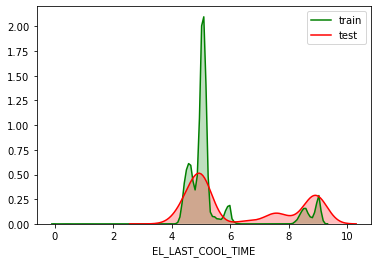

EL_LAST_COOL_TIME


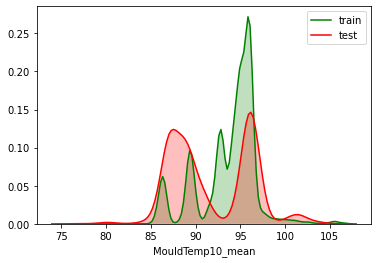

MouldTemp10_mean


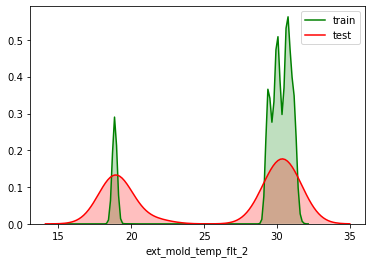

ext_mold_temp_flt_2


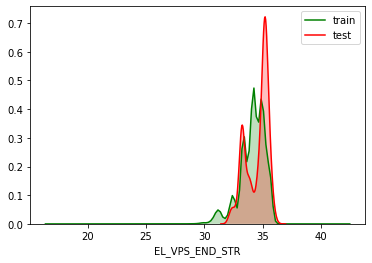

EL_VPS_END_STR


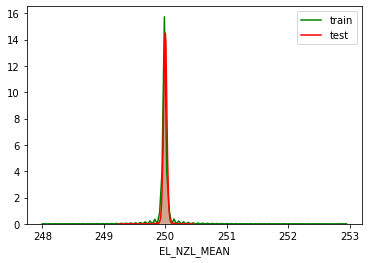

EL_NZL_MEAN


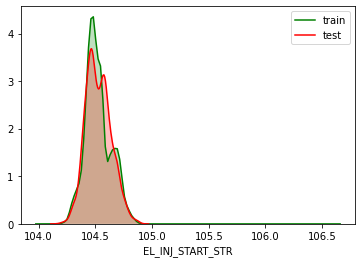

EL_INJ_START_STR


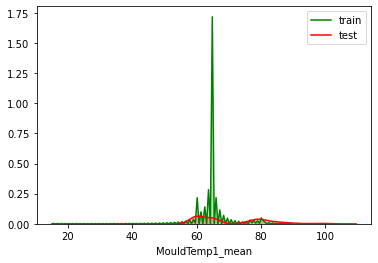

MouldTemp1_mean


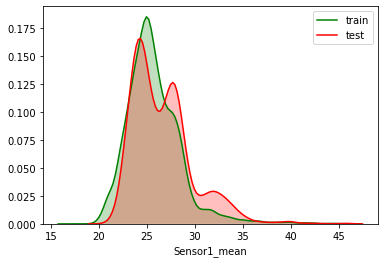

Sensor1_mean


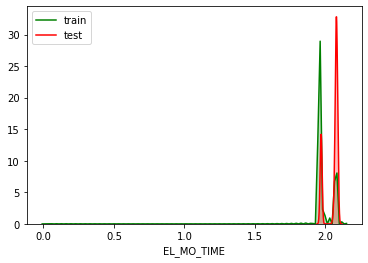

EL_MO_TIME


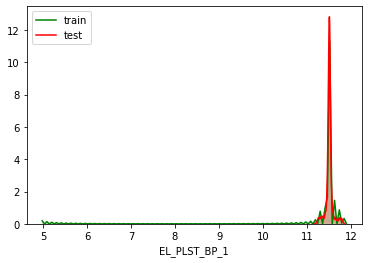

EL_PLST_BP_1


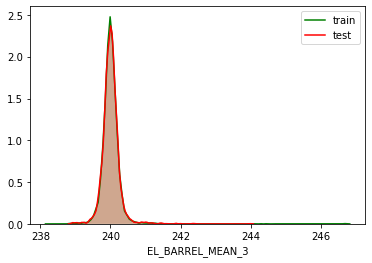

EL_BARREL_MEAN_3


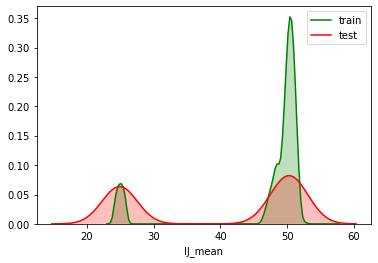

IJ_mean


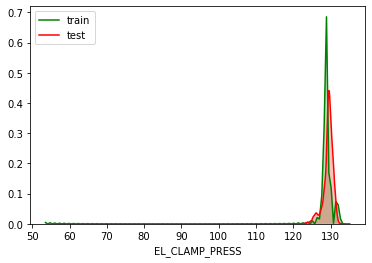

EL_CLAMP_PRESS


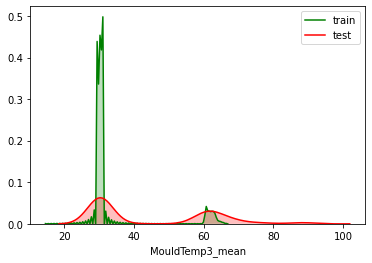

MouldTemp3_mean


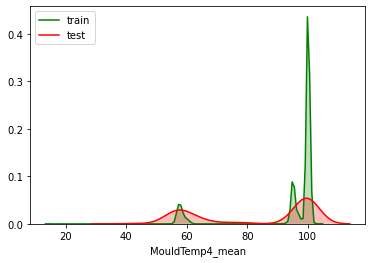

MouldTemp4_mean


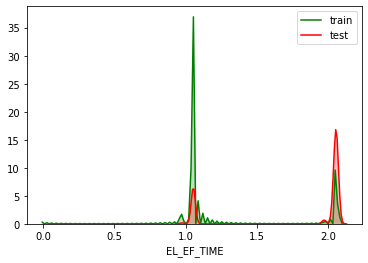

EL_EF_TIME


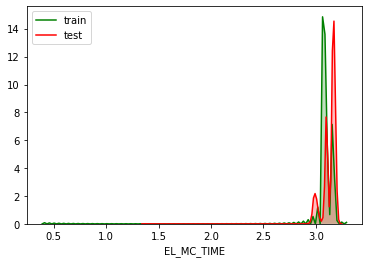

EL_MC_TIME


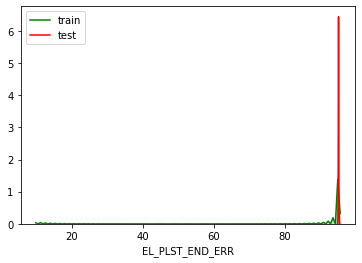

EL_PLST_END_ERR


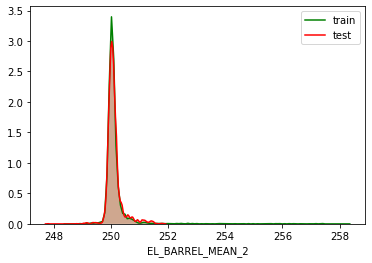

EL_BARREL_MEAN_2


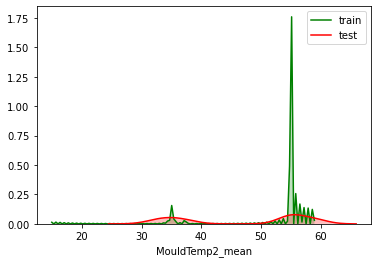

MouldTemp2_mean


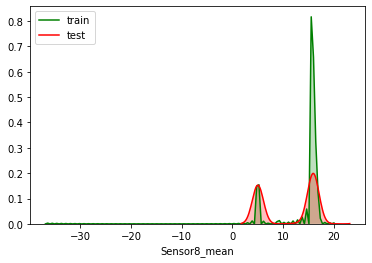

Sensor8_mean


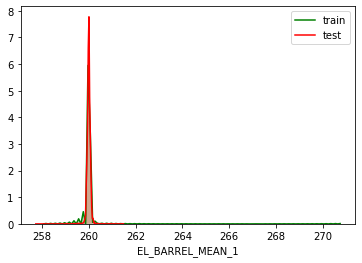

EL_BARREL_MEAN_1


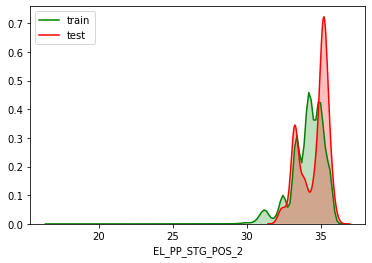

EL_PP_STG_POS_2


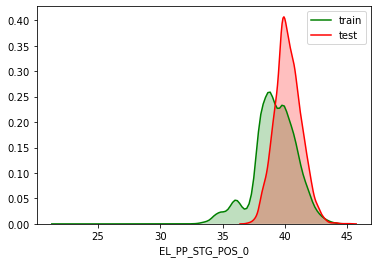

EL_PP_STG_POS_0


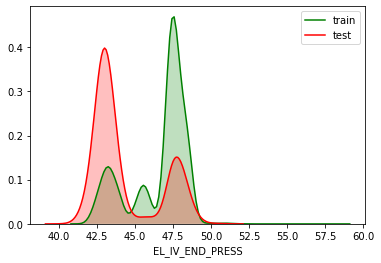

EL_IV_END_PRESS


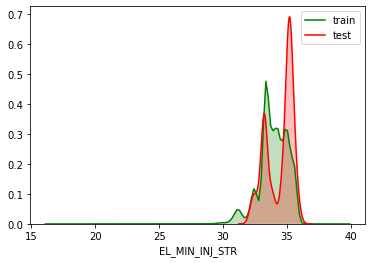

EL_MIN_INJ_STR


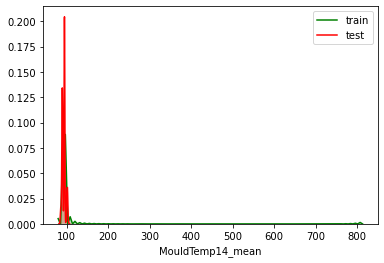

MouldTemp14_mean


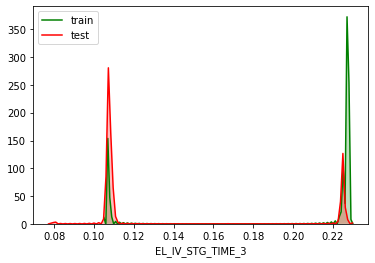

EL_IV_STG_TIME_3


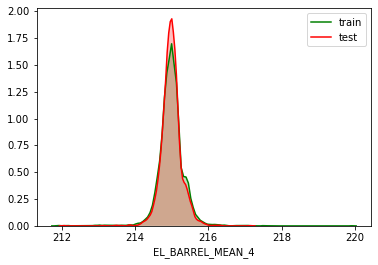

EL_BARREL_MEAN_4


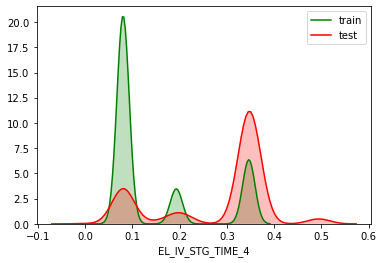

EL_IV_STG_TIME_4


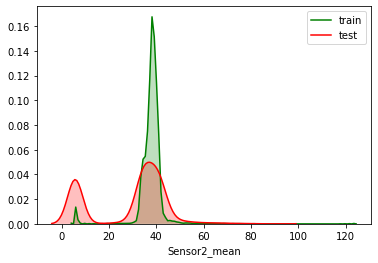

Sensor2_mean


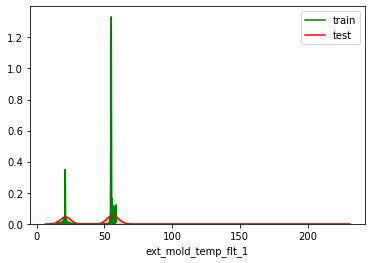

ext_mold_temp_flt_1


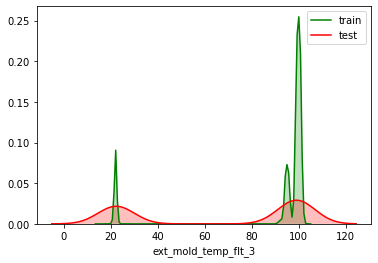

ext_mold_temp_flt_3


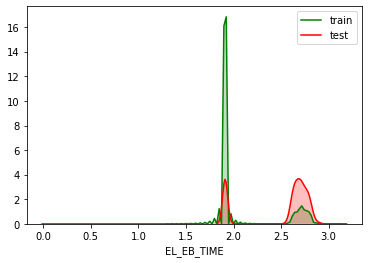

EL_EB_TIME


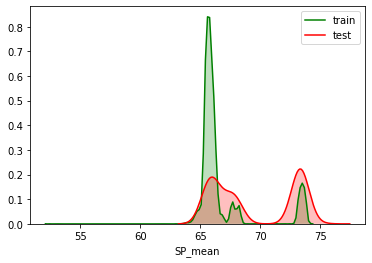

SP_mean


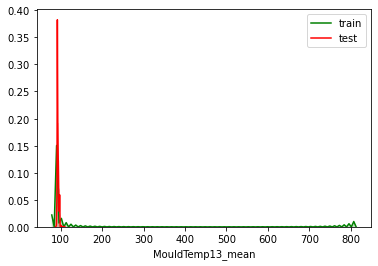

MouldTemp13_mean


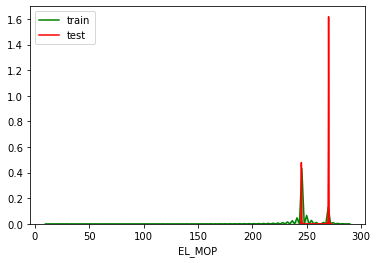

EL_MOP


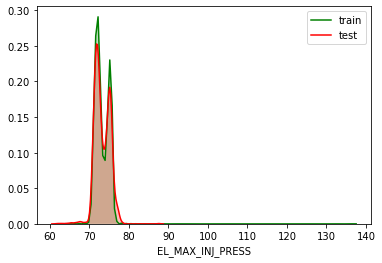

EL_MAX_INJ_PRESS


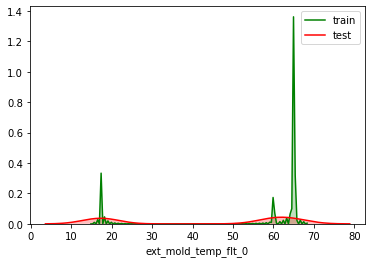

ext_mold_temp_flt_0


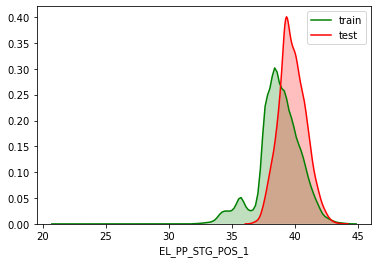

EL_PP_STG_POS_1


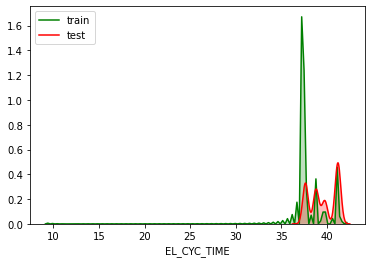

EL_CYC_TIME


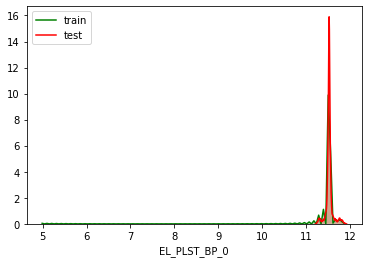

EL_PLST_BP_0


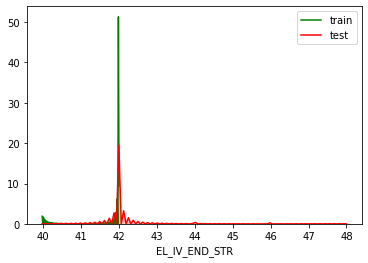

EL_IV_END_STR


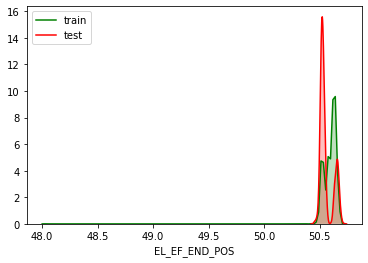

EL_EF_END_POS


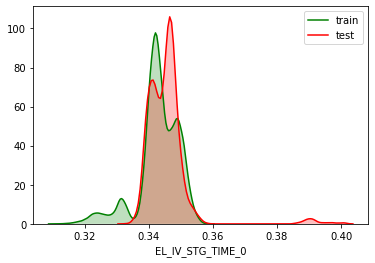

EL_IV_STG_TIME_0


In [145]:
import seaborn as sns

for column in base_mod_col2:

    sns.kdeplot(df_x_train[column], shade=True, color='g')
    sns.kdeplot(df_x_sub[column], shade=True, color='r')
    plt.xlabel(column)
    plt.legend(['train', 'test'])
    plt.show()
    print(column)

In [147]:
base_mod_col3 = ['EL_LAST_COOL_TIME', 
                 'EL_VPS_END_STR', 'EL_INJ_START_STR', 
                 'Sensor1_mean', 'EL_BARREL_MEAN_3',
                 'EL_BARREL_MEAN_2',
                 'Sensor8_mean',
                 'EL_PP_STG_POS_0',
                 'EL_IV_STG_TIME_3', 'EL_BARREL_MEAN_4',
                 'EL_EB_TIME', 'SP_mean',
                 'EL_MAX_INJ_PRESS',
                 'EL_PP_STG_POS_1', 'EL_CYC_TIME',
                 'EL_IV_STG_TIME_0']



In [153]:
sub_concat3=pd.read_csv(path + '/赛题二-初赛/sub_file.csv')
clf_list2 = [ svr_reg, rf_reg, ada_reg, et_reg, xgb_reg, lgb_reg]

for i in ['size1', 'size2', 'size3']:
    print(i)
    pred = stacking_pred(x_train_f116,
                        df_y_train[i],
                        x_sub_f116,
                        kf,
                        clf_list2,
                        label_split=None,
                        clf_fin='lgb',
                        if_concat_origin=True)
    
    # 将starcking函数中，合并origin的列改为16列特征
    sub_concat3[i] = pred

size1
现在第一层的的clf_list [<function svr_reg at 0x7f123c0888c0>]
train.shape: (13280, 116)
test.shape: (3320, 116)
svr now score is: [0.002101953202757704]
train.shape: (13280, 116)
test.shape: (3320, 116)
svr now score is: [0.002101953202757704, 0.0020664967772719726]
train.shape: (13280, 116)
test.shape: (3320, 116)
svr now score is: [0.002101953202757704, 0.0020664967772719726, 0.0020851042813068857]
train.shape: (13280, 116)
test.shape: (3320, 116)
svr now score is: [0.002101953202757704, 0.0020664967772719726, 0.0020851042813068857, 0.0022436334337448496]
train.shape: (13280, 116)
test.shape: (3320, 116)
svr now score is: [0.002101953202757704, 0.0020664967772719726, 0.0020851042813068857, 0.0022436334337448496, 0.002160151739434381]
svr score_list: [0.002101953202757704, 0.0020664967772719726, 0.0020851042813068857, 0.0022436334337448496, 0.002160151739434381]
svr score_mean: 0.0021314678869031587
现在第一层的的clf_list [<function rf_reg at 0x7f123c143b90>]
train.shape: (13280, 116)
test.sh

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266872995]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266872995, 0.00035539442573731653]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266872995, 0.00035539442573731653, 0.0003699287819096262]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266872995, 0.00035539442573731653, 0.0003699287819096262, 0.0004669334479757096]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00037789003266872995, 0.00035539442573731653, 0.0003699287819096262, 0.0004669334479757096, 0.00039197776830897623]
rf score_list: [0.00037789003266872995, 0.00035539442573731653, 0.0003699287819096262, 0.0004669334479757096, 0.00039197776830897623]
rf score_mean: 0.00039242489132007173
现在第一层的的clf_list [<function ada_reg at 0x7f123c143b00>]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666, 0.0007158646451777338]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666, 0.0007158646451777338, 0.0008236486559059149]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0007114219199048602, 0.0007202413319019666, 0.00071586464517

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784604]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784604, 0.0003366225894893947]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784604, 0.0003366225894893947, 0.000356499999808749]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   22.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784604, 0.0003366225894893947, 0.000356499999808749, 0.00044607256205911024]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003468180108784604, 0.0003366225894893947, 0.000356499999808749, 0.00044607256205911024, 0.00037354252524136037]
et score_list: [0.0003468180108784604, 0.0003366225894893947, 0.000356499999808749, 0.00044607256205911024, 0.00037354252524136037]
et score_mean: 0.0003719111374954149
现在第一层的的clf_list [<function xgb_reg at 0x7f1246cac950>]
train.shape: (13280, 116)
test.shape: (3320, 116)
[18:10:42] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:290.58807	eval-rmse:290.58896
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:281.87976	eval-rmse:281.88068
[2]	train-rmse:273.43

[166]	train-rmse:1.86161	eval-rmse:1.86254
[167]	train-rmse:1.80587	eval-rmse:1.80679
[168]	train-rmse:1.75177	eval-rmse:1.75270
[169]	train-rmse:1.69930	eval-rmse:1.70023
[170]	train-rmse:1.64841	eval-rmse:1.64934
[171]	train-rmse:1.59905	eval-rmse:1.59998
[172]	train-rmse:1.55115	eval-rmse:1.55208
[173]	train-rmse:1.50469	eval-rmse:1.50562
[174]	train-rmse:1.45960	eval-rmse:1.46054
[175]	train-rmse:1.41589	eval-rmse:1.41682
[176]	train-rmse:1.37349	eval-rmse:1.37442
[177]	train-rmse:1.33237	eval-rmse:1.33330
[178]	train-rmse:1.29247	eval-rmse:1.29341
[179]	train-rmse:1.25377	eval-rmse:1.25470
[180]	train-rmse:1.21622	eval-rmse:1.21716
[181]	train-rmse:1.17980	eval-rmse:1.18074
[182]	train-rmse:1.14449	eval-rmse:1.14543
[183]	train-rmse:1.11024	eval-rmse:1.11118
[184]	train-rmse:1.07700	eval-rmse:1.07794
[185]	train-rmse:1.04477	eval-rmse:1.04571
[186]	train-rmse:1.01351	eval-rmse:1.01445
[187]	train-rmse:0.98318	eval-rmse:0.98411
[188]	train-rmse:0.95378	eval-rmse:0.95472
[189]	train

[357]	train-rmse:0.03180	eval-rmse:0.03196
[358]	train-rmse:0.03176	eval-rmse:0.03193
[359]	train-rmse:0.03174	eval-rmse:0.03190
[360]	train-rmse:0.03171	eval-rmse:0.03187
[361]	train-rmse:0.03169	eval-rmse:0.03184
[362]	train-rmse:0.03167	eval-rmse:0.03182
[363]	train-rmse:0.03164	eval-rmse:0.03179
[364]	train-rmse:0.03162	eval-rmse:0.03177
[365]	train-rmse:0.03160	eval-rmse:0.03175
[366]	train-rmse:0.03159	eval-rmse:0.03173
[367]	train-rmse:0.03157	eval-rmse:0.03171
[368]	train-rmse:0.03155	eval-rmse:0.03169
[369]	train-rmse:0.03154	eval-rmse:0.03167
[370]	train-rmse:0.03152	eval-rmse:0.03166
[371]	train-rmse:0.03151	eval-rmse:0.03164
[372]	train-rmse:0.03150	eval-rmse:0.03162
[373]	train-rmse:0.03148	eval-rmse:0.03161
[374]	train-rmse:0.03147	eval-rmse:0.03160
[375]	train-rmse:0.03146	eval-rmse:0.03159
[376]	train-rmse:0.03145	eval-rmse:0.03157
[377]	train-rmse:0.03144	eval-rmse:0.03156
[378]	train-rmse:0.03144	eval-rmse:0.03155
[379]	train-rmse:0.03143	eval-rmse:0.03154
[380]	train

[548]	train-rmse:0.03120	eval-rmse:0.03124
[549]	train-rmse:0.03120	eval-rmse:0.03124
[550]	train-rmse:0.03120	eval-rmse:0.03124
[551]	train-rmse:0.03120	eval-rmse:0.03124
[552]	train-rmse:0.03120	eval-rmse:0.03124
[553]	train-rmse:0.03120	eval-rmse:0.03124
[554]	train-rmse:0.03120	eval-rmse:0.03124
[555]	train-rmse:0.03120	eval-rmse:0.03124
[556]	train-rmse:0.03120	eval-rmse:0.03124
[557]	train-rmse:0.03120	eval-rmse:0.03123
[558]	train-rmse:0.03120	eval-rmse:0.03123
[559]	train-rmse:0.03120	eval-rmse:0.03123
[560]	train-rmse:0.03120	eval-rmse:0.03123
[561]	train-rmse:0.03120	eval-rmse:0.03123
[562]	train-rmse:0.03120	eval-rmse:0.03123
[563]	train-rmse:0.03120	eval-rmse:0.03123
[564]	train-rmse:0.03120	eval-rmse:0.03123
[565]	train-rmse:0.03120	eval-rmse:0.03123
[566]	train-rmse:0.03120	eval-rmse:0.03123
[567]	train-rmse:0.03120	eval-rmse:0.03123
[568]	train-rmse:0.03120	eval-rmse:0.03123
[569]	train-rmse:0.03120	eval-rmse:0.03123
[570]	train-rmse:0.03120	eval-rmse:0.03123
[571]	train

[63]	train-rmse:42.73718	eval-rmse:42.73791
[64]	train-rmse:41.45644	eval-rmse:41.45718
[65]	train-rmse:40.21408	eval-rmse:40.21481
[66]	train-rmse:39.00896	eval-rmse:39.00971
[67]	train-rmse:37.83996	eval-rmse:37.84070
[68]	train-rmse:36.70599	eval-rmse:36.70672
[69]	train-rmse:35.60599	eval-rmse:35.60672
[70]	train-rmse:34.53897	eval-rmse:34.53971
[71]	train-rmse:33.50394	eval-rmse:33.50467
[72]	train-rmse:32.49991	eval-rmse:32.50064
[73]	train-rmse:31.52599	eval-rmse:31.52670
[74]	train-rmse:30.58122	eval-rmse:30.58194
[75]	train-rmse:29.66474	eval-rmse:29.66547
[76]	train-rmse:28.77573	eval-rmse:28.77646
[77]	train-rmse:27.91340	eval-rmse:27.91413
[78]	train-rmse:27.07691	eval-rmse:27.07764
[79]	train-rmse:26.26548	eval-rmse:26.26621
[80]	train-rmse:25.47837	eval-rmse:25.47911
[81]	train-rmse:24.71486	eval-rmse:24.71558
[82]	train-rmse:23.97419	eval-rmse:23.97492
[83]	train-rmse:23.25575	eval-rmse:23.25648
[84]	train-rmse:22.55882	eval-rmse:22.55955
[85]	train-rmse:21.88279	eval-rm

[253]	train-rmse:0.13606	eval-rmse:0.13657
[254]	train-rmse:0.13222	eval-rmse:0.13272
[255]	train-rmse:0.12849	eval-rmse:0.12899
[256]	train-rmse:0.12490	eval-rmse:0.12539
[257]	train-rmse:0.12139	eval-rmse:0.12189
[258]	train-rmse:0.11802	eval-rmse:0.11851
[259]	train-rmse:0.11476	eval-rmse:0.11525
[260]	train-rmse:0.11158	eval-rmse:0.11205
[261]	train-rmse:0.10852	eval-rmse:0.10899
[262]	train-rmse:0.10554	eval-rmse:0.10600
[263]	train-rmse:0.10267	eval-rmse:0.10312
[264]	train-rmse:0.09989	eval-rmse:0.10034
[265]	train-rmse:0.09720	eval-rmse:0.09763
[266]	train-rmse:0.09461	eval-rmse:0.09503
[267]	train-rmse:0.09212	eval-rmse:0.09254
[268]	train-rmse:0.08969	eval-rmse:0.09010
[269]	train-rmse:0.08736	eval-rmse:0.08777
[270]	train-rmse:0.08507	eval-rmse:0.08547
[271]	train-rmse:0.08290	eval-rmse:0.08329
[272]	train-rmse:0.08074	eval-rmse:0.08113
[273]	train-rmse:0.07870	eval-rmse:0.07909
[274]	train-rmse:0.07673	eval-rmse:0.07710
[275]	train-rmse:0.07479	eval-rmse:0.07515
[276]	train

[444]	train-rmse:0.03138	eval-rmse:0.03094
[445]	train-rmse:0.03138	eval-rmse:0.03094
[446]	train-rmse:0.03138	eval-rmse:0.03094
[447]	train-rmse:0.03138	eval-rmse:0.03094
[448]	train-rmse:0.03138	eval-rmse:0.03093
[449]	train-rmse:0.03138	eval-rmse:0.03093
[450]	train-rmse:0.03138	eval-rmse:0.03093
[451]	train-rmse:0.03138	eval-rmse:0.03093
[452]	train-rmse:0.03138	eval-rmse:0.03093
[453]	train-rmse:0.03138	eval-rmse:0.03093
[454]	train-rmse:0.03138	eval-rmse:0.03093
[455]	train-rmse:0.03138	eval-rmse:0.03093
[456]	train-rmse:0.03138	eval-rmse:0.03093
[457]	train-rmse:0.03138	eval-rmse:0.03093
[458]	train-rmse:0.03138	eval-rmse:0.03093
[459]	train-rmse:0.03138	eval-rmse:0.03093
[460]	train-rmse:0.03138	eval-rmse:0.03093
[461]	train-rmse:0.03138	eval-rmse:0.03093
[462]	train-rmse:0.03138	eval-rmse:0.03093
[463]	train-rmse:0.03138	eval-rmse:0.03093
[464]	train-rmse:0.03138	eval-rmse:0.03093
[465]	train-rmse:0.03138	eval-rmse:0.03093
[466]	train-rmse:0.03138	eval-rmse:0.03093
[467]	train

[635]	train-rmse:0.03128	eval-rmse:0.03081
[636]	train-rmse:0.03128	eval-rmse:0.03081
[637]	train-rmse:0.03128	eval-rmse:0.03081
[638]	train-rmse:0.03128	eval-rmse:0.03081
[639]	train-rmse:0.03128	eval-rmse:0.03081
[640]	train-rmse:0.03128	eval-rmse:0.03081
[641]	train-rmse:0.03128	eval-rmse:0.03081
[642]	train-rmse:0.03128	eval-rmse:0.03081
[643]	train-rmse:0.03128	eval-rmse:0.03081
[644]	train-rmse:0.03128	eval-rmse:0.03081
[645]	train-rmse:0.03128	eval-rmse:0.03081
[646]	train-rmse:0.03128	eval-rmse:0.03081
[647]	train-rmse:0.03128	eval-rmse:0.03081
[648]	train-rmse:0.03128	eval-rmse:0.03081
[649]	train-rmse:0.03128	eval-rmse:0.03081
[650]	train-rmse:0.03128	eval-rmse:0.03081
[651]	train-rmse:0.03128	eval-rmse:0.03081
[652]	train-rmse:0.03128	eval-rmse:0.03081
[653]	train-rmse:0.03128	eval-rmse:0.03081
[654]	train-rmse:0.03128	eval-rmse:0.03081
[655]	train-rmse:0.03128	eval-rmse:0.03081
[656]	train-rmse:0.03128	eval-rmse:0.03081
[657]	train-rmse:0.03128	eval-rmse:0.03081
[658]	train

[104]	train-rmse:12.27560	eval-rmse:12.27521
[105]	train-rmse:11.90774	eval-rmse:11.90735
[106]	train-rmse:11.55090	eval-rmse:11.55051
[107]	train-rmse:11.20478	eval-rmse:11.20438
[108]	train-rmse:10.86899	eval-rmse:10.86860
[109]	train-rmse:10.54328	eval-rmse:10.54289
[110]	train-rmse:10.22734	eval-rmse:10.22694
[111]	train-rmse:9.92085	eval-rmse:9.92046
[112]	train-rmse:9.62355	eval-rmse:9.62316
[113]	train-rmse:9.33516	eval-rmse:9.33477
[114]	train-rmse:9.05541	eval-rmse:9.05501
[115]	train-rmse:8.78405	eval-rmse:8.78366
[116]	train-rmse:8.52081	eval-rmse:8.52041
[117]	train-rmse:8.26547	eval-rmse:8.26508
[118]	train-rmse:8.01777	eval-rmse:8.01737
[119]	train-rmse:7.77750	eval-rmse:7.77711
[120]	train-rmse:7.54444	eval-rmse:7.54405
[121]	train-rmse:7.31837	eval-rmse:7.31798
[122]	train-rmse:7.09908	eval-rmse:7.09868
[123]	train-rmse:6.88634	eval-rmse:6.88595
[124]	train-rmse:6.67999	eval-rmse:6.67959
[125]	train-rmse:6.47983	eval-rmse:6.47943
[126]	train-rmse:6.28565	eval-rmse:6.285

[295]	train-rmse:0.04854	eval-rmse:0.04794
[296]	train-rmse:0.04771	eval-rmse:0.04711
[297]	train-rmse:0.04691	eval-rmse:0.04630
[298]	train-rmse:0.04615	eval-rmse:0.04553
[299]	train-rmse:0.04542	eval-rmse:0.04480
[300]	train-rmse:0.04473	eval-rmse:0.04409
[301]	train-rmse:0.04406	eval-rmse:0.04342
[302]	train-rmse:0.04343	eval-rmse:0.04278
[303]	train-rmse:0.04273	eval-rmse:0.04209
[304]	train-rmse:0.04216	eval-rmse:0.04151
[305]	train-rmse:0.04160	eval-rmse:0.04094
[306]	train-rmse:0.04106	eval-rmse:0.04040
[307]	train-rmse:0.04056	eval-rmse:0.03989
[308]	train-rmse:0.04008	eval-rmse:0.03941
[309]	train-rmse:0.03963	eval-rmse:0.03896
[310]	train-rmse:0.03919	eval-rmse:0.03851
[311]	train-rmse:0.03878	eval-rmse:0.03809
[312]	train-rmse:0.03839	eval-rmse:0.03770
[313]	train-rmse:0.03801	eval-rmse:0.03731
[314]	train-rmse:0.03766	eval-rmse:0.03695
[315]	train-rmse:0.03733	eval-rmse:0.03662
[316]	train-rmse:0.03700	eval-rmse:0.03629
[317]	train-rmse:0.03670	eval-rmse:0.03599
[318]	train

[486]	train-rmse:0.03121	eval-rmse:0.03046
[487]	train-rmse:0.03121	eval-rmse:0.03046
[488]	train-rmse:0.03121	eval-rmse:0.03046
[489]	train-rmse:0.03121	eval-rmse:0.03046
[490]	train-rmse:0.03121	eval-rmse:0.03046
[491]	train-rmse:0.03121	eval-rmse:0.03046
[492]	train-rmse:0.03121	eval-rmse:0.03046
[493]	train-rmse:0.03121	eval-rmse:0.03046
[494]	train-rmse:0.03121	eval-rmse:0.03046
[495]	train-rmse:0.03121	eval-rmse:0.03046
[496]	train-rmse:0.03121	eval-rmse:0.03046
[497]	train-rmse:0.03121	eval-rmse:0.03046
[498]	train-rmse:0.03121	eval-rmse:0.03046
[499]	train-rmse:0.03121	eval-rmse:0.03046
[500]	train-rmse:0.03121	eval-rmse:0.03046
[501]	train-rmse:0.03121	eval-rmse:0.03046
[502]	train-rmse:0.03121	eval-rmse:0.03046
[503]	train-rmse:0.03121	eval-rmse:0.03046
[504]	train-rmse:0.03121	eval-rmse:0.03046
[505]	train-rmse:0.03121	eval-rmse:0.03046
[506]	train-rmse:0.03121	eval-rmse:0.03046
[507]	train-rmse:0.03121	eval-rmse:0.03046
[508]	train-rmse:0.03121	eval-rmse:0.03046
[509]	train

[106]	train-rmse:11.55079	eval-rmse:11.55080
[107]	train-rmse:11.20467	eval-rmse:11.20467
[108]	train-rmse:10.86888	eval-rmse:10.86889
[109]	train-rmse:10.54317	eval-rmse:10.54318
[110]	train-rmse:10.22723	eval-rmse:10.22724
[111]	train-rmse:9.92074	eval-rmse:9.92075
[112]	train-rmse:9.62344	eval-rmse:9.62345
[113]	train-rmse:9.33505	eval-rmse:9.33506
[114]	train-rmse:9.05533	eval-rmse:9.05534
[115]	train-rmse:8.78397	eval-rmse:8.78398
[116]	train-rmse:8.52073	eval-rmse:8.52074
[117]	train-rmse:8.26539	eval-rmse:8.26540
[118]	train-rmse:8.01772	eval-rmse:8.01773
[119]	train-rmse:7.77745	eval-rmse:7.77746
[120]	train-rmse:7.54439	eval-rmse:7.54441
[121]	train-rmse:7.31832	eval-rmse:7.31834
[122]	train-rmse:7.09900	eval-rmse:7.09901
[123]	train-rmse:6.88626	eval-rmse:6.88628
[124]	train-rmse:6.67990	eval-rmse:6.67992
[125]	train-rmse:6.47974	eval-rmse:6.47976
[126]	train-rmse:6.28557	eval-rmse:6.28558
[127]	train-rmse:6.09718	eval-rmse:6.09720
[128]	train-rmse:5.91448	eval-rmse:5.91449
[

[297]	train-rmse:0.04647	eval-rmse:0.04781
[298]	train-rmse:0.04570	eval-rmse:0.04706
[299]	train-rmse:0.04496	eval-rmse:0.04635
[300]	train-rmse:0.04426	eval-rmse:0.04568
[301]	train-rmse:0.04359	eval-rmse:0.04503
[302]	train-rmse:0.04295	eval-rmse:0.04441
[303]	train-rmse:0.04232	eval-rmse:0.04381
[304]	train-rmse:0.04172	eval-rmse:0.04324
[305]	train-rmse:0.04118	eval-rmse:0.04271
[306]	train-rmse:0.04064	eval-rmse:0.04219
[307]	train-rmse:0.04013	eval-rmse:0.04171
[308]	train-rmse:0.03965	eval-rmse:0.04125
[309]	train-rmse:0.03920	eval-rmse:0.04081
[310]	train-rmse:0.03875	eval-rmse:0.04039
[311]	train-rmse:0.03833	eval-rmse:0.03999
[312]	train-rmse:0.03794	eval-rmse:0.03962
[313]	train-rmse:0.03758	eval-rmse:0.03927
[314]	train-rmse:0.03722	eval-rmse:0.03893
[315]	train-rmse:0.03688	eval-rmse:0.03861
[316]	train-rmse:0.03655	eval-rmse:0.03830
[317]	train-rmse:0.03625	eval-rmse:0.03802
[318]	train-rmse:0.03587	eval-rmse:0.03766
[319]	train-rmse:0.03560	eval-rmse:0.03740
[320]	train

[488]	train-rmse:0.03069	eval-rmse:0.03285
[489]	train-rmse:0.03069	eval-rmse:0.03285
[490]	train-rmse:0.03069	eval-rmse:0.03285
[491]	train-rmse:0.03069	eval-rmse:0.03285
[492]	train-rmse:0.03069	eval-rmse:0.03285
[493]	train-rmse:0.03069	eval-rmse:0.03285
[494]	train-rmse:0.03069	eval-rmse:0.03285
[495]	train-rmse:0.03069	eval-rmse:0.03285
[496]	train-rmse:0.03069	eval-rmse:0.03285
[497]	train-rmse:0.03069	eval-rmse:0.03285
[498]	train-rmse:0.03069	eval-rmse:0.03285
[499]	train-rmse:0.03069	eval-rmse:0.03285
[500]	train-rmse:0.03069	eval-rmse:0.03285
[501]	train-rmse:0.03069	eval-rmse:0.03285
[502]	train-rmse:0.03069	eval-rmse:0.03285
[503]	train-rmse:0.03069	eval-rmse:0.03285
[504]	train-rmse:0.03069	eval-rmse:0.03285
[505]	train-rmse:0.03069	eval-rmse:0.03285
[506]	train-rmse:0.03069	eval-rmse:0.03285
[507]	train-rmse:0.03069	eval-rmse:0.03285
[508]	train-rmse:0.03069	eval-rmse:0.03285
[509]	train-rmse:0.03069	eval-rmse:0.03285
[510]	train-rmse:0.03069	eval-rmse:0.03285
[511]	train

[109]	train-rmse:10.54324	eval-rmse:10.54197
[110]	train-rmse:10.22730	eval-rmse:10.22603
[111]	train-rmse:9.92081	eval-rmse:9.91954
[112]	train-rmse:9.62351	eval-rmse:9.62224
[113]	train-rmse:9.33512	eval-rmse:9.33385
[114]	train-rmse:9.05537	eval-rmse:9.05410
[115]	train-rmse:8.78401	eval-rmse:8.78274
[116]	train-rmse:8.52077	eval-rmse:8.51950
[117]	train-rmse:8.26543	eval-rmse:8.26416
[118]	train-rmse:8.01776	eval-rmse:8.01648
[119]	train-rmse:7.77750	eval-rmse:7.77622
[120]	train-rmse:7.54444	eval-rmse:7.54316
[121]	train-rmse:7.31836	eval-rmse:7.31709
[122]	train-rmse:7.09904	eval-rmse:7.09776
[123]	train-rmse:6.88630	eval-rmse:6.88503
[124]	train-rmse:6.67995	eval-rmse:6.67867
[125]	train-rmse:6.47976	eval-rmse:6.47848
[126]	train-rmse:6.28558	eval-rmse:6.28430
[127]	train-rmse:6.09720	eval-rmse:6.09592
[128]	train-rmse:5.91449	eval-rmse:5.91322
[129]	train-rmse:5.73725	eval-rmse:5.73598
[130]	train-rmse:5.56532	eval-rmse:5.56404
[131]	train-rmse:5.39855	eval-rmse:5.39727
[132]	t

[300]	train-rmse:0.04446	eval-rmse:0.04344
[301]	train-rmse:0.04379	eval-rmse:0.04277
[302]	train-rmse:0.04315	eval-rmse:0.04214
[303]	train-rmse:0.04252	eval-rmse:0.04152
[304]	train-rmse:0.04195	eval-rmse:0.04094
[305]	train-rmse:0.04140	eval-rmse:0.04040
[306]	train-rmse:0.04086	eval-rmse:0.03987
[307]	train-rmse:0.04036	eval-rmse:0.03937
[308]	train-rmse:0.03988	eval-rmse:0.03889
[309]	train-rmse:0.03943	eval-rmse:0.03845
[310]	train-rmse:0.03898	eval-rmse:0.03801
[311]	train-rmse:0.03857	eval-rmse:0.03760
[312]	train-rmse:0.03818	eval-rmse:0.03722
[313]	train-rmse:0.03779	eval-rmse:0.03684
[314]	train-rmse:0.03744	eval-rmse:0.03649
[315]	train-rmse:0.03710	eval-rmse:0.03616
[316]	train-rmse:0.03678	eval-rmse:0.03584
[317]	train-rmse:0.03647	eval-rmse:0.03555
[318]	train-rmse:0.03618	eval-rmse:0.03526
[319]	train-rmse:0.03590	eval-rmse:0.03499
[320]	train-rmse:0.03565	eval-rmse:0.03474
[321]	train-rmse:0.03540	eval-rmse:0.03450
[322]	train-rmse:0.03517	eval-rmse:0.03428
[323]	train

[491]	train-rmse:0.03101	eval-rmse:0.03053
[492]	train-rmse:0.03101	eval-rmse:0.03053
[493]	train-rmse:0.03101	eval-rmse:0.03053
[494]	train-rmse:0.03101	eval-rmse:0.03053
[495]	train-rmse:0.03101	eval-rmse:0.03053
[496]	train-rmse:0.03101	eval-rmse:0.03053
[497]	train-rmse:0.03101	eval-rmse:0.03053
[498]	train-rmse:0.03101	eval-rmse:0.03053
[499]	train-rmse:0.03101	eval-rmse:0.03053
[500]	train-rmse:0.03101	eval-rmse:0.03053
[501]	train-rmse:0.03101	eval-rmse:0.03053
[502]	train-rmse:0.03101	eval-rmse:0.03053
[503]	train-rmse:0.03101	eval-rmse:0.03053
[504]	train-rmse:0.03101	eval-rmse:0.03053
[505]	train-rmse:0.03101	eval-rmse:0.03053
[506]	train-rmse:0.03101	eval-rmse:0.03053
[507]	train-rmse:0.03101	eval-rmse:0.03053
[508]	train-rmse:0.03101	eval-rmse:0.03053
[509]	train-rmse:0.03101	eval-rmse:0.03053
[510]	train-rmse:0.03101	eval-rmse:0.03053
[511]	train-rmse:0.03101	eval-rmse:0.03053
[512]	train-rmse:0.03101	eval-rmse:0.03053
[513]	train-rmse:0.03101	eval-rmse:0.03053
[514]	train

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[50]	valid_0's l2: 0.000425272
[100]	valid_0's l2: 0.000400561
[150]	valid_0's l2: 0.00039742
[200]	valid_0's l2: 0.000396112
[250]	valid_0's l2: 0.00039528
[300]	valid_0's l2: 0.000393798
[350]	valid_0's l2: 0.000393019
Early stopping, best iteration is:
[344]	valid_0's l2: 0.00039283
[60.01143184 60.01254415 60.01266306 ... 59.991315   59.99353077
 60.004138  ]
fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9654
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 45
[LightGBM] [Info] Start training from score 300.065374
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000422255
[100]	valid_0's l2: 0.000391217
[150]	valid_0's l2: 0.000388337
[200]	valid_0's l2: 0.000388467
Early stopping, best iteration is:
[184]	valid_0's l2: 0.000387769
[120.02328946 120.0249857

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00036059512170690704]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00036059512170690704, 0.00036196555646341924]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00036059512170690704, 0.00036196555646341924, 0.00039044556549302676]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00036059512170690704, 0.00036196555646341924, 0.00039044556549302676, 0.000360864630326932]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

rf now score is: [0.00036059512170690704, 0.00036196555646341924, 0.00039044556549302676, 0.000360864630326932, 0.00039386172940217154]
rf score_list: [0.00036059512170690704, 0.00036196555646341924, 0.00039044556549302676, 0.000360864630326932, 0.00039386172940217154]
rf score_mean: 0.0003735465206784913
现在第一层的的clf_list [<function ada_reg at 0x7f123c143b00>]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312, 0.0006958022511861151]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312, 0.0006958022511861151, 0.0006671745296294653]
train.shape: (13280, 116)
test.shape: (3320, 116)
ada now score is: [0.0006890522150545086, 0.0006846483179637312, 0.000695802251186

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003478163328172201]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003478163328172201, 0.0003455099241709872]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003478163328172201, 0.0003455099241709872, 0.0003785775625413537]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed: 

et now score is: [0.0003478163328172201, 0.0003455099241709872, 0.0003785775625413537, 0.0003509933316339222]
train.shape: (13280, 116)
test.shape: (3320, 116)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


et now score is: [0.0003478163328172201, 0.0003455099241709872, 0.0003785775625413537, 0.0003509933316339222, 0.00038240290682190435]
et score_list: [0.0003478163328172201, 0.0003455099241709872, 0.0003785775625413537, 0.0003509933316339222, 0.00038240290682190435]
et score_mean: 0.0003610600115970776
现在第一层的的clf_list [<function xgb_reg at 0x7f1246cac950>]
train.shape: (13280, 116)
test.shape: (3320, 116)
[18:31:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52684	eval-rmse:193.52643
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72725	eval-rmse:187.72687
[2]	train-rmse:182.10

[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.4s finished


[16]	train-rmse:118.93790	eval-rmse:118.93752
[17]	train-rmse:115.37360	eval-rmse:115.37322
[18]	train-rmse:111.91609	eval-rmse:111.91570
[19]	train-rmse:108.56223	eval-rmse:108.56186
[20]	train-rmse:105.30885	eval-rmse:105.30846
[21]	train-rmse:102.15299	eval-rmse:102.15260
[22]	train-rmse:99.09171	eval-rmse:99.09132
[23]	train-rmse:96.12219	eval-rmse:96.12177
[24]	train-rmse:93.24158	eval-rmse:93.24120
[25]	train-rmse:90.44734	eval-rmse:90.44694
[26]	train-rmse:87.73686	eval-rmse:87.73646
[27]	train-rmse:85.10755	eval-rmse:85.10716
[28]	train-rmse:82.55706	eval-rmse:82.55668
[29]	train-rmse:80.08302	eval-rmse:80.08263
[30]	train-rmse:77.68309	eval-rmse:77.68269
[31]	train-rmse:75.35510	eval-rmse:75.35471
[32]	train-rmse:73.09687	eval-rmse:73.09648
[33]	train-rmse:70.90631	eval-rmse:70.90591
[34]	train-rmse:68.78141	eval-rmse:68.78103
[35]	train-rmse:66.72013	eval-rmse:66.71976
[36]	train-rmse:64.72073	eval-rmse:64.72033
[37]	train-rmse:62.78124	eval-rmse:62.78083
[38]	train-rmse:60.8

[205]	train-rmse:0.38050	eval-rmse:0.38058
[206]	train-rmse:0.36918	eval-rmse:0.36927
[207]	train-rmse:0.35820	eval-rmse:0.35830
[208]	train-rmse:0.34757	eval-rmse:0.34768
[209]	train-rmse:0.33724	eval-rmse:0.33736
[210]	train-rmse:0.32723	eval-rmse:0.32735
[211]	train-rmse:0.31753	eval-rmse:0.31766
[212]	train-rmse:0.30811	eval-rmse:0.30824
[213]	train-rmse:0.29897	eval-rmse:0.29911
[214]	train-rmse:0.29012	eval-rmse:0.29027
[215]	train-rmse:0.28152	eval-rmse:0.28168
[216]	train-rmse:0.27321	eval-rmse:0.27337
[217]	train-rmse:0.26513	eval-rmse:0.26531
[218]	train-rmse:0.25729	eval-rmse:0.25748
[219]	train-rmse:0.24968	eval-rmse:0.24988
[220]	train-rmse:0.24231	eval-rmse:0.24253
[221]	train-rmse:0.23517	eval-rmse:0.23540
[222]	train-rmse:0.22824	eval-rmse:0.22848
[223]	train-rmse:0.22151	eval-rmse:0.22177
[224]	train-rmse:0.21500	eval-rmse:0.21527
[225]	train-rmse:0.20868	eval-rmse:0.20895
[226]	train-rmse:0.20255	eval-rmse:0.20283
[227]	train-rmse:0.19660	eval-rmse:0.19688
[228]	train

[396]	train-rmse:0.02850	eval-rmse:0.02915
[397]	train-rmse:0.02850	eval-rmse:0.02915
[398]	train-rmse:0.02850	eval-rmse:0.02915
[399]	train-rmse:0.02850	eval-rmse:0.02915
[400]	train-rmse:0.02850	eval-rmse:0.02915
[401]	train-rmse:0.02850	eval-rmse:0.02915
[402]	train-rmse:0.02850	eval-rmse:0.02915
[403]	train-rmse:0.02850	eval-rmse:0.02915
[404]	train-rmse:0.02850	eval-rmse:0.02915
[405]	train-rmse:0.02849	eval-rmse:0.02914
[406]	train-rmse:0.02849	eval-rmse:0.02914
[407]	train-rmse:0.02849	eval-rmse:0.02914
[408]	train-rmse:0.02849	eval-rmse:0.02914
[409]	train-rmse:0.02849	eval-rmse:0.02914
[410]	train-rmse:0.02849	eval-rmse:0.02914
[411]	train-rmse:0.02849	eval-rmse:0.02914
[412]	train-rmse:0.02849	eval-rmse:0.02914
[413]	train-rmse:0.02849	eval-rmse:0.02914
[414]	train-rmse:0.02849	eval-rmse:0.02914
[415]	train-rmse:0.02849	eval-rmse:0.02914
[416]	train-rmse:0.02849	eval-rmse:0.02914
[417]	train-rmse:0.02849	eval-rmse:0.02914
[418]	train-rmse:0.02849	eval-rmse:0.02914
[419]	train

[587]	train-rmse:0.02848	eval-rmse:0.02913
[588]	train-rmse:0.02848	eval-rmse:0.02913
[589]	train-rmse:0.02848	eval-rmse:0.02913
[590]	train-rmse:0.02848	eval-rmse:0.02913
Stopping. Best iteration:
[490]	train-rmse:0.02848	eval-rmse:0.02913

xgb now score is: [0.0008482905027121538]
train.shape: (13280, 116)
test.shape: (3320, 116)
[18:31:19] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:193.52681	eval-rmse:193.52667
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:187.72719	eval-rmse:187.72710
[2]	train-rmse:182.10141	eval-rmse:182.10133
[3]	train-rmse:176.64429	eval-rmse:176.64418
[4]	t

[169]	train-rmse:1.13254	eval-rmse:1.13239
[170]	train-rmse:1.09866	eval-rmse:1.09851
[171]	train-rmse:1.06582	eval-rmse:1.06567
[172]	train-rmse:1.03396	eval-rmse:1.03381
[173]	train-rmse:1.00304	eval-rmse:1.00289
[174]	train-rmse:0.97305	eval-rmse:0.97289
[175]	train-rmse:0.94397	eval-rmse:0.94380
[176]	train-rmse:0.91575	eval-rmse:0.91558
[177]	train-rmse:0.88838	eval-rmse:0.88821
[178]	train-rmse:0.86183	eval-rmse:0.86166
[179]	train-rmse:0.83609	eval-rmse:0.83591
[180]	train-rmse:0.81110	eval-rmse:0.81092
[181]	train-rmse:0.78687	eval-rmse:0.78669
[182]	train-rmse:0.76336	eval-rmse:0.76319
[183]	train-rmse:0.74057	eval-rmse:0.74039
[184]	train-rmse:0.71845	eval-rmse:0.71827
[185]	train-rmse:0.69698	eval-rmse:0.69680
[186]	train-rmse:0.67618	eval-rmse:0.67600
[187]	train-rmse:0.65599	eval-rmse:0.65581
[188]	train-rmse:0.63641	eval-rmse:0.63623
[189]	train-rmse:0.61741	eval-rmse:0.61722
[190]	train-rmse:0.59897	eval-rmse:0.59876
[191]	train-rmse:0.58109	eval-rmse:0.58089
[192]	train

[360]	train-rmse:0.02876	eval-rmse:0.02839
[361]	train-rmse:0.02874	eval-rmse:0.02838
[362]	train-rmse:0.02873	eval-rmse:0.02837
[363]	train-rmse:0.02872	eval-rmse:0.02836
[364]	train-rmse:0.02871	eval-rmse:0.02835
[365]	train-rmse:0.02870	eval-rmse:0.02834
[366]	train-rmse:0.02869	eval-rmse:0.02834
[367]	train-rmse:0.02869	eval-rmse:0.02833
[368]	train-rmse:0.02868	eval-rmse:0.02832
[369]	train-rmse:0.02867	eval-rmse:0.02831
[370]	train-rmse:0.02866	eval-rmse:0.02831
[371]	train-rmse:0.02866	eval-rmse:0.02830
[372]	train-rmse:0.02865	eval-rmse:0.02830
[373]	train-rmse:0.02865	eval-rmse:0.02829
[374]	train-rmse:0.02864	eval-rmse:0.02829
[375]	train-rmse:0.02864	eval-rmse:0.02828
[376]	train-rmse:0.02863	eval-rmse:0.02828
[377]	train-rmse:0.02863	eval-rmse:0.02828
[378]	train-rmse:0.02862	eval-rmse:0.02827
[379]	train-rmse:0.02862	eval-rmse:0.02827
[380]	train-rmse:0.02861	eval-rmse:0.02827
[381]	train-rmse:0.02861	eval-rmse:0.02826
[382]	train-rmse:0.02861	eval-rmse:0.02826
[383]	train

[1]	train-rmse:187.72693	eval-rmse:187.72821
[2]	train-rmse:182.10117	eval-rmse:182.10245
[3]	train-rmse:176.64407	eval-rmse:176.64529
[4]	train-rmse:171.35046	eval-rmse:171.35169
[5]	train-rmse:166.21549	eval-rmse:166.21670
[6]	train-rmse:161.23434	eval-rmse:161.23560
[7]	train-rmse:156.40251	eval-rmse:156.40378
[8]	train-rmse:151.71550	eval-rmse:151.71677
[9]	train-rmse:147.16899	eval-rmse:147.17024
[10]	train-rmse:142.75868	eval-rmse:142.75987
[11]	train-rmse:138.48048	eval-rmse:138.48172
[12]	train-rmse:134.33058	eval-rmse:134.33182
[13]	train-rmse:130.30495	eval-rmse:130.30620
[14]	train-rmse:126.39997	eval-rmse:126.40125
[15]	train-rmse:122.61208	eval-rmse:122.61333
[16]	train-rmse:118.93771	eval-rmse:118.93896
[17]	train-rmse:115.37342	eval-rmse:115.37466
[18]	train-rmse:111.91592	eval-rmse:111.91717
[19]	train-rmse:108.56206	eval-rmse:108.56331
[20]	train-rmse:105.30866	eval-rmse:105.30991
[21]	train-rmse:102.15281	eval-rmse:102.15407
[22]	train-rmse:99.09154	eval-rmse:99.09279

[189]	train-rmse:0.61745	eval-rmse:0.61848
[190]	train-rmse:0.59901	eval-rmse:0.60003
[191]	train-rmse:0.58114	eval-rmse:0.58216
[192]	train-rmse:0.56380	eval-rmse:0.56481
[193]	train-rmse:0.54699	eval-rmse:0.54799
[194]	train-rmse:0.53067	eval-rmse:0.53166
[195]	train-rmse:0.51484	eval-rmse:0.51583
[196]	train-rmse:0.49950	eval-rmse:0.50048
[197]	train-rmse:0.48461	eval-rmse:0.48557
[198]	train-rmse:0.47016	eval-rmse:0.47113
[199]	train-rmse:0.45617	eval-rmse:0.45712
[200]	train-rmse:0.44258	eval-rmse:0.44352
[201]	train-rmse:0.42941	eval-rmse:0.43034
[202]	train-rmse:0.41664	eval-rmse:0.41757
[203]	train-rmse:0.40423	eval-rmse:0.40516
[204]	train-rmse:0.39220	eval-rmse:0.39312
[205]	train-rmse:0.38053	eval-rmse:0.38144
[206]	train-rmse:0.36922	eval-rmse:0.37012
[207]	train-rmse:0.35826	eval-rmse:0.35916
[208]	train-rmse:0.34761	eval-rmse:0.34851
[209]	train-rmse:0.33729	eval-rmse:0.33819
[210]	train-rmse:0.32728	eval-rmse:0.32818
[211]	train-rmse:0.31758	eval-rmse:0.31847
[212]	train

[380]	train-rmse:0.02867	eval-rmse:0.02837
[381]	train-rmse:0.02866	eval-rmse:0.02837
[382]	train-rmse:0.02866	eval-rmse:0.02836
[383]	train-rmse:0.02866	eval-rmse:0.02836
[384]	train-rmse:0.02865	eval-rmse:0.02836
[385]	train-rmse:0.02865	eval-rmse:0.02835
[386]	train-rmse:0.02865	eval-rmse:0.02835
[387]	train-rmse:0.02865	eval-rmse:0.02834
[388]	train-rmse:0.02864	eval-rmse:0.02834
[389]	train-rmse:0.02864	eval-rmse:0.02833
[390]	train-rmse:0.02864	eval-rmse:0.02833
[391]	train-rmse:0.02864	eval-rmse:0.02833
[392]	train-rmse:0.02864	eval-rmse:0.02832
[393]	train-rmse:0.02863	eval-rmse:0.02832
[394]	train-rmse:0.02863	eval-rmse:0.02832
[395]	train-rmse:0.02863	eval-rmse:0.02832
[396]	train-rmse:0.02863	eval-rmse:0.02831
[397]	train-rmse:0.02863	eval-rmse:0.02831
[398]	train-rmse:0.02863	eval-rmse:0.02831
[399]	train-rmse:0.02862	eval-rmse:0.02831
[400]	train-rmse:0.02862	eval-rmse:0.02831
[401]	train-rmse:0.02862	eval-rmse:0.02830
[402]	train-rmse:0.02862	eval-rmse:0.02830
[403]	train

[571]	train-rmse:0.02849	eval-rmse:0.02815
[572]	train-rmse:0.02849	eval-rmse:0.02815
[573]	train-rmse:0.02849	eval-rmse:0.02815
[574]	train-rmse:0.02849	eval-rmse:0.02815
[575]	train-rmse:0.02849	eval-rmse:0.02815
[576]	train-rmse:0.02849	eval-rmse:0.02815
[577]	train-rmse:0.02849	eval-rmse:0.02815
[578]	train-rmse:0.02849	eval-rmse:0.02815
[579]	train-rmse:0.02849	eval-rmse:0.02815
[580]	train-rmse:0.02849	eval-rmse:0.02815
[581]	train-rmse:0.02849	eval-rmse:0.02815
[582]	train-rmse:0.02849	eval-rmse:0.02815
[583]	train-rmse:0.02849	eval-rmse:0.02815
[584]	train-rmse:0.02849	eval-rmse:0.02815
[585]	train-rmse:0.02849	eval-rmse:0.02815
[586]	train-rmse:0.02849	eval-rmse:0.02815
[587]	train-rmse:0.02849	eval-rmse:0.02815
[588]	train-rmse:0.02849	eval-rmse:0.02815
[589]	train-rmse:0.02849	eval-rmse:0.02815
[590]	train-rmse:0.02849	eval-rmse:0.02815
[591]	train-rmse:0.02849	eval-rmse:0.02815
[592]	train-rmse:0.02849	eval-rmse:0.02815
[593]	train-rmse:0.02849	eval-rmse:0.02815
[594]	train

[41]	train-rmse:55.58721	eval-rmse:55.58730
[42]	train-rmse:53.92136	eval-rmse:53.92147
[43]	train-rmse:52.30545	eval-rmse:52.30554
[44]	train-rmse:50.73796	eval-rmse:50.73806
[45]	train-rmse:49.21743	eval-rmse:49.21753
[46]	train-rmse:47.74251	eval-rmse:47.74261
[47]	train-rmse:46.31178	eval-rmse:46.31189
[48]	train-rmse:44.92392	eval-rmse:44.92402
[49]	train-rmse:43.57766	eval-rmse:43.57776
[50]	train-rmse:42.27172	eval-rmse:42.27182
[51]	train-rmse:41.00491	eval-rmse:41.00502
[52]	train-rmse:39.77610	eval-rmse:39.77620
[53]	train-rmse:38.58409	eval-rmse:38.58420
[54]	train-rmse:37.42783	eval-rmse:37.42793
[55]	train-rmse:36.30621	eval-rmse:36.30631
[56]	train-rmse:35.21818	eval-rmse:35.21828
[57]	train-rmse:34.16274	eval-rmse:34.16285
[58]	train-rmse:33.13895	eval-rmse:33.13906
[59]	train-rmse:32.14587	eval-rmse:32.14597
[60]	train-rmse:31.18245	eval-rmse:31.18264
[61]	train-rmse:30.24806	eval-rmse:30.24816
[62]	train-rmse:29.34159	eval-rmse:29.34169
[63]	train-rmse:28.46228	eval-rm

[231]	train-rmse:0.17463	eval-rmse:0.17462
[232]	train-rmse:0.16953	eval-rmse:0.16953
[233]	train-rmse:0.16461	eval-rmse:0.16460
[234]	train-rmse:0.15982	eval-rmse:0.15982
[235]	train-rmse:0.15518	eval-rmse:0.15518
[236]	train-rmse:0.15068	eval-rmse:0.15067
[237]	train-rmse:0.14631	eval-rmse:0.14630
[238]	train-rmse:0.14210	eval-rmse:0.14208
[239]	train-rmse:0.13803	eval-rmse:0.13801
[240]	train-rmse:0.13406	eval-rmse:0.13405
[241]	train-rmse:0.13022	eval-rmse:0.13020
[242]	train-rmse:0.12652	eval-rmse:0.12650
[243]	train-rmse:0.12294	eval-rmse:0.12293
[244]	train-rmse:0.11947	eval-rmse:0.11945
[245]	train-rmse:0.11608	eval-rmse:0.11606
[246]	train-rmse:0.11283	eval-rmse:0.11281
[247]	train-rmse:0.10966	eval-rmse:0.10963
[248]	train-rmse:0.10658	eval-rmse:0.10656
[249]	train-rmse:0.10364	eval-rmse:0.10361
[250]	train-rmse:0.10077	eval-rmse:0.10075
[251]	train-rmse:0.09801	eval-rmse:0.09799
[252]	train-rmse:0.09535	eval-rmse:0.09532
[253]	train-rmse:0.09277	eval-rmse:0.09274
[254]	train

[422]	train-rmse:0.02860	eval-rmse:0.02839
[423]	train-rmse:0.02860	eval-rmse:0.02839
[424]	train-rmse:0.02860	eval-rmse:0.02839
[425]	train-rmse:0.02860	eval-rmse:0.02839
[426]	train-rmse:0.02860	eval-rmse:0.02839
[427]	train-rmse:0.02860	eval-rmse:0.02839
[428]	train-rmse:0.02860	eval-rmse:0.02839
[429]	train-rmse:0.02859	eval-rmse:0.02839
[430]	train-rmse:0.02859	eval-rmse:0.02839
[431]	train-rmse:0.02859	eval-rmse:0.02839
[432]	train-rmse:0.02859	eval-rmse:0.02839
[433]	train-rmse:0.02859	eval-rmse:0.02839
[434]	train-rmse:0.02859	eval-rmse:0.02839
[435]	train-rmse:0.02859	eval-rmse:0.02839
[436]	train-rmse:0.02859	eval-rmse:0.02839
[437]	train-rmse:0.02859	eval-rmse:0.02839
[438]	train-rmse:0.02859	eval-rmse:0.02839
[439]	train-rmse:0.02859	eval-rmse:0.02839
[440]	train-rmse:0.02859	eval-rmse:0.02839
[441]	train-rmse:0.02859	eval-rmse:0.02839
[442]	train-rmse:0.02859	eval-rmse:0.02838
[443]	train-rmse:0.02859	eval-rmse:0.02838
[444]	train-rmse:0.02859	eval-rmse:0.02838
[445]	train

[39]	train-rmse:59.07479	eval-rmse:59.07395
[40]	train-rmse:57.30444	eval-rmse:57.30360
[41]	train-rmse:55.58717	eval-rmse:55.58633
[42]	train-rmse:53.92135	eval-rmse:53.92050
[43]	train-rmse:52.30542	eval-rmse:52.30458
[44]	train-rmse:50.73793	eval-rmse:50.73708
[45]	train-rmse:49.21741	eval-rmse:49.21657
[46]	train-rmse:47.74250	eval-rmse:47.74165
[47]	train-rmse:46.31178	eval-rmse:46.31093
[48]	train-rmse:44.92391	eval-rmse:44.92307
[49]	train-rmse:43.57767	eval-rmse:43.57682
[50]	train-rmse:42.27173	eval-rmse:42.27087
[51]	train-rmse:41.00492	eval-rmse:41.00407
[52]	train-rmse:39.77610	eval-rmse:39.77525
[53]	train-rmse:38.58411	eval-rmse:38.58326
[54]	train-rmse:37.42782	eval-rmse:37.42698
[55]	train-rmse:36.30619	eval-rmse:36.30535
[56]	train-rmse:35.21817	eval-rmse:35.21732
[57]	train-rmse:34.16274	eval-rmse:34.16189
[58]	train-rmse:33.13896	eval-rmse:33.13811
[59]	train-rmse:32.14587	eval-rmse:32.14503
[60]	train-rmse:31.18256	eval-rmse:31.18171
[61]	train-rmse:30.24807	eval-rm

[229]	train-rmse:0.18528	eval-rmse:0.18458
[230]	train-rmse:0.17986	eval-rmse:0.17917
[231]	train-rmse:0.17461	eval-rmse:0.17391
[232]	train-rmse:0.16951	eval-rmse:0.16881
[233]	train-rmse:0.16457	eval-rmse:0.16388
[234]	train-rmse:0.15979	eval-rmse:0.15910
[235]	train-rmse:0.15515	eval-rmse:0.15446
[236]	train-rmse:0.15066	eval-rmse:0.14998
[237]	train-rmse:0.14629	eval-rmse:0.14561
[238]	train-rmse:0.14207	eval-rmse:0.14140
[239]	train-rmse:0.13797	eval-rmse:0.13731
[240]	train-rmse:0.13403	eval-rmse:0.13337
[241]	train-rmse:0.13020	eval-rmse:0.12955
[242]	train-rmse:0.12651	eval-rmse:0.12586
[243]	train-rmse:0.12289	eval-rmse:0.12225
[244]	train-rmse:0.11941	eval-rmse:0.11878
[245]	train-rmse:0.11604	eval-rmse:0.11541
[246]	train-rmse:0.11280	eval-rmse:0.11217
[247]	train-rmse:0.10965	eval-rmse:0.10903
[248]	train-rmse:0.10658	eval-rmse:0.10596
[249]	train-rmse:0.10360	eval-rmse:0.10300
[250]	train-rmse:0.10073	eval-rmse:0.10014
[251]	train-rmse:0.09793	eval-rmse:0.09735
[252]	train

[420]	train-rmse:0.02844	eval-rmse:0.02914
[421]	train-rmse:0.02844	eval-rmse:0.02914
[422]	train-rmse:0.02843	eval-rmse:0.02914
[423]	train-rmse:0.02843	eval-rmse:0.02914
[424]	train-rmse:0.02843	eval-rmse:0.02914
[425]	train-rmse:0.02843	eval-rmse:0.02914
[426]	train-rmse:0.02843	eval-rmse:0.02914
[427]	train-rmse:0.02843	eval-rmse:0.02914
[428]	train-rmse:0.02843	eval-rmse:0.02914
[429]	train-rmse:0.02843	eval-rmse:0.02914
[430]	train-rmse:0.02843	eval-rmse:0.02914
[431]	train-rmse:0.02843	eval-rmse:0.02914
[432]	train-rmse:0.02843	eval-rmse:0.02914
[433]	train-rmse:0.02843	eval-rmse:0.02914
[434]	train-rmse:0.02843	eval-rmse:0.02914
[435]	train-rmse:0.02843	eval-rmse:0.02914
[436]	train-rmse:0.02843	eval-rmse:0.02914
[437]	train-rmse:0.02843	eval-rmse:0.02914
[438]	train-rmse:0.02843	eval-rmse:0.02914
[439]	train-rmse:0.02843	eval-rmse:0.02914
[440]	train-rmse:0.02843	eval-rmse:0.02914
[441]	train-rmse:0.02843	eval-rmse:0.02914
[442]	train-rmse:0.02843	eval-rmse:0.02914
[443]	train

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[50]	valid_0's l2: 0.000447743
[100]	valid_0's l2: 0.000407891
[150]	valid_0's l2: 0.000404351
[200]	valid_0's l2: 0.00040304
[250]	valid_0's l2: 0.000402818
[300]	valid_0's l2: 0.000401122
[350]	valid_0's l2: 0.000400378
[400]	valid_0's l2: 0.000400186
Early stopping, best iteration is:
[382]	valid_0's l2: 0.000399622
[39.99944858 39.99413438 39.99442254 ... 40.02536042 40.02437597
 40.02121716]
fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9654
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 45
[LightGBM] [Info] Start training from score 200.005475
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000440078
[100]	valid_0's l2: 0.000403463
[150]	valid_0's l2: 0.000399571


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

